## 0. Imports and code config

In [1]:
# === 0) Imports & core config ===
# !pip install -q pybioclip scikit-learn pandas numpy pillow torch

import json, random, hashlib, os, time
from pathlib import Path
from collections import defaultdict

import numpy as np
import pandas as pd
from PIL import Image
import torch

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, balanced_accuracy_score

# BioCLIP: used as a feature extractor (image -> embedding vector)
from bioclip.predict import BaseClassifier

# ---- paths (adjust these if needed) ----
CLASS_NAMES = "../data/processed/class_names_no_ixodes.json"   # species list
DATA        = "../data/processed/final_data_no_ixodes.json"    # records: image_path, true_label, sample_id, view

# ---- experiment knobs (global conventions we agreed) ----
SHOTS      = [1, 3, 5, 10, 25]   # K values to sweep
RUNS       = 100             # number of Monte Carlo runs per shots level
BASE_SEED  = 42              # base for deterministic seed derivation
BAND       = "sd"            # "sd" 
MIN_TOTAL  = 30              # species must have >=20 individuals (meeting requirement)

# ---- results locations ----
RESULTS_ROOT = Path("..") / "results" / "svm_bioclip"
RESULTS_ROOT.mkdir(parents=True, exist_ok=True)

PLOTS_DIR   = RESULTS_ROOT / "plots"
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

MASTER = RESULTS_ROOT / "master_predictions.csv"  # single big CSV to append to
RUNS_DIR = RESULTS_ROOT / "runs"                  # optional: per-run JSON caches
RUNS_DIR.mkdir(parents=True, exist_ok=True)

# ---- preview/save controls (you can flip these later) ----
PREVIEW_PLOTS = True   # show plots inline while iterating
SAVE_PLOTS    = False  # set True once finalized PNGs

# ---- per-image embedding cache (under data/processed/) ----
EMB_CACHE = Path("..") / "data" / "processed" / "emb_cache"
EMB_CACHE.mkdir(parents=True, exist_ok=True)

# ---- device + model init ----
DEVICE = "mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu")
BC = BaseClassifier(device=DEVICE)

# ---- helpers ----
def seed_for(shots: int, run_id: int, base: int = BASE_SEED) -> int:
    """
    Independent few-shot: unique seed per (shots K, run_id).
    Prevents 'growing' the same cohort across K.
    """
    return int(base + 10_000 * shots + run_id)

# optional: fix global RNGs for any non-swept randomness
random.seed(BASE_SEED)
np.random.seed(BASE_SEED)

# canonical class order placeholder (set after Block 1 once we know retained species)
CLASS_ORDER = None

# ---- run-time banner ----
print("Embedding cache dir:", EMB_CACHE.resolve())
print("Results root dir:   ", RESULTS_ROOT.resolve())
print("Plots dir:          ", PLOTS_DIR.resolve())
print("Master CSV:         ", MASTER.resolve())
print("Device:             ", DEVICE)
print("Config -> SHOTS:", SHOTS, "| RUNS:", RUNS, "| BAND:", BAND, "| MIN_TOTAL:", MIN_TOTAL)

Embedding cache dir: /Users/jayjivandas/Research_Imageomics/BioClip/tick_classification_project/data/processed/emb_cache
Results root dir:    /Users/jayjivandas/Research_Imageomics/BioClip/tick_classification_project/results/svm_bioclip
Plots dir:           /Users/jayjivandas/Research_Imageomics/BioClip/tick_classification_project/results/svm_bioclip/plots
Master CSV:          /Users/jayjivandas/Research_Imageomics/BioClip/tick_classification_project/results/svm_bioclip/master_predictions.csv
Device:              mps
Config -> SHOTS: [1, 3, 5, 10, 25] | RUNS: 100 | BAND: sd | MIN_TOTAL: 30


## 1. Load classes and Specimens

In [2]:
# === Block 1 — Load Classes and Data → Build Specimen Index (clean version) ===

# 1) Load class list and data
with open(CLASS_NAMES, "r") as f:
    SPECIES_LIST = set(json.load(f))

with open(DATA, "r") as f:
    data = json.load(f)  # list of records (image_path, true_label, sample_id, view)

# 2) Build specimen index:
#    by_species[species][sample_id] -> {"dorsal": <path>, "ventral": <path>}
by_species = defaultdict(lambda: defaultdict(dict))
for r in data:
    sp = r["true_label"]
    if sp not in SPECIES_LIST:
        continue
    sid  = r["sample_id"]
    view = str(r["view"]).strip().lower()
    by_species[sp][sid][view] = r["image_path"]

# 3) Keep only specimens with BOTH views
for sp in list(by_species.keys()):
    for sid in list(by_species[sp].keys()):
        views = by_species[sp][sid]
        if not ("dorsal" in views and "ventral" in views):
            del by_species[sp][sid]
    if not by_species[sp]:
        del by_species[sp]

# 4) Enforce ≥ MIN_TOTAL individuals per species
for sp in list(by_species.keys()):
    if len(by_species[sp]) < MIN_TOTAL:
        del by_species[sp]

included_species = sorted(by_species.keys())

# 5) Set canonical class order for downstream plots/matrices
CLASS_ORDER = included_species[:]  # global consistent order

# 6) Print summary
n_specimens = sum(len(smap) for smap in by_species.values())
print(f"Included species: {len(included_species)}")
print(f"Total usable specimens (both views, species ≥ {MIN_TOTAL}): {n_specimens}")
for sp in included_species:
    print(f"  {sp}: {len(by_species[sp])} specimens")

assert len(included_species) > 0, "No species meet the criteria (both views and MIN_TOTAL)."
print("CLASS_ORDER set for downstream use:", CLASS_ORDER)

Included species: 4
Total usable specimens (both views, species ≥ 30): 572
  Amblyomma americanum: 90 specimens
  Dermacentor variabilis: 308 specimens
  Haemaphysalis longicornis: 35 specimens
  Ixodes scapularis: 139 specimens
CLASS_ORDER set for downstream use: ['Amblyomma americanum', 'Dermacentor variabilis', 'Haemaphysalis longicornis', 'Ixodes scapularis']


## Block 2 Train test split

In [3]:
# === Block 2 — Train/Test Split (shots-aware, Seeded, prints) ===
def split_for_run(by_species, species_list, k, run_id):
    """Independent split for this (K=k, run_id) using the new seed_for()."""
    seed = seed_for(k, run_id)         # <- uses your new Block-0 seed_for
    return split_once(by_species, species_list, k=k, seed=seed)

def split_once(by_species, species_list, k, seed):
    rng = random.Random(seed)
    train_pairs, test_pairs = [], []
    per_species_counts = {}

    for sp in species_list:
        sids = list(by_species[sp].keys())
        rng.shuffle(sids)
        tr, te = sids[:k], sids[k:]

        # Sanity checks per your policy
        assert len(tr) == k, f"{sp}: needs exactly {k} train specimens, found {len(tr)}"
        assert len(te) >= 1, f"{sp}: needs at least 1 test specimen (has {len(sids)} total)"

        train_pairs.extend([(sp, sid) for sid in tr])
        test_pairs.extend([(sp, sid) for sid in te])
        per_species_counts[sp] = {"train": len(tr), "test": len(te), "total": len(sids)}

    # No leakage: specimen (sample_id) cannot be in both sets
    assert not (set(train_pairs) & set(test_pairs)), "Leakage detected: same (species, sample_id) in train & test"

    n_test_run = len(test_pairs)
    return train_pairs, test_pairs, per_species_counts, n_test_run


# --- Example single-run preview (keep this pattern for ad-hoc checks) ---
K_demo    = 5          # can use 1 / 3 / 10 too
RUN_demo  = 0          # change this to see different runs at same K

train_pairs, test_pairs, split_counts, n_test_run = split_for_run(
    by_species, included_species, k=K_demo, run_id=RUN_demo
)

# ---- Summary prints (unchanged style) ----
n_species = len(included_species)
n_train   = len(train_pairs)
n_test    = len(test_pairs)

print(f"(K, run) = ({K_demo}, {RUN_demo}) | seed = {seed_for(K_demo, RUN_demo)}")
print(f"Species included: {n_species}")
print(f"Train specimens: {n_train}  (expected {K_demo} × {n_species} = {K_demo*n_species})")
print(f"Test specimens:  {n_test}")

for sp in included_species:
    c = split_counts[sp]
    print(f"  {sp}: total={c['total']}, train={c['train']}, test={c['test']}")

# Optional: peek a few chosen IDs per species
for sp in included_species:
    chosen = [sid for (s, sid) in train_pairs if s == sp][:min(3, K_demo)]
    print(f"  Train IDs sample — {sp}: {chosen}")

(K, run) = (5, 0) | seed = 50042
Species included: 4
Train specimens: 20  (expected 5 × 4 = 20)
Test specimens:  552
  Amblyomma americanum: total=90, train=5, test=85
  Dermacentor variabilis: total=308, train=5, test=303
  Haemaphysalis longicornis: total=35, train=5, test=30
  Ixodes scapularis: total=139, train=5, test=134
  Train IDs sample — Amblyomma americanum: ['37-01', 'ZOE-0014-01', 'ZOE-0014-03']
  Train IDs sample — Dermacentor variabilis: ['299-01', '424-01', 'ZOE-0088-02']
  Train IDs sample — Haemaphysalis longicornis: ['47-03', 'OPL-0102-03', '53-05']
  Train IDs sample — Ixodes scapularis: ['250-01', '339-01', '219-01']


## Block 3: Embedding helpers, getting the embeddings and building our Cache. 

In [4]:
# === Block 3 — Embedding Helpers (Per-Image Cache + Specimen Vector) ===

# Per-image cache filename (hash of the image path -> unique + reproducible)
def _cache_fp(img_path: str) -> Path:
    h = hashlib.sha256(img_path.encode("utf-8")).hexdigest()[:24]
    return EMB_CACHE / f"{h}.npy"

# Single-image -> embedding (uses cache if available)
def embed_image(img_path: str) -> np.ndarray:
    """
    Input:  path to an image file
    Output: 1D numpy array (BioCLIP embedding), L2-normalized if normalize=True in create_image_features
    """
    fp = _cache_fp(img_path)
    if fp.exists():
        return np.load(fp)
    pil = Image.open(img_path).convert("RGB")
    vec = BC.create_image_features([pil], normalize=True).cpu().numpy()[0]
    np.save(fp, vec)
    return vec

# Specimen-level vector: average dorsal + ventral embeddings -> one vector per specimen
def specimen_vec(rec: dict) -> np.ndarray:
    """
    rec is: {"dorsal": <path>, "ventral": <path>}
    Returns a single vector for the specimen: 0.5*(z_dorsal + z_ventral)
    """
    z_d = embed_image(rec["dorsal"])
    z_v = embed_image(rec["ventral"])
    return 0.5 * (z_d + z_v)

## Block 4- build X/Y, Train SVM, Metrics, SINGLE SEED

In [5]:
# === Block 4 — Build X/y, Train SVM, Predict, Collect Rows (per run) ===

# helper: turn (species, sample_id) pairs into X (embeddings) and y (labels)
def build_xy(by_species, pairs):
    X, y, ids = [], [], []
    for sp, sid in pairs:
        rec = by_species[sp][sid]          # {"dorsal":..., "ventral":...}
        X.append(specimen_vec(rec))        # averaged dorsal+ventral embedding
        y.append(sp)                       # species label
        ids.append(sid)                    # specimen ID for reporting
    return np.stack(X), np.array(y), ids


def train_predict_collect(by_species,
                          train_pairs, test_pairs,
                          *,
                          shots: int, run_id: int, n_test_run: int):
    """
    Trains the SVM on the given split and collects per-specimen rows for master CSV.
    Returns:
      pred_rows       : list[dict]  (rows for master_predictions.csv)
      per_class_df    : DataFrame  (class_acc, n_test_class)
      macro_acc       : float
      overall_acc     : float
      y_true, y_pred  : np.ndarray, np.ndarray  (for confusion / preview plots)
    """

    # --- Derive the run-specific seed HERE to guarantee independence
    seed = seed_for(shots, run_id)

    # --- Build train/test matrices
    Xtr, ytr, _      = build_xy(by_species, train_pairs)
    Xte, yte, te_ids = build_xy(by_species, test_pairs)

    # --- SVM pipeline (scale → RBF SVM); probability=True to get confidence
    clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm", SVC(kernel="rbf", class_weight="balanced", probability=True, random_state=seed))
    ])

    # --- Train + predict
    clf.fit(Xtr, ytr)
    yhat  = clf.predict(Xte)
    probs = clf.predict_proba(Xte)
    conf  = probs.max(axis=1)   # top-class probability per specimen

    # --- Metrics (overall + macro balanced)
    overall_acc = accuracy_score(yte, yhat)

    tmp = pd.DataFrame({"true": yte, "pred": yhat})
    per_species_acc = (
        tmp.assign(hit=(tmp.true == tmp.pred).astype(int))
           .groupby("true")["hit"].mean()
    )
    macro_acc = float(per_species_acc.mean())

    # --- Per-class table (for quick prints + later aggregation if needed)
    per_class_df = (
        tmp.assign(hit=(tmp.true == tmp.pred).astype(int), one=1)
           .groupby("true")
           .agg(class_acc=("hit", "mean"), n_test_class=("one", "sum"))
           .rename_axis("class")
           .reset_index()
    )

    # --- Prepare rows for master CSV (do NOT save here; Block 5 will append)
    pred_rows = []
    for sid, t, p, c in zip(te_ids, yte, yhat, conf):
        pred_rows.append({
            "shots": int(shots),
            "run_id": int(run_id),
            "seed": int(seed),           # keep seed recorded for repro
            "sample_id": str(sid),
            "species_true": str(t),
            "species_pred": str(p),
            "correct": int(t == p),
            "conf_top1": float(c),
            "n_test_run": int(n_test_run)
        })

    # --- Prints (same vibe as your original cell)
    print(f"Seed: {seed} | Shots: {shots} | Run: {run_id}")
    print(f"Overall accuracy: {overall_acc:.3f}")
    print(f"Macro (balanced) accuracy: {macro_acc:.3f}")
    preview = pd.DataFrame({
        "sample_id": te_ids[:10],
        "true_label": yte[:10],
        "pred_label": yhat[:10],
        "pred_confidence": conf[:10]
    })
    display(preview)

    return pred_rows, per_class_df, macro_acc, overall_acc, yte, yhat


In [6]:
# --- one demo run to produce the variables Block 5 needs ---

# tiny helper so we always derive the seed from (K, run_id) in one place
def split_for_run(by_species, species_list, k, run_id):
    return split_once(by_species, species_list, k=k, seed=seed_for(k, run_id))

# pick a shots/run pair (change as you like)
shots  = 5
run_id = 0

# make the split (independent per (K, run))
train_pairs, test_pairs, split_counts, n_test_run = split_for_run(
    by_species, included_species, k=shots, run_id=run_id
)

# train & predict (Block 4 now derives seed internally via seed_for(shots, run_id))
pred_rows, per_class_df, macro_acc, overall_acc, y_true, y_pred = train_predict_collect(
    by_species, train_pairs, test_pairs,
    shots=shots, run_id=run_id, n_test_run=n_test_run
)

# quick sanity check so you KNOW they exist
print("pred_rows:", len(pred_rows), "rows")
print("macro_acc:", macro_acc, "overall_acc:", overall_acc)

Seed: 50042 | Shots: 5 | Run: 0
Overall accuracy: 0.877
Macro (balanced) accuracy: 0.804


,sample_id,true_label,pred_label,pred_confidence
0,19-02,Amblyomma americanum,Amblyomma americanum,0.463875
1,39-01,Amblyomma americanum,Haemaphysalis longicornis,0.337792
2,56-02,Amblyomma americanum,Amblyomma americanum,0.361628
3,465-01,Amblyomma americanum,Haemaphysalis longicornis,0.330213
4,363-01,Amblyomma americanum,Amblyomma americanum,0.349723
5,61-01,Amblyomma americanum,Amblyomma americanum,0.410026
6,50-01,Amblyomma americanum,Amblyomma americanum,0.347528
7,252-01,Amblyomma americanum,Amblyomma americanum,0.362516
8,43-12,Amblyomma americanum,Amblyomma americanum,0.461183
9,241-01,Amblyomma americanum,Amblyomma americanum,0.319889


pred_rows: 552 rows
macro_acc: 0.8043087561609541 overall_acc: 0.8768115942028986


## Block 5 Reporting and saving results for a single seed


Run 0 (seed=50042) — Shots 5 | Overall: 0.877 | Macro: 0.804


,species,n_test,n_correct,accuracy_species,shots,seed
3,Ixodes scapularis,134,126,0.940,5,50042
1,Dermacentor variabilis,303,277,0.914,5,50042
0,Amblyomma americanum,85,62,0.729,5,50042
2,Haemaphysalis longicornis,30,19,0.633,5,50042


[APPEND] shots=5 | run=0 | rows_written=0/552 | macro=0.804 | overall=0.877


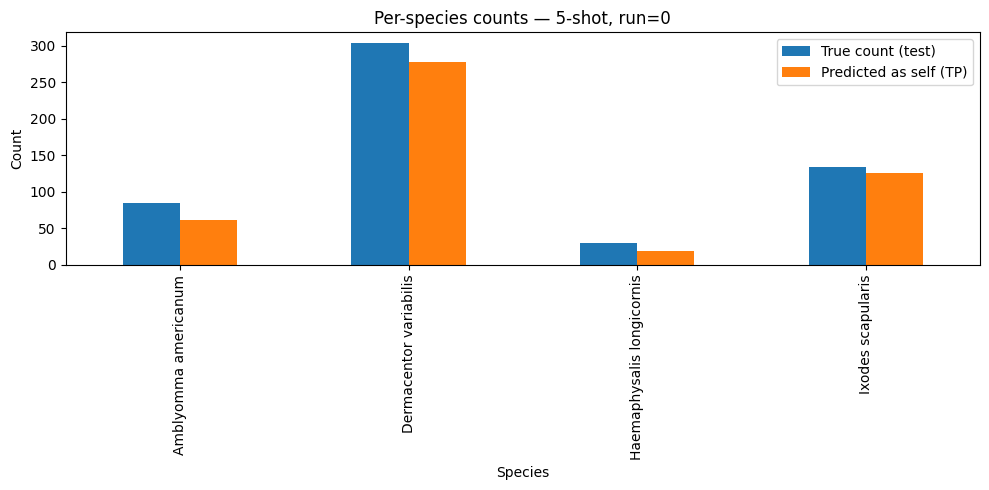


Confusion table (counts) — 5-shot, run=0


pred,Amblyomma americanum,Dermacentor variabilis,Haemaphysalis longicornis,Ixodes scapularis
true,,,,
Amblyomma americanum,62,3,18,2
Dermacentor variabilis,15,277,10,1
Haemaphysalis longicornis,10,0,19,1
Ixodes scapularis,0,1,7,126


In [7]:
# === Block 5 — Single-run reporting + safe append to master CSV ===
# Uses from Block 4: pred_rows, per_class_df, macro_acc, overall_acc, y_true, y_pred
# Globals: MASTER, CLASS_ORDER (optional), PREVIEW_PLOTS, SAVE_PLOTS, PLOTS_DIR

import matplotlib.pyplot as plt

# ---- 1) Collect run metadata ----
df_run = pd.DataFrame(pred_rows)
shots  = int(df_run["shots"].iloc[0])
run_id = int(df_run["run_id"].iloc[0])

# Prefer the recorded seed; if missing, recompute from (shots, run_id) to keep independence invariant.
if "seed" in df_run.columns and not pd.isna(df_run["seed"].iloc[0]):
    seed = int(df_run["seed"].iloc[0])
else:
    seed = seed_for(shots, run_id)


# ---- 2) Per-species summary table ----
tmp = pd.DataFrame({"true": y_true, "pred": y_pred})
per_species = (
    tmp.assign(hit=(tmp.true == tmp.pred).astype(int), one=1)
       .groupby("true")
       .agg(n_test=("one","sum"), n_correct=("hit","sum"))
       .assign(accuracy_species=lambda d: d.n_correct / d.n_test)
       .reset_index()
       .rename(columns={"true": "species"})
)
per_species["shots"] = shots
per_species["seed"]  = seed  # keep for transparency; not used as a key

with pd.option_context('display.float_format', '{:.3f}'.format):
    print(f"\nRun {run_id} (seed={seed}) — Shots {shots} "
          f"| Overall: {overall_acc:.3f} | Macro: {macro_acc:.3f}")
    display(per_species.sort_values("accuracy_species", ascending=False))

# ---- 3) Safe append to master CSV (de-duplicate by (shots, run_id, sample_id)) ----
MASTER.parent.mkdir(parents=True, exist_ok=True)
write_header = not MASTER.exists()

rows_before = len(df_run)
if not write_header:
    keys_existing = pd.read_csv(MASTER, usecols=["shots","run_id","sample_id"])
    merged = df_run.merge(keys_existing.assign(_exists=1),
                          on=["shots","run_id","sample_id"], how="left")
    df_run = merged[merged["_exists"].isna()].drop(columns=["_exists"])

rows_to_write = len(df_run)
if rows_to_write > 0:
    df_run.to_csv(MASTER, mode="a", header=write_header, index=False)

print(f"[APPEND] shots={shots} | run={run_id} | rows_written={rows_to_write}/{rows_before} "
      f"| macro={macro_acc:.3f} | overall={overall_acc:.3f}")

# ---- 4) Optional quick diagnostic plot for this run ----
if PREVIEW_PLOTS:
    # two-bar per-species: True count vs correctly predicted
    plot_df = (
        per_species.set_index("species")[["n_test","n_correct"]]
                   .reindex(CLASS_ORDER, fill_value=0) if 'CLASS_ORDER' in globals() and CLASS_ORDER is not None
                   else per_species.set_index("species")[["n_test","n_correct"]]
    )
    ax = plot_df.plot(kind="bar", figsize=(10,5), color=["#1f77b4", "#ff7f0e"])
    ax.set_title(f"Per-species counts — {shots}-shot, run={run_id}")
    ax.set_xlabel("Species"); ax.set_ylabel("Count")
    ax.legend(["True count (test)", "Predicted as self (TP)"])
    plt.tight_layout()
    if SAVE_PLOTS:
        out = PLOTS_DIR / f"per_species_counts_shots{shots:02d}_run{run_id:03d}.png"
        plt.savefig(out, dpi=150); print(f"[PLOT] saved {out}")
    plt.show()

    # optional plain confusion table for inspection (numbers only)
    conf_tbl = (
        pd.crosstab(pd.Series(y_true, name="true", dtype=object),
                    pd.Series(y_pred, name="pred", dtype=object))
    )
    if 'CLASS_ORDER' in globals() and CLASS_ORDER is not None:
        conf_tbl = conf_tbl.reindex(index=CLASS_ORDER, columns=CLASS_ORDER, fill_value=0)
    else:
        conf_tbl = conf_tbl.fillna(0).astype(int)
    print(f"\nConfusion table (counts) — {shots}-shot, run={run_id}")
    display(conf_tbl.astype(int))

## Block 6 Monte Carlo, 100 seeds. 

In [8]:
# === Block 6 — Monte Carlo sweep (shots × RUNS), timestamped MASTER, plus 'latest' pointer ===
# Assumes Blocks 0–5 are loaded.

from tqdm import tqdm
import traceback, shutil
from datetime import datetime

# --- choose a fresh, timestamped MASTER for this sweep ---
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
MASTER = RESULTS_ROOT / f"master_predictions_{timestamp}.csv"
MASTER_LATEST = RESULTS_ROOT / "master_predictions_latest.csv"
LATEST_NOTE = RESULTS_ROOT / "LATEST_MASTER.txt"

print(f"[INIT] Writing this sweep to: {MASTER.name}")

# Turn off any preview/saving during the sweep
_PREV, _SAVE = globals().get("PREVIEW_PLOTS", False), globals().get("SAVE_PLOTS", False)
PREVIEW_PLOTS, SAVE_PLOTS = False, False

failed_runs = []   # (shots, run_id, error_message)
total_written = 0  # number of rows appended to MASTER in this sweep

# (optional) helper to keep split seeding consistent in one place
def split_for_run(by_species, species_list, k, run_id):
    return split_once(by_species, species_list, k=k, seed=seed_for(k, run_id))

for shots in SHOTS:                             # e.g., [1, 3, 5, 10]
    pbar = tqdm(range(RUNS), desc=f"{shots}-shot runs", leave=True)
    for run_id in pbar:                         # 0..RUNS-1
        try:
            # 1) Split — seed derived from (shots, run_id) for independence
            train_pairs, test_pairs, split_counts, n_test_run = split_for_run(
                by_species, included_species, k=shots, run_id=run_id
            )

            # 2) Train + predict + collect rows for MASTER
            pred_rows, per_class_df, macro_acc, overall_acc, y_true, y_pred = train_predict_collect(
                by_species, train_pairs, test_pairs,
                shots=shots, run_id=run_id, n_test_run=n_test_run
            )

            # 3) Append to MASTER (no need to de-dup against previous files; this one is new)
            df_run = pd.DataFrame(pred_rows)
            df_run["sample_id"] = df_run["sample_id"].astype(str)

            MASTER.parent.mkdir(parents=True, exist_ok=True)
            write_header = not MASTER.exists()
            if len(df_run) > 0:
                df_run.to_csv(MASTER, mode="a", header=write_header, index=False)
                total_written += len(df_run)

            # Update tqdm summary
            pbar.set_postfix(rows_written=len(df_run),
                             macro=f"{macro_acc:.3f}", overall=f"{overall_acc:.3f}")

        except Exception as e:
            failed_runs.append((shots, run_id, str(e)))
            print(f"[ERROR] shots={shots} run_id={run_id} | {e}")
            # traceback.print_exc()  # uncomment for deep debugging

# Restore flags
PREVIEW_PLOTS, SAVE_PLOTS = _PREV, _SAVE

# --- Sweep summary + sanity checks ---
print("\n=== Block 6 sweep complete ===")
print(f"MASTER file: {MASTER.name}")
print(f"Total rows appended to MASTER in this sweep: {total_written}")
if len(failed_runs):
    print(f"Failures: {len(failed_runs)}")
    for shots_, run_id_, msg in failed_runs[:10]:
        print(f"  shots={shots_} run_id={run_id_} -> {msg}")
    if len(failed_runs) > 10:
        print("  ... (truncated)")

# Quick duplicate sanity check on keys (within this MASTER only)
try:
    _keys = pd.read_csv(MASTER, usecols=["shots", "run_id", "sample_id"],
                        dtype={"shots": int, "run_id": int, "sample_id": str})
    n_dupes = _keys.duplicated(subset=["shots", "run_id", "sample_id"]).sum()
    print(f"Duplicate rows in MASTER on (shots, run_id, sample_id): {n_dupes}")
except Exception as e:
    print(f"[WARN] Could not run duplicate check: {e}")

# --- Update "latest" pointer files for downstream blocks ---
try:
    # Overwrite a stable filename for convenience
    shutil.copyfile(MASTER, MASTER_LATEST)
    with open(LATEST_NOTE, "w") as f:
        f.write(f"{MASTER.name}\n")
    print(f"[LATEST] Updated: {MASTER_LATEST.name} and {LATEST_NOTE.name}")
except Exception as e:
    print(f"[WARN] Could not update latest pointers: {e}")

print("MASTER path:", MASTER.resolve())


[INIT] Writing this sweep to: master_predictions_20251117_155624.csv


1-shot runs:   0%|          | 0/100 [00:00<?, ?it/s]

Seed: 10042 | Shots: 1 | Run: 0
Overall accuracy: 0.803
Macro (balanced) accuracy: 0.617


,sample_id,true_label,pred_label,pred_confidence
0,69-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
1,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.254003
2,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.252118
3,50-02,Amblyomma americanum,Amblyomma americanum,0.250000
4,195-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
5,56-06,Amblyomma americanum,Haemaphysalis longicornis,0.250000
6,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.250000
7,363-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
8,34-01,Amblyomma americanum,Ixodes scapularis,0.250000
9,61-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000


1-shot runs:   0%|          | 0/100 [00:00<?, ?it/s, macro=0.617, overall=0.803, rows_written=568]

Seed: 10043 | Shots: 1 | Run: 1
Overall accuracy: 0.762
Macro (balanced) accuracy: 0.591


,sample_id,true_label,pred_label,pred_confidence
0,37-03,Amblyomma americanum,Dermacentor variabilis,0.250000
1,342-02,Amblyomma americanum,Haemaphysalis longicornis,0.251193
2,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.251413
3,37-02,Amblyomma americanum,Amblyomma americanum,0.250000
4,139-01,Amblyomma americanum,Amblyomma americanum,0.250000
5,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.250000
6,342-01,Amblyomma americanum,Dermacentor variabilis,0.250000
7,42-02,Amblyomma americanum,Amblyomma americanum,0.250000
8,56-05,Amblyomma americanum,Dermacentor variabilis,0.250000
9,ZOE-0079-09,Amblyomma americanum,Dermacentor variabilis,0.250000


1-shot runs:   2%|▏         | 2/100 [00:00<00:07, 12.78it/s, macro=0.591, overall=0.762, rows_written=568]

Seed: 10044 | Shots: 1 | Run: 2
Overall accuracy: 0.826
Macro (balanced) accuracy: 0.726


,sample_id,true_label,pred_label,pred_confidence
0,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
1,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
2,37-03,Amblyomma americanum,Amblyomma americanum,0.250997
3,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.250783
4,43-16,Amblyomma americanum,Ixodes scapularis,0.251242
5,419-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
6,427-01,Amblyomma americanum,Haemaphysalis longicornis,0.250901
7,56-02,Amblyomma americanum,Amblyomma americanum,0.250000
8,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
9,428-01,Amblyomma americanum,Dermacentor variabilis,0.250000


1-shot runs:   2%|▏         | 2/100 [00:00<00:07, 12.78it/s, macro=0.726, overall=0.826, rows_written=568]

Seed: 10045 | Shots: 1 | Run: 3
Overall accuracy: 0.822
Macro (balanced) accuracy: 0.686


,sample_id,true_label,pred_label,pred_confidence
0,56-06,Amblyomma americanum,Amblyomma americanum,0.250000
1,150-01,Amblyomma americanum,Amblyomma americanum,0.253020
2,50-01,Amblyomma americanum,Amblyomma americanum,0.250000
3,276-01,Amblyomma americanum,Haemaphysalis longicornis,0.250947
4,143-01,Amblyomma americanum,Amblyomma americanum,0.251579
5,342-01,Amblyomma americanum,Dermacentor variabilis,0.250000
6,ZOE-0096-02,Amblyomma americanum,Haemaphysalis longicornis,0.250000
7,419-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
8,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.251985
9,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.258151


1-shot runs:   4%|▍         | 4/100 [00:00<00:07, 13.67it/s, macro=0.686, overall=0.822, rows_written=568]

Seed: 10046 | Shots: 1 | Run: 4
Overall accuracy: 0.738
Macro (balanced) accuracy: 0.498


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-12,Amblyomma americanum,Dermacentor variabilis,0.254853
1,56-05,Amblyomma americanum,Dermacentor variabilis,0.253348
2,61-01,Amblyomma americanum,Dermacentor variabilis,0.250000
3,31-03,Amblyomma americanum,Dermacentor variabilis,0.251766
4,ZOE-0014-15,Amblyomma americanum,Dermacentor variabilis,0.253301
5,37-03,Amblyomma americanum,Dermacentor variabilis,0.251456
6,241-01,Amblyomma americanum,Ixodes scapularis,0.253621
7,ZOE-0014-01,Amblyomma americanum,Dermacentor variabilis,0.253670
8,191-01,Amblyomma americanum,Dermacentor variabilis,0.250000
9,40-02,Amblyomma americanum,Dermacentor variabilis,0.253714


1-shot runs:   4%|▍         | 4/100 [00:00<00:07, 13.67it/s, macro=0.498, overall=0.738, rows_written=568]

Seed: 10047 | Shots: 1 | Run: 5
Overall accuracy: 0.641
Macro (balanced) accuracy: 0.559


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.250000
1,337-01,Amblyomma americanum,Dermacentor variabilis,0.251298
2,19-02,Amblyomma americanum,Haemaphysalis longicornis,0.251718
3,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.254649
4,43-15,Amblyomma americanum,Amblyomma americanum,0.250000
5,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.250000
6,362-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
7,31-03,Amblyomma americanum,Amblyomma americanum,0.250953
8,ZOE-0014-15,Amblyomma americanum,Haemaphysalis longicornis,0.253583
9,427-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000


1-shot runs:   6%|▌         | 6/100 [00:00<00:06, 13.75it/s, macro=0.559, overall=0.641, rows_written=568]

Seed: 10048 | Shots: 1 | Run: 6
Overall accuracy: 0.873
Macro (balanced) accuracy: 0.727


,sample_id,true_label,pred_label,pred_confidence
0,31-01,Amblyomma americanum,Amblyomma americanum,0.250000
1,252-01,Amblyomma americanum,Amblyomma americanum,0.251649
2,528-01,Amblyomma americanum,Amblyomma americanum,0.250959
3,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.252908
4,414-01,Amblyomma americanum,Amblyomma americanum,0.254283
5,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.250987
6,35-02,Amblyomma americanum,Ixodes scapularis,0.250000
7,362-01,Amblyomma americanum,Amblyomma americanum,0.250000
8,69-01,Amblyomma americanum,Amblyomma americanum,0.250936
9,276-01,Amblyomma americanum,Amblyomma americanum,0.252387


1-shot runs:   6%|▌         | 6/100 [00:00<00:06, 13.75it/s, macro=0.727, overall=0.873, rows_written=568]

Seed: 10049 | Shots: 1 | Run: 7
Overall accuracy: 0.792
Macro (balanced) accuracy: 0.592


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.255745
1,195-01,Amblyomma americanum,Amblyomma americanum,0.252696
2,150-01,Amblyomma americanum,Amblyomma americanum,0.257283
3,ZOE-0014-14,Amblyomma americanum,Dermacentor variabilis,0.253553
4,50-01,Amblyomma americanum,Amblyomma americanum,0.250000
5,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.251708
6,61-01,Amblyomma americanum,Amblyomma americanum,0.252819
7,427-01,Amblyomma americanum,Amblyomma americanum,0.258442
8,37-02,Amblyomma americanum,Dermacentor variabilis,0.254476
9,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.252928


1-shot runs:   8%|▊         | 8/100 [00:00<00:06, 13.46it/s, macro=0.592, overall=0.792, rows_written=568]

Seed: 10050 | Shots: 1 | Run: 8
Overall accuracy: 0.741
Macro (balanced) accuracy: 0.558


,sample_id,true_label,pred_label,pred_confidence
0,43-11,Amblyomma americanum,Dermacentor variabilis,0.250000
1,69-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
2,ZOE-0079-07,Amblyomma americanum,Haemaphysalis longicornis,0.250000
3,191-01,Amblyomma americanum,Dermacentor variabilis,0.250000
4,61-03,Amblyomma americanum,Dermacentor variabilis,0.255645
5,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.252079
6,ZOE-0079-09,Amblyomma americanum,Dermacentor variabilis,0.251600
7,ZOE-0079-08,Amblyomma americanum,Haemaphysalis longicornis,0.250000
8,ZOE-0014-11,Amblyomma americanum,Haemaphysalis longicornis,0.252971
9,150-01,Amblyomma americanum,Haemaphysalis longicornis,0.254057


1-shot runs:   8%|▊         | 8/100 [00:00<00:06, 13.46it/s, macro=0.558, overall=0.741, rows_written=568]

Seed: 10051 | Shots: 1 | Run: 9
Overall accuracy: 0.710
Macro (balanced) accuracy: 0.607


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-11,Amblyomma americanum,Haemaphysalis longicornis,0.250000
1,363-01,Amblyomma americanum,Amblyomma americanum,0.250000
2,35-01,Amblyomma americanum,Haemaphysalis longicornis,0.250831
3,43-14,Amblyomma americanum,Haemaphysalis longicornis,0.250000
4,405-01,Amblyomma americanum,Amblyomma americanum,0.250000
5,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.251873
6,50-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
7,43-16,Amblyomma americanum,Haemaphysalis longicornis,0.250000
8,376-01,Amblyomma americanum,Amblyomma americanum,0.250000
9,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.250000


1-shot runs:  10%|█         | 10/100 [00:00<00:06, 13.49it/s, macro=0.607, overall=0.710, rows_written=568]

Seed: 10052 | Shots: 1 | Run: 10
Overall accuracy: 0.766
Macro (balanced) accuracy: 0.684


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-08,Amblyomma americanum,Haemaphysalis longicornis,0.251429
1,43-14,Amblyomma americanum,Haemaphysalis longicornis,0.250842
2,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.250000
3,201-01,Amblyomma americanum,Dermacentor variabilis,0.250000
4,37-03,Amblyomma americanum,Haemaphysalis longicornis,0.252862
5,40-02,Amblyomma americanum,Ixodes scapularis,0.250000
6,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.251277
7,ZOE-0079-04,Amblyomma americanum,Dermacentor variabilis,0.252120
8,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.253119
9,191-01,Amblyomma americanum,Dermacentor variabilis,0.250000


1-shot runs:  10%|█         | 10/100 [00:00<00:06, 13.49it/s, macro=0.684, overall=0.766, rows_written=568]

Seed: 10053 | Shots: 1 | Run: 11
Overall accuracy: 0.794
Macro (balanced) accuracy: 0.665


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-03,Amblyomma americanum,Dermacentor variabilis,0.250000
1,150-01,Amblyomma americanum,Haemaphysalis longicornis,0.252758
2,195-01,Amblyomma americanum,Amblyomma americanum,0.250659
3,342-02,Amblyomma americanum,Haemaphysalis longicornis,0.250000
4,252-01,Amblyomma americanum,Amblyomma americanum,0.250000
5,31-01,Amblyomma americanum,Amblyomma americanum,0.252674
6,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.250000
7,43-11,Amblyomma americanum,Amblyomma americanum,0.250000
8,414-01,Amblyomma americanum,Amblyomma americanum,0.250000
9,37-03,Amblyomma americanum,Haemaphysalis longicornis,0.253207


1-shot runs:  12%|█▏        | 12/100 [00:00<00:06, 13.45it/s, macro=0.665, overall=0.794, rows_written=568]

Seed: 10054 | Shots: 1 | Run: 12
Overall accuracy: 0.426
Macro (balanced) accuracy: 0.510


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.251719
1,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.253517
2,110-01,Amblyomma americanum,Dermacentor variabilis,0.250000
3,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.251566
4,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.250000
5,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.252275
6,414-01,Amblyomma americanum,Amblyomma americanum,0.253467
7,56-05,Amblyomma americanum,Haemaphysalis longicornis,0.251024
8,48-02,Amblyomma americanum,Haemaphysalis longicornis,0.250000
9,56-02,Amblyomma americanum,Haemaphysalis longicornis,0.250000


1-shot runs:  12%|█▏        | 12/100 [00:00<00:06, 13.45it/s, macro=0.510, overall=0.426, rows_written=568]

Seed: 10055 | Shots: 1 | Run: 13
Overall accuracy: 0.789
Macro (balanced) accuracy: 0.699


,sample_id,true_label,pred_label,pred_confidence
0,241-01,Amblyomma americanum,Ixodes scapularis,0.251544
1,376-01,Amblyomma americanum,Ixodes scapularis,0.250000
2,569-01,Amblyomma americanum,Ixodes scapularis,0.250000
3,276-01,Amblyomma americanum,Amblyomma americanum,0.251903
4,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.250000
5,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.250000
6,61-03,Amblyomma americanum,Amblyomma americanum,0.252240
7,69-01,Amblyomma americanum,Amblyomma americanum,0.250000
8,42-01,Amblyomma americanum,Amblyomma americanum,0.250000
9,50-01,Amblyomma americanum,Amblyomma americanum,0.250000


1-shot runs:  14%|█▍        | 14/100 [00:01<00:06, 13.23it/s, macro=0.699, overall=0.789, rows_written=568]

Seed: 10056 | Shots: 1 | Run: 14
Overall accuracy: 0.820
Macro (balanced) accuracy: 0.678


,sample_id,true_label,pred_label,pred_confidence
0,276-01,Amblyomma americanum,Amblyomma americanum,0.250000
1,61-03,Amblyomma americanum,Amblyomma americanum,0.253884
2,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.252320
3,42-01,Amblyomma americanum,Amblyomma americanum,0.251249
4,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.250000
5,342-01,Amblyomma americanum,Dermacentor variabilis,0.252158
6,405-01,Amblyomma americanum,Ixodes scapularis,0.250000
7,31-03,Amblyomma americanum,Amblyomma americanum,0.250000
8,19-01,Amblyomma americanum,Amblyomma americanum,0.250994
9,50-02,Amblyomma americanum,Amblyomma americanum,0.250000


1-shot runs:  14%|█▍        | 14/100 [00:01<00:06, 13.23it/s, macro=0.678, overall=0.820, rows_written=568]

Seed: 10057 | Shots: 1 | Run: 15
Overall accuracy: 0.826
Macro (balanced) accuracy: 0.772


,sample_id,true_label,pred_label,pred_confidence
0,252-01,Amblyomma americanum,Amblyomma americanum,0.250931
1,31-01,Amblyomma americanum,Amblyomma americanum,0.260854
2,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.251070
3,69-01,Amblyomma americanum,Amblyomma americanum,0.251366
4,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.250000
5,376-01,Amblyomma americanum,Amblyomma americanum,0.250744
6,42-02,Amblyomma americanum,Amblyomma americanum,0.259410
7,ZOE-0079-04,Amblyomma americanum,Dermacentor variabilis,0.252376
8,427-01,Amblyomma americanum,Haemaphysalis longicornis,0.251205
9,528-01,Amblyomma americanum,Amblyomma americanum,0.250000


1-shot runs:  16%|█▌        | 16/100 [00:01<00:07, 11.65it/s, macro=0.772, overall=0.826, rows_written=568]

Seed: 10058 | Shots: 1 | Run: 16
Overall accuracy: 0.771
Macro (balanced) accuracy: 0.595


,sample_id,true_label,pred_label,pred_confidence
0,50-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
1,35-02,Amblyomma americanum,Amblyomma americanum,0.258007
2,241-01,Amblyomma americanum,Amblyomma americanum,0.250000
3,43-16,Amblyomma americanum,Amblyomma americanum,0.252183
4,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.250000
5,ZOE-0014-08,Amblyomma americanum,Dermacentor variabilis,0.250000
6,528-01,Amblyomma americanum,Amblyomma americanum,0.250000
7,40-02,Amblyomma americanum,Amblyomma americanum,0.252104
8,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
9,56-05,Amblyomma americanum,Amblyomma americanum,0.250000


1-shot runs:  16%|█▌        | 16/100 [00:01<00:07, 11.65it/s, macro=0.595, overall=0.771, rows_written=568]

Seed: 10059 | Shots: 1 | Run: 17
Overall accuracy: 0.783
Macro (balanced) accuracy: 0.671


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-05,Amblyomma americanum,Haemaphysalis longicornis,0.250000
1,ZOE-0014-12,Amblyomma americanum,Haemaphysalis longicornis,0.250000
2,241-01,Amblyomma americanum,Dermacentor variabilis,0.250000
3,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
4,427-01,Amblyomma americanum,Dermacentor variabilis,0.250000
5,43-14,Amblyomma americanum,Amblyomma americanum,0.250000
6,61-03,Amblyomma americanum,Amblyomma americanum,0.251518
7,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
8,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.250000
9,195-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000


1-shot runs:  18%|█▊        | 18/100 [00:01<00:06, 12.19it/s, macro=0.671, overall=0.783, rows_written=568]

Seed: 10060 | Shots: 1 | Run: 18
Overall accuracy: 0.884
Macro (balanced) accuracy: 0.732


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.260890
1,528-01,Amblyomma americanum,Amblyomma americanum,0.252558
2,35-01,Amblyomma americanum,Amblyomma americanum,0.254289
3,234-01,Amblyomma americanum,Amblyomma americanum,0.252735
4,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.259820
5,419-01,Amblyomma americanum,Amblyomma americanum,0.253309
6,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.255485
7,569-01,Amblyomma americanum,Amblyomma americanum,0.252923
8,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
9,48-01,Amblyomma americanum,Amblyomma americanum,0.253013


1-shot runs:  18%|█▊        | 18/100 [00:01<00:06, 12.19it/s, macro=0.732, overall=0.884, rows_written=568]

Seed: 10061 | Shots: 1 | Run: 19
Overall accuracy: 0.794
Macro (balanced) accuracy: 0.688


,sample_id,true_label,pred_label,pred_confidence
0,69-02,Amblyomma americanum,Dermacentor variabilis,0.250000
1,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.250936
2,419-01,Amblyomma americanum,Amblyomma americanum,0.250000
3,48-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
4,491-01,Amblyomma americanum,Amblyomma americanum,0.250000
5,39-01,Amblyomma americanum,Dermacentor variabilis,0.250000
6,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.250000
7,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.250000
8,501-01,Amblyomma americanum,Amblyomma americanum,0.250000
9,43-16,Amblyomma americanum,Ixodes scapularis,0.250000


1-shot runs:  20%|██        | 20/100 [00:01<00:06, 12.58it/s, macro=0.688, overall=0.794, rows_written=568]

Seed: 10062 | Shots: 1 | Run: 20
Overall accuracy: 0.813
Macro (balanced) accuracy: 0.622


,sample_id,true_label,pred_label,pred_confidence
0,31-02,Amblyomma americanum,Amblyomma americanum,0.250000
1,48-02,Amblyomma americanum,Dermacentor variabilis,0.252565
2,ZOE-0014-12,Amblyomma americanum,Ixodes scapularis,0.259913
3,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.250000
4,337-01,Amblyomma americanum,Dermacentor variabilis,0.250000
5,ZOE-0079-08,Amblyomma americanum,Dermacentor variabilis,0.255522
6,ZOE-0082-01,Amblyomma americanum,Dermacentor variabilis,0.250000
7,61-01,Amblyomma americanum,Amblyomma americanum,0.251291
8,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.253997
9,ZOE-0079-04,Amblyomma americanum,Dermacentor variabilis,0.258288


1-shot runs:  20%|██        | 20/100 [00:01<00:06, 12.58it/s, macro=0.622, overall=0.813, rows_written=568]

Seed: 10063 | Shots: 1 | Run: 21
Overall accuracy: 0.290
Macro (balanced) accuracy: 0.421


,sample_id,true_label,pred_label,pred_confidence
0,56-01,Amblyomma americanum,Amblyomma americanum,0.251447
1,ZOE-0014-03,Amblyomma americanum,Haemaphysalis longicornis,0.250000
2,50-01,Amblyomma americanum,Amblyomma americanum,0.250000
3,ZOE-0014-05,Amblyomma americanum,Haemaphysalis longicornis,0.250000
4,19-02,Amblyomma americanum,Haemaphysalis longicornis,0.250744
5,37-03,Amblyomma americanum,Haemaphysalis longicornis,0.253459
6,ZOE-0014-02,Amblyomma americanum,Haemaphysalis longicornis,0.251740
7,241-01,Amblyomma americanum,Ixodes scapularis,0.250000
8,ZOE-0079-07,Amblyomma americanum,Haemaphysalis longicornis,0.250000
9,376-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000


1-shot runs:  22%|██▏       | 22/100 [00:01<00:06, 12.73it/s, macro=0.421, overall=0.290, rows_written=568]

Seed: 10064 | Shots: 1 | Run: 22
Overall accuracy: 0.835
Macro (balanced) accuracy: 0.719


,sample_id,true_label,pred_label,pred_confidence
0,50-02,Amblyomma americanum,Amblyomma americanum,0.252514
1,56-01,Amblyomma americanum,Amblyomma americanum,0.250000
2,42-01,Amblyomma americanum,Amblyomma americanum,0.250000
3,ZOE-0014-18,Amblyomma americanum,Dermacentor variabilis,0.253327
4,363-01,Amblyomma americanum,Amblyomma americanum,0.250000
5,39-01,Amblyomma americanum,Dermacentor variabilis,0.250000
6,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.250762
7,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.253382
8,19-02,Amblyomma americanum,Dermacentor variabilis,0.251984
9,241-01,Amblyomma americanum,Dermacentor variabilis,0.251646


1-shot runs:  22%|██▏       | 22/100 [00:01<00:06, 12.73it/s, macro=0.719, overall=0.835, rows_written=568]

Seed: 10065 | Shots: 1 | Run: 23
Overall accuracy: 0.368
Macro (balanced) accuracy: 0.338


,sample_id,true_label,pred_label,pred_confidence
0,50-03,Amblyomma americanum,Amblyomma americanum,0.250000
1,35-02,Amblyomma americanum,Amblyomma americanum,0.251246
2,ZOE-0014-03,Amblyomma americanum,Haemaphysalis longicornis,0.250995
3,139-01,Amblyomma americanum,Amblyomma americanum,0.250000
4,ZOE-0014-15,Amblyomma americanum,Haemaphysalis longicornis,0.250000
5,37-03,Amblyomma americanum,Amblyomma americanum,0.250000
6,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
7,37-02,Amblyomma americanum,Amblyomma americanum,0.250000
8,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.251968
9,241-01,Amblyomma americanum,Haemaphysalis longicornis,0.253026


1-shot runs:  24%|██▍       | 24/100 [00:01<00:05, 12.67it/s, macro=0.338, overall=0.368, rows_written=568]

Seed: 10066 | Shots: 1 | Run: 24
Overall accuracy: 0.710
Macro (balanced) accuracy: 0.495


,sample_id,true_label,pred_label,pred_confidence
0,31-03,Amblyomma americanum,Ixodes scapularis,0.250000
1,195-01,Amblyomma americanum,Amblyomma americanum,0.250000
2,61-02,Amblyomma americanum,Amblyomma americanum,0.250000
3,ZOE-0014-15,Amblyomma americanum,Haemaphysalis longicornis,0.251039
4,ZOE-0014-12,Amblyomma americanum,Haemaphysalis longicornis,0.250000
5,405-01,Amblyomma americanum,Amblyomma americanum,0.256033
6,43-16,Amblyomma americanum,Ixodes scapularis,0.250000
7,61-03,Amblyomma americanum,Ixodes scapularis,0.250000
8,56-01,Amblyomma americanum,Amblyomma americanum,0.250000
9,ZOE-0079-06,Amblyomma americanum,Haemaphysalis longicornis,0.252122


1-shot runs:  24%|██▍       | 24/100 [00:01<00:05, 12.67it/s, macro=0.495, overall=0.710, rows_written=568]

Seed: 10067 | Shots: 1 | Run: 25
Overall accuracy: 0.849
Macro (balanced) accuracy: 0.799


,sample_id,true_label,pred_label,pred_confidence
0,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.25
1,150-01,Amblyomma americanum,Amblyomma americanum,0.25
2,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.25
3,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.25
4,143-01,Amblyomma americanum,Amblyomma americanum,0.25
5,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.25
6,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.25
7,57-01,Amblyomma americanum,Amblyomma americanum,0.25
8,43-15,Amblyomma americanum,Haemaphysalis longicornis,0.25
9,35-01,Amblyomma americanum,Amblyomma americanum,0.25


1-shot runs:  26%|██▌       | 26/100 [00:02<00:05, 12.95it/s, macro=0.799, overall=0.849, rows_written=568]

Seed: 10068 | Shots: 1 | Run: 26
Overall accuracy: 0.831
Macro (balanced) accuracy: 0.653


,sample_id,true_label,pred_label,pred_confidence
0,61-01,Amblyomma americanum,Amblyomma americanum,0.250549
1,39-01,Amblyomma americanum,Amblyomma americanum,0.263207
2,342-01,Amblyomma americanum,Dermacentor variabilis,0.253580
3,376-01,Amblyomma americanum,Ixodes scapularis,0.250000
4,40-02,Amblyomma americanum,Amblyomma americanum,0.254181
5,491-01,Amblyomma americanum,Amblyomma americanum,0.250000
6,276-01,Amblyomma americanum,Amblyomma americanum,0.250000
7,43-15,Amblyomma americanum,Amblyomma americanum,0.257756
8,288-01,Amblyomma americanum,Amblyomma americanum,0.250000
9,427-01,Amblyomma americanum,Amblyomma americanum,0.250000


1-shot runs:  26%|██▌       | 26/100 [00:02<00:05, 12.95it/s, macro=0.653, overall=0.831, rows_written=568]

Seed: 10069 | Shots: 1 | Run: 27
Overall accuracy: 0.759
Macro (balanced) accuracy: 0.603


,sample_id,true_label,pred_label,pred_confidence
0,419-01,Amblyomma americanum,Haemaphysalis longicornis,0.251858
1,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
2,528-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
3,ZOE-0082-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
4,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.251633
5,ZOE-0014-05,Amblyomma americanum,Dermacentor variabilis,0.250000
6,ZOE-0079-06,Amblyomma americanum,Haemaphysalis longicornis,0.250000
7,48-01,Amblyomma americanum,Amblyomma americanum,0.250000
8,56-05,Amblyomma americanum,Dermacentor variabilis,0.250000
9,35-01,Amblyomma americanum,Amblyomma americanum,0.250000


1-shot runs:  28%|██▊       | 28/100 [00:02<00:05, 12.61it/s, macro=0.603, overall=0.759, rows_written=568]

Seed: 10070 | Shots: 1 | Run: 28
Overall accuracy: 0.847
Macro (balanced) accuracy: 0.717


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.250000
1,ZOE-0079-08,Amblyomma americanum,Dermacentor variabilis,0.251638
2,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
3,252-01,Amblyomma americanum,Amblyomma americanum,0.250897
4,50-03,Amblyomma americanum,Amblyomma americanum,0.251492
5,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.251641
6,569-01,Amblyomma americanum,Amblyomma americanum,0.250000
7,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.251286
8,37-01,Amblyomma americanum,Amblyomma americanum,0.251435
9,139-01,Amblyomma americanum,Amblyomma americanum,0.251000


1-shot runs:  28%|██▊       | 28/100 [00:02<00:05, 12.61it/s, macro=0.717, overall=0.847, rows_written=568]

Seed: 10071 | Shots: 1 | Run: 29
Overall accuracy: 0.734
Macro (balanced) accuracy: 0.642


,sample_id,true_label,pred_label,pred_confidence
0,43-11,Amblyomma americanum,Ixodes scapularis,0.25
1,195-01,Amblyomma americanum,Haemaphysalis longicornis,0.25
2,40-01,Amblyomma americanum,Amblyomma americanum,0.25
3,501-01,Amblyomma americanum,Dermacentor variabilis,0.25
4,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.25
5,191-01,Amblyomma americanum,Dermacentor variabilis,0.25
6,ZOE-0014-12,Amblyomma americanum,Dermacentor variabilis,0.25
7,ZOE-0079-08,Amblyomma americanum,Dermacentor variabilis,0.25
8,ZOE-0014-09,Amblyomma americanum,Dermacentor variabilis,0.25
9,ZOE-0014-17,Amblyomma americanum,Dermacentor variabilis,0.25


1-shot runs:  30%|███       | 30/100 [00:02<00:05, 12.85it/s, macro=0.642, overall=0.734, rows_written=568]

Seed: 10072 | Shots: 1 | Run: 30
Overall accuracy: 0.717
Macro (balanced) accuracy: 0.597


,sample_id,true_label,pred_label,pred_confidence
0,288-01,Amblyomma americanum,Amblyomma americanum,0.250000
1,143-01,Amblyomma americanum,Amblyomma americanum,0.250696
2,252-01,Amblyomma americanum,Amblyomma americanum,0.250000
3,ZOE-0014-13,Amblyomma americanum,Ixodes scapularis,0.250000
4,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.250000
5,31-03,Amblyomma americanum,Ixodes scapularis,0.250000
6,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.254943
7,50-02,Amblyomma americanum,Amblyomma americanum,0.250000
8,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.252126
9,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.256379


1-shot runs:  30%|███       | 30/100 [00:02<00:05, 12.85it/s, macro=0.597, overall=0.717, rows_written=568]

Seed: 10073 | Shots: 1 | Run: 31
Overall accuracy: 0.787
Macro (balanced) accuracy: 0.647


,sample_id,true_label,pred_label,pred_confidence
0,35-01,Amblyomma americanum,Dermacentor variabilis,0.250000
1,ZOE-0014-03,Amblyomma americanum,Dermacentor variabilis,0.250000
2,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.250589
3,234-01,Amblyomma americanum,Amblyomma americanum,0.251789
4,376-01,Amblyomma americanum,Amblyomma americanum,0.251898
5,43-16,Amblyomma americanum,Haemaphysalis longicornis,0.250000
6,48-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
7,241-01,Amblyomma americanum,Amblyomma americanum,0.253652
8,43-12,Amblyomma americanum,Dermacentor variabilis,0.250000
9,342-02,Amblyomma americanum,Haemaphysalis longicornis,0.250000


1-shot runs:  32%|███▏      | 32/100 [00:02<00:05, 13.10it/s, macro=0.647, overall=0.787, rows_written=568]

Seed: 10074 | Shots: 1 | Run: 32
Overall accuracy: 0.776
Macro (balanced) accuracy: 0.726


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0082-01,Amblyomma americanum,Haemaphysalis longicornis,0.25
1,69-02,Amblyomma americanum,Dermacentor variabilis,0.25
2,19-01,Amblyomma americanum,Ixodes scapularis,0.25
3,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.25
4,ZOE-0014-14,Amblyomma americanum,Dermacentor variabilis,0.25
5,31-02,Amblyomma americanum,Ixodes scapularis,0.25
6,35-02,Amblyomma americanum,Amblyomma americanum,0.25
7,ZOE-0014-01,Amblyomma americanum,Dermacentor variabilis,0.25
8,69-01,Amblyomma americanum,Amblyomma americanum,0.25
9,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.25


1-shot runs:  32%|███▏      | 32/100 [00:02<00:05, 13.10it/s, macro=0.726, overall=0.776, rows_written=568]

Seed: 10075 | Shots: 1 | Run: 33
Overall accuracy: 0.796
Macro (balanced) accuracy: 0.659


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.250000
1,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.254712
2,405-01,Amblyomma americanum,Ixodes scapularis,0.250000
3,234-01,Amblyomma americanum,Dermacentor variabilis,0.250000
4,19-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
5,61-02,Amblyomma americanum,Haemaphysalis longicornis,0.250000
6,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.251183
7,ZOE-0014-11,Amblyomma americanum,Haemaphysalis longicornis,0.250000
8,191-01,Amblyomma americanum,Dermacentor variabilis,0.252631
9,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.251785


1-shot runs:  34%|███▍      | 34/100 [00:02<00:04, 13.28it/s, macro=0.659, overall=0.796, rows_written=568]

Seed: 10076 | Shots: 1 | Run: 34
Overall accuracy: 0.824
Macro (balanced) accuracy: 0.646


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-12,Amblyomma americanum,Dermacentor variabilis,0.250000
1,139-01,Amblyomma americanum,Amblyomma americanum,0.252025
2,337-01,Amblyomma americanum,Dermacentor variabilis,0.250000
3,42-01,Amblyomma americanum,Amblyomma americanum,0.254617
4,ZOE-0014-11,Amblyomma americanum,Ixodes scapularis,0.252378
5,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.252906
6,528-01,Amblyomma americanum,Ixodes scapularis,0.250000
7,405-01,Amblyomma americanum,Ixodes scapularis,0.250000
8,241-01,Amblyomma americanum,Ixodes scapularis,0.250000
9,491-01,Amblyomma americanum,Ixodes scapularis,0.250000


1-shot runs:  34%|███▍      | 34/100 [00:02<00:04, 13.28it/s, macro=0.646, overall=0.824, rows_written=568]

Seed: 10077 | Shots: 1 | Run: 35
Overall accuracy: 0.838
Macro (balanced) accuracy: 0.685


,sample_id,true_label,pred_label,pred_confidence
0,34-01,Amblyomma americanum,Amblyomma americanum,0.251863
1,50-03,Amblyomma americanum,Haemaphysalis longicornis,0.255465
2,19-01,Amblyomma americanum,Amblyomma americanum,0.252304
3,ZOE-0014-14,Amblyomma americanum,Dermacentor variabilis,0.252627
4,110-01,Amblyomma americanum,Ixodes scapularis,0.250000
5,376-01,Amblyomma americanum,Amblyomma americanum,0.251792
6,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.251477
7,195-01,Amblyomma americanum,Haemaphysalis longicornis,0.251598
8,19-02,Amblyomma americanum,Amblyomma americanum,0.254820
9,31-02,Amblyomma americanum,Amblyomma americanum,0.250000


1-shot runs:  36%|███▌      | 36/100 [00:02<00:04, 13.44it/s, macro=0.685, overall=0.838, rows_written=568]

Seed: 10078 | Shots: 1 | Run: 36
Overall accuracy: 0.790
Macro (balanced) accuracy: 0.685


,sample_id,true_label,pred_label,pred_confidence
0,465-01,Amblyomma americanum,Haemaphysalis longicornis,0.252383
1,139-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
2,ZOE-0014-02,Amblyomma americanum,Ixodes scapularis,0.250000
3,56-02,Amblyomma americanum,Haemaphysalis longicornis,0.250000
4,39-01,Amblyomma americanum,Haemaphysalis longicornis,0.251695
5,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.250000
6,150-01,Amblyomma americanum,Amblyomma americanum,0.250000
7,528-01,Amblyomma americanum,Amblyomma americanum,0.251778
8,ZOE-0014-08,Amblyomma americanum,Ixodes scapularis,0.250000
9,69-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000


1-shot runs:  36%|███▌      | 36/100 [00:02<00:04, 13.44it/s, macro=0.685, overall=0.790, rows_written=568]

Seed: 10079 | Shots: 1 | Run: 37
Overall accuracy: 0.766
Macro (balanced) accuracy: 0.564


,sample_id,true_label,pred_label,pred_confidence
0,31-01,Amblyomma americanum,Amblyomma americanum,0.253681
1,69-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
2,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.251775
3,195-01,Amblyomma americanum,Haemaphysalis longicornis,0.252891
4,ZOE-0014-20,Amblyomma americanum,Dermacentor variabilis,0.255198
5,288-01,Amblyomma americanum,Haemaphysalis longicornis,0.251649
6,69-02,Amblyomma americanum,Amblyomma americanum,0.253169
7,56-05,Amblyomma americanum,Ixodes scapularis,0.251207
8,311-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
9,501-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000


1-shot runs:  38%|███▊      | 38/100 [00:02<00:04, 13.44it/s, macro=0.564, overall=0.766, rows_written=568]

Seed: 10080 | Shots: 1 | Run: 38
Overall accuracy: 0.572
Macro (balanced) accuracy: 0.451


,sample_id,true_label,pred_label,pred_confidence
0,501-01,Amblyomma americanum,Ixodes scapularis,0.25000
1,43-16,Amblyomma americanum,Dermacentor variabilis,0.25000
2,61-03,Amblyomma americanum,Haemaphysalis longicornis,0.25000
3,40-02,Amblyomma americanum,Dermacentor variabilis,0.25000
4,ZOE-0079-06,Amblyomma americanum,Haemaphysalis longicornis,0.25000
5,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.25378
6,43-12,Amblyomma americanum,Amblyomma americanum,0.25000
7,31-03,Amblyomma americanum,Amblyomma americanum,0.25000
8,276-01,Amblyomma americanum,Haemaphysalis longicornis,0.25000
9,50-02,Amblyomma americanum,Haemaphysalis longicornis,0.25000


1-shot runs:  38%|███▊      | 38/100 [00:02<00:04, 13.44it/s, macro=0.451, overall=0.572, rows_written=568]

Seed: 10081 | Shots: 1 | Run: 39
Overall accuracy: 0.859
Macro (balanced) accuracy: 0.703


,sample_id,true_label,pred_label,pred_confidence
0,252-01,Amblyomma americanum,Amblyomma americanum,0.251572
1,ZOE-0014-03,Amblyomma americanum,Dermacentor variabilis,0.250000
2,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.253915
3,143-01,Amblyomma americanum,Amblyomma americanum,0.250000
4,491-01,Amblyomma americanum,Amblyomma americanum,0.252176
5,195-01,Amblyomma americanum,Amblyomma americanum,0.254257
6,19-02,Amblyomma americanum,Amblyomma americanum,0.250000
7,43-16,Amblyomma americanum,Amblyomma americanum,0.253330
8,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.251033
9,31-01,Amblyomma americanum,Amblyomma americanum,0.256255


1-shot runs:  40%|████      | 40/100 [00:03<00:04, 13.22it/s, macro=0.703, overall=0.859, rows_written=568]

Seed: 10082 | Shots: 1 | Run: 40
Overall accuracy: 0.651
Macro (balanced) accuracy: 0.492


,sample_id,true_label,pred_label,pred_confidence
0,311-01,Amblyomma americanum,Amblyomma americanum,0.250000
1,ZOE-0014-12,Amblyomma americanum,Haemaphysalis longicornis,0.250000
2,ZOE-0014-11,Amblyomma americanum,Haemaphysalis longicornis,0.251136
3,56-05,Amblyomma americanum,Dermacentor variabilis,0.250000
4,569-01,Amblyomma americanum,Haemaphysalis longicornis,0.253153
5,ZOE-0096-02,Amblyomma americanum,Haemaphysalis longicornis,0.252094
6,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.253640
7,191-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
8,ZOE-0079-07,Amblyomma americanum,Haemaphysalis longicornis,0.250000
9,61-02,Amblyomma americanum,Amblyomma americanum,0.250000


1-shot runs:  40%|████      | 40/100 [00:03<00:04, 13.22it/s, macro=0.492, overall=0.651, rows_written=568]

Seed: 10083 | Shots: 1 | Run: 41
Overall accuracy: 0.822
Macro (balanced) accuracy: 0.634


,sample_id,true_label,pred_label,pred_confidence
0,150-01,Amblyomma americanum,Amblyomma americanum,0.250000
1,19-02,Amblyomma americanum,Amblyomma americanum,0.250000
2,61-03,Amblyomma americanum,Amblyomma americanum,0.251024
3,405-01,Amblyomma americanum,Dermacentor variabilis,0.250000
4,61-02,Amblyomma americanum,Amblyomma americanum,0.254807
5,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
6,569-01,Amblyomma americanum,Amblyomma americanum,0.250000
7,35-01,Amblyomma americanum,Dermacentor variabilis,0.250000
8,ZOE-0014-14,Amblyomma americanum,Dermacentor variabilis,0.250000
9,19-01,Amblyomma americanum,Dermacentor variabilis,0.250000


1-shot runs:  42%|████▏     | 42/100 [00:03<00:04, 13.18it/s, macro=0.634, overall=0.822, rows_written=568]

Seed: 10084 | Shots: 1 | Run: 42
Overall accuracy: 0.840
Macro (balanced) accuracy: 0.731


,sample_id,true_label,pred_label,pred_confidence
0,419-01,Amblyomma americanum,Amblyomma americanum,0.256251
1,465-01,Amblyomma americanum,Amblyomma americanum,0.251778
2,ZOE-0014-05,Amblyomma americanum,Dermacentor variabilis,0.253659
3,342-02,Amblyomma americanum,Amblyomma americanum,0.252474
4,ZOE-0014-11,Amblyomma americanum,Dermacentor variabilis,0.253689
5,201-01,Amblyomma americanum,Amblyomma americanum,0.250000
6,311-01,Amblyomma americanum,Amblyomma americanum,0.252337
7,42-02,Amblyomma americanum,Amblyomma americanum,0.250000
8,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.256350
9,42-01,Amblyomma americanum,Amblyomma americanum,0.252189


1-shot runs:  42%|████▏     | 42/100 [00:03<00:04, 13.18it/s, macro=0.731, overall=0.840, rows_written=568]

Seed: 10085 | Shots: 1 | Run: 43
Overall accuracy: 0.757
Macro (balanced) accuracy: 0.599


,sample_id,true_label,pred_label,pred_confidence
0,56-01,Amblyomma americanum,Ixodes scapularis,0.250000
1,252-01,Amblyomma americanum,Amblyomma americanum,0.250000
2,37-02,Amblyomma americanum,Ixodes scapularis,0.252402
3,276-01,Amblyomma americanum,Amblyomma americanum,0.250000
4,43-12,Amblyomma americanum,Ixodes scapularis,0.252434
5,43-11,Amblyomma americanum,Ixodes scapularis,0.251801
6,143-01,Amblyomma americanum,Amblyomma americanum,0.251045
7,342-02,Amblyomma americanum,Amblyomma americanum,0.250000
8,61-03,Amblyomma americanum,Amblyomma americanum,0.250000
9,40-02,Amblyomma americanum,Ixodes scapularis,0.252224


1-shot runs:  44%|████▍     | 44/100 [00:03<00:04, 13.25it/s, macro=0.599, overall=0.757, rows_written=568]

Seed: 10086 | Shots: 1 | Run: 44
Overall accuracy: 0.789
Macro (balanced) accuracy: 0.620


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.251805
1,39-01,Amblyomma americanum,Dermacentor variabilis,0.252225
2,363-01,Amblyomma americanum,Dermacentor variabilis,0.250000
3,69-02,Amblyomma americanum,Ixodes scapularis,0.250000
4,405-01,Amblyomma americanum,Ixodes scapularis,0.250000
5,48-01,Amblyomma americanum,Amblyomma americanum,0.250000
6,56-05,Amblyomma americanum,Amblyomma americanum,0.250000
7,37-01,Amblyomma americanum,Dermacentor variabilis,0.250000
8,31-01,Amblyomma americanum,Dermacentor variabilis,0.250000
9,419-01,Amblyomma americanum,Dermacentor variabilis,0.250000


1-shot runs:  44%|████▍     | 44/100 [00:03<00:04, 13.25it/s, macro=0.620, overall=0.789, rows_written=568]

Seed: 10087 | Shots: 1 | Run: 45
Overall accuracy: 0.790
Macro (balanced) accuracy: 0.697


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-09,Amblyomma americanum,Ixodes scapularis,0.250000
1,150-01,Amblyomma americanum,Amblyomma americanum,0.252536
2,419-01,Amblyomma americanum,Amblyomma americanum,0.250000
3,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.250000
4,56-02,Amblyomma americanum,Amblyomma americanum,0.250000
5,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.250000
6,42-02,Amblyomma americanum,Haemaphysalis longicornis,0.250000
7,ZOE-0014-17,Amblyomma americanum,Haemaphysalis longicornis,0.250000
8,40-01,Amblyomma americanum,Ixodes scapularis,0.250000
9,39-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000


1-shot runs:  46%|████▌     | 46/100 [00:03<00:04, 13.42it/s, macro=0.697, overall=0.790, rows_written=568]

Seed: 10088 | Shots: 1 | Run: 46
Overall accuracy: 0.798
Macro (balanced) accuracy: 0.680


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-05,Amblyomma americanum,Haemaphysalis longicornis,0.250000
1,311-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
2,ZOE-0014-14,Amblyomma americanum,Dermacentor variabilis,0.250000
3,419-01,Amblyomma americanum,Amblyomma americanum,0.250000
4,342-02,Amblyomma americanum,Haemaphysalis longicornis,0.251824
5,31-02,Amblyomma americanum,Amblyomma americanum,0.250000
6,50-03,Amblyomma americanum,Amblyomma americanum,0.250000
7,241-01,Amblyomma americanum,Haemaphysalis longicornis,0.253007
8,ZOE-0096-02,Amblyomma americanum,Haemaphysalis longicornis,0.250000
9,362-01,Amblyomma americanum,Haemaphysalis longicornis,0.250670


1-shot runs:  46%|████▌     | 46/100 [00:03<00:04, 13.42it/s, macro=0.680, overall=0.798, rows_written=568]

Seed: 10089 | Shots: 1 | Run: 47
Overall accuracy: 0.803
Macro (balanced) accuracy: 0.758


,sample_id,true_label,pred_label,pred_confidence
0,143-01,Amblyomma americanum,Amblyomma americanum,0.253377
1,56-05,Amblyomma americanum,Amblyomma americanum,0.253188
2,110-01,Amblyomma americanum,Ixodes scapularis,0.250000
3,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.255044
4,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.254935
5,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.256183
6,43-11,Amblyomma americanum,Amblyomma americanum,0.250000
7,56-02,Amblyomma americanum,Amblyomma americanum,0.250000
8,43-14,Amblyomma americanum,Amblyomma americanum,0.250000
9,569-01,Amblyomma americanum,Ixodes scapularis,0.250000


1-shot runs:  48%|████▊     | 48/100 [00:03<00:04, 12.71it/s, macro=0.758, overall=0.803, rows_written=568]

Seed: 10090 | Shots: 1 | Run: 48
Overall accuracy: 0.799
Macro (balanced) accuracy: 0.662


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-11,Amblyomma americanum,Dermacentor variabilis,0.252184
1,ZOE-0014-08,Amblyomma americanum,Dermacentor variabilis,0.251034
2,143-01,Amblyomma americanum,Amblyomma americanum,0.250000
3,61-02,Amblyomma americanum,Amblyomma americanum,0.251344
4,376-01,Amblyomma americanum,Dermacentor variabilis,0.250000
5,61-03,Amblyomma americanum,Amblyomma americanum,0.251735
6,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
7,19-02,Amblyomma americanum,Amblyomma americanum,0.252992
8,139-01,Amblyomma americanum,Amblyomma americanum,0.251687
9,ZOE-0014-14,Amblyomma americanum,Dermacentor variabilis,0.251056


1-shot runs:  48%|████▊     | 48/100 [00:03<00:04, 12.71it/s, macro=0.662, overall=0.799, rows_written=568]

Seed: 10091 | Shots: 1 | Run: 49
Overall accuracy: 0.312
Macro (balanced) accuracy: 0.389


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-09,Amblyomma americanum,Ixodes scapularis,0.252466
1,419-01,Amblyomma americanum,Amblyomma americanum,0.253107
2,37-01,Amblyomma americanum,Amblyomma americanum,0.256069
3,57-01,Amblyomma americanum,Dermacentor variabilis,0.250000
4,337-01,Amblyomma americanum,Amblyomma americanum,0.250000
5,ZOE-0014-18,Amblyomma americanum,Haemaphysalis longicornis,0.250000
6,363-01,Amblyomma americanum,Amblyomma americanum,0.250716
7,61-02,Amblyomma americanum,Haemaphysalis longicornis,0.252738
8,491-01,Amblyomma americanum,Amblyomma americanum,0.253644
9,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.252495


1-shot runs:  50%|█████     | 50/100 [00:03<00:03, 13.00it/s, macro=0.389, overall=0.312, rows_written=568]

Seed: 10092 | Shots: 1 | Run: 50
Overall accuracy: 0.776
Macro (balanced) accuracy: 0.597


,sample_id,true_label,pred_label,pred_confidence
0,50-03,Amblyomma americanum,Haemaphysalis longicornis,0.250000
1,50-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
2,376-01,Amblyomma americanum,Amblyomma americanum,0.250000
3,ZOE-0079-05,Amblyomma americanum,Haemaphysalis longicornis,0.251637
4,43-16,Amblyomma americanum,Haemaphysalis longicornis,0.250000
5,40-02,Amblyomma americanum,Haemaphysalis longicornis,0.250000
6,ZOE-0014-15,Amblyomma americanum,Haemaphysalis longicornis,0.250000
7,491-01,Amblyomma americanum,Amblyomma americanum,0.250000
8,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
9,19-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000


1-shot runs:  50%|█████     | 50/100 [00:03<00:03, 13.00it/s, macro=0.597, overall=0.776, rows_written=568]

Seed: 10093 | Shots: 1 | Run: 51
Overall accuracy: 0.717
Macro (balanced) accuracy: 0.569


,sample_id,true_label,pred_label,pred_confidence
0,528-01,Amblyomma americanum,Ixodes scapularis,0.250966
1,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
2,50-03,Amblyomma americanum,Haemaphysalis longicornis,0.250000
3,ZOE-0013-02,Amblyomma americanum,Ixodes scapularis,0.250000
4,252-01,Amblyomma americanum,Ixodes scapularis,0.250000
5,56-06,Amblyomma americanum,Dermacentor variabilis,0.250000
6,42-01,Amblyomma americanum,Amblyomma americanum,0.252240
7,35-01,Amblyomma americanum,Amblyomma americanum,0.252813
8,427-01,Amblyomma americanum,Ixodes scapularis,0.251332
9,342-02,Amblyomma americanum,Ixodes scapularis,0.250000


1-shot runs:  52%|█████▏    | 52/100 [00:03<00:03, 13.22it/s, macro=0.569, overall=0.717, rows_written=568]

Seed: 10094 | Shots: 1 | Run: 52
Overall accuracy: 0.641
Macro (balanced) accuracy: 0.514


,sample_id,true_label,pred_label,pred_confidence
0,42-01,Amblyomma americanum,Amblyomma americanum,0.250982
1,191-01,Amblyomma americanum,Dermacentor variabilis,0.255870
2,43-16,Amblyomma americanum,Haemaphysalis longicornis,0.250000
3,ZOE-0014-05,Amblyomma americanum,Dermacentor variabilis,0.256119
4,40-02,Amblyomma americanum,Amblyomma americanum,0.250000
5,428-01,Amblyomma americanum,Amblyomma americanum,0.250000
6,31-03,Amblyomma americanum,Amblyomma americanum,0.250000
7,195-01,Amblyomma americanum,Haemaphysalis longicornis,0.253986
8,ZOE-0014-02,Amblyomma americanum,Haemaphysalis longicornis,0.250000
9,ZOE-0014-14,Amblyomma americanum,Haemaphysalis longicornis,0.251523


1-shot runs:  52%|█████▏    | 52/100 [00:04<00:03, 13.22it/s, macro=0.514, overall=0.641, rows_written=568]

Seed: 10095 | Shots: 1 | Run: 53
Overall accuracy: 0.687
Macro (balanced) accuracy: 0.637


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.25463
1,31-02,Amblyomma americanum,Amblyomma americanum,0.25000
2,110-01,Amblyomma americanum,Ixodes scapularis,0.25000
3,19-02,Amblyomma americanum,Amblyomma americanum,0.25000
4,40-01,Amblyomma americanum,Amblyomma americanum,0.25000
5,ZOE-0079-08,Amblyomma americanum,Haemaphysalis longicornis,0.25000
6,56-06,Amblyomma americanum,Amblyomma americanum,0.25000
7,311-01,Amblyomma americanum,Amblyomma americanum,0.25000
8,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.25000
9,342-02,Amblyomma americanum,Amblyomma americanum,0.25000


1-shot runs:  54%|█████▍    | 54/100 [00:04<00:03, 12.88it/s, macro=0.637, overall=0.687, rows_written=568]

Seed: 10096 | Shots: 1 | Run: 54
Overall accuracy: 0.789
Macro (balanced) accuracy: 0.639


,sample_id,true_label,pred_label,pred_confidence
0,37-03,Amblyomma americanum,Amblyomma americanum,0.250000
1,37-02,Amblyomma americanum,Amblyomma americanum,0.250000
2,362-01,Amblyomma americanum,Dermacentor variabilis,0.250000
3,342-01,Amblyomma americanum,Dermacentor variabilis,0.250000
4,139-01,Amblyomma americanum,Amblyomma americanum,0.251260
5,ZOE-0079-08,Amblyomma americanum,Dermacentor variabilis,0.252050
6,61-01,Amblyomma americanum,Amblyomma americanum,0.250000
7,342-02,Amblyomma americanum,Dermacentor variabilis,0.250896
8,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
9,405-01,Amblyomma americanum,Dermacentor variabilis,0.250000


1-shot runs:  54%|█████▍    | 54/100 [00:04<00:03, 12.88it/s, macro=0.639, overall=0.789, rows_written=568]

Seed: 10097 | Shots: 1 | Run: 55
Overall accuracy: 0.722
Macro (balanced) accuracy: 0.627


,sample_id,true_label,pred_label,pred_confidence
0,405-01,Amblyomma americanum,Amblyomma americanum,0.250000
1,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.253507
2,56-06,Amblyomma americanum,Haemaphysalis longicornis,0.251248
3,276-01,Amblyomma americanum,Amblyomma americanum,0.250000
4,56-05,Amblyomma americanum,Haemaphysalis longicornis,0.251353
5,363-01,Amblyomma americanum,Amblyomma americanum,0.250000
6,43-14,Amblyomma americanum,Dermacentor variabilis,0.250946
7,ZOE-0082-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
8,143-01,Amblyomma americanum,Amblyomma americanum,0.250000
9,43-16,Amblyomma americanum,Dermacentor variabilis,0.253489


1-shot runs:  56%|█████▌    | 56/100 [00:04<00:03, 13.12it/s, macro=0.627, overall=0.722, rows_written=568]

Seed: 10098 | Shots: 1 | Run: 56
Overall accuracy: 0.750
Macro (balanced) accuracy: 0.623


,sample_id,true_label,pred_label,pred_confidence
0,43-14,Amblyomma americanum,Dermacentor variabilis,0.261301
1,252-01,Amblyomma americanum,Amblyomma americanum,0.252233
2,31-03,Amblyomma americanum,Dermacentor variabilis,0.252560
3,43-11,Amblyomma americanum,Amblyomma americanum,0.252597
4,50-01,Amblyomma americanum,Amblyomma americanum,0.250000
5,61-02,Amblyomma americanum,Amblyomma americanum,0.250000
6,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.250000
7,50-02,Amblyomma americanum,Amblyomma americanum,0.252331
8,569-01,Amblyomma americanum,Amblyomma americanum,0.254759
9,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.256842


1-shot runs:  56%|█████▌    | 56/100 [00:04<00:03, 13.12it/s, macro=0.623, overall=0.750, rows_written=568]

Seed: 10099 | Shots: 1 | Run: 57
Overall accuracy: 0.750
Macro (balanced) accuracy: 0.578


,sample_id,true_label,pred_label,pred_confidence
0,19-02,Amblyomma americanum,Haemaphysalis longicornis,0.251052
1,501-01,Amblyomma americanum,Ixodes scapularis,0.250000
2,ZOE-0096-02,Amblyomma americanum,Haemaphysalis longicornis,0.254393
3,69-02,Amblyomma americanum,Amblyomma americanum,0.253647
4,69-01,Amblyomma americanum,Amblyomma americanum,0.250000
5,57-01,Amblyomma americanum,Amblyomma americanum,0.250000
6,342-02,Amblyomma americanum,Amblyomma americanum,0.252142
7,61-02,Amblyomma americanum,Haemaphysalis longicornis,0.252932
8,241-01,Amblyomma americanum,Ixodes scapularis,0.254630
9,ZOE-0014-12,Amblyomma americanum,Haemaphysalis longicornis,0.252102


1-shot runs:  58%|█████▊    | 58/100 [00:04<00:03, 13.28it/s, macro=0.578, overall=0.750, rows_written=568]

Seed: 10100 | Shots: 1 | Run: 58
Overall accuracy: 0.706
Macro (balanced) accuracy: 0.608


,sample_id,true_label,pred_label,pred_confidence
0,48-02,Amblyomma americanum,Haemaphysalis longicornis,0.256166
1,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.256609
2,31-01,Amblyomma americanum,Amblyomma americanum,0.258842
3,40-02,Amblyomma americanum,Amblyomma americanum,0.259249
4,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.253516
5,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
6,56-05,Amblyomma americanum,Amblyomma americanum,0.256467
7,ZOE-0079-05,Amblyomma americanum,Haemaphysalis longicornis,0.251201
8,337-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
9,143-01,Amblyomma americanum,Amblyomma americanum,0.256209


1-shot runs:  58%|█████▊    | 58/100 [00:04<00:03, 13.28it/s, macro=0.608, overall=0.706, rows_written=568]

Seed: 10101 | Shots: 1 | Run: 59
Overall accuracy: 0.836
Macro (balanced) accuracy: 0.780


,sample_id,true_label,pred_label,pred_confidence
0,56-06,Amblyomma americanum,Amblyomma americanum,0.250000
1,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.250000
2,ZOE-0079-08,Amblyomma americanum,Haemaphysalis longicornis,0.250000
3,311-01,Amblyomma americanum,Amblyomma americanum,0.250000
4,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.250000
5,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.250000
6,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.250000
7,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.250000
8,48-01,Amblyomma americanum,Amblyomma americanum,0.250632
9,40-02,Amblyomma americanum,Ixodes scapularis,0.250000


1-shot runs:  60%|██████    | 60/100 [00:04<00:02, 13.43it/s, macro=0.780, overall=0.836, rows_written=568]

Seed: 10102 | Shots: 1 | Run: 60
Overall accuracy: 0.708
Macro (balanced) accuracy: 0.629


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-15,Amblyomma americanum,Haemaphysalis longicornis,0.250000
1,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.250000
2,43-16,Amblyomma americanum,Amblyomma americanum,0.250000
3,501-01,Amblyomma americanum,Ixodes scapularis,0.250000
4,419-01,Amblyomma americanum,Ixodes scapularis,0.250000
5,37-03,Amblyomma americanum,Amblyomma americanum,0.253571
6,311-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
7,56-04,Amblyomma americanum,Amblyomma americanum,0.250000
8,ZOE-0014-13,Amblyomma americanum,Amblyomma americanum,0.250000
9,40-02,Amblyomma americanum,Amblyomma americanum,0.251708


1-shot runs:  60%|██████    | 60/100 [00:04<00:02, 13.43it/s, macro=0.629, overall=0.708, rows_written=568]

Seed: 10103 | Shots: 1 | Run: 61
Overall accuracy: 0.688
Macro (balanced) accuracy: 0.590


,sample_id,true_label,pred_label,pred_confidence
0,61-02,Amblyomma americanum,Haemaphysalis longicornis,0.25
1,195-01,Amblyomma americanum,Haemaphysalis longicornis,0.25
2,43-11,Amblyomma americanum,Ixodes scapularis,0.25
3,50-02,Amblyomma americanum,Amblyomma americanum,0.25
4,56-05,Amblyomma americanum,Dermacentor variabilis,0.25
5,252-01,Amblyomma americanum,Amblyomma americanum,0.25
6,342-01,Amblyomma americanum,Dermacentor variabilis,0.25
7,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.25
8,ZOE-0014-05,Amblyomma americanum,Dermacentor variabilis,0.25
9,42-01,Amblyomma americanum,Dermacentor variabilis,0.25


1-shot runs:  62%|██████▏   | 62/100 [00:04<00:02, 13.49it/s, macro=0.590, overall=0.688, rows_written=568]

Seed: 10104 | Shots: 1 | Run: 62
Overall accuracy: 0.808
Macro (balanced) accuracy: 0.723


,sample_id,true_label,pred_label,pred_confidence
0,43-12,Amblyomma americanum,Haemaphysalis longicornis,0.250000
1,61-01,Amblyomma americanum,Haemaphysalis longicornis,0.252352
2,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.250815
3,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.255414
4,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
5,ZOE-0079-09,Amblyomma americanum,Dermacentor variabilis,0.251308
6,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.255376
7,40-02,Amblyomma americanum,Haemaphysalis longicornis,0.250000
8,428-01,Amblyomma americanum,Dermacentor variabilis,0.252725
9,252-01,Amblyomma americanum,Amblyomma americanum,0.250000


1-shot runs:  62%|██████▏   | 62/100 [00:04<00:02, 13.49it/s, macro=0.723, overall=0.808, rows_written=568]

Seed: 10105 | Shots: 1 | Run: 63
Overall accuracy: 0.673
Macro (balanced) accuracy: 0.572


,sample_id,true_label,pred_label,pred_confidence
0,48-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
1,ZOE-0014-12,Amblyomma americanum,Dermacentor variabilis,0.255556
2,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.251718
3,ZOE-0014-11,Amblyomma americanum,Dermacentor variabilis,0.252828
4,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.252554
5,ZOE-0079-04,Amblyomma americanum,Dermacentor variabilis,0.254607
6,363-01,Amblyomma americanum,Amblyomma americanum,0.250000
7,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.252098
8,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.252980
9,43-15,Amblyomma americanum,Haemaphysalis longicornis,0.250770


1-shot runs:  64%|██████▍   | 64/100 [00:04<00:02, 13.50it/s, macro=0.572, overall=0.673, rows_written=568]

Seed: 10106 | Shots: 1 | Run: 64
Overall accuracy: 0.794
Macro (balanced) accuracy: 0.672


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.250000
1,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
2,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.250000
3,37-03,Amblyomma americanum,Amblyomma americanum,0.250000
4,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.250000
5,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.254564
6,43-14,Amblyomma americanum,Ixodes scapularis,0.251810
7,48-02,Amblyomma americanum,Amblyomma americanum,0.256686
8,191-01,Amblyomma americanum,Amblyomma americanum,0.251825
9,34-01,Amblyomma americanum,Ixodes scapularis,0.252626


1-shot runs:  64%|██████▍   | 64/100 [00:04<00:02, 13.50it/s, macro=0.672, overall=0.794, rows_written=568]

Seed: 10107 | Shots: 1 | Run: 65
Overall accuracy: 0.695
Macro (balanced) accuracy: 0.499


,sample_id,true_label,pred_label,pred_confidence
0,31-01,Amblyomma americanum,Dermacentor variabilis,0.250000
1,39-01,Amblyomma americanum,Dermacentor variabilis,0.252363
2,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.256678
3,414-01,Amblyomma americanum,Amblyomma americanum,0.254038
4,195-01,Amblyomma americanum,Amblyomma americanum,0.250000
5,191-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
6,ZOE-0014-13,Amblyomma americanum,Amblyomma americanum,0.250000
7,ZOE-0014-14,Amblyomma americanum,Haemaphysalis longicornis,0.250000
8,ZOE-0082-01,Amblyomma americanum,Dermacentor variabilis,0.250000
9,37-03,Amblyomma americanum,Dermacentor variabilis,0.252521


1-shot runs:  66%|██████▌   | 66/100 [00:05<00:02, 13.52it/s, macro=0.499, overall=0.695, rows_written=568]

Seed: 10108 | Shots: 1 | Run: 66
Overall accuracy: 0.808
Macro (balanced) accuracy: 0.692


,sample_id,true_label,pred_label,pred_confidence
0,48-01,Amblyomma americanum,Haemaphysalis longicornis,0.252661
1,ZOE-0014-11,Amblyomma americanum,Haemaphysalis longicornis,0.251496
2,569-01,Amblyomma americanum,Amblyomma americanum,0.250000
3,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.253638
4,61-01,Amblyomma americanum,Haemaphysalis longicornis,0.251819
5,465-01,Amblyomma americanum,Amblyomma americanum,0.250000
6,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.252142
7,61-03,Amblyomma americanum,Haemaphysalis longicornis,0.252606
8,35-01,Amblyomma americanum,Haemaphysalis longicornis,0.251550
9,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.250000


1-shot runs:  66%|██████▌   | 66/100 [00:05<00:02, 13.52it/s, macro=0.692, overall=0.808, rows_written=568]

Seed: 10109 | Shots: 1 | Run: 67
Overall accuracy: 0.750
Macro (balanced) accuracy: 0.643


,sample_id,true_label,pred_label,pred_confidence
0,31-02,Amblyomma americanum,Amblyomma americanum,0.250000
1,337-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
2,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.251719
3,ZOE-0014-12,Amblyomma americanum,Dermacentor variabilis,0.250000
4,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.250000
5,ZOE-0014-20,Amblyomma americanum,Haemaphysalis longicornis,0.250000
6,61-03,Amblyomma americanum,Haemaphysalis longicornis,0.250000
7,31-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
8,276-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
9,48-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000


1-shot runs:  68%|██████▊   | 68/100 [00:05<00:02, 13.40it/s, macro=0.643, overall=0.750, rows_written=568]

Seed: 10110 | Shots: 1 | Run: 68
Overall accuracy: 0.815
Macro (balanced) accuracy: 0.720


,sample_id,true_label,pred_label,pred_confidence
0,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.250000
1,ZOE-0014-03,Amblyomma americanum,Haemaphysalis longicornis,0.250000
2,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.250000
3,56-01,Amblyomma americanum,Amblyomma americanum,0.250000
4,42-01,Amblyomma americanum,Amblyomma americanum,0.251871
5,42-02,Amblyomma americanum,Amblyomma americanum,0.250000
6,288-01,Amblyomma americanum,Amblyomma americanum,0.252955
7,67-02,Amblyomma americanum,Amblyomma americanum,0.250000
8,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.251919
9,37-01,Amblyomma americanum,Amblyomma americanum,0.250000


1-shot runs:  68%|██████▊   | 68/100 [00:05<00:02, 13.40it/s, macro=0.720, overall=0.815, rows_written=568]

Seed: 10111 | Shots: 1 | Run: 69
Overall accuracy: 0.671
Macro (balanced) accuracy: 0.563


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0013-02,Amblyomma americanum,Dermacentor variabilis,0.252132
1,143-01,Amblyomma americanum,Dermacentor variabilis,0.252872
2,ZOE-0079-08,Amblyomma americanum,Dermacentor variabilis,0.255704
3,43-14,Amblyomma americanum,Haemaphysalis longicornis,0.250000
4,337-01,Amblyomma americanum,Haemaphysalis longicornis,0.252658
5,501-01,Amblyomma americanum,Ixodes scapularis,0.250000
6,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.252547
7,ZOE-0014-14,Amblyomma americanum,Haemaphysalis longicornis,0.250000
8,414-01,Amblyomma americanum,Haemaphysalis longicornis,0.253786
9,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.250740


1-shot runs:  70%|███████   | 70/100 [00:05<00:02, 13.02it/s, macro=0.563, overall=0.671, rows_written=568]

Seed: 10112 | Shots: 1 | Run: 70
Overall accuracy: 0.717
Macro (balanced) accuracy: 0.597


,sample_id,true_label,pred_label,pred_confidence
0,419-01,Amblyomma americanum,Amblyomma americanum,0.25000
1,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.25000
2,48-02,Amblyomma americanum,Dermacentor variabilis,0.25000
3,43-11,Amblyomma americanum,Ixodes scapularis,0.25000
4,ZOE-0014-12,Amblyomma americanum,Dermacentor variabilis,0.25000
5,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.25000
6,56-02,Amblyomma americanum,Dermacentor variabilis,0.25000
7,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.25373
8,37-03,Amblyomma americanum,Dermacentor variabilis,0.25135
9,288-01,Amblyomma americanum,Amblyomma americanum,0.25000


1-shot runs:  70%|███████   | 70/100 [00:05<00:02, 13.02it/s, macro=0.597, overall=0.717, rows_written=568]

Seed: 10113 | Shots: 1 | Run: 71
Overall accuracy: 0.588
Macro (balanced) accuracy: 0.380


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.250000
1,ZOE-0079-09,Amblyomma americanum,Dermacentor variabilis,0.253676
2,40-01,Amblyomma americanum,Amblyomma americanum,0.260663
3,ZOE-0082-01,Amblyomma americanum,Dermacentor variabilis,0.252823
4,43-12,Amblyomma americanum,Amblyomma americanum,0.265455
5,288-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
6,ZOE-0079-04,Amblyomma americanum,Dermacentor variabilis,0.254949
7,31-01,Amblyomma americanum,Amblyomma americanum,0.259818
8,414-01,Amblyomma americanum,Dermacentor variabilis,0.251618
9,19-01,Amblyomma americanum,Dermacentor variabilis,0.254121


1-shot runs:  72%|███████▏  | 72/100 [00:05<00:02, 13.03it/s, macro=0.380, overall=0.588, rows_written=568]

Seed: 10114 | Shots: 1 | Run: 72
Overall accuracy: 0.796
Macro (balanced) accuracy: 0.670


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-05,Amblyomma americanum,Haemaphysalis longicornis,0.253253
1,ZOE-0013-02,Amblyomma americanum,Haemaphysalis longicornis,0.250000
2,150-01,Amblyomma americanum,Amblyomma americanum,0.251785
3,376-01,Amblyomma americanum,Haemaphysalis longicornis,0.253435
4,43-14,Amblyomma americanum,Dermacentor variabilis,0.250000
5,67-02,Amblyomma americanum,Amblyomma americanum,0.250000
6,40-02,Amblyomma americanum,Amblyomma americanum,0.250000
7,ZOE-0014-13,Amblyomma americanum,Amblyomma americanum,0.250000
8,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.250000
9,276-01,Amblyomma americanum,Haemaphysalis longicornis,0.252324


1-shot runs:  72%|███████▏  | 72/100 [00:05<00:02, 13.03it/s, macro=0.670, overall=0.796, rows_written=568]

Seed: 10115 | Shots: 1 | Run: 73
Overall accuracy: 0.755
Macro (balanced) accuracy: 0.648


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.250000
1,37-03,Amblyomma americanum,Haemaphysalis longicornis,0.252044
2,ZOE-0079-09,Amblyomma americanum,Dermacentor variabilis,0.251610
3,43-16,Amblyomma americanum,Haemaphysalis longicornis,0.250000
4,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.251938
5,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.253026
6,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.251189
7,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.251681
8,50-01,Amblyomma americanum,Amblyomma americanum,0.250000
9,19-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000


1-shot runs:  74%|███████▍  | 74/100 [00:05<00:01, 13.20it/s, macro=0.648, overall=0.755, rows_written=568]

Seed: 10116 | Shots: 1 | Run: 74
Overall accuracy: 0.586
Macro (balanced) accuracy: 0.610


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.250000
1,37-03,Amblyomma americanum,Amblyomma americanum,0.252120
2,191-01,Amblyomma americanum,Amblyomma americanum,0.250000
3,363-01,Amblyomma americanum,Dermacentor variabilis,0.250000
4,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.250000
5,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.250000
6,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.250000
7,50-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
8,37-02,Amblyomma americanum,Amblyomma americanum,0.254596
9,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.250000


1-shot runs:  74%|███████▍  | 74/100 [00:05<00:01, 13.20it/s, macro=0.610, overall=0.586, rows_written=568]

Seed: 10117 | Shots: 1 | Run: 75
Overall accuracy: 0.574
Macro (balanced) accuracy: 0.489


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-17,Amblyomma americanum,Haemaphysalis longicornis,0.250000
1,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.252206
2,ZOE-0014-20,Amblyomma americanum,Haemaphysalis longicornis,0.251607
3,31-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
4,276-01,Amblyomma americanum,Amblyomma americanum,0.251122
5,57-01,Amblyomma americanum,Ixodes scapularis,0.250000
6,ZOE-0014-03,Amblyomma americanum,Haemaphysalis longicornis,0.250000
7,201-01,Amblyomma americanum,Ixodes scapularis,0.250000
8,491-01,Amblyomma americanum,Amblyomma americanum,0.251293
9,43-14,Amblyomma americanum,Dermacentor variabilis,0.250000


1-shot runs:  76%|███████▌  | 76/100 [00:05<00:01, 13.12it/s, macro=0.489, overall=0.574, rows_written=568]

Seed: 10118 | Shots: 1 | Run: 76
Overall accuracy: 0.704
Macro (balanced) accuracy: 0.560


,sample_id,true_label,pred_label,pred_confidence
0,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
1,419-01,Amblyomma americanum,Ixodes scapularis,0.252347
2,ZOE-0014-05,Amblyomma americanum,Dermacentor variabilis,0.255711
3,ZOE-0079-06,Amblyomma americanum,Haemaphysalis longicornis,0.251210
4,50-03,Amblyomma americanum,Amblyomma americanum,0.251855
5,ZOE-0014-20,Amblyomma americanum,Dermacentor variabilis,0.257934
6,150-01,Amblyomma americanum,Dermacentor variabilis,0.252620
7,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.255071
8,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.250000
9,50-01,Amblyomma americanum,Amblyomma americanum,0.250825


1-shot runs:  76%|███████▌  | 76/100 [00:05<00:01, 13.12it/s, macro=0.560, overall=0.704, rows_written=568]

Seed: 10119 | Shots: 1 | Run: 77
Overall accuracy: 0.683
Macro (balanced) accuracy: 0.661


,sample_id,true_label,pred_label,pred_confidence
0,40-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
1,31-02,Amblyomma americanum,Haemaphysalis longicornis,0.250000
2,491-01,Amblyomma americanum,Amblyomma americanum,0.250000
3,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.250000
4,428-01,Amblyomma americanum,Amblyomma americanum,0.250000
5,234-01,Amblyomma americanum,Amblyomma americanum,0.250000
6,342-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
7,37-03,Amblyomma americanum,Haemaphysalis longicornis,0.251114
8,288-01,Amblyomma americanum,Amblyomma americanum,0.250000
9,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.250000


1-shot runs:  78%|███████▊  | 78/100 [00:05<00:01, 12.89it/s, macro=0.661, overall=0.683, rows_written=568]

Seed: 10120 | Shots: 1 | Run: 78
Overall accuracy: 0.783
Macro (balanced) accuracy: 0.685


,sample_id,true_label,pred_label,pred_confidence
0,342-02,Amblyomma americanum,Haemaphysalis longicornis,0.251509
1,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
2,376-01,Amblyomma americanum,Haemaphysalis longicornis,0.251542
3,110-01,Amblyomma americanum,Amblyomma americanum,0.250000
4,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.250000
5,276-01,Amblyomma americanum,Haemaphysalis longicornis,0.252259
6,35-01,Amblyomma americanum,Haemaphysalis longicornis,0.254749
7,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.258456
8,43-11,Amblyomma americanum,Amblyomma americanum,0.250000
9,191-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000


1-shot runs:  78%|███████▊  | 78/100 [00:06<00:01, 12.89it/s, macro=0.685, overall=0.783, rows_written=568]

Seed: 10121 | Shots: 1 | Run: 79
Overall accuracy: 0.850
Macro (balanced) accuracy: 0.704


,sample_id,true_label,pred_label,pred_confidence
0,61-03,Amblyomma americanum,Amblyomma americanum,0.250000
1,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.250000
2,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.251885
3,252-01,Amblyomma americanum,Amblyomma americanum,0.250000
4,234-01,Amblyomma americanum,Amblyomma americanum,0.250000
5,43-11,Amblyomma americanum,Amblyomma americanum,0.250000
6,363-01,Amblyomma americanum,Amblyomma americanum,0.250000
7,ZOE-0014-13,Amblyomma americanum,Amblyomma americanum,0.250000
8,40-01,Amblyomma americanum,Amblyomma americanum,0.250000
9,ZOE-0014-03,Amblyomma americanum,Dermacentor variabilis,0.250000


1-shot runs:  80%|████████  | 80/100 [00:06<00:01, 11.59it/s, macro=0.704, overall=0.850, rows_written=568]

Seed: 10122 | Shots: 1 | Run: 80
Overall accuracy: 0.729
Macro (balanced) accuracy: 0.621


,sample_id,true_label,pred_label,pred_confidence
0,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
1,195-01,Amblyomma americanum,Amblyomma americanum,0.251461
2,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.252513
3,569-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
4,ZOE-0014-01,Amblyomma americanum,Haemaphysalis longicornis,0.252265
5,ZOE-0014-08,Amblyomma americanum,Dermacentor variabilis,0.250000
6,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.253476
7,40-02,Amblyomma americanum,Haemaphysalis longicornis,0.250921
8,528-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
9,48-01,Amblyomma americanum,Haemaphysalis longicornis,0.253347


1-shot runs:  80%|████████  | 80/100 [00:06<00:01, 11.59it/s, macro=0.621, overall=0.729, rows_written=568]

Seed: 10123 | Shots: 1 | Run: 81
Overall accuracy: 0.718
Macro (balanced) accuracy: 0.591


,sample_id,true_label,pred_label,pred_confidence
0,42-01,Amblyomma americanum,Amblyomma americanum,0.252223
1,40-01,Amblyomma americanum,Amblyomma americanum,0.252492
2,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.255908
3,ZOE-0014-11,Amblyomma americanum,Haemaphysalis longicornis,0.250000
4,57-01,Amblyomma americanum,Amblyomma americanum,0.250000
5,150-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
6,337-01,Amblyomma americanum,Dermacentor variabilis,0.250000
7,19-02,Amblyomma americanum,Haemaphysalis longicornis,0.250000
8,40-02,Amblyomma americanum,Amblyomma americanum,0.251445
9,491-01,Amblyomma americanum,Ixodes scapularis,0.250000


1-shot runs:  82%|████████▏ | 82/100 [00:06<00:01, 11.93it/s, macro=0.591, overall=0.718, rows_written=568]

Seed: 10124 | Shots: 1 | Run: 82
Overall accuracy: 0.835
Macro (balanced) accuracy: 0.755


,sample_id,true_label,pred_label,pred_confidence
0,139-01,Amblyomma americanum,Amblyomma americanum,0.251244
1,241-01,Amblyomma americanum,Haemaphysalis longicornis,0.254161
2,ZOE-0014-20,Amblyomma americanum,Dermacentor variabilis,0.254658
3,43-12,Amblyomma americanum,Amblyomma americanum,0.256622
4,34-01,Amblyomma americanum,Amblyomma americanum,0.251353
5,56-05,Amblyomma americanum,Amblyomma americanum,0.251990
6,ZOE-0014-01,Amblyomma americanum,Haemaphysalis longicornis,0.253147
7,191-01,Amblyomma americanum,Dermacentor variabilis,0.251441
8,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.251900
9,337-01,Amblyomma americanum,Dermacentor variabilis,0.252179


1-shot runs:  82%|████████▏ | 82/100 [00:06<00:01, 11.93it/s, macro=0.755, overall=0.835, rows_written=568]

Seed: 10125 | Shots: 1 | Run: 83
Overall accuracy: 0.718
Macro (balanced) accuracy: 0.543


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-11,Amblyomma americanum,Dermacentor variabilis,0.251572
1,139-01,Amblyomma americanum,Amblyomma americanum,0.250838
2,35-02,Amblyomma americanum,Amblyomma americanum,0.252255
3,110-01,Amblyomma americanum,Amblyomma americanum,0.250000
4,363-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
5,ZOE-0014-14,Amblyomma americanum,Dermacentor variabilis,0.250000
6,311-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
7,40-02,Amblyomma americanum,Ixodes scapularis,0.251837
8,288-01,Amblyomma americanum,Amblyomma americanum,0.250000
9,376-01,Amblyomma americanum,Haemaphysalis longicornis,0.251185


1-shot runs:  84%|████████▍ | 84/100 [00:06<00:01, 12.26it/s, macro=0.543, overall=0.718, rows_written=568]

Seed: 10126 | Shots: 1 | Run: 84
Overall accuracy: 0.852
Macro (balanced) accuracy: 0.734


,sample_id,true_label,pred_label,pred_confidence
0,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.25
1,69-01,Amblyomma americanum,Amblyomma americanum,0.25
2,ZOE-0014-02,Amblyomma americanum,Haemaphysalis longicornis,0.25
3,61-03,Amblyomma americanum,Amblyomma americanum,0.25
4,48-02,Amblyomma americanum,Amblyomma americanum,0.25
5,ZOE-0014-17,Amblyomma americanum,Dermacentor variabilis,0.25
6,342-01,Amblyomma americanum,Dermacentor variabilis,0.25
7,61-01,Amblyomma americanum,Amblyomma americanum,0.25
8,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.25
9,35-02,Amblyomma americanum,Dermacentor variabilis,0.25


1-shot runs:  84%|████████▍ | 84/100 [00:06<00:01, 12.26it/s, macro=0.734, overall=0.852, rows_written=568]

Seed: 10127 | Shots: 1 | Run: 85
Overall accuracy: 0.789
Macro (balanced) accuracy: 0.647


,sample_id,true_label,pred_label,pred_confidence
0,61-02,Amblyomma americanum,Amblyomma americanum,0.25
1,252-01,Amblyomma americanum,Amblyomma americanum,0.25
2,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.25
3,362-01,Amblyomma americanum,Amblyomma americanum,0.25
4,31-02,Amblyomma americanum,Haemaphysalis longicornis,0.25
5,195-01,Amblyomma americanum,Amblyomma americanum,0.25
6,ZOE-0014-09,Amblyomma americanum,Dermacentor variabilis,0.25
7,569-01,Amblyomma americanum,Ixodes scapularis,0.25
8,61-01,Amblyomma americanum,Amblyomma americanum,0.25
9,288-01,Amblyomma americanum,Amblyomma americanum,0.25


1-shot runs:  86%|████████▌ | 86/100 [00:06<00:01, 12.67it/s, macro=0.647, overall=0.789, rows_written=568]

Seed: 10128 | Shots: 1 | Run: 86
Overall accuracy: 0.835
Macro (balanced) accuracy: 0.698


,sample_id,true_label,pred_label,pred_confidence
0,56-02,Amblyomma americanum,Amblyomma americanum,0.250000
1,37-02,Amblyomma americanum,Amblyomma americanum,0.250000
2,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.252724
3,428-01,Amblyomma americanum,Ixodes scapularis,0.254910
4,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.251269
5,48-01,Amblyomma americanum,Amblyomma americanum,0.252317
6,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.250000
7,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.250000
8,34-01,Amblyomma americanum,Dermacentor variabilis,0.250000
9,419-01,Amblyomma americanum,Ixodes scapularis,0.250000


1-shot runs:  86%|████████▌ | 86/100 [00:06<00:01, 12.67it/s, macro=0.698, overall=0.835, rows_written=568]

Seed: 10129 | Shots: 1 | Run: 87
Overall accuracy: 0.658
Macro (balanced) accuracy: 0.610


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.250000
1,465-01,Amblyomma americanum,Ixodes scapularis,0.250000
2,288-01,Amblyomma americanum,Amblyomma americanum,0.250000
3,252-01,Amblyomma americanum,Ixodes scapularis,0.250000
4,19-01,Amblyomma americanum,Dermacentor variabilis,0.250000
5,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.250000
6,43-15,Amblyomma americanum,Dermacentor variabilis,0.250000
7,342-01,Amblyomma americanum,Amblyomma americanum,0.250000
8,337-01,Amblyomma americanum,Amblyomma americanum,0.250921
9,56-05,Amblyomma americanum,Dermacentor variabilis,0.250000


1-shot runs:  88%|████████▊ | 88/100 [00:06<00:00, 12.97it/s, macro=0.610, overall=0.658, rows_written=568]

Seed: 10130 | Shots: 1 | Run: 88
Overall accuracy: 0.755
Macro (balanced) accuracy: 0.643


,sample_id,true_label,pred_label,pred_confidence
0,35-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
1,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.250000
2,428-01,Amblyomma americanum,Amblyomma americanum,0.252317
3,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.251970
4,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.250000
5,405-01,Amblyomma americanum,Amblyomma americanum,0.250000
6,110-01,Amblyomma americanum,Ixodes scapularis,0.250000
7,311-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
8,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.253512
9,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.251717


1-shot runs:  88%|████████▊ | 88/100 [00:06<00:00, 12.97it/s, macro=0.643, overall=0.755, rows_written=568]

Seed: 10131 | Shots: 1 | Run: 89
Overall accuracy: 0.754
Macro (balanced) accuracy: 0.697


,sample_id,true_label,pred_label,pred_confidence
0,50-02,Amblyomma americanum,Amblyomma americanum,0.250000
1,569-01,Amblyomma americanum,Ixodes scapularis,0.250000
2,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.252459
3,61-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
4,311-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
5,39-01,Amblyomma americanum,Haemaphysalis longicornis,0.251219
6,337-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
7,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
8,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.251334
9,191-01,Amblyomma americanum,Ixodes scapularis,0.250000


1-shot runs:  90%|█████████ | 90/100 [00:06<00:00, 12.91it/s, macro=0.697, overall=0.754, rows_written=568]

Seed: 10132 | Shots: 1 | Run: 90
Overall accuracy: 0.593
Macro (balanced) accuracy: 0.399


,sample_id,true_label,pred_label,pred_confidence
0,56-04,Amblyomma americanum,Ixodes scapularis,0.250000
1,414-01,Amblyomma americanum,Dermacentor variabilis,0.252594
2,ZOE-0014-03,Amblyomma americanum,Dermacentor variabilis,0.250000
3,337-01,Amblyomma americanum,Dermacentor variabilis,0.252503
4,ZOE-0079-09,Amblyomma americanum,Dermacentor variabilis,0.255307
5,61-03,Amblyomma americanum,Amblyomma americanum,0.256831
6,56-06,Amblyomma americanum,Amblyomma americanum,0.252856
7,61-01,Amblyomma americanum,Ixodes scapularis,0.251823
8,43-12,Amblyomma americanum,Amblyomma americanum,0.262515
9,ZOE-0014-12,Amblyomma americanum,Dermacentor variabilis,0.253054


1-shot runs:  90%|█████████ | 90/100 [00:07<00:00, 12.91it/s, macro=0.399, overall=0.593, rows_written=568]

Seed: 10133 | Shots: 1 | Run: 91
Overall accuracy: 0.806
Macro (balanced) accuracy: 0.715


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0096-02,Amblyomma americanum,Haemaphysalis longicornis,0.252302
1,311-01,Amblyomma americanum,Amblyomma americanum,0.250000
2,427-01,Amblyomma americanum,Haemaphysalis longicornis,0.252635
3,110-01,Amblyomma americanum,Ixodes scapularis,0.250000
4,376-01,Amblyomma americanum,Haemaphysalis longicornis,0.251587
5,ZOE-0014-14,Amblyomma americanum,Haemaphysalis longicornis,0.250000
6,528-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
7,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.254043
8,34-01,Amblyomma americanum,Amblyomma americanum,0.250000
9,61-02,Amblyomma americanum,Amblyomma americanum,0.250000


1-shot runs:  92%|█████████▏| 92/100 [00:07<00:00, 12.71it/s, macro=0.715, overall=0.806, rows_written=568]

Seed: 10134 | Shots: 1 | Run: 92
Overall accuracy: 0.572
Macro (balanced) accuracy: 0.575


,sample_id,true_label,pred_label,pred_confidence
0,252-01,Amblyomma americanum,Amblyomma americanum,0.250000
1,69-02,Amblyomma americanum,Dermacentor variabilis,0.250000
2,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.252014
3,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.257265
4,67-02,Amblyomma americanum,Amblyomma americanum,0.250000
5,37-03,Amblyomma americanum,Amblyomma americanum,0.250000
6,42-02,Amblyomma americanum,Amblyomma americanum,0.250000
7,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.252895
8,35-02,Amblyomma americanum,Dermacentor variabilis,0.250000
9,61-03,Amblyomma americanum,Amblyomma americanum,0.250803


1-shot runs:  92%|█████████▏| 92/100 [00:07<00:00, 12.71it/s, macro=0.575, overall=0.572, rows_written=568]

Seed: 10135 | Shots: 1 | Run: 93
Overall accuracy: 0.813
Macro (balanced) accuracy: 0.726


,sample_id,true_label,pred_label,pred_confidence
0,465-01,Amblyomma americanum,Amblyomma americanum,0.250000
1,195-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
2,48-02,Amblyomma americanum,Haemaphysalis longicornis,0.251823
3,40-01,Amblyomma americanum,Amblyomma americanum,0.252972
4,376-01,Amblyomma americanum,Amblyomma americanum,0.250000
5,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.253964
6,37-03,Amblyomma americanum,Haemaphysalis longicornis,0.255045
7,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.250000
8,50-03,Amblyomma americanum,Haemaphysalis longicornis,0.251886
9,501-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000


1-shot runs:  94%|█████████▍| 94/100 [00:07<00:00, 12.72it/s, macro=0.726, overall=0.813, rows_written=568]

Seed: 10136 | Shots: 1 | Run: 94
Overall accuracy: 0.833
Macro (balanced) accuracy: 0.674


,sample_id,true_label,pred_label,pred_confidence
0,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
1,ZOE-0014-05,Amblyomma americanum,Dermacentor variabilis,0.252758
2,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.251357
3,56-06,Amblyomma americanum,Dermacentor variabilis,0.250000
4,50-03,Amblyomma americanum,Haemaphysalis longicornis,0.250000
5,376-01,Amblyomma americanum,Amblyomma americanum,0.252907
6,43-12,Amblyomma americanum,Haemaphysalis longicornis,0.250000
7,501-01,Amblyomma americanum,Ixodes scapularis,0.251489
8,342-01,Amblyomma americanum,Amblyomma americanum,0.250000
9,427-01,Amblyomma americanum,Amblyomma americanum,0.250000


1-shot runs:  94%|█████████▍| 94/100 [00:07<00:00, 12.72it/s, macro=0.674, overall=0.833, rows_written=568]

Seed: 10137 | Shots: 1 | Run: 95
Overall accuracy: 0.815
Macro (balanced) accuracy: 0.630


,sample_id,true_label,pred_label,pred_confidence
0,139-01,Amblyomma americanum,Amblyomma americanum,0.252949
1,42-01,Amblyomma americanum,Dermacentor variabilis,0.252093
2,48-02,Amblyomma americanum,Amblyomma americanum,0.252893
3,69-02,Amblyomma americanum,Ixodes scapularis,0.252109
4,19-01,Amblyomma americanum,Ixodes scapularis,0.250000
5,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.255723
6,61-01,Amblyomma americanum,Amblyomma americanum,0.252325
7,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.251073
8,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.253341
9,43-12,Amblyomma americanum,Dermacentor variabilis,0.254264


1-shot runs:  96%|█████████▌| 96/100 [00:07<00:00, 12.82it/s, macro=0.630, overall=0.815, rows_written=568]

Seed: 10138 | Shots: 1 | Run: 96
Overall accuracy: 0.778
Macro (balanced) accuracy: 0.765


,sample_id,true_label,pred_label,pred_confidence
0,110-01,Amblyomma americanum,Ixodes scapularis,0.250000
1,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.250000
2,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.251142
3,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.253719
4,56-06,Amblyomma americanum,Amblyomma americanum,0.250000
5,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
6,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.250000
7,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
8,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.250000
9,39-01,Amblyomma americanum,Haemaphysalis longicornis,0.251483


1-shot runs:  96%|█████████▌| 96/100 [00:07<00:00, 12.82it/s, macro=0.765, overall=0.778, rows_written=568]

Seed: 10139 | Shots: 1 | Run: 97
Overall accuracy: 0.843
Macro (balanced) accuracy: 0.752


,sample_id,true_label,pred_label,pred_confidence
0,42-01,Amblyomma americanum,Amblyomma americanum,0.251235
1,ZOE-0014-08,Amblyomma americanum,Dermacentor variabilis,0.250000
2,43-16,Amblyomma americanum,Haemaphysalis longicornis,0.250000
3,43-14,Amblyomma americanum,Haemaphysalis longicornis,0.250000
4,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.252150
5,48-02,Amblyomma americanum,Amblyomma americanum,0.252332
6,50-02,Amblyomma americanum,Amblyomma americanum,0.250000
7,419-01,Amblyomma americanum,Dermacentor variabilis,0.250000
8,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.251593
9,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000


1-shot runs:  98%|█████████▊| 98/100 [00:07<00:00, 12.85it/s, macro=0.752, overall=0.843, rows_written=568]

Seed: 10140 | Shots: 1 | Run: 98
Overall accuracy: 0.783
Macro (balanced) accuracy: 0.673


,sample_id,true_label,pred_label,pred_confidence
0,50-01,Amblyomma americanum,Amblyomma americanum,0.250000
1,362-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
2,61-02,Amblyomma americanum,Amblyomma americanum,0.250000
3,56-06,Amblyomma americanum,Amblyomma americanum,0.251468
4,19-02,Amblyomma americanum,Amblyomma americanum,0.253562
5,50-03,Amblyomma americanum,Amblyomma americanum,0.251183
6,43-14,Amblyomma americanum,Amblyomma americanum,0.250000
7,40-01,Amblyomma americanum,Amblyomma americanum,0.250799
8,57-01,Amblyomma americanum,Dermacentor variabilis,0.250000
9,ZOE-0014-11,Amblyomma americanum,Haemaphysalis longicornis,0.251323


1-shot runs:  98%|█████████▊| 98/100 [00:07<00:00, 12.85it/s, macro=0.673, overall=0.783, rows_written=568]

Seed: 10141 | Shots: 1 | Run: 99
Overall accuracy: 0.630
Macro (balanced) accuracy: 0.432


,sample_id,true_label,pred_label,pred_confidence
0,43-15,Amblyomma americanum,Amblyomma americanum,0.250000
1,35-01,Amblyomma americanum,Amblyomma americanum,0.252217
2,ZOE-0013-02,Amblyomma americanum,Dermacentor variabilis,0.250000
3,19-01,Amblyomma americanum,Amblyomma americanum,0.250000
4,56-01,Amblyomma americanum,Amblyomma americanum,0.252182
5,201-01,Amblyomma americanum,Amblyomma americanum,0.250000
6,43-16,Amblyomma americanum,Amblyomma americanum,0.250000
7,34-01,Amblyomma americanum,Amblyomma americanum,0.254352
8,427-01,Amblyomma americanum,Ixodes scapularis,0.250000
9,ZOE-0014-03,Amblyomma americanum,Haemaphysalis longicornis,0.250000


3-shot runs:   0%|          | 0/100 [00:00<?, ?it/s]

Seed: 30042 | Shots: 3 | Run: 0
Overall accuracy: 0.757
Macro (balanced) accuracy: 0.639


,sample_id,true_label,pred_label,pred_confidence
0,61-03,Amblyomma americanum,Haemaphysalis longicornis,0.274183
1,342-01,Amblyomma americanum,Dermacentor variabilis,0.284958
2,37-03,Amblyomma americanum,Haemaphysalis longicornis,0.299724
3,528-01,Amblyomma americanum,Amblyomma americanum,0.361036
4,42-02,Amblyomma americanum,Dermacentor variabilis,0.272366
5,43-16,Amblyomma americanum,Dermacentor variabilis,0.329545
6,50-03,Amblyomma americanum,Amblyomma americanum,0.270771
7,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.278968
8,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.320220
9,288-01,Amblyomma americanum,Amblyomma americanum,0.339214


3-shot runs:   0%|          | 0/100 [00:00<?, ?it/s, macro=0.639, overall=0.757, rows_written=560]

Seed: 30043 | Shots: 3 | Run: 1
Overall accuracy: 0.818
Macro (balanced) accuracy: 0.751


,sample_id,true_label,pred_label,pred_confidence
0,48-02,Amblyomma americanum,Amblyomma americanum,0.543779
1,428-01,Amblyomma americanum,Dermacentor variabilis,0.305277
2,376-01,Amblyomma americanum,Amblyomma americanum,0.604797
3,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.580330
4,48-01,Amblyomma americanum,Amblyomma americanum,0.617835
5,31-03,Amblyomma americanum,Amblyomma americanum,0.628754
6,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.432264
7,43-15,Amblyomma americanum,Amblyomma americanum,0.623159
8,42-02,Amblyomma americanum,Amblyomma americanum,0.624264
9,252-01,Amblyomma americanum,Amblyomma americanum,0.575840


3-shot runs:   2%|▏         | 2/100 [00:00<00:07, 12.54it/s, macro=0.751, overall=0.818, rows_written=560]

Seed: 30044 | Shots: 3 | Run: 2
Overall accuracy: 0.863
Macro (balanced) accuracy: 0.738


,sample_id,true_label,pred_label,pred_confidence
0,42-01,Amblyomma americanum,Amblyomma americanum,0.467558
1,150-01,Amblyomma americanum,Amblyomma americanum,0.498496
2,31-01,Amblyomma americanum,Haemaphysalis longicornis,0.444158
3,69-02,Amblyomma americanum,Amblyomma americanum,0.395106
4,56-05,Amblyomma americanum,Amblyomma americanum,0.325257
5,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.367447
6,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.411573
7,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.343170
8,43-12,Amblyomma americanum,Amblyomma americanum,0.410723
9,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.418429


3-shot runs:   2%|▏         | 2/100 [00:00<00:07, 12.54it/s, macro=0.738, overall=0.863, rows_written=560]

Seed: 30045 | Shots: 3 | Run: 3
Overall accuracy: 0.845
Macro (balanced) accuracy: 0.662


,sample_id,true_label,pred_label,pred_confidence
0,50-01,Amblyomma americanum,Ixodes scapularis,0.275844
1,276-01,Amblyomma americanum,Amblyomma americanum,0.289526
2,288-01,Amblyomma americanum,Ixodes scapularis,0.293347
3,48-01,Amblyomma americanum,Amblyomma americanum,0.324389
4,234-01,Amblyomma americanum,Dermacentor variabilis,0.269136
5,61-03,Amblyomma americanum,Amblyomma americanum,0.317331
6,56-02,Amblyomma americanum,Amblyomma americanum,0.296837
7,61-01,Amblyomma americanum,Amblyomma americanum,0.281762
8,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.298621
9,ZOE-0079-04,Amblyomma americanum,Dermacentor variabilis,0.280850


3-shot runs:   4%|▍         | 4/100 [00:00<00:07, 13.03it/s, macro=0.662, overall=0.845, rows_written=560]

Seed: 30046 | Shots: 3 | Run: 4
Overall accuracy: 0.738
Macro (balanced) accuracy: 0.634


,sample_id,true_label,pred_label,pred_confidence
0,342-02,Amblyomma americanum,Haemaphysalis longicornis,0.478076
1,465-01,Amblyomma americanum,Amblyomma americanum,0.398332
2,ZOE-0079-09,Amblyomma americanum,Dermacentor variabilis,0.315923
3,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.492938
4,362-01,Amblyomma americanum,Haemaphysalis longicornis,0.523453
5,43-14,Amblyomma americanum,Amblyomma americanum,0.474434
6,39-01,Amblyomma americanum,Amblyomma americanum,0.448379
7,241-01,Amblyomma americanum,Haemaphysalis longicornis,0.423073
8,50-01,Amblyomma americanum,Haemaphysalis longicornis,0.528419
9,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.453006


3-shot runs:   4%|▍         | 4/100 [00:00<00:07, 13.03it/s, macro=0.634, overall=0.738, rows_written=560]

Seed: 30047 | Shots: 3 | Run: 5
Overall accuracy: 0.821
Macro (balanced) accuracy: 0.741


,sample_id,true_label,pred_label,pred_confidence
0,428-01,Amblyomma americanum,Ixodes scapularis,0.417084
1,491-01,Amblyomma americanum,Haemaphysalis longicornis,0.380320
2,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.360477
3,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.416050
4,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.304022
5,56-05,Amblyomma americanum,Amblyomma americanum,0.416412
6,61-02,Amblyomma americanum,Haemaphysalis longicornis,0.465304
7,363-01,Amblyomma americanum,Haemaphysalis longicornis,0.457603
8,40-01,Amblyomma americanum,Amblyomma americanum,0.395236
9,195-01,Amblyomma americanum,Haemaphysalis longicornis,0.448763


3-shot runs:   6%|▌         | 6/100 [00:00<00:07, 13.11it/s, macro=0.741, overall=0.821, rows_written=560]

Seed: 30048 | Shots: 3 | Run: 6
Overall accuracy: 0.848
Macro (balanced) accuracy: 0.760


,sample_id,true_label,pred_label,pred_confidence
0,61-02,Amblyomma americanum,Amblyomma americanum,0.324126
1,311-01,Amblyomma americanum,Amblyomma americanum,0.396317
2,428-01,Amblyomma americanum,Amblyomma americanum,0.416799
3,37-01,Amblyomma americanum,Amblyomma americanum,0.333136
4,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.310905
5,465-01,Amblyomma americanum,Amblyomma americanum,0.376797
6,ZOE-0014-01,Amblyomma americanum,Haemaphysalis longicornis,0.315268
7,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.320508
8,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.446867
9,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.402023


3-shot runs:   6%|▌         | 6/100 [00:00<00:07, 13.11it/s, macro=0.760, overall=0.848, rows_written=560]

Seed: 30049 | Shots: 3 | Run: 7
Overall accuracy: 0.816
Macro (balanced) accuracy: 0.761


,sample_id,true_label,pred_label,pred_confidence
0,110-01,Amblyomma americanum,Ixodes scapularis,0.396726
1,ZOE-0079-08,Amblyomma americanum,Haemaphysalis longicornis,0.387128
2,42-01,Amblyomma americanum,Amblyomma americanum,0.532412
3,43-15,Amblyomma americanum,Amblyomma americanum,0.392998
4,376-01,Amblyomma americanum,Haemaphysalis longicornis,0.474236
5,501-01,Amblyomma americanum,Ixodes scapularis,0.396286
6,139-01,Amblyomma americanum,Amblyomma americanum,0.450930
7,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.520592
8,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.424367
9,43-16,Amblyomma americanum,Amblyomma americanum,0.381870


3-shot runs:   8%|▊         | 8/100 [00:00<00:07, 12.14it/s, macro=0.761, overall=0.816, rows_written=560]

Seed: 30050 | Shots: 3 | Run: 8
Overall accuracy: 0.793
Macro (balanced) accuracy: 0.730


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-18,Amblyomma americanum,Haemaphysalis longicornis,0.324980
1,43-14,Amblyomma americanum,Amblyomma americanum,0.329846
2,414-01,Amblyomma americanum,Dermacentor variabilis,0.279181
3,ZOE-0096-02,Amblyomma americanum,Dermacentor variabilis,0.294429
4,ZOE-0079-04,Amblyomma americanum,Dermacentor variabilis,0.408952
5,31-02,Amblyomma americanum,Amblyomma americanum,0.321726
6,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.320472
7,37-03,Amblyomma americanum,Amblyomma americanum,0.341144
8,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.301231
9,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.305070


3-shot runs:   8%|▊         | 8/100 [00:00<00:07, 12.14it/s, macro=0.730, overall=0.793, rows_written=560]

Seed: 30051 | Shots: 3 | Run: 9
Overall accuracy: 0.848
Macro (balanced) accuracy: 0.766


,sample_id,true_label,pred_label,pred_confidence
0,57-01,Amblyomma americanum,Amblyomma americanum,0.305411
1,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.364505
2,35-02,Amblyomma americanum,Amblyomma americanum,0.283111
3,31-01,Amblyomma americanum,Amblyomma americanum,0.308726
4,276-01,Amblyomma americanum,Amblyomma americanum,0.466617
5,48-02,Amblyomma americanum,Amblyomma americanum,0.322858
6,56-04,Amblyomma americanum,Amblyomma americanum,0.323467
7,337-01,Amblyomma americanum,Amblyomma americanum,0.304498
8,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.327281
9,43-14,Amblyomma americanum,Dermacentor variabilis,0.313420


3-shot runs:  10%|█         | 10/100 [00:00<00:07, 12.61it/s, macro=0.766, overall=0.848, rows_written=560]

Seed: 30052 | Shots: 3 | Run: 10
Overall accuracy: 0.789
Macro (balanced) accuracy: 0.763


,sample_id,true_label,pred_label,pred_confidence
0,42-01,Amblyomma americanum,Amblyomma americanum,0.321504
1,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.331270
2,31-01,Amblyomma americanum,Amblyomma americanum,0.335054
3,419-01,Amblyomma americanum,Haemaphysalis longicornis,0.295524
4,195-01,Amblyomma americanum,Haemaphysalis longicornis,0.301169
5,311-01,Amblyomma americanum,Haemaphysalis longicornis,0.293951
6,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.293925
7,50-01,Amblyomma americanum,Haemaphysalis longicornis,0.293088
8,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.300765
9,ZOE-0013-02,Amblyomma americanum,Haemaphysalis longicornis,0.307354


3-shot runs:  10%|█         | 10/100 [00:00<00:07, 12.61it/s, macro=0.763, overall=0.789, rows_written=560]

Seed: 30053 | Shots: 3 | Run: 11
Overall accuracy: 0.845
Macro (balanced) accuracy: 0.722


,sample_id,true_label,pred_label,pred_confidence
0,57-01,Amblyomma americanum,Ixodes scapularis,0.268725
1,362-01,Amblyomma americanum,Amblyomma americanum,0.319498
2,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.323316
3,56-02,Amblyomma americanum,Ixodes scapularis,0.267349
4,191-01,Amblyomma americanum,Amblyomma americanum,0.323762
5,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.331158
6,69-01,Amblyomma americanum,Amblyomma americanum,0.259673
7,ZOE-0014-14,Amblyomma americanum,Dermacentor variabilis,0.310696
8,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.328844
9,43-12,Amblyomma americanum,Amblyomma americanum,0.266344


3-shot runs:  12%|█▏        | 12/100 [00:00<00:06, 12.82it/s, macro=0.722, overall=0.845, rows_written=560]

Seed: 30054 | Shots: 3 | Run: 12
Overall accuracy: 0.852
Macro (balanced) accuracy: 0.731


,sample_id,true_label,pred_label,pred_confidence
0,48-01,Amblyomma americanum,Amblyomma americanum,0.343306
1,491-01,Amblyomma americanum,Amblyomma americanum,0.259059
2,234-01,Amblyomma americanum,Amblyomma americanum,0.273141
3,56-02,Amblyomma americanum,Amblyomma americanum,0.298274
4,ZOE-0079-08,Amblyomma americanum,Dermacentor variabilis,0.294443
5,19-01,Amblyomma americanum,Amblyomma americanum,0.271584
6,43-12,Amblyomma americanum,Amblyomma americanum,0.315378
7,43-16,Amblyomma americanum,Amblyomma americanum,0.272603
8,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.322727
9,311-01,Amblyomma americanum,Amblyomma americanum,0.280628


3-shot runs:  12%|█▏        | 12/100 [00:01<00:06, 12.82it/s, macro=0.731, overall=0.852, rows_written=560]

Seed: 30055 | Shots: 3 | Run: 13
Overall accuracy: 0.839
Macro (balanced) accuracy: 0.758


,sample_id,true_label,pred_label,pred_confidence
0,195-01,Amblyomma americanum,Ixodes scapularis,0.305296
1,43-11,Amblyomma americanum,Amblyomma americanum,0.397265
2,501-01,Amblyomma americanum,Ixodes scapularis,0.341930
3,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.344033
4,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.334823
5,342-02,Amblyomma americanum,Ixodes scapularis,0.316192
6,143-01,Amblyomma americanum,Amblyomma americanum,0.379829
7,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.316350
8,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.360410
9,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.334629


3-shot runs:  14%|█▍        | 14/100 [00:01<00:06, 12.65it/s, macro=0.758, overall=0.839, rows_written=560]

Seed: 30056 | Shots: 3 | Run: 14
Overall accuracy: 0.754
Macro (balanced) accuracy: 0.640


,sample_id,true_label,pred_label,pred_confidence
0,143-01,Amblyomma americanum,Amblyomma americanum,0.348229
1,376-01,Amblyomma americanum,Amblyomma americanum,0.362613
2,50-02,Amblyomma americanum,Haemaphysalis longicornis,0.354505
3,56-02,Amblyomma americanum,Amblyomma americanum,0.356274
4,195-01,Amblyomma americanum,Haemaphysalis longicornis,0.411554
5,19-01,Amblyomma americanum,Haemaphysalis longicornis,0.351541
6,40-01,Amblyomma americanum,Amblyomma americanum,0.415334
7,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.368196
8,ZOE-0082-01,Amblyomma americanum,Haemaphysalis longicornis,0.347924
9,34-01,Amblyomma americanum,Ixodes scapularis,0.337746


3-shot runs:  14%|█▍        | 14/100 [00:01<00:06, 12.65it/s, macro=0.640, overall=0.754, rows_written=560]

Seed: 30057 | Shots: 3 | Run: 15
Overall accuracy: 0.736
Macro (balanced) accuracy: 0.695


,sample_id,true_label,pred_label,pred_confidence
0,43-12,Amblyomma americanum,Amblyomma americanum,0.301520
1,528-01,Amblyomma americanum,Amblyomma americanum,0.326114
2,405-01,Amblyomma americanum,Ixodes scapularis,0.293584
3,61-03,Amblyomma americanum,Amblyomma americanum,0.343273
4,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.407135
5,37-03,Amblyomma americanum,Amblyomma americanum,0.435329
6,288-01,Amblyomma americanum,Amblyomma americanum,0.331811
7,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.414904
8,39-01,Amblyomma americanum,Amblyomma americanum,0.385615
9,501-01,Amblyomma americanum,Ixodes scapularis,0.305704


3-shot runs:  16%|█▌        | 16/100 [00:01<00:06, 12.60it/s, macro=0.695, overall=0.736, rows_written=560]

Seed: 30058 | Shots: 3 | Run: 16
Overall accuracy: 0.816
Macro (balanced) accuracy: 0.726


,sample_id,true_label,pred_label,pred_confidence
0,414-01,Amblyomma americanum,Amblyomma americanum,0.379028
1,56-04,Amblyomma americanum,Ixodes scapularis,0.392668
2,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.402633
3,40-01,Amblyomma americanum,Amblyomma americanum,0.381759
4,427-01,Amblyomma americanum,Amblyomma americanum,0.328157
5,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.310744
6,376-01,Amblyomma americanum,Amblyomma americanum,0.576366
7,252-01,Amblyomma americanum,Amblyomma americanum,0.643135
8,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.346956
9,195-01,Amblyomma americanum,Amblyomma americanum,0.439473


3-shot runs:  16%|█▌        | 16/100 [00:01<00:06, 12.60it/s, macro=0.726, overall=0.816, rows_written=560]

Seed: 30059 | Shots: 3 | Run: 17
Overall accuracy: 0.791
Macro (balanced) accuracy: 0.743


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-17,Amblyomma americanum,Haemaphysalis longicornis,0.435038
1,501-01,Amblyomma americanum,Amblyomma americanum,0.414512
2,37-02,Amblyomma americanum,Amblyomma americanum,0.385169
3,528-01,Amblyomma americanum,Amblyomma americanum,0.412701
4,61-02,Amblyomma americanum,Haemaphysalis longicornis,0.349850
5,362-01,Amblyomma americanum,Amblyomma americanum,0.439314
6,363-01,Amblyomma americanum,Amblyomma americanum,0.354458
7,31-02,Amblyomma americanum,Amblyomma americanum,0.382430
8,342-01,Amblyomma americanum,Amblyomma americanum,0.334817
9,56-04,Amblyomma americanum,Amblyomma americanum,0.377096


3-shot runs:  18%|█▊        | 18/100 [00:01<00:06, 12.80it/s, macro=0.743, overall=0.791, rows_written=560]

Seed: 30060 | Shots: 3 | Run: 18
Overall accuracy: 0.855
Macro (balanced) accuracy: 0.737


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.364331
1,311-01,Amblyomma americanum,Amblyomma americanum,0.335311
2,428-01,Amblyomma americanum,Amblyomma americanum,0.273957
3,61-03,Amblyomma americanum,Haemaphysalis longicornis,0.335089
4,362-01,Amblyomma americanum,Amblyomma americanum,0.361581
5,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.364707
6,35-01,Amblyomma americanum,Amblyomma americanum,0.357297
7,569-01,Amblyomma americanum,Amblyomma americanum,0.395844
8,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.359825
9,69-02,Amblyomma americanum,Ixodes scapularis,0.296645


3-shot runs:  18%|█▊        | 18/100 [00:01<00:06, 12.80it/s, macro=0.737, overall=0.855, rows_written=560]

Seed: 30061 | Shots: 3 | Run: 19
Overall accuracy: 0.834
Macro (balanced) accuracy: 0.799


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.336521
1,56-05,Amblyomma americanum,Amblyomma americanum,0.405314
2,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.340522
3,569-01,Amblyomma americanum,Amblyomma americanum,0.354827
4,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.389886
5,143-01,Amblyomma americanum,Amblyomma americanum,0.387640
6,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.388278
7,43-11,Amblyomma americanum,Amblyomma americanum,0.446261
8,37-02,Amblyomma americanum,Amblyomma americanum,0.371652
9,50-01,Amblyomma americanum,Amblyomma americanum,0.323485


3-shot runs:  20%|██        | 20/100 [00:01<00:06, 12.99it/s, macro=0.799, overall=0.834, rows_written=560]

Seed: 30062 | Shots: 3 | Run: 20
Overall accuracy: 0.836
Macro (balanced) accuracy: 0.778


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-08,Amblyomma americanum,Ixodes scapularis,0.352640
1,191-01,Amblyomma americanum,Amblyomma americanum,0.309731
2,419-01,Amblyomma americanum,Amblyomma americanum,0.387893
3,342-02,Amblyomma americanum,Amblyomma americanum,0.335940
4,56-06,Amblyomma americanum,Amblyomma americanum,0.304368
5,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.326461
6,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.306510
7,252-01,Amblyomma americanum,Amblyomma americanum,0.378709
8,143-01,Amblyomma americanum,Amblyomma americanum,0.318885
9,39-01,Amblyomma americanum,Ixodes scapularis,0.292450


3-shot runs:  20%|██        | 20/100 [00:01<00:06, 12.99it/s, macro=0.778, overall=0.836, rows_written=560]

Seed: 30063 | Shots: 3 | Run: 21
Overall accuracy: 0.787
Macro (balanced) accuracy: 0.735


,sample_id,true_label,pred_label,pred_confidence
0,61-01,Amblyomma americanum,Haemaphysalis longicornis,0.395958
1,19-02,Amblyomma americanum,Amblyomma americanum,0.334367
2,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.419326
3,35-01,Amblyomma americanum,Haemaphysalis longicornis,0.346691
4,201-01,Amblyomma americanum,Amblyomma americanum,0.324303
5,241-01,Amblyomma americanum,Amblyomma americanum,0.415051
6,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.324013
7,491-01,Amblyomma americanum,Amblyomma americanum,0.406210
8,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.459662
9,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.330729


3-shot runs:  22%|██▏       | 22/100 [00:01<00:05, 13.10it/s, macro=0.735, overall=0.787, rows_written=560]

Seed: 30064 | Shots: 3 | Run: 22
Overall accuracy: 0.863
Macro (balanced) accuracy: 0.712


,sample_id,true_label,pred_label,pred_confidence
0,376-01,Amblyomma americanum,Amblyomma americanum,0.338699
1,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.317392
2,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.316681
3,465-01,Amblyomma americanum,Amblyomma americanum,0.314755
4,31-03,Amblyomma americanum,Ixodes scapularis,0.294053
5,501-01,Amblyomma americanum,Ixodes scapularis,0.333309
6,19-01,Amblyomma americanum,Amblyomma americanum,0.307840
7,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.315881
8,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.324058
9,241-01,Amblyomma americanum,Ixodes scapularis,0.354802


3-shot runs:  22%|██▏       | 22/100 [00:01<00:05, 13.10it/s, macro=0.712, overall=0.863, rows_written=560]

Seed: 30065 | Shots: 3 | Run: 23
Overall accuracy: 0.780
Macro (balanced) accuracy: 0.711


,sample_id,true_label,pred_label,pred_confidence
0,465-01,Amblyomma americanum,Amblyomma americanum,0.318130
1,311-01,Amblyomma americanum,Amblyomma americanum,0.325527
2,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.316540
3,491-01,Amblyomma americanum,Amblyomma americanum,0.329087
4,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.312640
5,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.320707
6,405-01,Amblyomma americanum,Amblyomma americanum,0.351250
7,195-01,Amblyomma americanum,Amblyomma americanum,0.299438
8,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.284947
9,288-01,Amblyomma americanum,Amblyomma americanum,0.326061


3-shot runs:  24%|██▍       | 24/100 [00:01<00:05, 13.10it/s, macro=0.711, overall=0.780, rows_written=560]

Seed: 30066 | Shots: 3 | Run: 24
Overall accuracy: 0.880
Macro (balanced) accuracy: 0.778


,sample_id,true_label,pred_label,pred_confidence
0,195-01,Amblyomma americanum,Haemaphysalis longicornis,0.321482
1,35-01,Amblyomma americanum,Amblyomma americanum,0.281720
2,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.281824
3,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.312562
4,43-11,Amblyomma americanum,Amblyomma americanum,0.315525
5,501-01,Amblyomma americanum,Ixodes scapularis,0.372598
6,43-14,Amblyomma americanum,Haemaphysalis longicornis,0.310904
7,61-03,Amblyomma americanum,Amblyomma americanum,0.299234
8,405-01,Amblyomma americanum,Ixodes scapularis,0.327703
9,311-01,Amblyomma americanum,Haemaphysalis longicornis,0.355987


3-shot runs:  24%|██▍       | 24/100 [00:01<00:05, 13.10it/s, macro=0.778, overall=0.880, rows_written=560]

Seed: 30067 | Shots: 3 | Run: 25
Overall accuracy: 0.802
Macro (balanced) accuracy: 0.752


,sample_id,true_label,pred_label,pred_confidence
0,61-03,Amblyomma americanum,Amblyomma americanum,0.365892
1,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.344001
2,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.347044
3,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.415524
4,43-16,Amblyomma americanum,Amblyomma americanum,0.399327
5,139-01,Amblyomma americanum,Amblyomma americanum,0.407505
6,61-01,Amblyomma americanum,Amblyomma americanum,0.359116
7,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.356197
8,40-02,Amblyomma americanum,Amblyomma americanum,0.358183
9,195-01,Amblyomma americanum,Amblyomma americanum,0.359291


3-shot runs:  26%|██▌       | 26/100 [00:02<00:05, 13.15it/s, macro=0.752, overall=0.802, rows_written=560]

Seed: 30068 | Shots: 3 | Run: 26
Overall accuracy: 0.693
Macro (balanced) accuracy: 0.572


,sample_id,true_label,pred_label,pred_confidence
0,43-14,Amblyomma americanum,Amblyomma americanum,0.344284
1,528-01,Amblyomma americanum,Amblyomma americanum,0.298647
2,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.324212
3,ZOE-0079-04,Amblyomma americanum,Amblyomma americanum,0.336569
4,428-01,Amblyomma americanum,Amblyomma americanum,0.305696
5,376-01,Amblyomma americanum,Amblyomma americanum,0.338161
6,405-01,Amblyomma americanum,Amblyomma americanum,0.306435
7,56-02,Amblyomma americanum,Amblyomma americanum,0.324185
8,48-02,Amblyomma americanum,Amblyomma americanum,0.353161
9,43-16,Amblyomma americanum,Amblyomma americanum,0.346570


3-shot runs:  26%|██▌       | 26/100 [00:02<00:05, 13.15it/s, macro=0.572, overall=0.693, rows_written=560]

Seed: 30069 | Shots: 3 | Run: 27
Overall accuracy: 0.873
Macro (balanced) accuracy: 0.828


,sample_id,true_label,pred_label,pred_confidence
0,35-01,Amblyomma americanum,Amblyomma americanum,0.309267
1,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.310330
2,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.357693
3,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.373023
4,501-01,Amblyomma americanum,Amblyomma americanum,0.416877
5,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.309832
6,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.347968
7,61-03,Amblyomma americanum,Amblyomma americanum,0.348301
8,50-03,Amblyomma americanum,Amblyomma americanum,0.379643
9,19-02,Amblyomma americanum,Amblyomma americanum,0.345675


3-shot runs:  28%|██▊       | 28/100 [00:02<00:05, 13.21it/s, macro=0.828, overall=0.873, rows_written=560]

Seed: 30070 | Shots: 3 | Run: 28
Overall accuracy: 0.782
Macro (balanced) accuracy: 0.718


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.592750
1,61-02,Amblyomma americanum,Amblyomma americanum,0.488436
2,43-12,Amblyomma americanum,Amblyomma americanum,0.591018
3,42-01,Amblyomma americanum,Amblyomma americanum,0.556907
4,501-01,Amblyomma americanum,Amblyomma americanum,0.424808
5,288-01,Amblyomma americanum,Amblyomma americanum,0.472548
6,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.616764
7,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.588879
8,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.567097
9,69-01,Amblyomma americanum,Amblyomma americanum,0.539217


3-shot runs:  28%|██▊       | 28/100 [00:02<00:05, 13.21it/s, macro=0.718, overall=0.782, rows_written=560]

Seed: 30071 | Shots: 3 | Run: 29
Overall accuracy: 0.854
Macro (balanced) accuracy: 0.806


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.406122
1,48-02,Amblyomma americanum,Amblyomma americanum,0.505155
2,465-01,Amblyomma americanum,Amblyomma americanum,0.429986
3,35-02,Amblyomma americanum,Amblyomma americanum,0.480912
4,50-02,Amblyomma americanum,Amblyomma americanum,0.536018
5,376-01,Amblyomma americanum,Amblyomma americanum,0.458252
6,139-01,Amblyomma americanum,Haemaphysalis longicornis,0.447520
7,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.452486
8,40-02,Amblyomma americanum,Amblyomma americanum,0.712432
9,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.394918


3-shot runs:  30%|███       | 30/100 [00:02<00:05, 13.26it/s, macro=0.806, overall=0.854, rows_written=560]

Seed: 30072 | Shots: 3 | Run: 30
Overall accuracy: 0.773
Macro (balanced) accuracy: 0.681


,sample_id,true_label,pred_label,pred_confidence
0,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.360935
1,39-01,Amblyomma americanum,Amblyomma americanum,0.364293
2,337-01,Amblyomma americanum,Amblyomma americanum,0.361134
3,19-01,Amblyomma americanum,Amblyomma americanum,0.365291
4,31-02,Amblyomma americanum,Amblyomma americanum,0.366443
5,143-01,Amblyomma americanum,Amblyomma americanum,0.383749
6,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.368279
7,48-02,Amblyomma americanum,Amblyomma americanum,0.368186
8,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.357225
9,35-02,Amblyomma americanum,Amblyomma americanum,0.371978


3-shot runs:  30%|███       | 30/100 [00:02<00:05, 13.26it/s, macro=0.681, overall=0.773, rows_written=560]

Seed: 30073 | Shots: 3 | Run: 31
Overall accuracy: 0.784
Macro (balanced) accuracy: 0.716


,sample_id,true_label,pred_label,pred_confidence
0,42-02,Amblyomma americanum,Amblyomma americanum,0.370836
1,288-01,Amblyomma americanum,Amblyomma americanum,0.398657
2,569-01,Amblyomma americanum,Amblyomma americanum,0.344975
3,42-01,Amblyomma americanum,Amblyomma americanum,0.354987
4,342-01,Amblyomma americanum,Haemaphysalis longicornis,0.307973
5,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.507881
6,363-01,Amblyomma americanum,Amblyomma americanum,0.400117
7,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.390361
8,376-01,Amblyomma americanum,Amblyomma americanum,0.368065
9,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.522379


3-shot runs:  32%|███▏      | 32/100 [00:02<00:05, 12.50it/s, macro=0.716, overall=0.784, rows_written=560]

Seed: 30074 | Shots: 3 | Run: 32
Overall accuracy: 0.779
Macro (balanced) accuracy: 0.720


,sample_id,true_label,pred_label,pred_confidence
0,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.327448
1,ZOE-0079-09,Amblyomma americanum,Dermacentor variabilis,0.277715
2,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.314533
3,40-01,Amblyomma americanum,Amblyomma americanum,0.274626
4,43-12,Amblyomma americanum,Amblyomma americanum,0.284266
5,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.361362
6,376-01,Amblyomma americanum,Amblyomma americanum,0.339316
7,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.311166
8,ZOE-0079-04,Amblyomma americanum,Dermacentor variabilis,0.325056
9,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.336337


3-shot runs:  32%|███▏      | 32/100 [00:02<00:05, 12.50it/s, macro=0.720, overall=0.779, rows_written=560]

Seed: 30075 | Shots: 3 | Run: 33
Overall accuracy: 0.796
Macro (balanced) accuracy: 0.773


,sample_id,true_label,pred_label,pred_confidence
0,56-05,Amblyomma americanum,Amblyomma americanum,0.423444
1,43-16,Amblyomma americanum,Amblyomma americanum,0.455086
2,419-01,Amblyomma americanum,Haemaphysalis longicornis,0.379396
3,40-02,Amblyomma americanum,Amblyomma americanum,0.510625
4,ZOE-0079-08,Amblyomma americanum,Haemaphysalis longicornis,0.325220
5,40-01,Amblyomma americanum,Amblyomma americanum,0.545257
6,42-02,Amblyomma americanum,Amblyomma americanum,0.479136
7,195-01,Amblyomma americanum,Haemaphysalis longicornis,0.347687
8,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.359246
9,50-03,Amblyomma americanum,Amblyomma americanum,0.396502


3-shot runs:  34%|███▍      | 34/100 [00:02<00:05, 12.75it/s, macro=0.773, overall=0.796, rows_written=560]

Seed: 30076 | Shots: 3 | Run: 34
Overall accuracy: 0.784
Macro (balanced) accuracy: 0.747


,sample_id,true_label,pred_label,pred_confidence
0,342-01,Amblyomma americanum,Amblyomma americanum,0.366909
1,362-01,Amblyomma americanum,Amblyomma americanum,0.503156
2,376-01,Amblyomma americanum,Amblyomma americanum,0.464149
3,56-06,Amblyomma americanum,Amblyomma americanum,0.388813
4,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.464080
5,465-01,Amblyomma americanum,Haemaphysalis longicornis,0.451446
6,288-01,Amblyomma americanum,Amblyomma americanum,0.485369
7,50-03,Amblyomma americanum,Amblyomma americanum,0.502508
8,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.371270
9,191-01,Amblyomma americanum,Amblyomma americanum,0.406412


3-shot runs:  34%|███▍      | 34/100 [00:02<00:05, 12.75it/s, macro=0.747, overall=0.784, rows_written=560]

Seed: 30077 | Shots: 3 | Run: 35
Overall accuracy: 0.891
Macro (balanced) accuracy: 0.841


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-03,Amblyomma americanum,Haemaphysalis longicornis,0.396440
1,342-01,Amblyomma americanum,Amblyomma americanum,0.382970
2,48-02,Amblyomma americanum,Amblyomma americanum,0.484739
3,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.413001
4,56-06,Amblyomma americanum,Amblyomma americanum,0.453925
5,528-01,Amblyomma americanum,Amblyomma americanum,0.397439
6,56-04,Amblyomma americanum,Amblyomma americanum,0.357380
7,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.459328
8,43-11,Amblyomma americanum,Amblyomma americanum,0.374941
9,311-01,Amblyomma americanum,Amblyomma americanum,0.391789


3-shot runs:  36%|███▌      | 36/100 [00:02<00:04, 12.99it/s, macro=0.841, overall=0.891, rows_written=560]

Seed: 30078 | Shots: 3 | Run: 36
Overall accuracy: 0.805
Macro (balanced) accuracy: 0.696


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.455823
1,56-01,Amblyomma americanum,Amblyomma americanum,0.460151
2,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.441035
3,43-15,Amblyomma americanum,Amblyomma americanum,0.382815
4,69-01,Amblyomma americanum,Amblyomma americanum,0.459708
5,362-01,Amblyomma americanum,Amblyomma americanum,0.372677
6,37-02,Amblyomma americanum,Amblyomma americanum,0.486760
7,69-02,Amblyomma americanum,Amblyomma americanum,0.419121
8,35-01,Amblyomma americanum,Amblyomma americanum,0.421786
9,40-01,Amblyomma americanum,Amblyomma americanum,0.411353


3-shot runs:  36%|███▌      | 36/100 [00:02<00:04, 12.99it/s, macro=0.696, overall=0.805, rows_written=560]

Seed: 30079 | Shots: 3 | Run: 37
Overall accuracy: 0.843
Macro (balanced) accuracy: 0.788


,sample_id,true_label,pred_label,pred_confidence
0,57-01,Amblyomma americanum,Ixodes scapularis,0.318799
1,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.376604
2,19-02,Amblyomma americanum,Amblyomma americanum,0.316822
3,191-01,Amblyomma americanum,Amblyomma americanum,0.312053
4,110-01,Amblyomma americanum,Ixodes scapularis,0.316159
5,43-16,Amblyomma americanum,Ixodes scapularis,0.322153
6,342-01,Amblyomma americanum,Amblyomma americanum,0.346477
7,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.308214
8,195-01,Amblyomma americanum,Amblyomma americanum,0.331117
9,362-01,Amblyomma americanum,Amblyomma americanum,0.381691


3-shot runs:  38%|███▊      | 38/100 [00:02<00:04, 13.08it/s, macro=0.788, overall=0.843, rows_written=560]

Seed: 30080 | Shots: 3 | Run: 38
Overall accuracy: 0.780
Macro (balanced) accuracy: 0.707


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.387265
1,61-03,Amblyomma americanum,Amblyomma americanum,0.467414
2,43-12,Amblyomma americanum,Amblyomma americanum,0.530121
3,34-01,Amblyomma americanum,Amblyomma americanum,0.578218
4,43-11,Amblyomma americanum,Amblyomma americanum,0.471644
5,528-01,Amblyomma americanum,Amblyomma americanum,0.323288
6,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.378734
7,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.408638
8,491-01,Amblyomma americanum,Amblyomma americanum,0.339000
9,69-02,Amblyomma americanum,Amblyomma americanum,0.403319


3-shot runs:  38%|███▊      | 38/100 [00:03<00:04, 13.08it/s, macro=0.707, overall=0.780, rows_written=560]

Seed: 30081 | Shots: 3 | Run: 39
Overall accuracy: 0.855
Macro (balanced) accuracy: 0.725


,sample_id,true_label,pred_label,pred_confidence
0,48-01,Amblyomma americanum,Amblyomma americanum,0.341065
1,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.335694
2,35-01,Amblyomma americanum,Amblyomma americanum,0.345674
3,31-03,Amblyomma americanum,Ixodes scapularis,0.361926
4,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.323073
5,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.390110
6,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.319377
7,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.382818
8,39-01,Amblyomma americanum,Amblyomma americanum,0.313986
9,35-02,Amblyomma americanum,Amblyomma americanum,0.353606


3-shot runs:  40%|████      | 40/100 [00:03<00:04, 12.85it/s, macro=0.725, overall=0.855, rows_written=560]

Seed: 30082 | Shots: 3 | Run: 40
Overall accuracy: 0.864
Macro (balanced) accuracy: 0.752


,sample_id,true_label,pred_label,pred_confidence
0,69-01,Amblyomma americanum,Amblyomma americanum,0.366959
1,342-02,Amblyomma americanum,Amblyomma americanum,0.382697
2,201-01,Amblyomma americanum,Ixodes scapularis,0.393110
3,48-01,Amblyomma americanum,Amblyomma americanum,0.337323
4,363-01,Amblyomma americanum,Amblyomma americanum,0.403615
5,234-01,Amblyomma americanum,Amblyomma americanum,0.302229
6,42-02,Amblyomma americanum,Ixodes scapularis,0.397170
7,50-03,Amblyomma americanum,Amblyomma americanum,0.384881
8,61-02,Amblyomma americanum,Amblyomma americanum,0.399770
9,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.329664


3-shot runs:  40%|████      | 40/100 [00:03<00:04, 12.85it/s, macro=0.752, overall=0.864, rows_written=560]

Seed: 30083 | Shots: 3 | Run: 41
Overall accuracy: 0.836
Macro (balanced) accuracy: 0.765


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.412770
1,43-16,Amblyomma americanum,Ixodes scapularis,0.368237
2,288-01,Amblyomma americanum,Amblyomma americanum,0.462047
3,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.333234
4,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.475635
5,362-01,Amblyomma americanum,Haemaphysalis longicornis,0.462479
6,48-01,Amblyomma americanum,Amblyomma americanum,0.362086
7,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.418166
8,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.443869
9,42-02,Amblyomma americanum,Amblyomma americanum,0.368632


3-shot runs:  42%|████▏     | 42/100 [00:03<00:04, 12.96it/s, macro=0.765, overall=0.836, rows_written=560]

Seed: 30084 | Shots: 3 | Run: 42
Overall accuracy: 0.850
Macro (balanced) accuracy: 0.780


,sample_id,true_label,pred_label,pred_confidence
0,405-01,Amblyomma americanum,Ixodes scapularis,0.264049
1,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.298465
2,491-01,Amblyomma americanum,Amblyomma americanum,0.306775
3,110-01,Amblyomma americanum,Ixodes scapularis,0.274627
4,ZOE-0014-13,Amblyomma americanum,Amblyomma americanum,0.267101
5,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.277681
6,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.278923
7,48-02,Amblyomma americanum,Amblyomma americanum,0.283448
8,43-12,Amblyomma americanum,Amblyomma americanum,0.329484
9,43-16,Amblyomma americanum,Amblyomma americanum,0.382340


3-shot runs:  42%|████▏     | 42/100 [00:03<00:04, 12.96it/s, macro=0.780, overall=0.850, rows_written=560]

Seed: 30085 | Shots: 3 | Run: 43
Overall accuracy: 0.807
Macro (balanced) accuracy: 0.822


,sample_id,true_label,pred_label,pred_confidence
0,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.403263
1,143-01,Amblyomma americanum,Amblyomma americanum,0.585729
2,43-16,Amblyomma americanum,Amblyomma americanum,0.547495
3,61-03,Amblyomma americanum,Amblyomma americanum,0.551911
4,501-01,Amblyomma americanum,Amblyomma americanum,0.386191
5,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.442875
6,ZOE-0079-04,Amblyomma americanum,Amblyomma americanum,0.442588
7,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.508854
8,61-01,Amblyomma americanum,Haemaphysalis longicornis,0.496026
9,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.593663


3-shot runs:  44%|████▍     | 44/100 [00:03<00:04, 13.02it/s, macro=0.822, overall=0.807, rows_written=560]

Seed: 30086 | Shots: 3 | Run: 44
Overall accuracy: 0.866
Macro (balanced) accuracy: 0.750


,sample_id,true_label,pred_label,pred_confidence
0,50-01,Amblyomma americanum,Amblyomma americanum,0.287888
1,234-01,Amblyomma americanum,Ixodes scapularis,0.325262
2,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.298620
3,43-15,Amblyomma americanum,Ixodes scapularis,0.323831
4,252-01,Amblyomma americanum,Amblyomma americanum,0.296166
5,40-01,Amblyomma americanum,Amblyomma americanum,0.280980
6,35-01,Amblyomma americanum,Amblyomma americanum,0.271585
7,48-02,Amblyomma americanum,Amblyomma americanum,0.285197
8,414-01,Amblyomma americanum,Amblyomma americanum,0.295199
9,ZOE-0014-20,Amblyomma americanum,Dermacentor variabilis,0.290083


3-shot runs:  44%|████▍     | 44/100 [00:03<00:04, 13.02it/s, macro=0.750, overall=0.866, rows_written=560]

Seed: 30087 | Shots: 3 | Run: 45
Overall accuracy: 0.841
Macro (balanced) accuracy: 0.756


,sample_id,true_label,pred_label,pred_confidence
0,491-01,Amblyomma americanum,Amblyomma americanum,0.286697
1,43-15,Amblyomma americanum,Haemaphysalis longicornis,0.293878
2,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.403353
3,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.306596
4,61-03,Amblyomma americanum,Amblyomma americanum,0.348681
5,43-16,Amblyomma americanum,Haemaphysalis longicornis,0.299917
6,ZOE-0014-13,Amblyomma americanum,Amblyomma americanum,0.310854
7,37-03,Amblyomma americanum,Dermacentor variabilis,0.328023
8,50-03,Amblyomma americanum,Amblyomma americanum,0.334324
9,252-01,Amblyomma americanum,Amblyomma americanum,0.313806


3-shot runs:  46%|████▌     | 46/100 [00:03<00:04, 13.07it/s, macro=0.756, overall=0.841, rows_written=560]

Seed: 30088 | Shots: 3 | Run: 46
Overall accuracy: 0.812
Macro (balanced) accuracy: 0.688


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-12,Amblyomma americanum,Dermacentor variabilis,0.314050
1,376-01,Amblyomma americanum,Amblyomma americanum,0.327149
2,61-02,Amblyomma americanum,Amblyomma americanum,0.398771
3,276-01,Amblyomma americanum,Ixodes scapularis,0.337785
4,311-01,Amblyomma americanum,Amblyomma americanum,0.397565
5,241-01,Amblyomma americanum,Ixodes scapularis,0.308403
6,56-06,Amblyomma americanum,Dermacentor variabilis,0.360945
7,ZOE-0014-01,Amblyomma americanum,Dermacentor variabilis,0.421039
8,337-01,Amblyomma americanum,Dermacentor variabilis,0.436903
9,ZOE-0014-11,Amblyomma americanum,Dermacentor variabilis,0.340925


3-shot runs:  46%|████▌     | 46/100 [00:03<00:04, 13.07it/s, macro=0.688, overall=0.812, rows_written=560]

Seed: 30089 | Shots: 3 | Run: 47
Overall accuracy: 0.838
Macro (balanced) accuracy: 0.701


,sample_id,true_label,pred_label,pred_confidence
0,40-01,Amblyomma americanum,Amblyomma americanum,0.397255
1,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.384354
2,376-01,Amblyomma americanum,Amblyomma americanum,0.390651
3,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.400325
4,110-01,Amblyomma americanum,Dermacentor variabilis,0.332490
5,419-01,Amblyomma americanum,Haemaphysalis longicornis,0.285657
6,ZOE-0014-08,Amblyomma americanum,Dermacentor variabilis,0.337297
7,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.383909
8,40-02,Amblyomma americanum,Amblyomma americanum,0.394069
9,61-02,Amblyomma americanum,Haemaphysalis longicornis,0.401653


3-shot runs:  48%|████▊     | 48/100 [00:03<00:03, 13.19it/s, macro=0.701, overall=0.838, rows_written=560]

Seed: 30090 | Shots: 3 | Run: 48
Overall accuracy: 0.838
Macro (balanced) accuracy: 0.687


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.315982
1,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.312469
2,37-02,Amblyomma americanum,Amblyomma americanum,0.313519
3,40-02,Amblyomma americanum,Amblyomma americanum,0.314651
4,19-02,Amblyomma americanum,Amblyomma americanum,0.307787
5,50-02,Amblyomma americanum,Amblyomma americanum,0.312080
6,363-01,Amblyomma americanum,Amblyomma americanum,0.318558
7,311-01,Amblyomma americanum,Amblyomma americanum,0.312635
8,110-01,Amblyomma americanum,Amblyomma americanum,0.329636
9,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.314993


3-shot runs:  48%|████▊     | 48/100 [00:03<00:03, 13.19it/s, macro=0.687, overall=0.838, rows_written=560]

Seed: 30091 | Shots: 3 | Run: 49
Overall accuracy: 0.802
Macro (balanced) accuracy: 0.664


,sample_id,true_label,pred_label,pred_confidence
0,143-01,Amblyomma americanum,Haemaphysalis longicornis,0.373899
1,56-06,Amblyomma americanum,Haemaphysalis longicornis,0.293571
2,363-01,Amblyomma americanum,Amblyomma americanum,0.494625
3,ZOE-0014-12,Amblyomma americanum,Haemaphysalis longicornis,0.319414
4,37-02,Amblyomma americanum,Amblyomma americanum,0.432605
5,ZOE-0014-03,Amblyomma americanum,Haemaphysalis longicornis,0.389756
6,50-03,Amblyomma americanum,Amblyomma americanum,0.433410
7,61-02,Amblyomma americanum,Amblyomma americanum,0.486828
8,ZOE-0013-02,Amblyomma americanum,Haemaphysalis longicornis,0.371965
9,337-01,Amblyomma americanum,Haemaphysalis longicornis,0.301051


3-shot runs:  50%|█████     | 50/100 [00:03<00:03, 13.26it/s, macro=0.664, overall=0.802, rows_written=560]

Seed: 30092 | Shots: 3 | Run: 50
Overall accuracy: 0.829
Macro (balanced) accuracy: 0.793


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.467387
1,50-01,Amblyomma americanum,Haemaphysalis longicornis,0.348825
2,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.423544
3,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.528091
4,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.390209
5,337-01,Amblyomma americanum,Haemaphysalis longicornis,0.415069
6,39-01,Amblyomma americanum,Amblyomma americanum,0.535276
7,143-01,Amblyomma americanum,Amblyomma americanum,0.446302
8,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.326868
9,363-01,Amblyomma americanum,Amblyomma americanum,0.373278


3-shot runs:  50%|█████     | 50/100 [00:03<00:03, 13.26it/s, macro=0.793, overall=0.829, rows_written=560]

Seed: 30093 | Shots: 3 | Run: 51
Overall accuracy: 0.773
Macro (balanced) accuracy: 0.625


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-11,Amblyomma americanum,Haemaphysalis longicornis,0.296854
1,363-01,Amblyomma americanum,Amblyomma americanum,0.384006
2,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.302686
3,337-01,Amblyomma americanum,Haemaphysalis longicornis,0.304533
4,139-01,Amblyomma americanum,Haemaphysalis longicornis,0.436653
5,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.313526
6,42-02,Amblyomma americanum,Haemaphysalis longicornis,0.350830
7,ZOE-0079-04,Amblyomma americanum,Dermacentor variabilis,0.339494
8,43-16,Amblyomma americanum,Haemaphysalis longicornis,0.338009
9,ZOE-0082-01,Amblyomma americanum,Haemaphysalis longicornis,0.312222


3-shot runs:  52%|█████▏    | 52/100 [00:04<00:03, 13.35it/s, macro=0.625, overall=0.773, rows_written=560]

Seed: 30094 | Shots: 3 | Run: 52
Overall accuracy: 0.789
Macro (balanced) accuracy: 0.720


,sample_id,true_label,pred_label,pred_confidence
0,252-01,Amblyomma americanum,Haemaphysalis longicornis,0.395798
1,465-01,Amblyomma americanum,Amblyomma americanum,0.329499
2,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.440505
3,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.423865
4,342-01,Amblyomma americanum,Amblyomma americanum,0.336872
5,37-01,Amblyomma americanum,Amblyomma americanum,0.372104
6,337-01,Amblyomma americanum,Amblyomma americanum,0.327985
7,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.440277
8,37-02,Amblyomma americanum,Amblyomma americanum,0.364445
9,ZOE-0079-04,Amblyomma americanum,Amblyomma americanum,0.454393


3-shot runs:  52%|█████▏    | 52/100 [00:04<00:03, 13.35it/s, macro=0.720, overall=0.789, rows_written=560]

Seed: 30095 | Shots: 3 | Run: 53
Overall accuracy: 0.830
Macro (balanced) accuracy: 0.797


,sample_id,true_label,pred_label,pred_confidence
0,191-01,Amblyomma americanum,Amblyomma americanum,0.314767
1,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.459708
2,50-01,Amblyomma americanum,Haemaphysalis longicornis,0.337378
3,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.433972
4,42-02,Amblyomma americanum,Amblyomma americanum,0.388477
5,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.415860
6,50-02,Amblyomma americanum,Amblyomma americanum,0.393105
7,195-01,Amblyomma americanum,Haemaphysalis longicornis,0.369933
8,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.373562
9,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.333412


3-shot runs:  54%|█████▍    | 54/100 [00:04<00:03, 13.38it/s, macro=0.797, overall=0.830, rows_written=560]

Seed: 30096 | Shots: 3 | Run: 54
Overall accuracy: 0.868
Macro (balanced) accuracy: 0.830


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-14,Amblyomma americanum,Dermacentor variabilis,0.349153
1,43-12,Amblyomma americanum,Amblyomma americanum,0.323601
2,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.317059
3,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.356512
4,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.378674
5,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.422966
6,191-01,Amblyomma americanum,Amblyomma americanum,0.332042
7,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.307809
8,143-01,Amblyomma americanum,Amblyomma americanum,0.407522
9,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.377614


3-shot runs:  54%|█████▍    | 54/100 [00:04<00:03, 13.38it/s, macro=0.830, overall=0.868, rows_written=560]

Seed: 30097 | Shots: 3 | Run: 55
Overall accuracy: 0.839
Macro (balanced) accuracy: 0.725


,sample_id,true_label,pred_label,pred_confidence
0,419-01,Amblyomma americanum,Amblyomma americanum,0.433960
1,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.456534
2,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.441585
3,ZOE-0079-04,Amblyomma americanum,Amblyomma americanum,0.476991
4,342-01,Amblyomma americanum,Amblyomma americanum,0.435299
5,376-01,Amblyomma americanum,Amblyomma americanum,0.443204
6,48-01,Amblyomma americanum,Amblyomma americanum,0.380901
7,ZOE-0014-13,Amblyomma americanum,Amblyomma americanum,0.423433
8,143-01,Amblyomma americanum,Amblyomma americanum,0.442191
9,56-06,Amblyomma americanum,Amblyomma americanum,0.434305


3-shot runs:  56%|█████▌    | 56/100 [00:04<00:03, 12.69it/s, macro=0.725, overall=0.839, rows_written=560]

Seed: 30098 | Shots: 3 | Run: 56
Overall accuracy: 0.866
Macro (balanced) accuracy: 0.691


,sample_id,true_label,pred_label,pred_confidence
0,37-02,Amblyomma americanum,Amblyomma americanum,0.266860
1,67-02,Amblyomma americanum,Amblyomma americanum,0.331408
2,337-01,Amblyomma americanum,Amblyomma americanum,0.288520
3,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.378501
4,143-01,Amblyomma americanum,Amblyomma americanum,0.290460
5,48-01,Amblyomma americanum,Amblyomma americanum,0.279622
6,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.336271
7,39-01,Amblyomma americanum,Dermacentor variabilis,0.300098
8,ZOE-0079-04,Amblyomma americanum,Amblyomma americanum,0.309610
9,139-01,Amblyomma americanum,Amblyomma americanum,0.377537


3-shot runs:  56%|█████▌    | 56/100 [00:04<00:03, 12.69it/s, macro=0.691, overall=0.866, rows_written=560]

Seed: 30099 | Shots: 3 | Run: 57
Overall accuracy: 0.820
Macro (balanced) accuracy: 0.770


,sample_id,true_label,pred_label,pred_confidence
0,276-01,Amblyomma americanum,Amblyomma americanum,0.332008
1,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.278889
2,37-02,Amblyomma americanum,Amblyomma americanum,0.308476
3,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.270480
4,42-02,Amblyomma americanum,Amblyomma americanum,0.342931
5,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.278056
6,43-16,Amblyomma americanum,Amblyomma americanum,0.321781
7,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.319543
8,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.324460
9,43-11,Amblyomma americanum,Amblyomma americanum,0.345556


3-shot runs:  58%|█████▊    | 58/100 [00:04<00:03, 12.93it/s, macro=0.770, overall=0.820, rows_written=560]

Seed: 30100 | Shots: 3 | Run: 58
Overall accuracy: 0.846
Macro (balanced) accuracy: 0.728


,sample_id,true_label,pred_label,pred_confidence
0,363-01,Amblyomma americanum,Amblyomma americanum,0.376055
1,43-15,Amblyomma americanum,Dermacentor variabilis,0.329890
2,342-02,Amblyomma americanum,Ixodes scapularis,0.404244
3,311-01,Amblyomma americanum,Amblyomma americanum,0.448667
4,150-01,Amblyomma americanum,Amblyomma americanum,0.363980
5,195-01,Amblyomma americanum,Amblyomma americanum,0.389876
6,428-01,Amblyomma americanum,Ixodes scapularis,0.325530
7,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.523508
8,501-01,Amblyomma americanum,Amblyomma americanum,0.426694
9,48-01,Amblyomma americanum,Amblyomma americanum,0.326168


3-shot runs:  58%|█████▊    | 58/100 [00:04<00:03, 12.93it/s, macro=0.728, overall=0.846, rows_written=560]

Seed: 30101 | Shots: 3 | Run: 59
Overall accuracy: 0.821
Macro (balanced) accuracy: 0.784


,sample_id,true_label,pred_label,pred_confidence
0,48-02,Amblyomma americanum,Amblyomma americanum,0.330791
1,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.326145
2,ZOE-0014-20,Amblyomma americanum,Dermacentor variabilis,0.297905
3,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.336412
4,48-01,Amblyomma americanum,Haemaphysalis longicornis,0.358378
5,40-01,Amblyomma americanum,Amblyomma americanum,0.373844
6,ZOE-0014-03,Amblyomma americanum,Haemaphysalis longicornis,0.355903
7,56-02,Amblyomma americanum,Amblyomma americanum,0.371226
8,67-02,Amblyomma americanum,Amblyomma americanum,0.382411
9,31-02,Amblyomma americanum,Amblyomma americanum,0.378845


3-shot runs:  60%|██████    | 60/100 [00:04<00:03, 13.11it/s, macro=0.784, overall=0.821, rows_written=560]

Seed: 30102 | Shots: 3 | Run: 60
Overall accuracy: 0.859
Macro (balanced) accuracy: 0.777


,sample_id,true_label,pred_label,pred_confidence
0,311-01,Amblyomma americanum,Amblyomma americanum,0.355169
1,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.361856
2,42-01,Amblyomma americanum,Amblyomma americanum,0.344361
3,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.384833
4,150-01,Amblyomma americanum,Amblyomma americanum,0.322773
5,414-01,Amblyomma americanum,Amblyomma americanum,0.354773
6,191-01,Amblyomma americanum,Dermacentor variabilis,0.286747
7,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.316256
8,61-02,Amblyomma americanum,Amblyomma americanum,0.331336
9,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.351042


3-shot runs:  60%|██████    | 60/100 [00:04<00:03, 13.11it/s, macro=0.777, overall=0.859, rows_written=560]

Seed: 30103 | Shots: 3 | Run: 61
Overall accuracy: 0.786
Macro (balanced) accuracy: 0.727


,sample_id,true_label,pred_label,pred_confidence
0,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.425792
1,43-15,Amblyomma americanum,Haemaphysalis longicornis,0.325406
2,ZOE-0079-07,Amblyomma americanum,Haemaphysalis longicornis,0.341927
3,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.336865
4,362-01,Amblyomma americanum,Haemaphysalis longicornis,0.347451
5,501-01,Amblyomma americanum,Haemaphysalis longicornis,0.311963
6,139-01,Amblyomma americanum,Haemaphysalis longicornis,0.429314
7,48-02,Amblyomma americanum,Haemaphysalis longicornis,0.337859
8,419-01,Amblyomma americanum,Amblyomma americanum,0.324975
9,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.337283


3-shot runs:  62%|██████▏   | 62/100 [00:04<00:02, 13.29it/s, macro=0.727, overall=0.786, rows_written=560]

Seed: 30104 | Shots: 3 | Run: 62
Overall accuracy: 0.882
Macro (balanced) accuracy: 0.858


,sample_id,true_label,pred_label,pred_confidence
0,342-01,Amblyomma americanum,Amblyomma americanum,0.332757
1,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.409992
2,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.374029
3,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.507020
4,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.395652
5,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.437915
6,376-01,Amblyomma americanum,Amblyomma americanum,0.500837
7,56-05,Amblyomma americanum,Amblyomma americanum,0.428514
8,42-02,Amblyomma americanum,Amblyomma americanum,0.516063
9,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.385284


3-shot runs:  62%|██████▏   | 62/100 [00:04<00:02, 13.29it/s, macro=0.858, overall=0.882, rows_written=560]

Seed: 30105 | Shots: 3 | Run: 63
Overall accuracy: 0.864
Macro (balanced) accuracy: 0.786


,sample_id,true_label,pred_label,pred_confidence
0,110-01,Amblyomma americanum,Ixodes scapularis,0.403383
1,191-01,Amblyomma americanum,Amblyomma americanum,0.279037
2,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.424087
3,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.339233
4,501-01,Amblyomma americanum,Ixodes scapularis,0.527045
5,37-03,Amblyomma americanum,Amblyomma americanum,0.371930
6,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.468970
7,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.415995
8,201-01,Amblyomma americanum,Ixodes scapularis,0.409706
9,363-01,Amblyomma americanum,Amblyomma americanum,0.457285


3-shot runs:  64%|██████▍   | 64/100 [00:04<00:02, 13.32it/s, macro=0.786, overall=0.864, rows_written=560]

Seed: 30106 | Shots: 3 | Run: 64
Overall accuracy: 0.820
Macro (balanced) accuracy: 0.794


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.300265
1,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.353671
2,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.391239
3,ZOE-0014-14,Amblyomma americanum,Haemaphysalis longicornis,0.356220
4,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.306013
5,501-01,Amblyomma americanum,Ixodes scapularis,0.385443
6,43-11,Amblyomma americanum,Amblyomma americanum,0.352270
7,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.352716
8,405-01,Amblyomma americanum,Ixodes scapularis,0.404304
9,56-02,Amblyomma americanum,Amblyomma americanum,0.306408


3-shot runs:  64%|██████▍   | 64/100 [00:04<00:02, 13.32it/s, macro=0.794, overall=0.820, rows_written=560]

Seed: 30107 | Shots: 3 | Run: 65
Overall accuracy: 0.770
Macro (balanced) accuracy: 0.671


,sample_id,true_label,pred_label,pred_confidence
0,427-01,Amblyomma americanum,Amblyomma americanum,0.534322
1,50-01,Amblyomma americanum,Amblyomma americanum,0.385191
2,143-01,Amblyomma americanum,Haemaphysalis longicornis,0.366744
3,362-01,Amblyomma americanum,Amblyomma americanum,0.447465
4,61-02,Amblyomma americanum,Amblyomma americanum,0.407364
5,528-01,Amblyomma americanum,Haemaphysalis longicornis,0.440971
6,465-01,Amblyomma americanum,Amblyomma americanum,0.435639
7,234-01,Amblyomma americanum,Amblyomma americanum,0.494708
8,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.289206
9,67-02,Amblyomma americanum,Amblyomma americanum,0.600674


3-shot runs:  66%|██████▌   | 66/100 [00:05<00:02, 13.38it/s, macro=0.671, overall=0.770, rows_written=560]

Seed: 30108 | Shots: 3 | Run: 66
Overall accuracy: 0.841
Macro (balanced) accuracy: 0.793


,sample_id,true_label,pred_label,pred_confidence
0,43-15,Amblyomma americanum,Ixodes scapularis,0.405734
1,61-03,Amblyomma americanum,Amblyomma americanum,0.346742
2,419-01,Amblyomma americanum,Amblyomma americanum,0.381903
3,ZOE-0014-14,Amblyomma americanum,Haemaphysalis longicornis,0.391774
4,342-01,Amblyomma americanum,Amblyomma americanum,0.379576
5,19-01,Amblyomma americanum,Amblyomma americanum,0.423760
6,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.419939
7,31-02,Amblyomma americanum,Ixodes scapularis,0.336547
8,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.344074
9,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.399053


3-shot runs:  66%|██████▌   | 66/100 [00:05<00:02, 13.38it/s, macro=0.793, overall=0.841, rows_written=560]

Seed: 30109 | Shots: 3 | Run: 67
Overall accuracy: 0.795
Macro (balanced) accuracy: 0.747


,sample_id,true_label,pred_label,pred_confidence
0,56-05,Amblyomma americanum,Amblyomma americanum,0.488863
1,48-02,Amblyomma americanum,Amblyomma americanum,0.530868
2,501-01,Amblyomma americanum,Amblyomma americanum,0.464874
3,311-01,Amblyomma americanum,Amblyomma americanum,0.499153
4,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.515624
5,56-02,Amblyomma americanum,Amblyomma americanum,0.497966
6,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.541238
7,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.530517
8,37-02,Amblyomma americanum,Amblyomma americanum,0.580573
9,ZOE-0079-04,Amblyomma americanum,Amblyomma americanum,0.584746


3-shot runs:  68%|██████▊   | 68/100 [00:05<00:02, 13.17it/s, macro=0.747, overall=0.795, rows_written=560]

Seed: 30110 | Shots: 3 | Run: 68
Overall accuracy: 0.764
Macro (balanced) accuracy: 0.673


,sample_id,true_label,pred_label,pred_confidence
0,201-01,Amblyomma americanum,Amblyomma americanum,0.299328
1,311-01,Amblyomma americanum,Haemaphysalis longicornis,0.284333
2,342-01,Amblyomma americanum,Amblyomma americanum,0.286454
3,ZOE-0014-11,Amblyomma americanum,Haemaphysalis longicornis,0.428545
4,195-01,Amblyomma americanum,Dermacentor variabilis,0.287888
5,57-01,Amblyomma americanum,Amblyomma americanum,0.305937
6,56-06,Amblyomma americanum,Amblyomma americanum,0.299202
7,31-01,Amblyomma americanum,Amblyomma americanum,0.353715
8,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.613327
9,276-01,Amblyomma americanum,Haemaphysalis longicornis,0.599905


3-shot runs:  68%|██████▊   | 68/100 [00:05<00:02, 13.17it/s, macro=0.673, overall=0.764, rows_written=560]

Seed: 30111 | Shots: 3 | Run: 69
Overall accuracy: 0.855
Macro (balanced) accuracy: 0.801


,sample_id,true_label,pred_label,pred_confidence
0,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.362899
1,195-01,Amblyomma americanum,Amblyomma americanum,0.358443
2,276-01,Amblyomma americanum,Amblyomma americanum,0.367783
3,39-01,Amblyomma americanum,Haemaphysalis longicornis,0.311097
4,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.303722
5,139-01,Amblyomma americanum,Haemaphysalis longicornis,0.392267
6,150-01,Amblyomma americanum,Amblyomma americanum,0.337041
7,43-15,Amblyomma americanum,Amblyomma americanum,0.320086
8,311-01,Amblyomma americanum,Amblyomma americanum,0.365566
9,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.372608


3-shot runs:  70%|███████   | 70/100 [00:05<00:02, 13.05it/s, macro=0.801, overall=0.855, rows_written=560]

Seed: 30112 | Shots: 3 | Run: 70
Overall accuracy: 0.789
Macro (balanced) accuracy: 0.671


,sample_id,true_label,pred_label,pred_confidence
0,35-02,Amblyomma americanum,Amblyomma americanum,0.337338
1,61-03,Amblyomma americanum,Amblyomma americanum,0.313068
2,491-01,Amblyomma americanum,Ixodes scapularis,0.286075
3,191-01,Amblyomma americanum,Dermacentor variabilis,0.307002
4,342-01,Amblyomma americanum,Dermacentor variabilis,0.287442
5,376-01,Amblyomma americanum,Ixodes scapularis,0.291470
6,42-02,Amblyomma americanum,Haemaphysalis longicornis,0.312252
7,43-14,Amblyomma americanum,Haemaphysalis longicornis,0.314584
8,241-01,Amblyomma americanum,Ixodes scapularis,0.292845
9,405-01,Amblyomma americanum,Ixodes scapularis,0.282735


3-shot runs:  70%|███████   | 70/100 [00:05<00:02, 13.05it/s, macro=0.671, overall=0.789, rows_written=560]

Seed: 30113 | Shots: 3 | Run: 71
Overall accuracy: 0.895
Macro (balanced) accuracy: 0.787


,sample_id,true_label,pred_label,pred_confidence
0,40-01,Amblyomma americanum,Amblyomma americanum,0.366550
1,195-01,Amblyomma americanum,Amblyomma americanum,0.317047
2,139-01,Amblyomma americanum,Amblyomma americanum,0.362489
3,69-02,Amblyomma americanum,Dermacentor variabilis,0.264106
4,69-01,Amblyomma americanum,Amblyomma americanum,0.354292
5,48-01,Amblyomma americanum,Amblyomma americanum,0.392765
6,39-01,Amblyomma americanum,Amblyomma americanum,0.336671
7,427-01,Amblyomma americanum,Amblyomma americanum,0.307710
8,31-02,Amblyomma americanum,Amblyomma americanum,0.271403
9,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.375179


3-shot runs:  72%|███████▏  | 72/100 [00:05<00:02, 13.12it/s, macro=0.787, overall=0.895, rows_written=560]

Seed: 30114 | Shots: 3 | Run: 72
Overall accuracy: 0.841
Macro (balanced) accuracy: 0.786


,sample_id,true_label,pred_label,pred_confidence
0,31-02,Amblyomma americanum,Ixodes scapularis,0.384932
1,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.435696
2,110-01,Amblyomma americanum,Ixodes scapularis,0.388108
3,569-01,Amblyomma americanum,Amblyomma americanum,0.553676
4,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.622270
5,69-01,Amblyomma americanum,Amblyomma americanum,0.453130
6,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.536170
7,19-02,Amblyomma americanum,Amblyomma americanum,0.477238
8,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.466277
9,405-01,Amblyomma americanum,Ixodes scapularis,0.464765


3-shot runs:  72%|███████▏  | 72/100 [00:05<00:02, 13.12it/s, macro=0.786, overall=0.841, rows_written=560]

Seed: 30115 | Shots: 3 | Run: 73
Overall accuracy: 0.793
Macro (balanced) accuracy: 0.751


,sample_id,true_label,pred_label,pred_confidence
0,252-01,Amblyomma americanum,Amblyomma americanum,0.457978
1,31-01,Amblyomma americanum,Amblyomma americanum,0.504520
2,43-11,Amblyomma americanum,Amblyomma americanum,0.437443
3,342-02,Amblyomma americanum,Ixodes scapularis,0.292642
4,61-03,Amblyomma americanum,Amblyomma americanum,0.469951
5,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.352466
6,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.453594
7,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.433104
8,342-01,Amblyomma americanum,Amblyomma americanum,0.315940
9,56-05,Amblyomma americanum,Amblyomma americanum,0.399439


3-shot runs:  74%|███████▍  | 74/100 [00:05<00:01, 13.20it/s, macro=0.751, overall=0.793, rows_written=560]

Seed: 30116 | Shots: 3 | Run: 74
Overall accuracy: 0.791
Macro (balanced) accuracy: 0.683


,sample_id,true_label,pred_label,pred_confidence
0,56-05,Amblyomma americanum,Amblyomma americanum,0.267790
1,139-01,Amblyomma americanum,Haemaphysalis longicornis,0.386765
2,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.402181
3,31-03,Amblyomma americanum,Amblyomma americanum,0.340387
4,37-02,Amblyomma americanum,Amblyomma americanum,0.332200
5,414-01,Amblyomma americanum,Amblyomma americanum,0.431134
6,362-01,Amblyomma americanum,Amblyomma americanum,0.414231
7,56-01,Amblyomma americanum,Amblyomma americanum,0.373986
8,428-01,Amblyomma americanum,Dermacentor variabilis,0.440915
9,342-01,Amblyomma americanum,Dermacentor variabilis,0.318975


3-shot runs:  74%|███████▍  | 74/100 [00:05<00:01, 13.20it/s, macro=0.683, overall=0.791, rows_written=560]

Seed: 30117 | Shots: 3 | Run: 75
Overall accuracy: 0.880
Macro (balanced) accuracy: 0.807


,sample_id,true_label,pred_label,pred_confidence
0,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.312976
1,43-16,Amblyomma americanum,Dermacentor variabilis,0.346665
2,419-01,Amblyomma americanum,Amblyomma americanum,0.302604
3,414-01,Amblyomma americanum,Amblyomma americanum,0.412534
4,61-02,Amblyomma americanum,Amblyomma americanum,0.292561
5,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.363575
6,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.327222
7,35-01,Amblyomma americanum,Amblyomma americanum,0.310078
8,191-01,Amblyomma americanum,Amblyomma americanum,0.424543
9,40-01,Amblyomma americanum,Amblyomma americanum,0.306669


3-shot runs:  76%|███████▌  | 76/100 [00:05<00:01, 12.46it/s, macro=0.807, overall=0.880, rows_written=560]

Seed: 30118 | Shots: 3 | Run: 76
Overall accuracy: 0.725
Macro (balanced) accuracy: 0.704


,sample_id,true_label,pred_label,pred_confidence
0,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.345148
1,ZOE-0014-15,Amblyomma americanum,Haemaphysalis longicornis,0.410042
2,19-02,Amblyomma americanum,Amblyomma americanum,0.400603
3,19-01,Amblyomma americanum,Amblyomma americanum,0.342439
4,569-01,Amblyomma americanum,Haemaphysalis longicornis,0.383495
5,37-02,Amblyomma americanum,Amblyomma americanum,0.366133
6,ZOE-0014-18,Amblyomma americanum,Haemaphysalis longicornis,0.401552
7,50-03,Amblyomma americanum,Haemaphysalis longicornis,0.361696
8,ZOE-0014-01,Amblyomma americanum,Haemaphysalis longicornis,0.392023
9,39-01,Amblyomma americanum,Amblyomma americanum,0.343215


3-shot runs:  76%|███████▌  | 76/100 [00:05<00:01, 12.46it/s, macro=0.704, overall=0.725, rows_written=560]

Seed: 30119 | Shots: 3 | Run: 77
Overall accuracy: 0.864
Macro (balanced) accuracy: 0.816


,sample_id,true_label,pred_label,pred_confidence
0,528-01,Amblyomma americanum,Amblyomma americanum,0.415856
1,37-02,Amblyomma americanum,Amblyomma americanum,0.594996
2,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.582779
3,501-01,Amblyomma americanum,Amblyomma americanum,0.421117
4,43-12,Amblyomma americanum,Amblyomma americanum,0.547287
5,139-01,Amblyomma americanum,Amblyomma americanum,0.584976
6,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.626898
7,376-01,Amblyomma americanum,Amblyomma americanum,0.461404
8,31-02,Amblyomma americanum,Amblyomma americanum,0.466093
9,43-11,Amblyomma americanum,Amblyomma americanum,0.492357


3-shot runs:  78%|███████▊  | 78/100 [00:06<00:01, 12.42it/s, macro=0.816, overall=0.864, rows_written=560]

Seed: 30120 | Shots: 3 | Run: 78
Overall accuracy: 0.871
Macro (balanced) accuracy: 0.790


,sample_id,true_label,pred_label,pred_confidence
0,363-01,Amblyomma americanum,Amblyomma americanum,0.335900
1,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.313850
2,39-01,Amblyomma americanum,Haemaphysalis longicornis,0.358449
3,43-12,Amblyomma americanum,Amblyomma americanum,0.363534
4,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.362999
5,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.350154
6,56-06,Amblyomma americanum,Amblyomma americanum,0.494040
7,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.376033
8,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.407133
9,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.374695


3-shot runs:  78%|███████▊  | 78/100 [00:06<00:01, 12.42it/s, macro=0.790, overall=0.871, rows_written=560]

Seed: 30121 | Shots: 3 | Run: 79
Overall accuracy: 0.805
Macro (balanced) accuracy: 0.706


,sample_id,true_label,pred_label,pred_confidence
0,427-01,Amblyomma americanum,Haemaphysalis longicornis,0.361091
1,ZOE-0014-13,Amblyomma americanum,Amblyomma americanum,0.353918
2,37-01,Amblyomma americanum,Amblyomma americanum,0.501814
3,376-01,Amblyomma americanum,Haemaphysalis longicornis,0.387854
4,ZOE-0079-07,Amblyomma americanum,Haemaphysalis longicornis,0.409881
5,362-01,Amblyomma americanum,Haemaphysalis longicornis,0.342984
6,288-01,Amblyomma americanum,Haemaphysalis longicornis,0.335310
7,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.515672
8,201-01,Amblyomma americanum,Amblyomma americanum,0.370358
9,43-14,Amblyomma americanum,Dermacentor variabilis,0.422701


3-shot runs:  80%|████████  | 80/100 [00:06<00:01, 12.64it/s, macro=0.706, overall=0.805, rows_written=560]

Seed: 30122 | Shots: 3 | Run: 80
Overall accuracy: 0.834
Macro (balanced) accuracy: 0.679


,sample_id,true_label,pred_label,pred_confidence
0,110-01,Amblyomma americanum,Amblyomma americanum,0.485318
1,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.464604
2,56-01,Amblyomma americanum,Amblyomma americanum,0.579780
3,241-01,Amblyomma americanum,Haemaphysalis longicornis,0.450099
4,69-01,Amblyomma americanum,Amblyomma americanum,0.495745
5,61-02,Amblyomma americanum,Amblyomma americanum,0.472998
6,31-01,Amblyomma americanum,Amblyomma americanum,0.500111
7,56-04,Amblyomma americanum,Amblyomma americanum,0.502130
8,ZOE-0014-13,Amblyomma americanum,Amblyomma americanum,0.499953
9,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.434277


3-shot runs:  80%|████████  | 80/100 [00:06<00:01, 12.64it/s, macro=0.679, overall=0.834, rows_written=560]

Seed: 30123 | Shots: 3 | Run: 81
Overall accuracy: 0.789
Macro (balanced) accuracy: 0.752


,sample_id,true_label,pred_label,pred_confidence
0,40-01,Amblyomma americanum,Amblyomma americanum,0.316036
1,61-03,Amblyomma americanum,Amblyomma americanum,0.336875
2,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.416881
3,31-03,Amblyomma americanum,Amblyomma americanum,0.317906
4,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.326541
5,31-01,Amblyomma americanum,Amblyomma americanum,0.352928
6,50-03,Amblyomma americanum,Amblyomma americanum,0.338472
7,43-15,Amblyomma americanum,Amblyomma americanum,0.309103
8,37-02,Amblyomma americanum,Amblyomma americanum,0.364425
9,139-01,Amblyomma americanum,Amblyomma americanum,0.356364


3-shot runs:  82%|████████▏ | 82/100 [00:06<00:01, 12.49it/s, macro=0.752, overall=0.789, rows_written=560]

Seed: 30124 | Shots: 3 | Run: 82
Overall accuracy: 0.791
Macro (balanced) accuracy: 0.669


,sample_id,true_label,pred_label,pred_confidence
0,428-01,Amblyomma americanum,Dermacentor variabilis,0.408588
1,50-02,Amblyomma americanum,Amblyomma americanum,0.343114
2,376-01,Amblyomma americanum,Amblyomma americanum,0.336407
3,61-01,Amblyomma americanum,Amblyomma americanum,0.590607
4,ZOE-0014-02,Amblyomma americanum,Ixodes scapularis,0.353324
5,ZOE-0014-09,Amblyomma americanum,Haemaphysalis longicornis,0.329017
6,56-04,Amblyomma americanum,Amblyomma americanum,0.634889
7,ZOE-0079-04,Amblyomma americanum,Dermacentor variabilis,0.358588
8,31-02,Amblyomma americanum,Haemaphysalis longicornis,0.411387
9,311-01,Amblyomma americanum,Amblyomma americanum,0.482342


3-shot runs:  82%|████████▏ | 82/100 [00:06<00:01, 12.49it/s, macro=0.669, overall=0.791, rows_written=560]

Seed: 30125 | Shots: 3 | Run: 83
Overall accuracy: 0.845
Macro (balanced) accuracy: 0.770


,sample_id,true_label,pred_label,pred_confidence
0,61-03,Amblyomma americanum,Haemaphysalis longicornis,0.268888
1,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.277882
2,427-01,Amblyomma americanum,Ixodes scapularis,0.277287
3,50-02,Amblyomma americanum,Amblyomma americanum,0.267997
4,414-01,Amblyomma americanum,Amblyomma americanum,0.302823
5,19-02,Amblyomma americanum,Amblyomma americanum,0.292529
6,35-01,Amblyomma americanum,Haemaphysalis longicornis,0.276560
7,61-02,Amblyomma americanum,Amblyomma americanum,0.269032
8,43-11,Amblyomma americanum,Amblyomma americanum,0.268751
9,241-01,Amblyomma americanum,Amblyomma americanum,0.280791


3-shot runs:  84%|████████▍ | 84/100 [00:06<00:01, 12.52it/s, macro=0.770, overall=0.845, rows_written=560]

Seed: 30126 | Shots: 3 | Run: 84
Overall accuracy: 0.870
Macro (balanced) accuracy: 0.765


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.326552
1,337-01,Amblyomma americanum,Amblyomma americanum,0.334851
2,501-01,Amblyomma americanum,Ixodes scapularis,0.380449
3,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.358394
4,37-01,Amblyomma americanum,Amblyomma americanum,0.381469
5,50-01,Amblyomma americanum,Amblyomma americanum,0.353483
6,241-01,Amblyomma americanum,Amblyomma americanum,0.437858
7,139-01,Amblyomma americanum,Amblyomma americanum,0.364046
8,43-15,Amblyomma americanum,Ixodes scapularis,0.392785
9,43-14,Amblyomma americanum,Ixodes scapularis,0.382847


3-shot runs:  84%|████████▍ | 84/100 [00:06<00:01, 12.52it/s, macro=0.765, overall=0.870, rows_written=560]

Seed: 30127 | Shots: 3 | Run: 85
Overall accuracy: 0.812
Macro (balanced) accuracy: 0.788


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.360460
1,61-02,Amblyomma americanum,Haemaphysalis longicornis,0.429284
2,40-01,Amblyomma americanum,Amblyomma americanum,0.461886
3,ZOE-0079-04,Amblyomma americanum,Amblyomma americanum,0.279482
4,39-01,Amblyomma americanum,Haemaphysalis longicornis,0.387490
5,376-01,Amblyomma americanum,Amblyomma americanum,0.447910
6,276-01,Amblyomma americanum,Amblyomma americanum,0.461957
7,56-02,Amblyomma americanum,Amblyomma americanum,0.424089
8,50-03,Amblyomma americanum,Amblyomma americanum,0.421872
9,528-01,Amblyomma americanum,Amblyomma americanum,0.477569


3-shot runs:  86%|████████▌ | 86/100 [00:06<00:01, 12.72it/s, macro=0.788, overall=0.812, rows_written=560]

Seed: 30128 | Shots: 3 | Run: 86
Overall accuracy: 0.787
Macro (balanced) accuracy: 0.666


,sample_id,true_label,pred_label,pred_confidence
0,19-01,Amblyomma americanum,Amblyomma americanum,0.382338
1,143-01,Amblyomma americanum,Amblyomma americanum,0.351540
2,43-15,Amblyomma americanum,Amblyomma americanum,0.342450
3,48-01,Amblyomma americanum,Amblyomma americanum,0.339649
4,191-01,Amblyomma americanum,Dermacentor variabilis,0.408970
5,61-02,Amblyomma americanum,Amblyomma americanum,0.377375
6,37-03,Amblyomma americanum,Amblyomma americanum,0.290637
7,428-01,Amblyomma americanum,Amblyomma americanum,0.374436
8,337-01,Amblyomma americanum,Amblyomma americanum,0.363943
9,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.368858


3-shot runs:  86%|████████▌ | 86/100 [00:06<00:01, 12.72it/s, macro=0.666, overall=0.787, rows_written=560]

Seed: 30129 | Shots: 3 | Run: 87
Overall accuracy: 0.812
Macro (balanced) accuracy: 0.752


,sample_id,true_label,pred_label,pred_confidence
0,50-03,Amblyomma americanum,Amblyomma americanum,0.359064
1,40-02,Amblyomma americanum,Amblyomma americanum,0.296164
2,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.354826
3,31-02,Amblyomma americanum,Amblyomma americanum,0.294510
4,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.324673
5,241-01,Amblyomma americanum,Amblyomma americanum,0.324176
6,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.351956
7,43-12,Amblyomma americanum,Amblyomma americanum,0.310415
8,31-01,Amblyomma americanum,Amblyomma americanum,0.317472
9,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.327510


3-shot runs:  88%|████████▊ | 88/100 [00:06<00:00, 12.89it/s, macro=0.752, overall=0.812, rows_written=560]

Seed: 30130 | Shots: 3 | Run: 88
Overall accuracy: 0.838
Macro (balanced) accuracy: 0.738


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.337126
1,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.465814
2,362-01,Amblyomma americanum,Haemaphysalis longicornis,0.418092
3,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.395135
4,37-01,Amblyomma americanum,Amblyomma americanum,0.473653
5,42-01,Amblyomma americanum,Amblyomma americanum,0.464571
6,342-02,Amblyomma americanum,Amblyomma americanum,0.454310
7,67-02,Amblyomma americanum,Amblyomma americanum,0.483399
8,61-02,Amblyomma americanum,Amblyomma americanum,0.394183
9,491-01,Amblyomma americanum,Amblyomma americanum,0.436152


3-shot runs:  88%|████████▊ | 88/100 [00:06<00:00, 12.89it/s, macro=0.738, overall=0.838, rows_written=560]

Seed: 30131 | Shots: 3 | Run: 89
Overall accuracy: 0.713
Macro (balanced) accuracy: 0.603


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.392550
1,43-16,Amblyomma americanum,Amblyomma americanum,0.391667
2,363-01,Amblyomma americanum,Ixodes scapularis,0.360682
3,362-01,Amblyomma americanum,Ixodes scapularis,0.418438
4,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.318338
5,465-01,Amblyomma americanum,Amblyomma americanum,0.371607
6,139-01,Amblyomma americanum,Haemaphysalis longicornis,0.443305
7,43-11,Amblyomma americanum,Amblyomma americanum,0.384020
8,40-02,Amblyomma americanum,Amblyomma americanum,0.396929
9,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.341818


3-shot runs:  90%|█████████ | 90/100 [00:06<00:00, 12.99it/s, macro=0.603, overall=0.713, rows_written=560]

Seed: 30132 | Shots: 3 | Run: 90
Overall accuracy: 0.852
Macro (balanced) accuracy: 0.810


,sample_id,true_label,pred_label,pred_confidence
0,241-01,Amblyomma americanum,Amblyomma americanum,0.327400
1,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.279981
2,61-02,Amblyomma americanum,Amblyomma americanum,0.282372
3,43-12,Amblyomma americanum,Amblyomma americanum,0.365320
4,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.316427
5,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.313190
6,139-01,Amblyomma americanum,Amblyomma americanum,0.294909
7,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.301829
8,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.309398
9,252-01,Amblyomma americanum,Amblyomma americanum,0.294435


3-shot runs:  90%|█████████ | 90/100 [00:07<00:00, 12.99it/s, macro=0.810, overall=0.852, rows_written=560]

Seed: 30133 | Shots: 3 | Run: 91
Overall accuracy: 0.871
Macro (balanced) accuracy: 0.801


,sample_id,true_label,pred_label,pred_confidence
0,31-01,Amblyomma americanum,Amblyomma americanum,0.475581
1,56-06,Amblyomma americanum,Amblyomma americanum,0.450979
2,405-01,Amblyomma americanum,Ixodes scapularis,0.345885
3,342-01,Amblyomma americanum,Amblyomma americanum,0.476703
4,419-01,Amblyomma americanum,Amblyomma americanum,0.401174
5,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.361322
6,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.438764
7,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.435097
8,19-02,Amblyomma americanum,Amblyomma americanum,0.450244
9,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.472813


3-shot runs:  92%|█████████▏| 92/100 [00:07<00:00, 13.04it/s, macro=0.801, overall=0.871, rows_written=560]

Seed: 30134 | Shots: 3 | Run: 92
Overall accuracy: 0.809
Macro (balanced) accuracy: 0.712


,sample_id,true_label,pred_label,pred_confidence
0,37-01,Amblyomma americanum,Amblyomma americanum,0.393717
1,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.321367
2,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.421407
3,50-02,Amblyomma americanum,Amblyomma americanum,0.328653
4,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.424713
5,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.346226
6,42-01,Amblyomma americanum,Amblyomma americanum,0.328622
7,43-12,Amblyomma americanum,Amblyomma americanum,0.307711
8,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.323066
9,195-01,Amblyomma americanum,Amblyomma americanum,0.366537


3-shot runs:  92%|█████████▏| 92/100 [00:07<00:00, 13.04it/s, macro=0.712, overall=0.809, rows_written=560]

Seed: 30135 | Shots: 3 | Run: 93
Overall accuracy: 0.780
Macro (balanced) accuracy: 0.758


,sample_id,true_label,pred_label,pred_confidence
0,42-02,Amblyomma americanum,Amblyomma americanum,0.433877
1,19-02,Amblyomma americanum,Amblyomma americanum,0.475834
2,419-01,Amblyomma americanum,Haemaphysalis longicornis,0.400236
3,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.426356
4,569-01,Amblyomma americanum,Haemaphysalis longicornis,0.398338
5,39-01,Amblyomma americanum,Amblyomma americanum,0.434468
6,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.428646
7,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.561659
8,465-01,Amblyomma americanum,Amblyomma americanum,0.417633
9,56-05,Amblyomma americanum,Amblyomma americanum,0.393818


3-shot runs:  94%|█████████▍| 94/100 [00:07<00:00, 12.32it/s, macro=0.758, overall=0.780, rows_written=560]

Seed: 30136 | Shots: 3 | Run: 94
Overall accuracy: 0.848
Macro (balanced) accuracy: 0.815


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.403496
1,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.465985
2,50-02,Amblyomma americanum,Amblyomma americanum,0.390577
3,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.389885
4,191-01,Amblyomma americanum,Amblyomma americanum,0.277375
5,56-02,Amblyomma americanum,Amblyomma americanum,0.411468
6,419-01,Amblyomma americanum,Haemaphysalis longicornis,0.437449
7,150-01,Amblyomma americanum,Amblyomma americanum,0.445518
8,40-02,Amblyomma americanum,Amblyomma americanum,0.461960
9,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.376612


3-shot runs:  94%|█████████▍| 94/100 [00:07<00:00, 12.32it/s, macro=0.815, overall=0.848, rows_written=560]

Seed: 30137 | Shots: 3 | Run: 95
Overall accuracy: 0.782
Macro (balanced) accuracy: 0.767


,sample_id,true_label,pred_label,pred_confidence
0,491-01,Amblyomma americanum,Haemaphysalis longicornis,0.352955
1,191-01,Amblyomma americanum,Amblyomma americanum,0.322882
2,50-02,Amblyomma americanum,Amblyomma americanum,0.405050
3,376-01,Amblyomma americanum,Amblyomma americanum,0.349528
4,42-02,Amblyomma americanum,Amblyomma americanum,0.405035
5,569-01,Amblyomma americanum,Ixodes scapularis,0.391893
6,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.389655
7,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.425442
8,419-01,Amblyomma americanum,Haemaphysalis longicornis,0.418637
9,288-01,Amblyomma americanum,Haemaphysalis longicornis,0.374009


3-shot runs:  96%|█████████▌| 96/100 [00:07<00:00, 12.20it/s, macro=0.767, overall=0.782, rows_written=560]

Seed: 30138 | Shots: 3 | Run: 96
Overall accuracy: 0.841
Macro (balanced) accuracy: 0.770


,sample_id,true_label,pred_label,pred_confidence
0,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.298867
1,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.377171
2,48-02,Amblyomma americanum,Amblyomma americanum,0.328160
3,48-01,Amblyomma americanum,Amblyomma americanum,0.311461
4,419-01,Amblyomma americanum,Amblyomma americanum,0.349252
5,414-01,Amblyomma americanum,Amblyomma americanum,0.360679
6,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.294850
7,56-06,Amblyomma americanum,Amblyomma americanum,0.301153
8,39-01,Amblyomma americanum,Amblyomma americanum,0.292295
9,42-01,Amblyomma americanum,Amblyomma americanum,0.296733


3-shot runs:  96%|█████████▌| 96/100 [00:07<00:00, 12.20it/s, macro=0.770, overall=0.841, rows_written=560]

Seed: 30139 | Shots: 3 | Run: 97
Overall accuracy: 0.780
Macro (balanced) accuracy: 0.664


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.370795
1,276-01,Amblyomma americanum,Haemaphysalis longicornis,0.366313
2,ZOE-0014-12,Amblyomma americanum,Dermacentor variabilis,0.313548
3,252-01,Amblyomma americanum,Amblyomma americanum,0.395754
4,ZOE-0079-07,Amblyomma americanum,Haemaphysalis longicornis,0.334873
5,288-01,Amblyomma americanum,Amblyomma americanum,0.431450
6,ZOE-0013-02,Amblyomma americanum,Haemaphysalis longicornis,0.317385
7,50-03,Amblyomma americanum,Haemaphysalis longicornis,0.343724
8,ZOE-0014-05,Amblyomma americanum,Haemaphysalis longicornis,0.338723
9,191-01,Amblyomma americanum,Dermacentor variabilis,0.329321


3-shot runs:  98%|█████████▊| 98/100 [00:07<00:00, 12.28it/s, macro=0.664, overall=0.780, rows_written=560]

Seed: 30140 | Shots: 3 | Run: 98
Overall accuracy: 0.752
Macro (balanced) accuracy: 0.697


,sample_id,true_label,pred_label,pred_confidence
0,31-02,Amblyomma americanum,Ixodes scapularis,0.314737
1,ZOE-0014-15,Amblyomma americanum,Haemaphysalis longicornis,0.413677
2,501-01,Amblyomma americanum,Amblyomma americanum,0.379743
3,ZOE-0014-09,Amblyomma americanum,Haemaphysalis longicornis,0.418174
4,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.415378
5,252-01,Amblyomma americanum,Amblyomma americanum,0.417034
6,31-01,Amblyomma americanum,Haemaphysalis longicornis,0.438246
7,ZOE-0014-02,Amblyomma americanum,Haemaphysalis longicornis,0.389334
8,139-01,Amblyomma americanum,Haemaphysalis longicornis,0.441251
9,419-01,Amblyomma americanum,Haemaphysalis longicornis,0.424894


3-shot runs:  98%|█████████▊| 98/100 [00:07<00:00, 12.28it/s, macro=0.697, overall=0.752, rows_written=560]

Seed: 30141 | Shots: 3 | Run: 99
Overall accuracy: 0.823
Macro (balanced) accuracy: 0.763


,sample_id,true_label,pred_label,pred_confidence
0,50-01,Amblyomma americanum,Haemaphysalis longicornis,0.274597
1,43-15,Amblyomma americanum,Amblyomma americanum,0.303827
2,56-02,Amblyomma americanum,Amblyomma americanum,0.298646
3,ZOE-0014-14,Amblyomma americanum,Haemaphysalis longicornis,0.287861
4,37-03,Amblyomma americanum,Amblyomma americanum,0.305424
5,143-01,Amblyomma americanum,Amblyomma americanum,0.340853
6,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.291385
7,50-02,Amblyomma americanum,Amblyomma americanum,0.295994
8,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.268285
9,19-02,Amblyomma americanum,Amblyomma americanum,0.303953


5-shot runs:   0%|          | 0/100 [00:00<?, ?it/s]

Seed: 50042 | Shots: 5 | Run: 0
Overall accuracy: 0.877
Macro (balanced) accuracy: 0.804


,sample_id,true_label,pred_label,pred_confidence
0,19-02,Amblyomma americanum,Amblyomma americanum,0.463875
1,39-01,Amblyomma americanum,Haemaphysalis longicornis,0.337792
2,56-02,Amblyomma americanum,Amblyomma americanum,0.361628
3,465-01,Amblyomma americanum,Haemaphysalis longicornis,0.330213
4,363-01,Amblyomma americanum,Amblyomma americanum,0.349723
5,61-01,Amblyomma americanum,Amblyomma americanum,0.410026
6,50-01,Amblyomma americanum,Amblyomma americanum,0.347528
7,252-01,Amblyomma americanum,Amblyomma americanum,0.362516
8,43-12,Amblyomma americanum,Amblyomma americanum,0.461183
9,241-01,Amblyomma americanum,Amblyomma americanum,0.319889


5-shot runs:   0%|          | 0/100 [00:00<?, ?it/s, macro=0.804, overall=0.877, rows_written=552]

Seed: 50043 | Shots: 5 | Run: 1
Overall accuracy: 0.886
Macro (balanced) accuracy: 0.826


,sample_id,true_label,pred_label,pred_confidence
0,150-01,Amblyomma americanum,Amblyomma americanum,0.869578
1,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.803329
2,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.677556
3,234-01,Amblyomma americanum,Amblyomma americanum,0.497913
4,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.428914
5,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.728160
6,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.349967
7,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.365600
8,50-01,Amblyomma americanum,Amblyomma americanum,0.462907
9,414-01,Amblyomma americanum,Amblyomma americanum,0.840367


5-shot runs:   2%|▏         | 2/100 [00:00<00:07, 12.84it/s, macro=0.826, overall=0.886, rows_written=552]

Seed: 50044 | Shots: 5 | Run: 2
Overall accuracy: 0.822
Macro (balanced) accuracy: 0.799


,sample_id,true_label,pred_label,pred_confidence
0,56-05,Amblyomma americanum,Amblyomma americanum,0.434064
1,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.429157
2,363-01,Amblyomma americanum,Amblyomma americanum,0.378334
3,42-01,Amblyomma americanum,Amblyomma americanum,0.442933
4,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.486142
5,43-12,Amblyomma americanum,Amblyomma americanum,0.457737
6,42-02,Amblyomma americanum,Amblyomma americanum,0.415295
7,69-01,Amblyomma americanum,Amblyomma americanum,0.441295
8,362-01,Amblyomma americanum,Amblyomma americanum,0.422020
9,528-01,Amblyomma americanum,Amblyomma americanum,0.454188


5-shot runs:   2%|▏         | 2/100 [00:00<00:07, 12.84it/s, macro=0.799, overall=0.822, rows_written=552]

Seed: 50045 | Shots: 5 | Run: 3
Overall accuracy: 0.902
Macro (balanced) accuracy: 0.820


,sample_id,true_label,pred_label,pred_confidence
0,465-01,Amblyomma americanum,Amblyomma americanum,0.312303
1,56-06,Amblyomma americanum,Amblyomma americanum,0.307572
2,ZOE-0079-04,Amblyomma americanum,Amblyomma americanum,0.351169
3,50-01,Amblyomma americanum,Amblyomma americanum,0.354551
4,19-02,Amblyomma americanum,Amblyomma americanum,0.394190
5,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.311288
6,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.310484
7,234-01,Amblyomma americanum,Amblyomma americanum,0.346691
8,43-12,Amblyomma americanum,Amblyomma americanum,0.316786
9,ZOE-0014-13,Amblyomma americanum,Amblyomma americanum,0.368127


5-shot runs:   4%|▍         | 4/100 [00:00<00:07, 12.80it/s, macro=0.820, overall=0.902, rows_written=552]

Seed: 50046 | Shots: 5 | Run: 4
Overall accuracy: 0.861
Macro (balanced) accuracy: 0.768


,sample_id,true_label,pred_label,pred_confidence
0,428-01,Amblyomma americanum,Ixodes scapularis,0.285915
1,56-06,Amblyomma americanum,Amblyomma americanum,0.386316
2,56-01,Amblyomma americanum,Amblyomma americanum,0.338445
3,569-01,Amblyomma americanum,Amblyomma americanum,0.335501
4,43-16,Amblyomma americanum,Amblyomma americanum,0.406419
5,414-01,Amblyomma americanum,Amblyomma americanum,0.366582
6,143-01,Amblyomma americanum,Amblyomma americanum,0.368520
7,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.337750
8,42-02,Amblyomma americanum,Amblyomma americanum,0.441991
9,195-01,Amblyomma americanum,Amblyomma americanum,0.363593


5-shot runs:   4%|▍         | 4/100 [00:00<00:07, 12.80it/s, macro=0.768, overall=0.861, rows_written=552]

Seed: 50047 | Shots: 5 | Run: 5
Overall accuracy: 0.748
Macro (balanced) accuracy: 0.729


,sample_id,true_label,pred_label,pred_confidence
0,61-01,Amblyomma americanum,Amblyomma americanum,0.595430
1,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.473870
2,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.434945
3,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.457562
4,31-02,Amblyomma americanum,Haemaphysalis longicornis,0.412988
5,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.658375
6,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.611270
7,376-01,Amblyomma americanum,Amblyomma americanum,0.445473
8,569-01,Amblyomma americanum,Haemaphysalis longicornis,0.466630
9,491-01,Amblyomma americanum,Haemaphysalis longicornis,0.441620


5-shot runs:   6%|▌         | 6/100 [00:00<00:07, 12.85it/s, macro=0.729, overall=0.748, rows_written=552]

Seed: 50048 | Shots: 5 | Run: 6
Overall accuracy: 0.875
Macro (balanced) accuracy: 0.820


,sample_id,true_label,pred_label,pred_confidence
0,342-02,Amblyomma americanum,Amblyomma americanum,0.383110
1,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.467219
2,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.418752
3,43-15,Amblyomma americanum,Amblyomma americanum,0.396470
4,419-01,Amblyomma americanum,Amblyomma americanum,0.435390
5,43-11,Amblyomma americanum,Amblyomma americanum,0.419232
6,405-01,Amblyomma americanum,Amblyomma americanum,0.450827
7,43-16,Amblyomma americanum,Amblyomma americanum,0.393826
8,288-01,Amblyomma americanum,Amblyomma americanum,0.529124
9,ZOE-0079-04,Amblyomma americanum,Amblyomma americanum,0.438636


5-shot runs:   6%|▌         | 6/100 [00:00<00:07, 12.85it/s, macro=0.820, overall=0.875, rows_written=552]

Seed: 50049 | Shots: 5 | Run: 7
Overall accuracy: 0.815
Macro (balanced) accuracy: 0.777


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.777046
1,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.609154
2,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.757093
3,311-01,Amblyomma americanum,Amblyomma americanum,0.567248
4,191-01,Amblyomma americanum,Amblyomma americanum,0.429132
5,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.665293
6,69-02,Amblyomma americanum,Amblyomma americanum,0.537654
7,39-01,Amblyomma americanum,Amblyomma americanum,0.688050
8,139-01,Amblyomma americanum,Amblyomma americanum,0.681190
9,528-01,Amblyomma americanum,Amblyomma americanum,0.530089


5-shot runs:   8%|▊         | 8/100 [00:00<00:07, 12.86it/s, macro=0.777, overall=0.815, rows_written=552]

Seed: 50050 | Shots: 5 | Run: 8
Overall accuracy: 0.815
Macro (balanced) accuracy: 0.770


,sample_id,true_label,pred_label,pred_confidence
0,491-01,Amblyomma americanum,Amblyomma americanum,0.529010
1,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.677878
2,143-01,Amblyomma americanum,Amblyomma americanum,0.645275
3,31-02,Amblyomma americanum,Ixodes scapularis,0.359565
4,195-01,Amblyomma americanum,Amblyomma americanum,0.438416
5,69-01,Amblyomma americanum,Amblyomma americanum,0.419579
6,241-01,Amblyomma americanum,Amblyomma americanum,0.451342
7,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.593389
8,56-06,Amblyomma americanum,Amblyomma americanum,0.397385
9,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.504527


5-shot runs:   8%|▊         | 8/100 [00:00<00:07, 12.86it/s, macro=0.770, overall=0.815, rows_written=552]

Seed: 50051 | Shots: 5 | Run: 9
Overall accuracy: 0.839
Macro (balanced) accuracy: 0.794


,sample_id,true_label,pred_label,pred_confidence
0,50-02,Amblyomma americanum,Amblyomma americanum,0.410780
1,43-16,Amblyomma americanum,Amblyomma americanum,0.329679
2,342-01,Amblyomma americanum,Amblyomma americanum,0.338112
3,61-03,Amblyomma americanum,Amblyomma americanum,0.418008
4,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.479240
5,50-03,Amblyomma americanum,Amblyomma americanum,0.375440
6,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.366159
7,337-01,Amblyomma americanum,Amblyomma americanum,0.381663
8,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.509568
9,37-03,Amblyomma americanum,Amblyomma americanum,0.418214


5-shot runs:  10%|█         | 10/100 [00:00<00:06, 12.88it/s, macro=0.794, overall=0.839, rows_written=552]

Seed: 50052 | Shots: 5 | Run: 10
Overall accuracy: 0.870
Macro (balanced) accuracy: 0.799


,sample_id,true_label,pred_label,pred_confidence
0,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.406191
1,37-02,Amblyomma americanum,Amblyomma americanum,0.363967
2,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.351974
3,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.372946
4,40-02,Amblyomma americanum,Amblyomma americanum,0.444439
5,342-01,Amblyomma americanum,Amblyomma americanum,0.389640
6,150-01,Amblyomma americanum,Amblyomma americanum,0.465058
7,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.401476
8,363-01,Amblyomma americanum,Haemaphysalis longicornis,0.370995
9,465-01,Amblyomma americanum,Dermacentor variabilis,0.411385


5-shot runs:  10%|█         | 10/100 [00:00<00:06, 12.88it/s, macro=0.799, overall=0.870, rows_written=552]

Seed: 50053 | Shots: 5 | Run: 11
Overall accuracy: 0.897
Macro (balanced) accuracy: 0.830


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.372499
1,241-01,Amblyomma americanum,Amblyomma americanum,0.341960
2,363-01,Amblyomma americanum,Haemaphysalis longicornis,0.384821
3,61-02,Amblyomma americanum,Haemaphysalis longicornis,0.442895
4,40-01,Amblyomma americanum,Amblyomma americanum,0.507822
5,342-01,Amblyomma americanum,Amblyomma americanum,0.320387
6,56-06,Amblyomma americanum,Amblyomma americanum,0.376954
7,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.355312
8,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.345657
9,40-02,Amblyomma americanum,Amblyomma americanum,0.488570


5-shot runs:  12%|█▏        | 12/100 [00:00<00:07, 12.11it/s, macro=0.830, overall=0.897, rows_written=552]

Seed: 50054 | Shots: 5 | Run: 12
Overall accuracy: 0.830
Macro (balanced) accuracy: 0.814


,sample_id,true_label,pred_label,pred_confidence
0,42-02,Amblyomma americanum,Haemaphysalis longicornis,0.368312
1,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.438033
2,311-01,Amblyomma americanum,Haemaphysalis longicornis,0.351866
3,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.365530
4,31-01,Amblyomma americanum,Haemaphysalis longicornis,0.403557
5,37-03,Amblyomma americanum,Amblyomma americanum,0.443194
6,376-01,Amblyomma americanum,Amblyomma americanum,0.394415
7,288-01,Amblyomma americanum,Amblyomma americanum,0.398857
8,528-01,Amblyomma americanum,Amblyomma americanum,0.332020
9,ZOE-0079-04,Amblyomma americanum,Amblyomma americanum,0.400968


5-shot runs:  12%|█▏        | 12/100 [00:01<00:07, 12.11it/s, macro=0.814, overall=0.830, rows_written=552]

Seed: 50055 | Shots: 5 | Run: 13
Overall accuracy: 0.851
Macro (balanced) accuracy: 0.784


,sample_id,true_label,pred_label,pred_confidence
0,569-01,Amblyomma americanum,Amblyomma americanum,0.454201
1,61-01,Amblyomma americanum,Amblyomma americanum,0.486101
2,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.507802
3,35-02,Amblyomma americanum,Amblyomma americanum,0.424964
4,465-01,Amblyomma americanum,Amblyomma americanum,0.413476
5,43-12,Amblyomma americanum,Amblyomma americanum,0.531240
6,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.480909
7,43-11,Amblyomma americanum,Amblyomma americanum,0.563363
8,342-02,Amblyomma americanum,Amblyomma americanum,0.430139
9,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.406458


5-shot runs:  14%|█▍        | 14/100 [00:01<00:06, 12.31it/s, macro=0.784, overall=0.851, rows_written=552]

Seed: 50056 | Shots: 5 | Run: 14
Overall accuracy: 0.857
Macro (balanced) accuracy: 0.795


,sample_id,true_label,pred_label,pred_confidence
0,363-01,Amblyomma americanum,Amblyomma americanum,0.447013
1,56-06,Amblyomma americanum,Amblyomma americanum,0.412681
2,419-01,Amblyomma americanum,Amblyomma americanum,0.427666
3,43-16,Amblyomma americanum,Amblyomma americanum,0.410214
4,42-02,Amblyomma americanum,Amblyomma americanum,0.520776
5,ZOE-0079-04,Amblyomma americanum,Amblyomma americanum,0.400892
6,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.501810
7,61-03,Amblyomma americanum,Amblyomma americanum,0.492879
8,50-03,Amblyomma americanum,Amblyomma americanum,0.452347
9,569-01,Amblyomma americanum,Amblyomma americanum,0.396280


5-shot runs:  14%|█▍        | 14/100 [00:01<00:06, 12.31it/s, macro=0.795, overall=0.857, rows_written=552]

Seed: 50057 | Shots: 5 | Run: 15
Overall accuracy: 0.781
Macro (balanced) accuracy: 0.779


,sample_id,true_label,pred_label,pred_confidence
0,288-01,Amblyomma americanum,Amblyomma americanum,0.487023
1,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.424688
2,48-02,Amblyomma americanum,Amblyomma americanum,0.424273
3,42-01,Amblyomma americanum,Amblyomma americanum,0.504094
4,57-01,Amblyomma americanum,Amblyomma americanum,0.343146
5,39-01,Amblyomma americanum,Haemaphysalis longicornis,0.361714
6,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.360747
7,19-01,Amblyomma americanum,Amblyomma americanum,0.379512
8,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.434455
9,43-11,Amblyomma americanum,Amblyomma americanum,0.424398


5-shot runs:  16%|█▌        | 16/100 [00:01<00:06, 12.51it/s, macro=0.779, overall=0.781, rows_written=552]

Seed: 50058 | Shots: 5 | Run: 16
Overall accuracy: 0.855
Macro (balanced) accuracy: 0.816


,sample_id,true_label,pred_label,pred_confidence
0,143-01,Amblyomma americanum,Amblyomma americanum,0.529554
1,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.513380
2,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.385962
3,363-01,Amblyomma americanum,Haemaphysalis longicornis,0.398000
4,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.505483
5,61-02,Amblyomma americanum,Haemaphysalis longicornis,0.518001
6,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.318998
7,61-01,Amblyomma americanum,Amblyomma americanum,0.463371
8,43-16,Amblyomma americanum,Amblyomma americanum,0.390310
9,61-03,Amblyomma americanum,Amblyomma americanum,0.522704


5-shot runs:  16%|█▌        | 16/100 [00:01<00:06, 12.51it/s, macro=0.816, overall=0.855, rows_written=552]

Seed: 50059 | Shots: 5 | Run: 17
Overall accuracy: 0.770
Macro (balanced) accuracy: 0.724


,sample_id,true_label,pred_label,pred_confidence
0,376-01,Amblyomma americanum,Haemaphysalis longicornis,0.416693
1,ZOE-0014-11,Amblyomma americanum,Haemaphysalis longicornis,0.327297
2,43-16,Amblyomma americanum,Amblyomma americanum,0.450886
3,ZOE-0014-18,Amblyomma americanum,Haemaphysalis longicornis,0.405905
4,56-05,Amblyomma americanum,Amblyomma americanum,0.478922
5,19-02,Amblyomma americanum,Amblyomma americanum,0.472321
6,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.434425
7,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.438895
8,50-02,Amblyomma americanum,Amblyomma americanum,0.540162
9,ZOE-0014-15,Amblyomma americanum,Haemaphysalis longicornis,0.383574


5-shot runs:  18%|█▊        | 18/100 [00:01<00:06, 12.64it/s, macro=0.724, overall=0.770, rows_written=552]

Seed: 50060 | Shots: 5 | Run: 18
Overall accuracy: 0.857
Macro (balanced) accuracy: 0.851


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.495758
1,40-01,Amblyomma americanum,Amblyomma americanum,0.552848
2,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.424742
3,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.451705
4,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.389536
5,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.367048
6,337-01,Amblyomma americanum,Amblyomma americanum,0.383101
7,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.363006
8,43-16,Amblyomma americanum,Amblyomma americanum,0.369702
9,56-05,Amblyomma americanum,Amblyomma americanum,0.405303


5-shot runs:  18%|█▊        | 18/100 [00:01<00:06, 12.64it/s, macro=0.851, overall=0.857, rows_written=552]

Seed: 50061 | Shots: 5 | Run: 19
Overall accuracy: 0.821
Macro (balanced) accuracy: 0.718


,sample_id,true_label,pred_label,pred_confidence
0,67-02,Amblyomma americanum,Amblyomma americanum,0.534509
1,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.419644
2,31-02,Amblyomma americanum,Amblyomma americanum,0.381058
3,50-01,Amblyomma americanum,Amblyomma americanum,0.361908
4,61-01,Amblyomma americanum,Haemaphysalis longicornis,0.359501
5,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.408817
6,37-02,Amblyomma americanum,Amblyomma americanum,0.467541
7,42-02,Amblyomma americanum,Amblyomma americanum,0.326052
8,252-01,Amblyomma americanum,Haemaphysalis longicornis,0.401939
9,35-01,Amblyomma americanum,Amblyomma americanum,0.335318


5-shot runs:  20%|██        | 20/100 [00:01<00:06, 12.68it/s, macro=0.718, overall=0.821, rows_written=552]

Seed: 50062 | Shots: 5 | Run: 20
Overall accuracy: 0.882
Macro (balanced) accuracy: 0.798


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.646524
1,50-02,Amblyomma americanum,Amblyomma americanum,0.520700
2,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.724588
3,528-01,Amblyomma americanum,Ixodes scapularis,0.366590
4,195-01,Amblyomma americanum,Amblyomma americanum,0.393200
5,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.487800
6,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.493992
7,311-01,Amblyomma americanum,Amblyomma americanum,0.352748
8,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.415246
9,276-01,Amblyomma americanum,Amblyomma americanum,0.400754


5-shot runs:  20%|██        | 20/100 [00:01<00:06, 12.68it/s, macro=0.798, overall=0.882, rows_written=552]

Seed: 50063 | Shots: 5 | Run: 21
Overall accuracy: 0.864
Macro (balanced) accuracy: 0.839


,sample_id,true_label,pred_label,pred_confidence
0,43-12,Amblyomma americanum,Amblyomma americanum,0.358965
1,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.287381
2,195-01,Amblyomma americanum,Haemaphysalis longicornis,0.391192
3,57-01,Amblyomma americanum,Amblyomma americanum,0.322693
4,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.316059
5,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.339397
6,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.359107
7,56-02,Amblyomma americanum,Amblyomma americanum,0.291047
8,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.332728
9,ZOE-0014-14,Amblyomma americanum,Haemaphysalis longicornis,0.320835


5-shot runs:  22%|██▏       | 22/100 [00:01<00:06, 12.68it/s, macro=0.839, overall=0.864, rows_written=552]

Seed: 50064 | Shots: 5 | Run: 22
Overall accuracy: 0.832
Macro (balanced) accuracy: 0.784


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.773420
1,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.502967
2,61-03,Amblyomma americanum,Amblyomma americanum,0.719101
3,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.758945
4,61-02,Amblyomma americanum,Amblyomma americanum,0.389449
5,427-01,Amblyomma americanum,Haemaphysalis longicornis,0.539029
6,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.731457
7,42-02,Amblyomma americanum,Amblyomma americanum,0.743139
8,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.395973
9,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.454645


5-shot runs:  22%|██▏       | 22/100 [00:01<00:06, 12.68it/s, macro=0.784, overall=0.832, rows_written=552]

Seed: 50065 | Shots: 5 | Run: 23
Overall accuracy: 0.884
Macro (balanced) accuracy: 0.762


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.314130
1,34-01,Amblyomma americanum,Dermacentor variabilis,0.317062
2,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.299600
3,288-01,Amblyomma americanum,Amblyomma americanum,0.310731
4,491-01,Amblyomma americanum,Amblyomma americanum,0.319640
5,376-01,Amblyomma americanum,Amblyomma americanum,0.314696
6,ZOE-0014-01,Amblyomma americanum,Haemaphysalis longicornis,0.315069
7,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.338827
8,31-01,Amblyomma americanum,Amblyomma americanum,0.322991
9,56-05,Amblyomma americanum,Amblyomma americanum,0.293948


5-shot runs:  24%|██▍       | 24/100 [00:01<00:06, 12.48it/s, macro=0.762, overall=0.884, rows_written=552]

Seed: 50066 | Shots: 5 | Run: 24
Overall accuracy: 0.837
Macro (balanced) accuracy: 0.731


,sample_id,true_label,pred_label,pred_confidence
0,37-03,Amblyomma americanum,Amblyomma americanum,0.432483
1,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.485603
2,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.560886
3,42-01,Amblyomma americanum,Amblyomma americanum,0.496998
4,43-11,Amblyomma americanum,Amblyomma americanum,0.518416
5,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.389017
6,110-01,Amblyomma americanum,Amblyomma americanum,0.409552
7,56-05,Amblyomma americanum,Amblyomma americanum,0.382426
8,362-01,Amblyomma americanum,Amblyomma americanum,0.816497
9,150-01,Amblyomma americanum,Amblyomma americanum,0.563518


5-shot runs:  24%|██▍       | 24/100 [00:01<00:06, 12.48it/s, macro=0.731, overall=0.837, rows_written=552]

Seed: 50067 | Shots: 5 | Run: 25
Overall accuracy: 0.812
Macro (balanced) accuracy: 0.698


,sample_id,true_label,pred_label,pred_confidence
0,50-01,Amblyomma americanum,Haemaphysalis longicornis,0.322928
1,419-01,Amblyomma americanum,Haemaphysalis longicornis,0.347683
2,43-12,Amblyomma americanum,Amblyomma americanum,0.409625
3,35-02,Amblyomma americanum,Amblyomma americanum,0.412539
4,414-01,Amblyomma americanum,Haemaphysalis longicornis,0.316004
5,31-03,Amblyomma americanum,Amblyomma americanum,0.370663
6,362-01,Amblyomma americanum,Haemaphysalis longicornis,0.342108
7,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.305469
8,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.314287
9,569-01,Amblyomma americanum,Haemaphysalis longicornis,0.344837


5-shot runs:  26%|██▌       | 26/100 [00:02<00:06, 12.25it/s, macro=0.698, overall=0.812, rows_written=552]

Seed: 50068 | Shots: 5 | Run: 26
Overall accuracy: 0.850
Macro (balanced) accuracy: 0.761


,sample_id,true_label,pred_label,pred_confidence
0,42-01,Amblyomma americanum,Amblyomma americanum,0.323607
1,528-01,Amblyomma americanum,Amblyomma americanum,0.364363
2,405-01,Amblyomma americanum,Amblyomma americanum,0.322361
3,252-01,Amblyomma americanum,Amblyomma americanum,0.381672
4,56-06,Amblyomma americanum,Amblyomma americanum,0.298861
5,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.343544
6,39-01,Amblyomma americanum,Ixodes scapularis,0.271923
7,376-01,Amblyomma americanum,Amblyomma americanum,0.399897
8,35-01,Amblyomma americanum,Amblyomma americanum,0.333041
9,363-01,Amblyomma americanum,Amblyomma americanum,0.333946


5-shot runs:  26%|██▌       | 26/100 [00:02<00:06, 12.25it/s, macro=0.761, overall=0.850, rows_written=552]

Seed: 50069 | Shots: 5 | Run: 27
Overall accuracy: 0.817
Macro (balanced) accuracy: 0.810


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.362772
1,362-01,Amblyomma americanum,Amblyomma americanum,0.356018
2,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.340366
3,150-01,Amblyomma americanum,Amblyomma americanum,0.469560
4,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.449100
5,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.355954
6,56-06,Amblyomma americanum,Amblyomma americanum,0.383013
7,40-02,Amblyomma americanum,Amblyomma americanum,0.441534
8,50-03,Amblyomma americanum,Amblyomma americanum,0.358821
9,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.441181


5-shot runs:  28%|██▊       | 28/100 [00:02<00:05, 12.41it/s, macro=0.810, overall=0.817, rows_written=552]

Seed: 50070 | Shots: 5 | Run: 28
Overall accuracy: 0.806
Macro (balanced) accuracy: 0.725


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.623787
1,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.496954
2,43-11,Amblyomma americanum,Amblyomma americanum,0.366168
3,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.492625
4,40-01,Amblyomma americanum,Amblyomma americanum,0.403579
5,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.370795
6,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.437144
7,569-01,Amblyomma americanum,Haemaphysalis longicornis,0.476187
8,501-01,Amblyomma americanum,Amblyomma americanum,0.377078
9,31-03,Amblyomma americanum,Amblyomma americanum,0.376750


5-shot runs:  28%|██▊       | 28/100 [00:02<00:05, 12.41it/s, macro=0.725, overall=0.806, rows_written=552]

Seed: 50071 | Shots: 5 | Run: 29
Overall accuracy: 0.857
Macro (balanced) accuracy: 0.802


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.446303
1,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.429803
2,48-01,Amblyomma americanum,Amblyomma americanum,0.510681
3,67-02,Amblyomma americanum,Amblyomma americanum,0.482827
4,ZOE-0079-08,Amblyomma americanum,Haemaphysalis longicornis,0.355186
5,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.436926
6,37-01,Amblyomma americanum,Amblyomma americanum,0.499620
7,276-01,Amblyomma americanum,Amblyomma americanum,0.397422
8,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.393742
9,191-01,Amblyomma americanum,Dermacentor variabilis,0.302219


5-shot runs:  30%|███       | 30/100 [00:02<00:05, 11.86it/s, macro=0.802, overall=0.857, rows_written=552]

Seed: 50072 | Shots: 5 | Run: 30
Overall accuracy: 0.861
Macro (balanced) accuracy: 0.821


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.416411
1,276-01,Amblyomma americanum,Amblyomma americanum,0.417476
2,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.327149
3,40-02,Amblyomma americanum,Amblyomma americanum,0.412559
4,362-01,Amblyomma americanum,Amblyomma americanum,0.366517
5,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.432711
6,419-01,Amblyomma americanum,Amblyomma americanum,0.339949
7,50-01,Amblyomma americanum,Haemaphysalis longicornis,0.404023
8,37-03,Amblyomma americanum,Amblyomma americanum,0.451460
9,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.454857


5-shot runs:  30%|███       | 30/100 [00:02<00:05, 11.86it/s, macro=0.821, overall=0.861, rows_written=552]

Seed: 50073 | Shots: 5 | Run: 31
Overall accuracy: 0.755
Macro (balanced) accuracy: 0.691


,sample_id,true_label,pred_label,pred_confidence
0,288-01,Amblyomma americanum,Amblyomma americanum,0.425417
1,31-02,Amblyomma americanum,Amblyomma americanum,0.383922
2,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.405571
3,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.424575
4,143-01,Amblyomma americanum,Amblyomma americanum,0.421162
5,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.437419
6,48-01,Amblyomma americanum,Amblyomma americanum,0.436211
7,61-02,Amblyomma americanum,Amblyomma americanum,0.419685
8,427-01,Amblyomma americanum,Haemaphysalis longicornis,0.437273
9,342-01,Amblyomma americanum,Amblyomma americanum,0.383779


5-shot runs:  32%|███▏      | 32/100 [00:02<00:05, 12.15it/s, macro=0.691, overall=0.755, rows_written=552]

Seed: 50074 | Shots: 5 | Run: 32
Overall accuracy: 0.870
Macro (balanced) accuracy: 0.805


,sample_id,true_label,pred_label,pred_confidence
0,19-02,Amblyomma americanum,Amblyomma americanum,0.610470
1,19-01,Amblyomma americanum,Amblyomma americanum,0.401493
2,191-01,Amblyomma americanum,Amblyomma americanum,0.333596
3,569-01,Amblyomma americanum,Amblyomma americanum,0.437147
4,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.712393
5,342-02,Amblyomma americanum,Amblyomma americanum,0.423282
6,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.512441
7,35-02,Amblyomma americanum,Amblyomma americanum,0.366561
8,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.356595
9,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.458310


5-shot runs:  32%|███▏      | 32/100 [00:02<00:05, 12.15it/s, macro=0.805, overall=0.870, rows_written=552]

Seed: 50075 | Shots: 5 | Run: 33
Overall accuracy: 0.873
Macro (balanced) accuracy: 0.784


,sample_id,true_label,pred_label,pred_confidence
0,50-03,Amblyomma americanum,Amblyomma americanum,0.350143
1,419-01,Amblyomma americanum,Amblyomma americanum,0.361456
2,414-01,Amblyomma americanum,Amblyomma americanum,0.380320
3,342-02,Amblyomma americanum,Amblyomma americanum,0.354035
4,48-02,Amblyomma americanum,Amblyomma americanum,0.387431
5,42-02,Amblyomma americanum,Amblyomma americanum,0.305040
6,ZOE-0079-04,Amblyomma americanum,Amblyomma americanum,0.357178
7,288-01,Amblyomma americanum,Amblyomma americanum,0.370585
8,69-02,Amblyomma americanum,Amblyomma americanum,0.362907
9,528-01,Amblyomma americanum,Amblyomma americanum,0.370171


5-shot runs:  34%|███▍      | 34/100 [00:02<00:05, 12.34it/s, macro=0.784, overall=0.873, rows_written=552]

Seed: 50076 | Shots: 5 | Run: 34
Overall accuracy: 0.826
Macro (balanced) accuracy: 0.766


,sample_id,true_label,pred_label,pred_confidence
0,419-01,Amblyomma americanum,Amblyomma americanum,0.361954
1,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.325996
2,491-01,Amblyomma americanum,Amblyomma americanum,0.368044
3,56-05,Amblyomma americanum,Amblyomma americanum,0.347573
4,42-02,Amblyomma americanum,Amblyomma americanum,0.364332
5,48-01,Amblyomma americanum,Amblyomma americanum,0.347007
6,43-15,Amblyomma americanum,Ixodes scapularis,0.342501
7,39-01,Amblyomma americanum,Haemaphysalis longicornis,0.346957
8,56-04,Amblyomma americanum,Amblyomma americanum,0.355725
9,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.426800


5-shot runs:  34%|███▍      | 34/100 [00:02<00:05, 12.34it/s, macro=0.766, overall=0.826, rows_written=552]

Seed: 50077 | Shots: 5 | Run: 35
Overall accuracy: 0.826
Macro (balanced) accuracy: 0.750


,sample_id,true_label,pred_label,pred_confidence
0,42-01,Amblyomma americanum,Amblyomma americanum,0.462054
1,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.433100
2,150-01,Amblyomma americanum,Amblyomma americanum,0.418354
3,37-03,Amblyomma americanum,Amblyomma americanum,0.399206
4,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.447411
5,69-01,Amblyomma americanum,Amblyomma americanum,0.395681
6,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.430691
7,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.367688
8,ZOE-0014-14,Amblyomma americanum,Haemaphysalis longicornis,0.331379
9,ZOE-0014-11,Amblyomma americanum,Haemaphysalis longicornis,0.364473


5-shot runs:  36%|███▌      | 36/100 [00:02<00:05, 12.49it/s, macro=0.750, overall=0.826, rows_written=552]

Seed: 50078 | Shots: 5 | Run: 36
Overall accuracy: 0.821
Macro (balanced) accuracy: 0.707


,sample_id,true_label,pred_label,pred_confidence
0,61-01,Amblyomma americanum,Amblyomma americanum,0.386362
1,35-01,Amblyomma americanum,Amblyomma americanum,0.371649
2,363-01,Amblyomma americanum,Amblyomma americanum,0.382722
3,405-01,Amblyomma americanum,Amblyomma americanum,0.333991
4,40-01,Amblyomma americanum,Amblyomma americanum,0.339700
5,43-11,Amblyomma americanum,Amblyomma americanum,0.344480
6,69-01,Amblyomma americanum,Amblyomma americanum,0.334991
7,43-16,Amblyomma americanum,Amblyomma americanum,0.312238
8,50-01,Amblyomma americanum,Amblyomma americanum,0.375768
9,311-01,Amblyomma americanum,Amblyomma americanum,0.340596


5-shot runs:  36%|███▌      | 36/100 [00:02<00:05, 12.49it/s, macro=0.707, overall=0.821, rows_written=552]

Seed: 50079 | Shots: 5 | Run: 37
Overall accuracy: 0.842
Macro (balanced) accuracy: 0.807


,sample_id,true_label,pred_label,pred_confidence
0,427-01,Amblyomma americanum,Amblyomma americanum,0.417304
1,50-02,Amblyomma americanum,Amblyomma americanum,0.501344
2,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.502660
3,241-01,Amblyomma americanum,Amblyomma americanum,0.497732
4,337-01,Amblyomma americanum,Amblyomma americanum,0.424917
5,363-01,Amblyomma americanum,Haemaphysalis longicornis,0.502732
6,31-03,Amblyomma americanum,Amblyomma americanum,0.452982
7,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.501791
8,150-01,Amblyomma americanum,Amblyomma americanum,0.549184
9,ZOE-0014-14,Amblyomma americanum,Haemaphysalis longicornis,0.446393


5-shot runs:  38%|███▊      | 38/100 [00:03<00:04, 12.63it/s, macro=0.807, overall=0.842, rows_written=552]

Seed: 50080 | Shots: 5 | Run: 38
Overall accuracy: 0.839
Macro (balanced) accuracy: 0.836


,sample_id,true_label,pred_label,pred_confidence
0,56-05,Amblyomma americanum,Amblyomma americanum,0.344940
1,491-01,Amblyomma americanum,Amblyomma americanum,0.421707
2,56-02,Amblyomma americanum,Haemaphysalis longicornis,0.347808
3,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.465378
4,43-15,Amblyomma americanum,Haemaphysalis longicornis,0.310148
5,288-01,Amblyomma americanum,Amblyomma americanum,0.482047
6,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.365510
7,342-02,Amblyomma americanum,Amblyomma americanum,0.359799
8,19-02,Amblyomma americanum,Amblyomma americanum,0.391420
9,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.351849


5-shot runs:  38%|███▊      | 38/100 [00:03<00:04, 12.63it/s, macro=0.836, overall=0.839, rows_written=552]

Seed: 50081 | Shots: 5 | Run: 39
Overall accuracy: 0.817
Macro (balanced) accuracy: 0.786


,sample_id,true_label,pred_label,pred_confidence
0,56-05,Amblyomma americanum,Amblyomma americanum,0.382250
1,19-01,Amblyomma americanum,Amblyomma americanum,0.402107
2,50-01,Amblyomma americanum,Amblyomma americanum,0.385567
3,61-01,Amblyomma americanum,Amblyomma americanum,0.430567
4,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.353287
5,195-01,Amblyomma americanum,Amblyomma americanum,0.402448
6,143-01,Amblyomma americanum,Amblyomma americanum,0.429103
7,465-01,Amblyomma americanum,Haemaphysalis longicornis,0.321304
8,362-01,Amblyomma americanum,Amblyomma americanum,0.403708
9,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.403585


5-shot runs:  40%|████      | 40/100 [00:03<00:04, 12.70it/s, macro=0.786, overall=0.817, rows_written=552]

Seed: 50082 | Shots: 5 | Run: 40
Overall accuracy: 0.908
Macro (balanced) accuracy: 0.834


,sample_id,true_label,pred_label,pred_confidence
0,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.321711
1,31-01,Amblyomma americanum,Amblyomma americanum,0.406414
2,31-02,Amblyomma americanum,Amblyomma americanum,0.354645
3,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.388463
4,342-02,Amblyomma americanum,Amblyomma americanum,0.344108
5,42-02,Amblyomma americanum,Amblyomma americanum,0.342220
6,342-01,Amblyomma americanum,Amblyomma americanum,0.332089
7,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.339770
8,337-01,Amblyomma americanum,Amblyomma americanum,0.288392
9,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.369347


5-shot runs:  40%|████      | 40/100 [00:03<00:04, 12.70it/s, macro=0.834, overall=0.908, rows_written=552]

Seed: 50083 | Shots: 5 | Run: 41
Overall accuracy: 0.754
Macro (balanced) accuracy: 0.726


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.445979
1,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.529618
2,414-01,Amblyomma americanum,Haemaphysalis longicornis,0.512316
3,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.532125
4,61-02,Amblyomma americanum,Amblyomma americanum,0.538232
5,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.540539
6,363-01,Amblyomma americanum,Haemaphysalis longicornis,0.499677
7,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.472746
8,61-03,Amblyomma americanum,Amblyomma americanum,0.561840
9,ZOE-0079-06,Amblyomma americanum,Haemaphysalis longicornis,0.467116


5-shot runs:  42%|████▏     | 42/100 [00:03<00:04, 12.03it/s, macro=0.726, overall=0.754, rows_written=552]

Seed: 50084 | Shots: 5 | Run: 42
Overall accuracy: 0.828
Macro (balanced) accuracy: 0.752


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-03,Amblyomma americanum,Haemaphysalis longicornis,0.406690
1,40-01,Amblyomma americanum,Amblyomma americanum,0.851755
2,191-01,Amblyomma americanum,Amblyomma americanum,0.355945
3,61-03,Amblyomma americanum,Amblyomma americanum,0.875683
4,ZOE-0014-05,Amblyomma americanum,Haemaphysalis longicornis,0.367861
5,252-01,Amblyomma americanum,Haemaphysalis longicornis,0.345813
6,ZOE-0014-12,Amblyomma americanum,Haemaphysalis longicornis,0.293848
7,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.546268
8,501-01,Amblyomma americanum,Ixodes scapularis,0.713951
9,31-01,Amblyomma americanum,Amblyomma americanum,0.887145


5-shot runs:  42%|████▏     | 42/100 [00:03<00:04, 12.03it/s, macro=0.752, overall=0.828, rows_written=552]

Seed: 50085 | Shots: 5 | Run: 43
Overall accuracy: 0.841
Macro (balanced) accuracy: 0.770


,sample_id,true_label,pred_label,pred_confidence
0,191-01,Amblyomma americanum,Dermacentor variabilis,0.330408
1,43-11,Amblyomma americanum,Amblyomma americanum,0.409346
2,19-02,Amblyomma americanum,Amblyomma americanum,0.449091
3,50-02,Amblyomma americanum,Amblyomma americanum,0.450930
4,376-01,Amblyomma americanum,Amblyomma americanum,0.542465
5,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.320267
6,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.543561
7,56-05,Amblyomma americanum,Amblyomma americanum,0.347880
8,35-01,Amblyomma americanum,Haemaphysalis longicornis,0.402260
9,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.423187


5-shot runs:  44%|████▍     | 44/100 [00:03<00:04, 12.18it/s, macro=0.770, overall=0.841, rows_written=552]

Seed: 50086 | Shots: 5 | Run: 44
Overall accuracy: 0.770
Macro (balanced) accuracy: 0.779


,sample_id,true_label,pred_label,pred_confidence
0,56-05,Amblyomma americanum,Amblyomma americanum,0.380890
1,ZOE-0013-02,Amblyomma americanum,Haemaphysalis longicornis,0.444750
2,337-01,Amblyomma americanum,Amblyomma americanum,0.358289
3,311-01,Amblyomma americanum,Amblyomma americanum,0.443695
4,ZOE-0014-12,Amblyomma americanum,Haemaphysalis longicornis,0.421810
5,69-01,Amblyomma americanum,Amblyomma americanum,0.426089
6,19-01,Amblyomma americanum,Haemaphysalis longicornis,0.420789
7,491-01,Amblyomma americanum,Amblyomma americanum,0.487467
8,50-02,Amblyomma americanum,Amblyomma americanum,0.444896
9,528-01,Amblyomma americanum,Amblyomma americanum,0.447599


5-shot runs:  44%|████▍     | 44/100 [00:03<00:04, 12.18it/s, macro=0.779, overall=0.770, rows_written=552]

Seed: 50087 | Shots: 5 | Run: 45
Overall accuracy: 0.857
Macro (balanced) accuracy: 0.740


,sample_id,true_label,pred_label,pred_confidence
0,405-01,Amblyomma americanum,Ixodes scapularis,0.332659
1,337-01,Amblyomma americanum,Amblyomma americanum,0.345991
2,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.496218
3,40-01,Amblyomma americanum,Amblyomma americanum,0.427913
4,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.421785
5,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.541352
6,35-01,Amblyomma americanum,Haemaphysalis longicornis,0.368817
7,311-01,Amblyomma americanum,Amblyomma americanum,0.433363
8,40-02,Amblyomma americanum,Amblyomma americanum,0.384604
9,50-03,Amblyomma americanum,Amblyomma americanum,0.478483


5-shot runs:  46%|████▌     | 46/100 [00:03<00:04, 12.30it/s, macro=0.740, overall=0.857, rows_written=552]

Seed: 50088 | Shots: 5 | Run: 46
Overall accuracy: 0.886
Macro (balanced) accuracy: 0.860


,sample_id,true_label,pred_label,pred_confidence
0,419-01,Amblyomma americanum,Amblyomma americanum,0.334424
1,276-01,Amblyomma americanum,Amblyomma americanum,0.342355
2,311-01,Amblyomma americanum,Amblyomma americanum,0.322326
3,337-01,Amblyomma americanum,Haemaphysalis longicornis,0.283054
4,362-01,Amblyomma americanum,Amblyomma americanum,0.338263
5,50-02,Amblyomma americanum,Amblyomma americanum,0.312904
6,37-02,Amblyomma americanum,Amblyomma americanum,0.302613
7,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.294058
8,19-01,Amblyomma americanum,Amblyomma americanum,0.313013
9,40-02,Amblyomma americanum,Amblyomma americanum,0.329508


5-shot runs:  46%|████▌     | 46/100 [00:03<00:04, 12.30it/s, macro=0.860, overall=0.886, rows_written=552]

Seed: 50089 | Shots: 5 | Run: 47
Overall accuracy: 0.817
Macro (balanced) accuracy: 0.789


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-05,Amblyomma americanum,Haemaphysalis longicornis,0.416838
1,48-01,Amblyomma americanum,Haemaphysalis longicornis,0.383105
2,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.516875
3,69-01,Amblyomma americanum,Haemaphysalis longicornis,0.386230
4,139-01,Amblyomma americanum,Haemaphysalis longicornis,0.422461
5,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.377073
6,414-01,Amblyomma americanum,Haemaphysalis longicornis,0.415538
7,43-12,Amblyomma americanum,Haemaphysalis longicornis,0.325565
8,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.434215
9,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.394911


5-shot runs:  48%|████▊     | 48/100 [00:03<00:04, 12.42it/s, macro=0.789, overall=0.817, rows_written=552]

Seed: 50090 | Shots: 5 | Run: 48
Overall accuracy: 0.850
Macro (balanced) accuracy: 0.799


,sample_id,true_label,pred_label,pred_confidence
0,428-01,Amblyomma americanum,Dermacentor variabilis,0.367914
1,42-02,Amblyomma americanum,Amblyomma americanum,0.854365
2,19-02,Amblyomma americanum,Amblyomma americanum,0.830315
3,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.808874
4,69-02,Amblyomma americanum,Amblyomma americanum,0.424595
5,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.689880
6,150-01,Amblyomma americanum,Amblyomma americanum,0.786695
7,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.565002
8,362-01,Amblyomma americanum,Ixodes scapularis,0.558438
9,37-02,Amblyomma americanum,Amblyomma americanum,0.696242


5-shot runs:  48%|████▊     | 48/100 [00:03<00:04, 12.42it/s, macro=0.799, overall=0.850, rows_written=552]

Seed: 50091 | Shots: 5 | Run: 49
Overall accuracy: 0.842
Macro (balanced) accuracy: 0.800


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.544256
1,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.411867
2,43-11,Amblyomma americanum,Amblyomma americanum,0.443828
3,241-01,Amblyomma americanum,Amblyomma americanum,0.446231
4,43-12,Amblyomma americanum,Amblyomma americanum,0.507984
5,ZOE-0079-04,Amblyomma americanum,Amblyomma americanum,0.408374
6,56-05,Amblyomma americanum,Amblyomma americanum,0.553115
7,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.471923
8,31-02,Amblyomma americanum,Amblyomma americanum,0.406090
9,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.489484


5-shot runs:  50%|█████     | 50/100 [00:04<00:03, 12.59it/s, macro=0.800, overall=0.842, rows_written=552]

Seed: 50092 | Shots: 5 | Run: 50
Overall accuracy: 0.832
Macro (balanced) accuracy: 0.796


,sample_id,true_label,pred_label,pred_confidence
0,50-03,Amblyomma americanum,Amblyomma americanum,0.561658
1,56-02,Amblyomma americanum,Amblyomma americanum,0.428928
2,37-02,Amblyomma americanum,Amblyomma americanum,0.430847
3,43-14,Amblyomma americanum,Amblyomma americanum,0.344436
4,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.536328
5,143-01,Amblyomma americanum,Amblyomma americanum,0.542225
6,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.513112
7,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.409675
8,528-01,Amblyomma americanum,Amblyomma americanum,0.392714
9,48-01,Amblyomma americanum,Amblyomma americanum,0.512312


5-shot runs:  50%|█████     | 50/100 [00:04<00:03, 12.59it/s, macro=0.796, overall=0.832, rows_written=552]

Seed: 50093 | Shots: 5 | Run: 51
Overall accuracy: 0.908
Macro (balanced) accuracy: 0.833


,sample_id,true_label,pred_label,pred_confidence
0,61-01,Amblyomma americanum,Amblyomma americanum,0.330927
1,48-02,Amblyomma americanum,Amblyomma americanum,0.328742
2,376-01,Amblyomma americanum,Amblyomma americanum,0.325235
3,ZOE-0014-14,Amblyomma americanum,Haemaphysalis longicornis,0.316112
4,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.315043
5,61-03,Amblyomma americanum,Amblyomma americanum,0.333544
6,465-01,Amblyomma americanum,Amblyomma americanum,0.283559
7,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.315120
8,569-01,Amblyomma americanum,Haemaphysalis longicornis,0.282631
9,56-02,Amblyomma americanum,Amblyomma americanum,0.291979


5-shot runs:  52%|█████▏    | 52/100 [00:04<00:04, 11.97it/s, macro=0.833, overall=0.908, rows_written=552]

Seed: 50094 | Shots: 5 | Run: 52
Overall accuracy: 0.835
Macro (balanced) accuracy: 0.805


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.344952
1,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.419721
2,569-01,Amblyomma americanum,Haemaphysalis longicornis,0.328345
3,43-12,Amblyomma americanum,Amblyomma americanum,0.619705
4,31-01,Amblyomma americanum,Amblyomma americanum,0.478242
5,528-01,Amblyomma americanum,Haemaphysalis longicornis,0.322415
6,19-02,Amblyomma americanum,Amblyomma americanum,0.547396
7,42-02,Amblyomma americanum,Amblyomma americanum,0.553027
8,342-01,Amblyomma americanum,Amblyomma americanum,0.373411
9,342-02,Amblyomma americanum,Haemaphysalis longicornis,0.340915


5-shot runs:  52%|█████▏    | 52/100 [00:04<00:04, 11.97it/s, macro=0.805, overall=0.835, rows_written=552]

Seed: 50095 | Shots: 5 | Run: 53
Overall accuracy: 0.891
Macro (balanced) accuracy: 0.841


,sample_id,true_label,pred_label,pred_confidence
0,56-06,Amblyomma americanum,Amblyomma americanum,0.404097
1,337-01,Amblyomma americanum,Amblyomma americanum,0.344261
2,42-02,Amblyomma americanum,Amblyomma americanum,0.403007
3,465-01,Amblyomma americanum,Amblyomma americanum,0.378383
4,43-11,Amblyomma americanum,Amblyomma americanum,0.436943
5,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.474647
6,61-01,Amblyomma americanum,Amblyomma americanum,0.461172
7,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.442011
8,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.314657
9,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.396932


5-shot runs:  54%|█████▍    | 54/100 [00:04<00:03, 12.16it/s, macro=0.841, overall=0.891, rows_written=552]

Seed: 50096 | Shots: 5 | Run: 54
Overall accuracy: 0.803
Macro (balanced) accuracy: 0.775


,sample_id,true_label,pred_label,pred_confidence
0,56-02,Amblyomma americanum,Amblyomma americanum,0.376273
1,50-02,Amblyomma americanum,Amblyomma americanum,0.365392
2,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.335382
3,37-03,Amblyomma americanum,Amblyomma americanum,0.372472
4,419-01,Amblyomma americanum,Amblyomma americanum,0.321723
5,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.380155
6,150-01,Amblyomma americanum,Amblyomma americanum,0.381418
7,43-15,Amblyomma americanum,Amblyomma americanum,0.453942
8,288-01,Amblyomma americanum,Amblyomma americanum,0.375959
9,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.332755


5-shot runs:  54%|█████▍    | 54/100 [00:04<00:03, 12.16it/s, macro=0.775, overall=0.803, rows_written=552]

Seed: 50097 | Shots: 5 | Run: 55
Overall accuracy: 0.839
Macro (balanced) accuracy: 0.824


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.554132
1,37-03,Amblyomma americanum,Amblyomma americanum,0.512511
2,50-02,Amblyomma americanum,Amblyomma americanum,0.762924
3,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.399570
4,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.439020
5,252-01,Amblyomma americanum,Amblyomma americanum,0.465100
6,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.450753
7,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.459024
8,276-01,Amblyomma americanum,Amblyomma americanum,0.447405
9,342-02,Amblyomma americanum,Haemaphysalis longicornis,0.424733


5-shot runs:  56%|█████▌    | 56/100 [00:04<00:03, 12.36it/s, macro=0.824, overall=0.839, rows_written=552]

Seed: 50098 | Shots: 5 | Run: 56
Overall accuracy: 0.897
Macro (balanced) accuracy: 0.853


,sample_id,true_label,pred_label,pred_confidence
0,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.284961
1,37-01,Amblyomma americanum,Amblyomma americanum,0.409867
2,43-11,Amblyomma americanum,Amblyomma americanum,0.466237
3,35-01,Amblyomma americanum,Amblyomma americanum,0.467845
4,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.429664
5,61-01,Amblyomma americanum,Amblyomma americanum,0.404084
6,491-01,Amblyomma americanum,Amblyomma americanum,0.407030
7,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.358879
8,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.372359
9,150-01,Amblyomma americanum,Amblyomma americanum,0.439519


5-shot runs:  56%|█████▌    | 56/100 [00:04<00:03, 12.36it/s, macro=0.853, overall=0.897, rows_written=552]

Seed: 50099 | Shots: 5 | Run: 57
Overall accuracy: 0.813
Macro (balanced) accuracy: 0.796


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.854221
1,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.522084
2,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.818357
3,414-01,Amblyomma americanum,Amblyomma americanum,0.856339
4,491-01,Amblyomma americanum,Amblyomma americanum,0.856331
5,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.751041
6,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.768519
7,276-01,Amblyomma americanum,Amblyomma americanum,0.888869
8,61-01,Amblyomma americanum,Haemaphysalis longicornis,0.499905
9,252-01,Amblyomma americanum,Amblyomma americanum,0.893823


5-shot runs:  58%|█████▊    | 58/100 [00:04<00:03, 12.10it/s, macro=0.796, overall=0.813, rows_written=552]

Seed: 50100 | Shots: 5 | Run: 58
Overall accuracy: 0.848
Macro (balanced) accuracy: 0.800


,sample_id,true_label,pred_label,pred_confidence
0,37-03,Amblyomma americanum,Amblyomma americanum,0.379074
1,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.395841
2,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.447553
3,43-14,Amblyomma americanum,Amblyomma americanum,0.330450
4,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.371651
5,19-02,Amblyomma americanum,Amblyomma americanum,0.391671
6,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.369766
7,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.374294
8,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.287399
9,19-01,Amblyomma americanum,Amblyomma americanum,0.348419


5-shot runs:  58%|█████▊    | 58/100 [00:04<00:03, 12.10it/s, macro=0.800, overall=0.848, rows_written=552]

Seed: 50101 | Shots: 5 | Run: 59
Overall accuracy: 0.850
Macro (balanced) accuracy: 0.779


,sample_id,true_label,pred_label,pred_confidence
0,337-01,Amblyomma americanum,Amblyomma americanum,0.428396
1,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.386916
2,491-01,Amblyomma americanum,Amblyomma americanum,0.613758
3,288-01,Amblyomma americanum,Amblyomma americanum,0.619639
4,43-11,Amblyomma americanum,Amblyomma americanum,0.411148
5,43-14,Amblyomma americanum,Haemaphysalis longicornis,0.400633
6,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.522924
7,241-01,Amblyomma americanum,Amblyomma americanum,0.698603
8,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.718909
9,61-03,Amblyomma americanum,Amblyomma americanum,0.396669


5-shot runs:  60%|██████    | 60/100 [00:04<00:03, 12.31it/s, macro=0.779, overall=0.850, rows_written=552]

Seed: 50102 | Shots: 5 | Run: 60
Overall accuracy: 0.793
Macro (balanced) accuracy: 0.772


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.414396
1,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.416012
2,42-01,Amblyomma americanum,Amblyomma americanum,0.453383
3,56-02,Amblyomma americanum,Amblyomma americanum,0.439056
4,376-01,Amblyomma americanum,Haemaphysalis longicornis,0.441663
5,342-01,Amblyomma americanum,Amblyomma americanum,0.312758
6,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.427338
7,362-01,Amblyomma americanum,Haemaphysalis longicornis,0.433046
8,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.441096
9,501-01,Amblyomma americanum,Haemaphysalis longicornis,0.394708


5-shot runs:  60%|██████    | 60/100 [00:04<00:03, 12.31it/s, macro=0.772, overall=0.793, rows_written=552]

Seed: 50103 | Shots: 5 | Run: 61
Overall accuracy: 0.848
Macro (balanced) accuracy: 0.772


,sample_id,true_label,pred_label,pred_confidence
0,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.394507
1,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.319260
2,465-01,Amblyomma americanum,Haemaphysalis longicornis,0.372402
3,342-01,Amblyomma americanum,Amblyomma americanum,0.329285
4,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.829869
5,43-15,Amblyomma americanum,Amblyomma americanum,0.437275
6,56-02,Amblyomma americanum,Amblyomma americanum,0.453012
7,491-01,Amblyomma americanum,Ixodes scapularis,0.362722
8,43-16,Amblyomma americanum,Amblyomma americanum,0.545822
9,191-01,Amblyomma americanum,Ixodes scapularis,0.307536


5-shot runs:  62%|██████▏   | 62/100 [00:05<00:03, 11.76it/s, macro=0.772, overall=0.848, rows_written=552]

Seed: 50104 | Shots: 5 | Run: 62
Overall accuracy: 0.806
Macro (balanced) accuracy: 0.732


,sample_id,true_label,pred_label,pred_confidence
0,528-01,Amblyomma americanum,Amblyomma americanum,0.389119
1,42-01,Amblyomma americanum,Amblyomma americanum,0.462201
2,311-01,Amblyomma americanum,Amblyomma americanum,0.398190
3,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.382081
4,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.394574
5,48-02,Amblyomma americanum,Amblyomma americanum,0.420151
6,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.465767
7,39-01,Amblyomma americanum,Amblyomma americanum,0.438299
8,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.418200
9,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.401297


5-shot runs:  62%|██████▏   | 62/100 [00:05<00:03, 11.76it/s, macro=0.732, overall=0.806, rows_written=552]

Seed: 50105 | Shots: 5 | Run: 63
Overall accuracy: 0.861
Macro (balanced) accuracy: 0.846


,sample_id,true_label,pred_label,pred_confidence
0,337-01,Amblyomma americanum,Amblyomma americanum,0.443279
1,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.421346
2,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.408960
3,501-01,Amblyomma americanum,Ixodes scapularis,0.457732
4,569-01,Amblyomma americanum,Amblyomma americanum,0.356477
5,43-15,Amblyomma americanum,Haemaphysalis longicornis,0.323169
6,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.366436
7,40-02,Amblyomma americanum,Amblyomma americanum,0.385770
8,42-02,Amblyomma americanum,Amblyomma americanum,0.353489
9,311-01,Amblyomma americanum,Amblyomma americanum,0.433525


5-shot runs:  64%|██████▍   | 64/100 [00:05<00:02, 12.01it/s, macro=0.846, overall=0.861, rows_written=552]

Seed: 50106 | Shots: 5 | Run: 64
Overall accuracy: 0.875
Macro (balanced) accuracy: 0.774


,sample_id,true_label,pred_label,pred_confidence
0,56-02,Amblyomma americanum,Amblyomma americanum,0.487364
1,ZOE-0014-13,Amblyomma americanum,Amblyomma americanum,0.494654
2,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.390789
3,39-01,Amblyomma americanum,Amblyomma americanum,0.416816
4,569-01,Amblyomma americanum,Amblyomma americanum,0.436426
5,342-01,Amblyomma americanum,Amblyomma americanum,0.414254
6,110-01,Amblyomma americanum,Amblyomma americanum,0.437352
7,501-01,Amblyomma americanum,Ixodes scapularis,0.459241
8,43-12,Amblyomma americanum,Amblyomma americanum,0.595782
9,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.474422


5-shot runs:  64%|██████▍   | 64/100 [00:05<00:02, 12.01it/s, macro=0.774, overall=0.875, rows_written=552]

Seed: 50107 | Shots: 5 | Run: 65
Overall accuracy: 0.793
Macro (balanced) accuracy: 0.783


,sample_id,true_label,pred_label,pred_confidence
0,419-01,Amblyomma americanum,Haemaphysalis longicornis,0.525907
1,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.572856
2,69-01,Amblyomma americanum,Amblyomma americanum,0.609636
3,143-01,Amblyomma americanum,Amblyomma americanum,0.729363
4,37-02,Amblyomma americanum,Amblyomma americanum,0.427897
5,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.458122
6,427-01,Amblyomma americanum,Haemaphysalis longicornis,0.541121
7,252-01,Amblyomma americanum,Amblyomma americanum,0.467649
8,43-12,Amblyomma americanum,Amblyomma americanum,0.678592
9,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.550643


5-shot runs:  66%|██████▌   | 66/100 [00:05<00:02, 12.23it/s, macro=0.783, overall=0.793, rows_written=552]

Seed: 50108 | Shots: 5 | Run: 66
Overall accuracy: 0.862
Macro (balanced) accuracy: 0.788


,sample_id,true_label,pred_label,pred_confidence
0,48-02,Amblyomma americanum,Amblyomma americanum,0.437527
1,337-01,Amblyomma americanum,Amblyomma americanum,0.385996
2,363-01,Amblyomma americanum,Amblyomma americanum,0.444033
3,465-01,Amblyomma americanum,Amblyomma americanum,0.402745
4,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.410110
5,61-03,Amblyomma americanum,Amblyomma americanum,0.433388
6,40-01,Amblyomma americanum,Amblyomma americanum,0.459905
7,ZOE-0014-20,Amblyomma americanum,Dermacentor variabilis,0.330178
8,342-01,Amblyomma americanum,Amblyomma americanum,0.365249
9,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.401529


5-shot runs:  66%|██████▌   | 66/100 [00:05<00:02, 12.23it/s, macro=0.788, overall=0.862, rows_written=552]

Seed: 50109 | Shots: 5 | Run: 67
Overall accuracy: 0.832
Macro (balanced) accuracy: 0.787


,sample_id,true_label,pred_label,pred_confidence
0,61-03,Amblyomma americanum,Amblyomma americanum,0.457490
1,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.392356
2,465-01,Amblyomma americanum,Amblyomma americanum,0.371559
3,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.445226
4,191-01,Amblyomma americanum,Amblyomma americanum,0.363500
5,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.369629
6,48-01,Amblyomma americanum,Amblyomma americanum,0.457115
7,342-02,Amblyomma americanum,Haemaphysalis longicornis,0.341694
8,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.382580
9,50-03,Amblyomma americanum,Amblyomma americanum,0.377664


5-shot runs:  68%|██████▊   | 68/100 [00:05<00:02, 12.36it/s, macro=0.787, overall=0.832, rows_written=552]

Seed: 50110 | Shots: 5 | Run: 68
Overall accuracy: 0.868
Macro (balanced) accuracy: 0.830


,sample_id,true_label,pred_label,pred_confidence
0,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.551177
1,61-02,Amblyomma americanum,Amblyomma americanum,0.335045
2,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.466784
3,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.511270
4,501-01,Amblyomma americanum,Ixodes scapularis,0.547980
5,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.596712
6,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.417750
7,56-05,Amblyomma americanum,Amblyomma americanum,0.611703
8,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.585593
9,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.563057


5-shot runs:  68%|██████▊   | 68/100 [00:05<00:02, 12.36it/s, macro=0.830, overall=0.868, rows_written=552]

Seed: 50111 | Shots: 5 | Run: 69
Overall accuracy: 0.813
Macro (balanced) accuracy: 0.768


,sample_id,true_label,pred_label,pred_confidence
0,43-15,Amblyomma americanum,Haemaphysalis longicornis,0.413736
1,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.382180
2,465-01,Amblyomma americanum,Haemaphysalis longicornis,0.326968
3,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.402781
4,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.425489
5,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.420190
6,42-01,Amblyomma americanum,Haemaphysalis longicornis,0.400619
7,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.327424
8,61-02,Amblyomma americanum,Amblyomma americanum,0.415393
9,31-01,Amblyomma americanum,Haemaphysalis longicornis,0.414900


5-shot runs:  70%|███████   | 70/100 [00:05<00:02, 12.40it/s, macro=0.768, overall=0.813, rows_written=552]

Seed: 50112 | Shots: 5 | Run: 70
Overall accuracy: 0.895
Macro (balanced) accuracy: 0.788


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.437221
1,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.828905
2,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.346144
3,69-01,Amblyomma americanum,Amblyomma americanum,0.596649
4,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.478378
5,465-01,Amblyomma americanum,Dermacentor variabilis,0.303694
6,139-01,Amblyomma americanum,Amblyomma americanum,0.522244
7,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.493686
8,414-01,Amblyomma americanum,Amblyomma americanum,0.691997
9,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.530799


5-shot runs:  70%|███████   | 70/100 [00:05<00:02, 12.40it/s, macro=0.788, overall=0.895, rows_written=552]

Seed: 50113 | Shots: 5 | Run: 71
Overall accuracy: 0.846
Macro (balanced) accuracy: 0.702


,sample_id,true_label,pred_label,pred_confidence
0,428-01,Amblyomma americanum,Dermacentor variabilis,0.383002
1,465-01,Amblyomma americanum,Dermacentor variabilis,0.443526
2,337-01,Amblyomma americanum,Amblyomma americanum,0.308913
3,37-01,Amblyomma americanum,Amblyomma americanum,0.467867
4,61-03,Amblyomma americanum,Amblyomma americanum,0.347556
5,50-02,Amblyomma americanum,Amblyomma americanum,0.334029
6,19-01,Amblyomma americanum,Amblyomma americanum,0.326919
7,34-01,Amblyomma americanum,Amblyomma americanum,0.315322
8,50-03,Amblyomma americanum,Amblyomma americanum,0.404674
9,501-01,Amblyomma americanum,Amblyomma americanum,0.384934


5-shot runs:  72%|███████▏  | 72/100 [00:05<00:02, 12.49it/s, macro=0.702, overall=0.846, rows_written=552]

Seed: 50114 | Shots: 5 | Run: 72
Overall accuracy: 0.851
Macro (balanced) accuracy: 0.813


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.471599
1,50-03,Amblyomma americanum,Amblyomma americanum,0.403925
2,337-01,Amblyomma americanum,Amblyomma americanum,0.377478
3,43-15,Amblyomma americanum,Amblyomma americanum,0.376420
4,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.429621
5,37-02,Amblyomma americanum,Amblyomma americanum,0.405960
6,61-02,Amblyomma americanum,Haemaphysalis longicornis,0.391732
7,252-01,Amblyomma americanum,Amblyomma americanum,0.417019
8,491-01,Amblyomma americanum,Amblyomma americanum,0.416653
9,150-01,Amblyomma americanum,Amblyomma americanum,0.506492


5-shot runs:  72%|███████▏  | 72/100 [00:05<00:02, 12.49it/s, macro=0.813, overall=0.851, rows_written=552]

Seed: 50115 | Shots: 5 | Run: 73
Overall accuracy: 0.842
Macro (balanced) accuracy: 0.818


,sample_id,true_label,pred_label,pred_confidence
0,43-15,Amblyomma americanum,Amblyomma americanum,0.380135
1,491-01,Amblyomma americanum,Amblyomma americanum,0.432544
2,501-01,Amblyomma americanum,Amblyomma americanum,0.413010
3,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.408779
4,569-01,Amblyomma americanum,Amblyomma americanum,0.407246
5,50-01,Amblyomma americanum,Haemaphysalis longicornis,0.436394
6,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.391274
7,110-01,Amblyomma americanum,Amblyomma americanum,0.390354
8,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.395669
9,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.381187


5-shot runs:  74%|███████▍  | 74/100 [00:05<00:02, 12.58it/s, macro=0.818, overall=0.842, rows_written=552]

Seed: 50116 | Shots: 5 | Run: 74
Overall accuracy: 0.833
Macro (balanced) accuracy: 0.780


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.384233
1,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.420084
2,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.423463
3,362-01,Amblyomma americanum,Amblyomma americanum,0.383610
4,427-01,Amblyomma americanum,Amblyomma americanum,0.519953
5,414-01,Amblyomma americanum,Amblyomma americanum,0.490833
6,252-01,Amblyomma americanum,Amblyomma americanum,0.386322
7,61-01,Amblyomma americanum,Amblyomma americanum,0.464338
8,43-12,Amblyomma americanum,Amblyomma americanum,0.344965
9,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.404667


5-shot runs:  74%|███████▍  | 74/100 [00:06<00:02, 12.58it/s, macro=0.780, overall=0.833, rows_written=552]

Seed: 50117 | Shots: 5 | Run: 75
Overall accuracy: 0.884
Macro (balanced) accuracy: 0.829


,sample_id,true_label,pred_label,pred_confidence
0,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.337305
1,427-01,Amblyomma americanum,Amblyomma americanum,0.353734
2,139-01,Amblyomma americanum,Amblyomma americanum,0.366333
3,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.336075
4,43-16,Amblyomma americanum,Dermacentor variabilis,0.319261
5,241-01,Amblyomma americanum,Amblyomma americanum,0.319706
6,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.404843
7,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.318517
8,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.395556
9,414-01,Amblyomma americanum,Amblyomma americanum,0.381462


5-shot runs:  76%|███████▌  | 76/100 [00:06<00:01, 12.22it/s, macro=0.829, overall=0.884, rows_written=552]

Seed: 50118 | Shots: 5 | Run: 76
Overall accuracy: 0.821
Macro (balanced) accuracy: 0.801


,sample_id,true_label,pred_label,pred_confidence
0,43-15,Amblyomma americanum,Haemaphysalis longicornis,0.335607
1,342-02,Amblyomma americanum,Haemaphysalis longicornis,0.407743
2,50-01,Amblyomma americanum,Amblyomma americanum,0.405027
3,241-01,Amblyomma americanum,Amblyomma americanum,0.391197
4,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.397310
5,311-01,Amblyomma americanum,Amblyomma americanum,0.406194
6,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.430742
7,ZOE-0013-02,Amblyomma americanum,Haemaphysalis longicornis,0.442981
8,39-01,Amblyomma americanum,Amblyomma americanum,0.353085
9,ZOE-0014-17,Amblyomma americanum,Haemaphysalis longicornis,0.426873


5-shot runs:  76%|███████▌  | 76/100 [00:06<00:01, 12.22it/s, macro=0.801, overall=0.821, rows_written=552]

Seed: 50119 | Shots: 5 | Run: 77
Overall accuracy: 0.861
Macro (balanced) accuracy: 0.741


,sample_id,true_label,pred_label,pred_confidence
0,48-01,Amblyomma americanum,Amblyomma americanum,0.529388
1,50-02,Amblyomma americanum,Amblyomma americanum,0.515174
2,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.461335
3,363-01,Amblyomma americanum,Haemaphysalis longicornis,0.426443
4,427-01,Amblyomma americanum,Amblyomma americanum,0.380431
5,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.532506
6,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.427310
7,337-01,Amblyomma americanum,Amblyomma americanum,0.406505
8,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.414902
9,50-03,Amblyomma americanum,Amblyomma americanum,0.527508


5-shot runs:  78%|███████▊  | 78/100 [00:06<00:01, 12.34it/s, macro=0.741, overall=0.861, rows_written=552]

Seed: 50120 | Shots: 5 | Run: 78
Overall accuracy: 0.786
Macro (balanced) accuracy: 0.735


,sample_id,true_label,pred_label,pred_confidence
0,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.365170
1,419-01,Amblyomma americanum,Amblyomma americanum,0.388881
2,48-02,Amblyomma americanum,Amblyomma americanum,0.396422
3,528-01,Amblyomma americanum,Amblyomma americanum,0.425061
4,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.512974
5,ZOE-0014-03,Amblyomma americanum,Haemaphysalis longicornis,0.454364
6,191-01,Amblyomma americanum,Haemaphysalis longicornis,0.366864
7,ZOE-0079-08,Amblyomma americanum,Haemaphysalis longicornis,0.401661
8,ZOE-0014-09,Amblyomma americanum,Haemaphysalis longicornis,0.467342
9,56-02,Amblyomma americanum,Amblyomma americanum,0.349355


5-shot runs:  78%|███████▊  | 78/100 [00:06<00:01, 12.34it/s, macro=0.735, overall=0.786, rows_written=552]

Seed: 50121 | Shots: 5 | Run: 79
Overall accuracy: 0.853
Macro (balanced) accuracy: 0.820


,sample_id,true_label,pred_label,pred_confidence
0,501-01,Amblyomma americanum,Ixodes scapularis,0.484697
1,61-01,Amblyomma americanum,Haemaphysalis longicornis,0.360531
2,288-01,Amblyomma americanum,Amblyomma americanum,0.290927
3,465-01,Amblyomma americanum,Dermacentor variabilis,0.325701
4,405-01,Amblyomma americanum,Ixodes scapularis,0.390856
5,19-02,Amblyomma americanum,Amblyomma americanum,0.469478
6,56-05,Amblyomma americanum,Amblyomma americanum,0.471352
7,35-01,Amblyomma americanum,Amblyomma americanum,0.481428
8,43-15,Amblyomma americanum,Amblyomma americanum,0.401114
9,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.341576


5-shot runs:  80%|████████  | 80/100 [00:06<00:01, 12.48it/s, macro=0.820, overall=0.853, rows_written=552]

Seed: 50122 | Shots: 5 | Run: 80
Overall accuracy: 0.775
Macro (balanced) accuracy: 0.738


,sample_id,true_label,pred_label,pred_confidence
0,362-01,Amblyomma americanum,Amblyomma americanum,0.563604
1,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.521864
2,31-02,Amblyomma americanum,Haemaphysalis longicornis,0.392334
3,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.607081
4,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.488699
5,42-01,Amblyomma americanum,Haemaphysalis longicornis,0.436627
6,56-02,Amblyomma americanum,Amblyomma americanum,0.459133
7,50-02,Amblyomma americanum,Amblyomma americanum,0.497906
8,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.444756
9,43-14,Amblyomma americanum,Haemaphysalis longicornis,0.503229


5-shot runs:  80%|████████  | 80/100 [00:06<00:01, 12.48it/s, macro=0.738, overall=0.775, rows_written=552]

Seed: 50123 | Shots: 5 | Run: 81
Overall accuracy: 0.866
Macro (balanced) accuracy: 0.820


,sample_id,true_label,pred_label,pred_confidence
0,414-01,Amblyomma americanum,Amblyomma americanum,0.462602
1,43-16,Amblyomma americanum,Dermacentor variabilis,0.278707
2,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.428780
3,56-02,Amblyomma americanum,Amblyomma americanum,0.330618
4,50-01,Amblyomma americanum,Amblyomma americanum,0.386009
5,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.390037
6,61-03,Amblyomma americanum,Amblyomma americanum,0.365513
7,ZOE-0014-13,Amblyomma americanum,Amblyomma americanum,0.356782
8,43-14,Amblyomma americanum,Haemaphysalis longicornis,0.268092
9,528-01,Amblyomma americanum,Amblyomma americanum,0.412919


5-shot runs:  82%|████████▏ | 82/100 [00:06<00:01, 12.57it/s, macro=0.820, overall=0.866, rows_written=552]

Seed: 50124 | Shots: 5 | Run: 82
Overall accuracy: 0.873
Macro (balanced) accuracy: 0.788


,sample_id,true_label,pred_label,pred_confidence
0,195-01,Amblyomma americanum,Amblyomma americanum,0.492749
1,43-14,Amblyomma americanum,Amblyomma americanum,0.541990
2,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.684578
3,143-01,Amblyomma americanum,Amblyomma americanum,0.714970
4,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.488115
5,427-01,Amblyomma americanum,Amblyomma americanum,0.445696
6,37-01,Amblyomma americanum,Amblyomma americanum,0.468231
7,419-01,Amblyomma americanum,Amblyomma americanum,0.611184
8,150-01,Amblyomma americanum,Amblyomma americanum,0.820323
9,37-02,Amblyomma americanum,Amblyomma americanum,0.466604


5-shot runs:  82%|████████▏ | 82/100 [00:06<00:01, 12.57it/s, macro=0.788, overall=0.873, rows_written=552]

Seed: 50125 | Shots: 5 | Run: 83
Overall accuracy: 0.868
Macro (balanced) accuracy: 0.801


,sample_id,true_label,pred_label,pred_confidence
0,40-02,Amblyomma americanum,Amblyomma americanum,0.386618
1,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.617608
2,31-01,Amblyomma americanum,Amblyomma americanum,0.385635
3,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.355372
4,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.538797
5,50-03,Amblyomma americanum,Amblyomma americanum,0.416857
6,48-02,Amblyomma americanum,Amblyomma americanum,0.454513
7,150-01,Amblyomma americanum,Amblyomma americanum,0.692939
8,43-16,Amblyomma americanum,Ixodes scapularis,0.513655
9,414-01,Amblyomma americanum,Amblyomma americanum,0.613073


5-shot runs:  84%|████████▍ | 84/100 [00:06<00:01, 12.64it/s, macro=0.801, overall=0.868, rows_written=552]

Seed: 50126 | Shots: 5 | Run: 84
Overall accuracy: 0.904
Macro (balanced) accuracy: 0.767


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-13,Amblyomma americanum,Amblyomma americanum,0.392103
1,139-01,Amblyomma americanum,Amblyomma americanum,0.430641
2,376-01,Amblyomma americanum,Amblyomma americanum,0.360323
3,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.373194
4,491-01,Amblyomma americanum,Amblyomma americanum,0.354346
5,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.376835
6,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.353765
7,31-01,Amblyomma americanum,Amblyomma americanum,0.390183
8,143-01,Amblyomma americanum,Amblyomma americanum,0.343875
9,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.328000


5-shot runs:  84%|████████▍ | 84/100 [00:06<00:01, 12.64it/s, macro=0.767, overall=0.904, rows_written=552]

Seed: 50127 | Shots: 5 | Run: 85
Overall accuracy: 0.868
Macro (balanced) accuracy: 0.798


,sample_id,true_label,pred_label,pred_confidence
0,501-01,Amblyomma americanum,Amblyomma americanum,0.405739
1,31-01,Amblyomma americanum,Amblyomma americanum,0.390469
2,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.436082
3,252-01,Amblyomma americanum,Amblyomma americanum,0.401917
4,414-01,Amblyomma americanum,Amblyomma americanum,0.452917
5,48-01,Amblyomma americanum,Amblyomma americanum,0.349313
6,37-03,Amblyomma americanum,Amblyomma americanum,0.390322
7,139-01,Amblyomma americanum,Haemaphysalis longicornis,0.427943
8,39-01,Amblyomma americanum,Amblyomma americanum,0.336566
9,35-01,Amblyomma americanum,Amblyomma americanum,0.338785


5-shot runs:  86%|████████▌ | 86/100 [00:06<00:01, 12.71it/s, macro=0.798, overall=0.868, rows_written=552]

Seed: 50128 | Shots: 5 | Run: 86
Overall accuracy: 0.804
Macro (balanced) accuracy: 0.750


,sample_id,true_label,pred_label,pred_confidence
0,43-16,Amblyomma americanum,Amblyomma americanum,0.413389
1,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.348470
2,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.418989
3,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.512929
4,40-02,Amblyomma americanum,Amblyomma americanum,0.512665
5,43-15,Amblyomma americanum,Amblyomma americanum,0.401607
6,56-01,Amblyomma americanum,Amblyomma americanum,0.427653
7,48-01,Amblyomma americanum,Amblyomma americanum,0.469776
8,37-03,Amblyomma americanum,Amblyomma americanum,0.452452
9,405-01,Amblyomma americanum,Amblyomma americanum,0.385751


5-shot runs:  86%|████████▌ | 86/100 [00:07<00:01, 12.71it/s, macro=0.750, overall=0.804, rows_written=552]

Seed: 50129 | Shots: 5 | Run: 87
Overall accuracy: 0.884
Macro (balanced) accuracy: 0.827


,sample_id,true_label,pred_label,pred_confidence
0,39-01,Amblyomma americanum,Amblyomma americanum,0.333725
1,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.398006
2,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.435988
3,276-01,Amblyomma americanum,Amblyomma americanum,0.545994
4,19-01,Amblyomma americanum,Amblyomma americanum,0.479704
5,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.538063
6,61-03,Amblyomma americanum,Amblyomma americanum,0.571673
7,376-01,Amblyomma americanum,Amblyomma americanum,0.493477
8,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.486914
9,50-02,Amblyomma americanum,Amblyomma americanum,0.493683


5-shot runs:  88%|████████▊ | 88/100 [00:07<00:00, 12.08it/s, macro=0.827, overall=0.884, rows_written=552]

Seed: 50130 | Shots: 5 | Run: 88
Overall accuracy: 0.837
Macro (balanced) accuracy: 0.709


,sample_id,true_label,pred_label,pred_confidence
0,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.730712
1,195-01,Amblyomma americanum,Haemaphysalis longicornis,0.553908
2,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.422884
3,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.613464
4,42-02,Amblyomma americanum,Amblyomma americanum,0.570368
5,150-01,Amblyomma americanum,Amblyomma americanum,0.688867
6,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.773330
7,501-01,Amblyomma americanum,Haemaphysalis longicornis,0.461312
8,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.511367
9,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.521532


5-shot runs:  88%|████████▊ | 88/100 [00:07<00:00, 12.08it/s, macro=0.709, overall=0.837, rows_written=552]

Seed: 50131 | Shots: 5 | Run: 89
Overall accuracy: 0.851
Macro (balanced) accuracy: 0.735


,sample_id,true_label,pred_label,pred_confidence
0,37-02,Amblyomma americanum,Amblyomma americanum,0.364683
1,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.370775
2,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.368691
3,61-02,Amblyomma americanum,Amblyomma americanum,0.336487
4,252-01,Amblyomma americanum,Amblyomma americanum,0.362898
5,276-01,Amblyomma americanum,Amblyomma americanum,0.359585
6,501-01,Amblyomma americanum,Ixodes scapularis,0.343516
7,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.342069
8,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.357703
9,56-01,Amblyomma americanum,Amblyomma americanum,0.351925


5-shot runs:  90%|█████████ | 90/100 [00:07<00:00, 12.04it/s, macro=0.735, overall=0.851, rows_written=552]

Seed: 50132 | Shots: 5 | Run: 90
Overall accuracy: 0.817
Macro (balanced) accuracy: 0.788


,sample_id,true_label,pred_label,pred_confidence
0,419-01,Amblyomma americanum,Amblyomma americanum,0.350429
1,241-01,Amblyomma americanum,Amblyomma americanum,0.396357
2,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.414965
3,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.350388
4,42-01,Amblyomma americanum,Amblyomma americanum,0.445268
5,569-01,Amblyomma americanum,Amblyomma americanum,0.369876
6,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.366931
7,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.349274
8,501-01,Amblyomma americanum,Haemaphysalis longicornis,0.375287
9,491-01,Amblyomma americanum,Amblyomma americanum,0.408034


5-shot runs:  90%|█████████ | 90/100 [00:07<00:00, 12.04it/s, macro=0.788, overall=0.817, rows_written=552]

Seed: 50133 | Shots: 5 | Run: 91
Overall accuracy: 0.812
Macro (balanced) accuracy: 0.786


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-20,Amblyomma americanum,Haemaphysalis longicornis,0.415168
1,ZOE-0014-09,Amblyomma americanum,Haemaphysalis longicornis,0.429272
2,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.533701
3,34-01,Amblyomma americanum,Amblyomma americanum,0.395704
4,48-01,Amblyomma americanum,Amblyomma americanum,0.506482
5,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.486960
6,311-01,Amblyomma americanum,Amblyomma americanum,0.421709
7,37-02,Amblyomma americanum,Amblyomma americanum,0.402557
8,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.454111
9,ZOE-0014-05,Amblyomma americanum,Haemaphysalis longicornis,0.371626


5-shot runs:  92%|█████████▏| 92/100 [00:07<00:00, 11.92it/s, macro=0.786, overall=0.812, rows_written=552]

Seed: 50134 | Shots: 5 | Run: 92
Overall accuracy: 0.877
Macro (balanced) accuracy: 0.795


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-04,Amblyomma americanum,Amblyomma americanum,0.388372
1,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.395530
2,31-02,Amblyomma americanum,Amblyomma americanum,0.326741
3,110-01,Amblyomma americanum,Ixodes scapularis,0.355066
4,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.382869
5,195-01,Amblyomma americanum,Amblyomma americanum,0.323935
6,43-11,Amblyomma americanum,Amblyomma americanum,0.338594
7,56-02,Amblyomma americanum,Amblyomma americanum,0.310800
8,191-01,Amblyomma americanum,Amblyomma americanum,0.307730
9,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.388290


5-shot runs:  92%|█████████▏| 92/100 [00:07<00:00, 11.92it/s, macro=0.795, overall=0.877, rows_written=552]

Seed: 50135 | Shots: 5 | Run: 93
Overall accuracy: 0.815
Macro (balanced) accuracy: 0.713


,sample_id,true_label,pred_label,pred_confidence
0,61-02,Amblyomma americanum,Amblyomma americanum,0.575874
1,195-01,Amblyomma americanum,Amblyomma americanum,0.595627
2,ZOE-0014-18,Amblyomma americanum,Haemaphysalis longicornis,0.575615
3,69-01,Amblyomma americanum,Amblyomma americanum,0.619037
4,42-01,Amblyomma americanum,Amblyomma americanum,0.558364
5,43-11,Amblyomma americanum,Amblyomma americanum,0.525738
6,139-01,Amblyomma americanum,Amblyomma americanum,0.590183
7,69-02,Amblyomma americanum,Amblyomma americanum,0.560559
8,ZOE-0014-09,Amblyomma americanum,Haemaphysalis longicornis,0.559635
9,252-01,Amblyomma americanum,Amblyomma americanum,0.682305


5-shot runs:  94%|█████████▍| 94/100 [00:07<00:00, 12.20it/s, macro=0.713, overall=0.815, rows_written=552]

Seed: 50136 | Shots: 5 | Run: 94
Overall accuracy: 0.763
Macro (balanced) accuracy: 0.768


,sample_id,true_label,pred_label,pred_confidence
0,191-01,Amblyomma americanum,Amblyomma americanum,0.299403
1,35-01,Amblyomma americanum,Amblyomma americanum,0.348446
2,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.323754
3,276-01,Amblyomma americanum,Haemaphysalis longicornis,0.331870
4,43-14,Amblyomma americanum,Amblyomma americanum,0.383898
5,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.356222
6,31-01,Amblyomma americanum,Amblyomma americanum,0.354789
7,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.369729
8,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.347003
9,ZOE-0079-08,Amblyomma americanum,Haemaphysalis longicornis,0.322129


5-shot runs:  94%|█████████▍| 94/100 [00:07<00:00, 12.20it/s, macro=0.768, overall=0.763, rows_written=552]

Seed: 50137 | Shots: 5 | Run: 95
Overall accuracy: 0.877
Macro (balanced) accuracy: 0.806


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-13,Amblyomma americanum,Amblyomma americanum,0.305674
1,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.317100
2,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.325265
3,43-16,Amblyomma americanum,Amblyomma americanum,0.335107
4,50-03,Amblyomma americanum,Amblyomma americanum,0.307852
5,337-01,Amblyomma americanum,Amblyomma americanum,0.291064
6,419-01,Amblyomma americanum,Amblyomma americanum,0.314851
7,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.301939
8,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.312063
9,56-05,Amblyomma americanum,Amblyomma americanum,0.283083


5-shot runs:  96%|█████████▌| 96/100 [00:07<00:00, 12.35it/s, macro=0.806, overall=0.877, rows_written=552]

Seed: 50138 | Shots: 5 | Run: 96
Overall accuracy: 0.806
Macro (balanced) accuracy: 0.730


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.514379
1,69-01,Amblyomma americanum,Amblyomma americanum,0.448004
2,342-02,Amblyomma americanum,Amblyomma americanum,0.486393
3,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.496796
4,50-02,Amblyomma americanum,Amblyomma americanum,0.435208
5,40-02,Amblyomma americanum,Amblyomma americanum,0.345433
6,139-01,Amblyomma americanum,Haemaphysalis longicornis,0.529743
7,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.467235
8,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.486501
9,241-01,Amblyomma americanum,Amblyomma americanum,0.653687


5-shot runs:  96%|█████████▌| 96/100 [00:07<00:00, 12.35it/s, macro=0.730, overall=0.806, rows_written=552]

Seed: 50139 | Shots: 5 | Run: 97
Overall accuracy: 0.855
Macro (balanced) accuracy: 0.827


,sample_id,true_label,pred_label,pred_confidence
0,48-02,Amblyomma americanum,Amblyomma americanum,0.430312
1,362-01,Amblyomma americanum,Amblyomma americanum,0.396697
2,ZOE-0014-14,Amblyomma americanum,Haemaphysalis longicornis,0.381400
3,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.400463
4,50-03,Amblyomma americanum,Amblyomma americanum,0.427435
5,528-01,Amblyomma americanum,Amblyomma americanum,0.421728
6,61-02,Amblyomma americanum,Haemaphysalis longicornis,0.431005
7,252-01,Amblyomma americanum,Amblyomma americanum,0.435827
8,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.458279
9,43-16,Amblyomma americanum,Haemaphysalis longicornis,0.357697


5-shot runs:  98%|█████████▊| 98/100 [00:07<00:00, 12.01it/s, macro=0.827, overall=0.855, rows_written=552]

Seed: 50140 | Shots: 5 | Run: 98
Overall accuracy: 0.830
Macro (balanced) accuracy: 0.820


,sample_id,true_label,pred_label,pred_confidence
0,414-01,Amblyomma americanum,Haemaphysalis longicornis,0.537250
1,35-01,Amblyomma americanum,Amblyomma americanum,0.500625
2,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.616183
3,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.571448
4,61-03,Amblyomma americanum,Amblyomma americanum,0.503178
5,42-02,Amblyomma americanum,Amblyomma americanum,0.511369
6,48-02,Amblyomma americanum,Amblyomma americanum,0.570810
7,139-01,Amblyomma americanum,Amblyomma americanum,0.626767
8,42-01,Amblyomma americanum,Amblyomma americanum,0.485909
9,56-02,Amblyomma americanum,Amblyomma americanum,0.421017


5-shot runs:  98%|█████████▊| 98/100 [00:08<00:00, 12.01it/s, macro=0.820, overall=0.830, rows_written=552]

Seed: 50141 | Shots: 5 | Run: 99
Overall accuracy: 0.850
Macro (balanced) accuracy: 0.816


,sample_id,true_label,pred_label,pred_confidence
0,528-01,Amblyomma americanum,Haemaphysalis longicornis,0.401588
1,414-01,Amblyomma americanum,Amblyomma americanum,0.386062
2,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.320566
3,31-01,Amblyomma americanum,Amblyomma americanum,0.408425
4,61-03,Amblyomma americanum,Amblyomma americanum,0.391473
5,37-01,Amblyomma americanum,Amblyomma americanum,0.399488
6,143-01,Amblyomma americanum,Amblyomma americanum,0.354560
7,150-01,Amblyomma americanum,Amblyomma americanum,0.378006
8,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.316020
9,19-01,Amblyomma americanum,Amblyomma americanum,0.348555


10-shot runs:   0%|          | 0/100 [00:00<?, ?it/s]

Seed: 100042 | Shots: 10 | Run: 0
Overall accuracy: 0.835
Macro (balanced) accuracy: 0.840


,sample_id,true_label,pred_label,pred_confidence
0,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.509270
1,276-01,Amblyomma americanum,Amblyomma americanum,0.482811
2,40-01,Amblyomma americanum,Amblyomma americanum,0.524592
3,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.504934
4,414-01,Amblyomma americanum,Amblyomma americanum,0.497944
5,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.463360
6,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.481887
7,56-06,Amblyomma americanum,Amblyomma americanum,0.425600
8,19-02,Amblyomma americanum,Amblyomma americanum,0.494443
9,491-01,Amblyomma americanum,Amblyomma americanum,0.440799


10-shot runs:   0%|          | 0/100 [00:00<?, ?it/s, macro=0.840, overall=0.835, rows_written=532]

Seed: 100043 | Shots: 10 | Run: 1
Overall accuracy: 0.852
Macro (balanced) accuracy: 0.854


,sample_id,true_label,pred_label,pred_confidence
0,42-02,Amblyomma americanum,Amblyomma americanum,0.701426
1,427-01,Amblyomma americanum,Haemaphysalis longicornis,0.525014
2,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.475262
3,191-01,Amblyomma americanum,Amblyomma americanum,0.363989
4,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.515122
5,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.465660
6,43-11,Amblyomma americanum,Amblyomma americanum,0.812372
7,56-06,Amblyomma americanum,Amblyomma americanum,0.487660
8,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.617164
9,276-01,Amblyomma americanum,Amblyomma americanum,0.480180


10-shot runs:   2%|▏         | 2/100 [00:00<00:08, 11.28it/s, macro=0.854, overall=0.852, rows_written=532]

Seed: 100044 | Shots: 10 | Run: 2
Overall accuracy: 0.865
Macro (balanced) accuracy: 0.851


,sample_id,true_label,pred_label,pred_confidence
0,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.466630
1,252-01,Amblyomma americanum,Amblyomma americanum,0.759561
2,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.399568
3,48-02,Amblyomma americanum,Amblyomma americanum,0.685407
4,69-01,Amblyomma americanum,Amblyomma americanum,0.648921
5,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.790660
6,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.477431
7,37-02,Amblyomma americanum,Amblyomma americanum,0.517631
8,465-01,Amblyomma americanum,Amblyomma americanum,0.719694
9,40-02,Amblyomma americanum,Amblyomma americanum,0.828301


10-shot runs:   2%|▏         | 2/100 [00:00<00:08, 11.28it/s, macro=0.851, overall=0.865, rows_written=532]

Seed: 100045 | Shots: 10 | Run: 3
Overall accuracy: 0.827
Macro (balanced) accuracy: 0.822


,sample_id,true_label,pred_label,pred_confidence
0,48-02,Amblyomma americanum,Amblyomma americanum,0.458609
1,43-11,Amblyomma americanum,Amblyomma americanum,0.412032
2,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.421426
3,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.492041
4,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.391643
5,48-01,Amblyomma americanum,Amblyomma americanum,0.478685
6,56-02,Amblyomma americanum,Amblyomma americanum,0.402482
7,50-03,Amblyomma americanum,Amblyomma americanum,0.444686
8,139-01,Amblyomma americanum,Amblyomma americanum,0.475376
9,39-01,Amblyomma americanum,Amblyomma americanum,0.445774


10-shot runs:   4%|▍         | 4/100 [00:00<00:08, 11.44it/s, macro=0.822, overall=0.827, rows_written=532]

Seed: 100046 | Shots: 10 | Run: 4
Overall accuracy: 0.844
Macro (balanced) accuracy: 0.778


,sample_id,true_label,pred_label,pred_confidence
0,528-01,Amblyomma americanum,Amblyomma americanum,0.567733
1,42-02,Amblyomma americanum,Amblyomma americanum,0.857912
2,43-11,Amblyomma americanum,Amblyomma americanum,0.798423
3,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.399953
4,252-01,Amblyomma americanum,Amblyomma americanum,0.474321
5,43-12,Amblyomma americanum,Amblyomma americanum,0.871362
6,19-01,Amblyomma americanum,Amblyomma americanum,0.713833
7,ZOE-0014-18,Amblyomma americanum,Haemaphysalis longicornis,0.470118
8,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.426798
9,ZOE-0014-20,Amblyomma americanum,Haemaphysalis longicornis,0.425099


10-shot runs:   4%|▍         | 4/100 [00:00<00:08, 11.44it/s, macro=0.778, overall=0.844, rows_written=532]

Seed: 100047 | Shots: 10 | Run: 5
Overall accuracy: 0.825
Macro (balanced) accuracy: 0.809


,sample_id,true_label,pred_label,pred_confidence
0,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.487380
1,69-01,Amblyomma americanum,Haemaphysalis longicornis,0.472786
2,342-01,Amblyomma americanum,Amblyomma americanum,0.516150
3,50-01,Amblyomma americanum,Haemaphysalis longicornis,0.590155
4,40-02,Amblyomma americanum,Amblyomma americanum,0.470797
5,39-01,Amblyomma americanum,Haemaphysalis longicornis,0.444539
6,19-02,Amblyomma americanum,Amblyomma americanum,0.552931
7,569-01,Amblyomma americanum,Haemaphysalis longicornis,0.583405
8,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.700174
9,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.456924


10-shot runs:   6%|▌         | 6/100 [00:00<00:08, 11.45it/s, macro=0.809, overall=0.825, rows_written=532]

Seed: 100048 | Shots: 10 | Run: 6
Overall accuracy: 0.889
Macro (balanced) accuracy: 0.900


,sample_id,true_label,pred_label,pred_confidence
0,465-01,Amblyomma americanum,Amblyomma americanum,0.419499
1,43-12,Amblyomma americanum,Amblyomma americanum,0.460358
2,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.524723
3,139-01,Amblyomma americanum,Amblyomma americanum,0.514083
4,48-01,Amblyomma americanum,Amblyomma americanum,0.500893
5,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.506431
6,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.500301
7,241-01,Amblyomma americanum,Amblyomma americanum,0.495560
8,56-02,Amblyomma americanum,Amblyomma americanum,0.415095
9,362-01,Amblyomma americanum,Amblyomma americanum,0.475623


10-shot runs:   6%|▌         | 6/100 [00:00<00:08, 11.45it/s, macro=0.900, overall=0.889, rows_written=532]

Seed: 100049 | Shots: 10 | Run: 7
Overall accuracy: 0.850
Macro (balanced) accuracy: 0.834


,sample_id,true_label,pred_label,pred_confidence
0,48-01,Amblyomma americanum,Amblyomma americanum,0.726437
1,42-01,Amblyomma americanum,Amblyomma americanum,0.778339
2,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.547174
3,150-01,Amblyomma americanum,Amblyomma americanum,0.690537
4,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.527991
5,43-12,Amblyomma americanum,Amblyomma americanum,0.819323
6,35-01,Amblyomma americanum,Amblyomma americanum,0.759981
7,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.466813
8,337-01,Amblyomma americanum,Amblyomma americanum,0.476534
9,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.368336


10-shot runs:   8%|▊         | 8/100 [00:00<00:08, 10.80it/s, macro=0.834, overall=0.850, rows_written=532]

Seed: 100050 | Shots: 10 | Run: 8
Overall accuracy: 0.891
Macro (balanced) accuracy: 0.871


,sample_id,true_label,pred_label,pred_confidence
0,56-05,Amblyomma americanum,Amblyomma americanum,0.559918
1,150-01,Amblyomma americanum,Amblyomma americanum,0.771613
2,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.656696
3,465-01,Amblyomma americanum,Haemaphysalis longicornis,0.473918
4,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.593053
5,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.518134
6,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.701029
7,35-01,Amblyomma americanum,Amblyomma americanum,0.576643
8,19-01,Amblyomma americanum,Amblyomma americanum,0.584162
9,50-01,Amblyomma americanum,Amblyomma americanum,0.656112


10-shot runs:   8%|▊         | 8/100 [00:00<00:08, 10.80it/s, macro=0.871, overall=0.891, rows_written=532]

Seed: 100051 | Shots: 10 | Run: 9
Overall accuracy: 0.848
Macro (balanced) accuracy: 0.817


,sample_id,true_label,pred_label,pred_confidence
0,491-01,Amblyomma americanum,Amblyomma americanum,0.510915
1,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.498544
2,56-06,Amblyomma americanum,Amblyomma americanum,0.550291
3,376-01,Amblyomma americanum,Amblyomma americanum,0.605837
4,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.459556
5,465-01,Amblyomma americanum,Amblyomma americanum,0.590150
6,342-02,Amblyomma americanum,Haemaphysalis longicornis,0.448745
7,42-01,Amblyomma americanum,Amblyomma americanum,0.624675
8,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.470159
9,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.461287


10-shot runs:  10%|█         | 10/100 [00:00<00:08, 11.15it/s, macro=0.817, overall=0.848, rows_written=532]

Seed: 100052 | Shots: 10 | Run: 10
Overall accuracy: 0.895
Macro (balanced) accuracy: 0.842


,sample_id,true_label,pred_label,pred_confidence
0,40-02,Amblyomma americanum,Amblyomma americanum,0.820389
1,428-01,Amblyomma americanum,Dermacentor variabilis,0.359197
2,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.713726
3,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.339859
4,61-01,Amblyomma americanum,Amblyomma americanum,0.459860
5,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.846752
6,405-01,Amblyomma americanum,Amblyomma americanum,0.362840
7,35-02,Amblyomma americanum,Amblyomma americanum,0.463192
8,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.694926
9,363-01,Amblyomma americanum,Amblyomma americanum,0.363964


10-shot runs:  10%|█         | 10/100 [00:00<00:08, 11.15it/s, macro=0.842, overall=0.895, rows_written=532]

Seed: 100053 | Shots: 10 | Run: 11
Overall accuracy: 0.932
Macro (balanced) accuracy: 0.857


,sample_id,true_label,pred_label,pred_confidence
0,61-01,Amblyomma americanum,Amblyomma americanum,0.728904
1,427-01,Amblyomma americanum,Haemaphysalis longicornis,0.414612
2,50-01,Amblyomma americanum,Amblyomma americanum,0.517633
3,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.331217
4,43-16,Amblyomma americanum,Amblyomma americanum,0.513386
5,19-01,Amblyomma americanum,Amblyomma americanum,0.618410
6,150-01,Amblyomma americanum,Amblyomma americanum,0.836877
7,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.734214
8,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.535682
9,43-15,Amblyomma americanum,Amblyomma americanum,0.488654


10-shot runs:  12%|█▏        | 12/100 [00:01<00:07, 11.36it/s, macro=0.857, overall=0.932, rows_written=532]

Seed: 100054 | Shots: 10 | Run: 12
Overall accuracy: 0.840
Macro (balanced) accuracy: 0.859


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.400472
1,143-01,Amblyomma americanum,Amblyomma americanum,0.661946
2,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.505531
3,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.395440
4,43-15,Amblyomma americanum,Amblyomma americanum,0.477285
5,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.435716
6,43-11,Amblyomma americanum,Amblyomma americanum,0.661663
7,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.519927
8,69-01,Amblyomma americanum,Amblyomma americanum,0.489675
9,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.565430


10-shot runs:  12%|█▏        | 12/100 [00:01<00:07, 11.36it/s, macro=0.859, overall=0.840, rows_written=532]

Seed: 100055 | Shots: 10 | Run: 13
Overall accuracy: 0.885
Macro (balanced) accuracy: 0.877


,sample_id,true_label,pred_label,pred_confidence
0,252-01,Amblyomma americanum,Amblyomma americanum,0.603220
1,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.389800
2,311-01,Amblyomma americanum,Haemaphysalis longicornis,0.444901
3,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.539262
4,43-16,Amblyomma americanum,Amblyomma americanum,0.735686
5,ZOE-0079-04,Amblyomma americanum,Amblyomma americanum,0.468138
6,241-01,Amblyomma americanum,Amblyomma americanum,0.539552
7,528-01,Amblyomma americanum,Amblyomma americanum,0.411587
8,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.505636
9,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.562223


10-shot runs:  14%|█▍        | 14/100 [00:01<00:07, 11.43it/s, macro=0.877, overall=0.885, rows_written=532]

Seed: 100056 | Shots: 10 | Run: 14
Overall accuracy: 0.835
Macro (balanced) accuracy: 0.841


,sample_id,true_label,pred_label,pred_confidence
0,139-01,Amblyomma americanum,Haemaphysalis longicornis,0.503667
1,419-01,Amblyomma americanum,Haemaphysalis longicornis,0.405002
2,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.557309
3,376-01,Amblyomma americanum,Amblyomma americanum,0.460597
4,342-01,Amblyomma americanum,Amblyomma americanum,0.382912
5,ZOE-0096-02,Amblyomma americanum,Haemaphysalis longicornis,0.435809
6,311-01,Amblyomma americanum,Haemaphysalis longicornis,0.437218
7,414-01,Amblyomma americanum,Amblyomma americanum,0.479684
8,465-01,Amblyomma americanum,Haemaphysalis longicornis,0.390389
9,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.563165


10-shot runs:  14%|█▍        | 14/100 [00:01<00:07, 11.43it/s, macro=0.841, overall=0.835, rows_written=532]

Seed: 100057 | Shots: 10 | Run: 15
Overall accuracy: 0.850
Macro (balanced) accuracy: 0.797


,sample_id,true_label,pred_label,pred_confidence
0,362-01,Amblyomma americanum,Haemaphysalis longicornis,0.510760
1,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.776189
2,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.478704
3,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.485923
4,241-01,Amblyomma americanum,Haemaphysalis longicornis,0.576885
5,37-03,Amblyomma americanum,Amblyomma americanum,0.691573
6,419-01,Amblyomma americanum,Haemaphysalis longicornis,0.406895
7,56-02,Amblyomma americanum,Amblyomma americanum,0.605400
8,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.715461
9,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.566133


10-shot runs:  16%|█▌        | 16/100 [00:01<00:07, 11.54it/s, macro=0.797, overall=0.850, rows_written=532]

Seed: 100058 | Shots: 10 | Run: 16
Overall accuracy: 0.872
Macro (balanced) accuracy: 0.796


,sample_id,true_label,pred_label,pred_confidence
0,43-16,Amblyomma americanum,Amblyomma americanum,0.812957
1,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.514845
2,19-02,Amblyomma americanum,Amblyomma americanum,0.689428
3,61-03,Amblyomma americanum,Amblyomma americanum,0.813623
4,37-01,Amblyomma americanum,Amblyomma americanum,0.774341
5,50-01,Amblyomma americanum,Amblyomma americanum,0.514707
6,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.754807
7,19-01,Amblyomma americanum,Amblyomma americanum,0.602953
8,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.386221
9,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.644097


10-shot runs:  16%|█▌        | 16/100 [00:01<00:07, 11.54it/s, macro=0.796, overall=0.872, rows_written=532]

Seed: 100059 | Shots: 10 | Run: 17
Overall accuracy: 0.891
Macro (balanced) accuracy: 0.881


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.584094
1,288-01,Amblyomma americanum,Amblyomma americanum,0.542173
2,150-01,Amblyomma americanum,Amblyomma americanum,0.614072
3,56-06,Amblyomma americanum,Amblyomma americanum,0.485068
4,69-02,Amblyomma americanum,Amblyomma americanum,0.444173
5,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.613972
6,376-01,Amblyomma americanum,Amblyomma americanum,0.570462
7,528-01,Amblyomma americanum,Amblyomma americanum,0.488393
8,501-01,Amblyomma americanum,Ixodes scapularis,0.529494
9,61-03,Amblyomma americanum,Amblyomma americanum,0.603331


10-shot runs:  18%|█▊        | 18/100 [00:01<00:07, 10.94it/s, macro=0.881, overall=0.891, rows_written=532]

Seed: 100060 | Shots: 10 | Run: 18
Overall accuracy: 0.835
Macro (balanced) accuracy: 0.774


,sample_id,true_label,pred_label,pred_confidence
0,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.729872
1,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.597053
2,19-01,Amblyomma americanum,Amblyomma americanum,0.524328
3,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.715458
4,61-02,Amblyomma americanum,Haemaphysalis longicornis,0.515201
5,35-01,Amblyomma americanum,Amblyomma americanum,0.450919
6,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.655599
7,419-01,Amblyomma americanum,Amblyomma americanum,0.652739
8,150-01,Amblyomma americanum,Amblyomma americanum,0.564722
9,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.662014


10-shot runs:  18%|█▊        | 18/100 [00:01<00:07, 10.94it/s, macro=0.774, overall=0.835, rows_written=532]

Seed: 100061 | Shots: 10 | Run: 19
Overall accuracy: 0.863
Macro (balanced) accuracy: 0.836


,sample_id,true_label,pred_label,pred_confidence
0,50-03,Amblyomma americanum,Amblyomma americanum,0.480899
1,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.568893
2,61-01,Amblyomma americanum,Amblyomma americanum,0.450866
3,43-15,Amblyomma americanum,Amblyomma americanum,0.605423
4,56-06,Amblyomma americanum,Amblyomma americanum,0.436912
5,56-02,Amblyomma americanum,Amblyomma americanum,0.454623
6,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.415807
7,501-01,Amblyomma americanum,Amblyomma americanum,0.395784
8,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.494751
9,37-03,Amblyomma americanum,Amblyomma americanum,0.630128


10-shot runs:  20%|██        | 20/100 [00:01<00:07, 11.07it/s, macro=0.836, overall=0.863, rows_written=532]

Seed: 100062 | Shots: 10 | Run: 20
Overall accuracy: 0.855
Macro (balanced) accuracy: 0.855


,sample_id,true_label,pred_label,pred_confidence
0,276-01,Amblyomma americanum,Amblyomma americanum,0.811602
1,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.529892
2,56-05,Amblyomma americanum,Amblyomma americanum,0.668446
3,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.607097
4,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.717292
5,19-01,Amblyomma americanum,Amblyomma americanum,0.658362
6,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.710610
7,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.493647
8,50-02,Amblyomma americanum,Amblyomma americanum,0.683901
9,56-02,Amblyomma americanum,Amblyomma americanum,0.526269


10-shot runs:  20%|██        | 20/100 [00:01<00:07, 11.07it/s, macro=0.855, overall=0.855, rows_written=532]

Seed: 100063 | Shots: 10 | Run: 21
Overall accuracy: 0.857
Macro (balanced) accuracy: 0.844


,sample_id,true_label,pred_label,pred_confidence
0,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.513379
1,50-02,Amblyomma americanum,Amblyomma americanum,0.519084
2,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.518916
3,414-01,Amblyomma americanum,Amblyomma americanum,0.509918
4,56-06,Amblyomma americanum,Amblyomma americanum,0.511618
5,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.381866
6,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.486891
7,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.506781
8,56-02,Amblyomma americanum,Amblyomma americanum,0.414549
9,48-01,Amblyomma americanum,Amblyomma americanum,0.522296


10-shot runs:  22%|██▏       | 22/100 [00:01<00:07, 10.95it/s, macro=0.844, overall=0.857, rows_written=532]

Seed: 100064 | Shots: 10 | Run: 22
Overall accuracy: 0.831
Macro (balanced) accuracy: 0.856


,sample_id,true_label,pred_label,pred_confidence
0,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.583721
1,288-01,Amblyomma americanum,Amblyomma americanum,0.737961
2,414-01,Amblyomma americanum,Amblyomma americanum,0.634612
3,40-02,Amblyomma americanum,Amblyomma americanum,0.602025
4,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.539091
5,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.445767
6,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.650647
7,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.643695
8,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.511598
9,43-15,Amblyomma americanum,Haemaphysalis longicornis,0.510626


10-shot runs:  22%|██▏       | 22/100 [00:02<00:07, 10.95it/s, macro=0.856, overall=0.831, rows_written=532]

Seed: 100065 | Shots: 10 | Run: 23
Overall accuracy: 0.857
Macro (balanced) accuracy: 0.843


,sample_id,true_label,pred_label,pred_confidence
0,342-01,Amblyomma americanum,Amblyomma americanum,0.532555
1,31-02,Amblyomma americanum,Amblyomma americanum,0.472530
2,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.477586
3,56-02,Amblyomma americanum,Amblyomma americanum,0.534766
4,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.384131
5,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.390554
6,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.449191
7,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.447135
8,342-02,Amblyomma americanum,Haemaphysalis longicornis,0.403466
9,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.489998


10-shot runs:  24%|██▍       | 24/100 [00:02<00:06, 11.06it/s, macro=0.843, overall=0.857, rows_written=532]

Seed: 100066 | Shots: 10 | Run: 24
Overall accuracy: 0.823
Macro (balanced) accuracy: 0.798


,sample_id,true_label,pred_label,pred_confidence
0,40-02,Amblyomma americanum,Amblyomma americanum,0.495606
1,56-05,Amblyomma americanum,Amblyomma americanum,0.459941
2,342-01,Amblyomma americanum,Amblyomma americanum,0.283398
3,414-01,Amblyomma americanum,Amblyomma americanum,0.431021
4,35-02,Amblyomma americanum,Amblyomma americanum,0.327490
5,42-01,Amblyomma americanum,Amblyomma americanum,0.560445
6,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.432746
7,ZOE-0014-18,Amblyomma americanum,Haemaphysalis longicornis,0.397906
8,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.332179
9,48-02,Amblyomma americanum,Haemaphysalis longicornis,0.394907


10-shot runs:  24%|██▍       | 24/100 [00:02<00:06, 11.06it/s, macro=0.798, overall=0.823, rows_written=532]

Seed: 100067 | Shots: 10 | Run: 25
Overall accuracy: 0.878
Macro (balanced) accuracy: 0.874


,sample_id,true_label,pred_label,pred_confidence
0,376-01,Amblyomma americanum,Amblyomma americanum,0.579596
1,276-01,Amblyomma americanum,Amblyomma americanum,0.624367
2,ZOE-0079-04,Amblyomma americanum,Amblyomma americanum,0.463755
3,61-02,Amblyomma americanum,Amblyomma americanum,0.600549
4,139-01,Amblyomma americanum,Amblyomma americanum,0.545802
5,19-02,Amblyomma americanum,Amblyomma americanum,0.503666
6,40-01,Amblyomma americanum,Amblyomma americanum,0.606837
7,56-06,Amblyomma americanum,Amblyomma americanum,0.546988
8,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.516288
9,50-03,Amblyomma americanum,Amblyomma americanum,0.613090


10-shot runs:  26%|██▌       | 26/100 [00:02<00:06, 10.67it/s, macro=0.874, overall=0.878, rows_written=532]

Seed: 100068 | Shots: 10 | Run: 26
Overall accuracy: 0.880
Macro (balanced) accuracy: 0.878


,sample_id,true_label,pred_label,pred_confidence
0,43-12,Amblyomma americanum,Amblyomma americanum,0.849297
1,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.528920
2,342-01,Amblyomma americanum,Amblyomma americanum,0.693523
3,37-03,Amblyomma americanum,Amblyomma americanum,0.677393
4,139-01,Amblyomma americanum,Amblyomma americanum,0.570671
5,40-02,Amblyomma americanum,Amblyomma americanum,0.803829
6,56-02,Amblyomma americanum,Amblyomma americanum,0.609831
7,19-02,Amblyomma americanum,Amblyomma americanum,0.691605
8,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.782871
9,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.630675


10-shot runs:  26%|██▌       | 26/100 [00:02<00:06, 10.67it/s, macro=0.878, overall=0.880, rows_written=532]

Seed: 100069 | Shots: 10 | Run: 27
Overall accuracy: 0.878
Macro (balanced) accuracy: 0.836


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.623195
1,311-01,Amblyomma americanum,Amblyomma americanum,0.541915
2,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.759531
3,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.645850
4,31-02,Amblyomma americanum,Amblyomma americanum,0.467170
5,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.576449
6,419-01,Amblyomma americanum,Amblyomma americanum,0.524854
7,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.675251
8,43-15,Amblyomma americanum,Amblyomma americanum,0.520963
9,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.466433


10-shot runs:  28%|██▊       | 28/100 [00:02<00:06, 10.97it/s, macro=0.836, overall=0.878, rows_written=532]

Seed: 100070 | Shots: 10 | Run: 28
Overall accuracy: 0.850
Macro (balanced) accuracy: 0.805


,sample_id,true_label,pred_label,pred_confidence
0,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.538410
1,569-01,Amblyomma americanum,Ixodes scapularis,0.346321
2,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.872594
3,61-02,Amblyomma americanum,Haemaphysalis longicornis,0.466754
4,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.747613
5,43-11,Amblyomma americanum,Amblyomma americanum,0.751997
6,40-02,Amblyomma americanum,Amblyomma americanum,0.729766
7,50-03,Amblyomma americanum,Amblyomma americanum,0.752226
8,143-01,Amblyomma americanum,Amblyomma americanum,0.928555
9,43-14,Amblyomma americanum,Haemaphysalis longicornis,0.480702


10-shot runs:  28%|██▊       | 28/100 [00:02<00:06, 10.97it/s, macro=0.805, overall=0.850, rows_written=532]

Seed: 100071 | Shots: 10 | Run: 29
Overall accuracy: 0.874
Macro (balanced) accuracy: 0.867


,sample_id,true_label,pred_label,pred_confidence
0,61-02,Amblyomma americanum,Haemaphysalis longicornis,0.685355
1,427-01,Amblyomma americanum,Amblyomma americanum,0.478281
2,61-01,Amblyomma americanum,Haemaphysalis longicornis,0.638199
3,428-01,Amblyomma americanum,Amblyomma americanum,0.345708
4,43-15,Amblyomma americanum,Amblyomma americanum,0.528031
5,528-01,Amblyomma americanum,Amblyomma americanum,0.479605
6,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.813081
7,19-02,Amblyomma americanum,Amblyomma americanum,0.528510
8,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.605316
9,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.405398


10-shot runs:  30%|███       | 30/100 [00:02<00:06, 11.13it/s, macro=0.867, overall=0.874, rows_written=532]

Seed: 100072 | Shots: 10 | Run: 30
Overall accuracy: 0.880
Macro (balanced) accuracy: 0.853


,sample_id,true_label,pred_label,pred_confidence
0,61-01,Amblyomma americanum,Amblyomma americanum,0.520267
1,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.422459
2,337-01,Amblyomma americanum,Amblyomma americanum,0.420920
3,19-01,Amblyomma americanum,Amblyomma americanum,0.409289
4,139-01,Amblyomma americanum,Amblyomma americanum,0.498707
5,311-01,Amblyomma americanum,Amblyomma americanum,0.446388
6,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.471146
7,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.455345
8,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.473789
9,37-03,Amblyomma americanum,Amblyomma americanum,0.451763


10-shot runs:  30%|███       | 30/100 [00:02<00:06, 11.13it/s, macro=0.853, overall=0.880, rows_written=532]

Seed: 100073 | Shots: 10 | Run: 31
Overall accuracy: 0.791
Macro (balanced) accuracy: 0.760


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.470136
1,288-01,Amblyomma americanum,Amblyomma americanum,0.540368
2,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.478949
3,39-01,Amblyomma americanum,Amblyomma americanum,0.492352
4,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.451840
5,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.545294
6,311-01,Amblyomma americanum,Amblyomma americanum,0.499050
7,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.580904
8,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.489111
9,61-02,Amblyomma americanum,Amblyomma americanum,0.472213


10-shot runs:  32%|███▏      | 32/100 [00:02<00:06, 11.30it/s, macro=0.760, overall=0.791, rows_written=532]

Seed: 100074 | Shots: 10 | Run: 32
Overall accuracy: 0.906
Macro (balanced) accuracy: 0.818


,sample_id,true_label,pred_label,pred_confidence
0,195-01,Amblyomma americanum,Amblyomma americanum,0.490082
1,69-01,Amblyomma americanum,Amblyomma americanum,0.565380
2,61-01,Amblyomma americanum,Amblyomma americanum,0.522503
3,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.455404
4,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.471160
5,569-01,Amblyomma americanum,Amblyomma americanum,0.395266
6,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.437265
7,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.605346
8,50-02,Amblyomma americanum,Amblyomma americanum,0.551487
9,40-01,Amblyomma americanum,Amblyomma americanum,0.601801


10-shot runs:  32%|███▏      | 32/100 [00:02<00:06, 11.30it/s, macro=0.818, overall=0.906, rows_written=532]

Seed: 100075 | Shots: 10 | Run: 33
Overall accuracy: 0.852
Macro (balanced) accuracy: 0.795


,sample_id,true_label,pred_label,pred_confidence
0,43-14,Amblyomma americanum,Amblyomma americanum,0.433093
1,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.707784
2,42-01,Amblyomma americanum,Amblyomma americanum,0.851409
3,342-02,Amblyomma americanum,Amblyomma americanum,0.751573
4,43-16,Amblyomma americanum,Amblyomma americanum,0.468704
5,191-01,Amblyomma americanum,Amblyomma americanum,0.536814
6,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.768162
7,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.725177
8,362-01,Amblyomma americanum,Amblyomma americanum,0.874381
9,35-01,Amblyomma americanum,Amblyomma americanum,0.632861


10-shot runs:  34%|███▍      | 34/100 [00:03<00:06, 10.89it/s, macro=0.795, overall=0.852, rows_written=532]

Seed: 100076 | Shots: 10 | Run: 34
Overall accuracy: 0.865
Macro (balanced) accuracy: 0.843


,sample_id,true_label,pred_label,pred_confidence
0,276-01,Amblyomma americanum,Amblyomma americanum,0.789251
1,195-01,Amblyomma americanum,Haemaphysalis longicornis,0.562363
2,42-02,Amblyomma americanum,Amblyomma americanum,0.746117
3,288-01,Amblyomma americanum,Amblyomma americanum,0.859250
4,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.394859
5,252-01,Amblyomma americanum,Amblyomma americanum,0.783310
6,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.552280
7,311-01,Amblyomma americanum,Amblyomma americanum,0.516351
8,43-16,Amblyomma americanum,Haemaphysalis longicornis,0.337132
9,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.774204


10-shot runs:  34%|███▍      | 34/100 [00:03<00:06, 10.89it/s, macro=0.843, overall=0.865, rows_written=532]

Seed: 100077 | Shots: 10 | Run: 35
Overall accuracy: 0.857
Macro (balanced) accuracy: 0.843


,sample_id,true_label,pred_label,pred_confidence
0,43-12,Amblyomma americanum,Amblyomma americanum,0.746949
1,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.730144
2,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.400570
3,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.695498
4,501-01,Amblyomma americanum,Haemaphysalis longicornis,0.537660
5,363-01,Amblyomma americanum,Haemaphysalis longicornis,0.613354
6,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.815478
7,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.616244
8,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.457733
9,276-01,Amblyomma americanum,Amblyomma americanum,0.800962


10-shot runs:  36%|███▌      | 36/100 [00:03<00:05, 11.11it/s, macro=0.843, overall=0.857, rows_written=532]

Seed: 100078 | Shots: 10 | Run: 36
Overall accuracy: 0.853
Macro (balanced) accuracy: 0.834


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.492523
1,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.507989
2,376-01,Amblyomma americanum,Amblyomma americanum,0.517609
3,337-01,Amblyomma americanum,Amblyomma americanum,0.426164
4,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.673524
5,56-05,Amblyomma americanum,Amblyomma americanum,0.440251
6,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.723264
7,42-01,Amblyomma americanum,Amblyomma americanum,0.479340
8,150-01,Amblyomma americanum,Amblyomma americanum,0.653182
9,37-02,Amblyomma americanum,Amblyomma americanum,0.497582


10-shot runs:  36%|███▌      | 36/100 [00:03<00:05, 11.11it/s, macro=0.834, overall=0.853, rows_written=532]

Seed: 100079 | Shots: 10 | Run: 37
Overall accuracy: 0.825
Macro (balanced) accuracy: 0.817


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.437517
1,ZOE-0014-17,Amblyomma americanum,Haemaphysalis longicornis,0.392928
2,42-02,Amblyomma americanum,Amblyomma americanum,0.568195
3,414-01,Amblyomma americanum,Amblyomma americanum,0.770920
4,69-01,Amblyomma americanum,Amblyomma americanum,0.650399
5,419-01,Amblyomma americanum,Amblyomma americanum,0.644107
6,342-01,Amblyomma americanum,Amblyomma americanum,0.645932
7,ZOE-0014-01,Amblyomma americanum,Haemaphysalis longicornis,0.482776
8,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.702765
9,ZOE-0014-14,Amblyomma americanum,Haemaphysalis longicornis,0.562582


10-shot runs:  38%|███▊      | 38/100 [00:03<00:05, 11.18it/s, macro=0.817, overall=0.825, rows_written=532]

Seed: 100080 | Shots: 10 | Run: 38
Overall accuracy: 0.850
Macro (balanced) accuracy: 0.803


,sample_id,true_label,pred_label,pred_confidence
0,491-01,Amblyomma americanum,Amblyomma americanum,0.451202
1,363-01,Amblyomma americanum,Haemaphysalis longicornis,0.357293
2,56-05,Amblyomma americanum,Amblyomma americanum,0.552700
3,311-01,Amblyomma americanum,Haemaphysalis longicornis,0.322156
4,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.439088
5,50-03,Amblyomma americanum,Amblyomma americanum,0.468150
6,139-01,Amblyomma americanum,Haemaphysalis longicornis,0.521199
7,31-03,Amblyomma americanum,Amblyomma americanum,0.392793
8,50-02,Amblyomma americanum,Amblyomma americanum,0.557917
9,37-03,Amblyomma americanum,Amblyomma americanum,0.549830


10-shot runs:  38%|███▊      | 38/100 [00:03<00:05, 11.18it/s, macro=0.803, overall=0.850, rows_written=532]

Seed: 100081 | Shots: 10 | Run: 39
Overall accuracy: 0.898
Macro (balanced) accuracy: 0.848


,sample_id,true_label,pred_label,pred_confidence
0,50-01,Amblyomma americanum,Haemaphysalis longicornis,0.411105
1,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.366748
2,35-01,Amblyomma americanum,Amblyomma americanum,0.483177
3,569-01,Amblyomma americanum,Amblyomma americanum,0.558241
4,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.814932
5,139-01,Amblyomma americanum,Amblyomma americanum,0.476819
6,61-03,Amblyomma americanum,Amblyomma americanum,0.583661
7,342-02,Amblyomma americanum,Amblyomma americanum,0.515200
8,405-01,Amblyomma americanum,Amblyomma americanum,0.616686
9,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.728907


10-shot runs:  40%|████      | 40/100 [00:03<00:05, 11.32it/s, macro=0.848, overall=0.898, rows_written=532]

Seed: 100082 | Shots: 10 | Run: 40
Overall accuracy: 0.883
Macro (balanced) accuracy: 0.831


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.701898
1,ZOE-0079-04,Amblyomma americanum,Amblyomma americanum,0.589534
2,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.776528
3,50-02,Amblyomma americanum,Amblyomma americanum,0.678136
4,405-01,Amblyomma americanum,Amblyomma americanum,0.320315
5,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.796626
6,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.859133
7,465-01,Amblyomma americanum,Amblyomma americanum,0.526900
8,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.397745
9,428-01,Amblyomma americanum,Dermacentor variabilis,0.331268


10-shot runs:  40%|████      | 40/100 [00:03<00:05, 11.32it/s, macro=0.831, overall=0.883, rows_written=532]

Seed: 100083 | Shots: 10 | Run: 41
Overall accuracy: 0.874
Macro (balanced) accuracy: 0.846


,sample_id,true_label,pred_label,pred_confidence
0,61-02,Amblyomma americanum,Amblyomma americanum,0.652144
1,43-14,Amblyomma americanum,Amblyomma americanum,0.588631
2,43-11,Amblyomma americanum,Amblyomma americanum,0.472332
3,465-01,Amblyomma americanum,Haemaphysalis longicornis,0.401976
4,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.713994
5,252-01,Amblyomma americanum,Amblyomma americanum,0.485855
6,376-01,Amblyomma americanum,Amblyomma americanum,0.453704
7,342-01,Amblyomma americanum,Amblyomma americanum,0.363132
8,37-01,Amblyomma americanum,Amblyomma americanum,0.609772
9,150-01,Amblyomma americanum,Amblyomma americanum,0.690775


10-shot runs:  42%|████▏     | 42/100 [00:03<00:05, 11.41it/s, macro=0.846, overall=0.874, rows_written=532]

Seed: 100084 | Shots: 10 | Run: 42
Overall accuracy: 0.865
Macro (balanced) accuracy: 0.845


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.804727
1,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.768042
2,37-03,Amblyomma americanum,Amblyomma americanum,0.524408
3,501-01,Amblyomma americanum,Haemaphysalis longicornis,0.366606
4,56-05,Amblyomma americanum,Amblyomma americanum,0.606805
5,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.444190
6,42-01,Amblyomma americanum,Amblyomma americanum,0.623503
7,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.689400
8,419-01,Amblyomma americanum,Amblyomma americanum,0.381717
9,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.686116


10-shot runs:  42%|████▏     | 42/100 [00:03<00:05, 11.41it/s, macro=0.845, overall=0.865, rows_written=532]

Seed: 100085 | Shots: 10 | Run: 43
Overall accuracy: 0.831
Macro (balanced) accuracy: 0.819


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.699281
1,31-02,Amblyomma americanum,Haemaphysalis longicornis,0.409421
2,61-02,Amblyomma americanum,Haemaphysalis longicornis,0.658214
3,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.609250
4,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.782224
5,288-01,Amblyomma americanum,Haemaphysalis longicornis,0.467697
6,19-02,Amblyomma americanum,Amblyomma americanum,0.680527
7,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.620591
8,195-01,Amblyomma americanum,Haemaphysalis longicornis,0.684731
9,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.738126


10-shot runs:  44%|████▍     | 44/100 [00:03<00:05, 10.96it/s, macro=0.819, overall=0.831, rows_written=532]

Seed: 100086 | Shots: 10 | Run: 44
Overall accuracy: 0.859
Macro (balanced) accuracy: 0.830


,sample_id,true_label,pred_label,pred_confidence
0,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.614107
1,191-01,Amblyomma americanum,Amblyomma americanum,0.477560
2,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.752015
3,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.635873
4,465-01,Amblyomma americanum,Amblyomma americanum,0.466996
5,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.832379
6,56-05,Amblyomma americanum,Amblyomma americanum,0.769677
7,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.745793
8,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.725433
9,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.474899


10-shot runs:  44%|████▍     | 44/100 [00:04<00:05, 10.96it/s, macro=0.830, overall=0.859, rows_written=532]

Seed: 100087 | Shots: 10 | Run: 45
Overall accuracy: 0.898
Macro (balanced) accuracy: 0.788


,sample_id,true_label,pred_label,pred_confidence
0,19-01,Amblyomma americanum,Amblyomma americanum,0.661143
1,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.605645
2,528-01,Amblyomma americanum,Amblyomma americanum,0.449179
3,57-01,Amblyomma americanum,Amblyomma americanum,0.305787
4,69-01,Amblyomma americanum,Amblyomma americanum,0.680691
5,56-02,Amblyomma americanum,Amblyomma americanum,0.539414
6,50-01,Amblyomma americanum,Amblyomma americanum,0.550317
7,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.504378
8,376-01,Amblyomma americanum,Amblyomma americanum,0.732754
9,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.796907


10-shot runs:  46%|████▌     | 46/100 [00:04<00:04, 11.11it/s, macro=0.788, overall=0.898, rows_written=532]

Seed: 100088 | Shots: 10 | Run: 46
Overall accuracy: 0.882
Macro (balanced) accuracy: 0.836


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.960906
1,405-01,Amblyomma americanum,Ixodes scapularis,0.345406
2,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.841158
3,195-01,Amblyomma americanum,Amblyomma americanum,0.585294
4,252-01,Amblyomma americanum,Amblyomma americanum,0.744336
5,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.369144
6,50-02,Amblyomma americanum,Amblyomma americanum,0.783827
7,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.888325
8,40-02,Amblyomma americanum,Amblyomma americanum,0.749557
9,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.946869


10-shot runs:  46%|████▌     | 46/100 [00:04<00:04, 11.11it/s, macro=0.836, overall=0.882, rows_written=532]

Seed: 100089 | Shots: 10 | Run: 47
Overall accuracy: 0.852
Macro (balanced) accuracy: 0.832


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-01,Amblyomma americanum,Haemaphysalis longicornis,0.545453
1,569-01,Amblyomma americanum,Amblyomma americanum,0.736531
2,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.435179
3,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.473193
4,69-01,Amblyomma americanum,Amblyomma americanum,0.748261
5,56-06,Amblyomma americanum,Amblyomma americanum,0.545073
6,363-01,Amblyomma americanum,Haemaphysalis longicornis,0.552879
7,43-14,Amblyomma americanum,Amblyomma americanum,0.912373
8,311-01,Amblyomma americanum,Amblyomma americanum,0.586440
9,ZOE-0014-09,Amblyomma americanum,Haemaphysalis longicornis,0.557805


10-shot runs:  48%|████▊     | 48/100 [00:04<00:04, 11.29it/s, macro=0.832, overall=0.852, rows_written=532]

Seed: 100090 | Shots: 10 | Run: 48
Overall accuracy: 0.897
Macro (balanced) accuracy: 0.871


,sample_id,true_label,pred_label,pred_confidence
0,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.476235
1,34-01,Amblyomma americanum,Amblyomma americanum,0.519378
2,40-01,Amblyomma americanum,Amblyomma americanum,0.804630
3,43-11,Amblyomma americanum,Amblyomma americanum,0.790940
4,19-02,Amblyomma americanum,Amblyomma americanum,0.705655
5,50-02,Amblyomma americanum,Amblyomma americanum,0.589132
6,50-03,Amblyomma americanum,Amblyomma americanum,0.526548
7,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.489828
8,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.688414
9,465-01,Amblyomma americanum,Amblyomma americanum,0.551628


10-shot runs:  48%|████▊     | 48/100 [00:04<00:04, 11.29it/s, macro=0.871, overall=0.897, rows_written=532]

Seed: 100091 | Shots: 10 | Run: 49
Overall accuracy: 0.870
Macro (balanced) accuracy: 0.842


,sample_id,true_label,pred_label,pred_confidence
0,42-02,Amblyomma americanum,Amblyomma americanum,0.718555
1,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.485142
2,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.562782
3,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.398869
4,427-01,Amblyomma americanum,Haemaphysalis longicornis,0.557939
5,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.687496
6,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.546875
7,337-01,Amblyomma americanum,Amblyomma americanum,0.571810
8,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.686132
9,276-01,Amblyomma americanum,Amblyomma americanum,0.875474


10-shot runs:  50%|█████     | 50/100 [00:04<00:04, 11.45it/s, macro=0.842, overall=0.870, rows_written=532]

Seed: 100092 | Shots: 10 | Run: 50
Overall accuracy: 0.853
Macro (balanced) accuracy: 0.829


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.573518
1,363-01,Amblyomma americanum,Amblyomma americanum,0.391464
2,528-01,Amblyomma americanum,Amblyomma americanum,0.618177
3,43-14,Amblyomma americanum,Amblyomma americanum,0.798655
4,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.533057
5,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.487584
6,42-01,Amblyomma americanum,Amblyomma americanum,0.737354
7,61-01,Amblyomma americanum,Amblyomma americanum,0.465956
8,43-11,Amblyomma americanum,Amblyomma americanum,0.648054
9,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.602475


10-shot runs:  50%|█████     | 50/100 [00:04<00:04, 11.45it/s, macro=0.829, overall=0.853, rows_written=532]

Seed: 100093 | Shots: 10 | Run: 51
Overall accuracy: 0.878
Macro (balanced) accuracy: 0.852


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.693665
1,241-01,Amblyomma americanum,Amblyomma americanum,0.506715
2,528-01,Amblyomma americanum,Amblyomma americanum,0.429897
3,19-01,Amblyomma americanum,Amblyomma americanum,0.701654
4,61-01,Amblyomma americanum,Amblyomma americanum,0.645908
5,42-02,Amblyomma americanum,Amblyomma americanum,0.567637
6,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.555186
7,42-01,Amblyomma americanum,Amblyomma americanum,0.803208
8,35-01,Amblyomma americanum,Amblyomma americanum,0.767188
9,376-01,Amblyomma americanum,Amblyomma americanum,0.667661


10-shot runs:  52%|█████▏    | 52/100 [00:04<00:04, 11.52it/s, macro=0.852, overall=0.878, rows_written=532]

Seed: 100094 | Shots: 10 | Run: 52
Overall accuracy: 0.867
Macro (balanced) accuracy: 0.846


,sample_id,true_label,pred_label,pred_confidence
0,150-01,Amblyomma americanum,Amblyomma americanum,0.901858
1,363-01,Amblyomma americanum,Amblyomma americanum,0.433458
2,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.891457
3,ZOE-0079-04,Amblyomma americanum,Amblyomma americanum,0.561902
4,342-01,Amblyomma americanum,Amblyomma americanum,0.593380
5,43-12,Amblyomma americanum,Amblyomma americanum,0.885454
6,40-01,Amblyomma americanum,Amblyomma americanum,0.861295
7,569-01,Amblyomma americanum,Amblyomma americanum,0.527322
8,337-01,Amblyomma americanum,Amblyomma americanum,0.576491
9,362-01,Amblyomma americanum,Haemaphysalis longicornis,0.375377


10-shot runs:  52%|█████▏    | 52/100 [00:04<00:04, 11.52it/s, macro=0.846, overall=0.867, rows_written=532]

Seed: 100095 | Shots: 10 | Run: 53
Overall accuracy: 0.870
Macro (balanced) accuracy: 0.860


,sample_id,true_label,pred_label,pred_confidence
0,42-01,Amblyomma americanum,Amblyomma americanum,0.634805
1,61-03,Amblyomma americanum,Amblyomma americanum,0.691890
2,48-02,Amblyomma americanum,Amblyomma americanum,0.525753
3,419-01,Amblyomma americanum,Haemaphysalis longicornis,0.338067
4,376-01,Amblyomma americanum,Amblyomma americanum,0.653957
5,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.868102
6,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.358905
7,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.671448
8,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.817872
9,42-02,Amblyomma americanum,Amblyomma americanum,0.484450


10-shot runs:  54%|█████▍    | 54/100 [00:04<00:04, 11.20it/s, macro=0.860, overall=0.870, rows_written=532]

Seed: 100096 | Shots: 10 | Run: 54
Overall accuracy: 0.889
Macro (balanced) accuracy: 0.864


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.651117
1,50-03,Amblyomma americanum,Amblyomma americanum,0.535042
2,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.553116
3,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.374771
4,37-02,Amblyomma americanum,Amblyomma americanum,0.456185
5,37-03,Amblyomma americanum,Amblyomma americanum,0.624259
6,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.491370
7,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.530571
8,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.671327
9,56-02,Amblyomma americanum,Amblyomma americanum,0.578659


10-shot runs:  54%|█████▍    | 54/100 [00:04<00:04, 11.20it/s, macro=0.864, overall=0.889, rows_written=532]

Seed: 100097 | Shots: 10 | Run: 55
Overall accuracy: 0.900
Macro (balanced) accuracy: 0.885


,sample_id,true_label,pred_label,pred_confidence
0,40-02,Amblyomma americanum,Amblyomma americanum,0.790615
1,34-01,Amblyomma americanum,Amblyomma americanum,0.522464
2,427-01,Amblyomma americanum,Haemaphysalis longicornis,0.448992
3,ZOE-0014-03,Amblyomma americanum,Haemaphysalis longicornis,0.515721
4,150-01,Amblyomma americanum,Amblyomma americanum,0.659890
5,50-01,Amblyomma americanum,Haemaphysalis longicornis,0.539166
6,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.600068
7,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.615527
8,61-02,Amblyomma americanum,Haemaphysalis longicornis,0.641902
9,362-01,Amblyomma americanum,Amblyomma americanum,0.564030


10-shot runs:  56%|█████▌    | 56/100 [00:05<00:03, 11.39it/s, macro=0.885, overall=0.900, rows_written=532]

Seed: 100098 | Shots: 10 | Run: 56
Overall accuracy: 0.861
Macro (balanced) accuracy: 0.829


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.682000
1,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.554011
2,276-01,Amblyomma americanum,Amblyomma americanum,0.688726
3,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.685028
4,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.748244
5,43-12,Amblyomma americanum,Amblyomma americanum,0.493664
6,191-01,Amblyomma americanum,Dermacentor variabilis,0.364599
7,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.649719
8,241-01,Amblyomma americanum,Amblyomma americanum,0.610569
9,150-01,Amblyomma americanum,Amblyomma americanum,0.736110


10-shot runs:  56%|█████▌    | 56/100 [00:05<00:03, 11.39it/s, macro=0.829, overall=0.861, rows_written=532]

Seed: 100099 | Shots: 10 | Run: 57
Overall accuracy: 0.882
Macro (balanced) accuracy: 0.834


,sample_id,true_label,pred_label,pred_confidence
0,31-02,Amblyomma americanum,Amblyomma americanum,0.378375
1,288-01,Amblyomma americanum,Amblyomma americanum,0.823320
2,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.421767
3,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.831090
4,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.415012
5,195-01,Amblyomma americanum,Amblyomma americanum,0.633232
6,56-06,Amblyomma americanum,Amblyomma americanum,0.725232
7,ZOE-0079-04,Amblyomma americanum,Amblyomma americanum,0.587306
8,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.704190
9,414-01,Amblyomma americanum,Amblyomma americanum,0.847154


10-shot runs:  58%|█████▊    | 58/100 [00:05<00:03, 10.98it/s, macro=0.834, overall=0.882, rows_written=532]

Seed: 100100 | Shots: 10 | Run: 58
Overall accuracy: 0.814
Macro (balanced) accuracy: 0.795


,sample_id,true_label,pred_label,pred_confidence
0,69-01,Amblyomma americanum,Amblyomma americanum,0.557721
1,43-15,Amblyomma americanum,Amblyomma americanum,0.382525
2,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.716296
3,342-01,Amblyomma americanum,Amblyomma americanum,0.688870
4,139-01,Amblyomma americanum,Amblyomma americanum,0.642651
5,56-05,Amblyomma americanum,Amblyomma americanum,0.594599
6,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.630388
7,428-01,Amblyomma americanum,Amblyomma americanum,0.441013
8,376-01,Amblyomma americanum,Amblyomma americanum,0.738798
9,337-01,Amblyomma americanum,Amblyomma americanum,0.616964


10-shot runs:  58%|█████▊    | 58/100 [00:05<00:03, 10.98it/s, macro=0.795, overall=0.814, rows_written=532]

Seed: 100101 | Shots: 10 | Run: 59
Overall accuracy: 0.874
Macro (balanced) accuracy: 0.869


,sample_id,true_label,pred_label,pred_confidence
0,241-01,Amblyomma americanum,Amblyomma americanum,0.574011
1,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.683218
2,61-03,Amblyomma americanum,Amblyomma americanum,0.615787
3,363-01,Amblyomma americanum,Amblyomma americanum,0.474830
4,ZOE-0014-14,Amblyomma americanum,Haemaphysalis longicornis,0.405015
5,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.401743
6,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.463571
7,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.433770
8,427-01,Amblyomma americanum,Haemaphysalis longicornis,0.412170
9,50-03,Amblyomma americanum,Amblyomma americanum,0.536561


10-shot runs:  60%|██████    | 60/100 [00:05<00:03, 11.08it/s, macro=0.869, overall=0.874, rows_written=532]

Seed: 100102 | Shots: 10 | Run: 60
Overall accuracy: 0.833
Macro (balanced) accuracy: 0.818


,sample_id,true_label,pred_label,pred_confidence
0,414-01,Amblyomma americanum,Amblyomma americanum,0.744322
1,342-02,Amblyomma americanum,Amblyomma americanum,0.425520
2,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.634737
3,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.681879
4,501-01,Amblyomma americanum,Amblyomma americanum,0.500976
5,241-01,Amblyomma americanum,Amblyomma americanum,0.648734
6,195-01,Amblyomma americanum,Haemaphysalis longicornis,0.512553
7,31-01,Amblyomma americanum,Haemaphysalis longicornis,0.513481
8,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.628035
9,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.511737


10-shot runs:  60%|██████    | 60/100 [00:05<00:03, 11.08it/s, macro=0.818, overall=0.833, rows_written=532]

Seed: 100103 | Shots: 10 | Run: 61
Overall accuracy: 0.861
Macro (balanced) accuracy: 0.757


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.549223
1,252-01,Amblyomma americanum,Amblyomma americanum,0.739979
2,195-01,Amblyomma americanum,Amblyomma americanum,0.759516
3,69-01,Amblyomma americanum,Amblyomma americanum,0.739907
4,61-02,Amblyomma americanum,Amblyomma americanum,0.827763
5,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.537783
6,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.679369
7,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.781617
8,419-01,Amblyomma americanum,Ixodes scapularis,0.483401
9,276-01,Amblyomma americanum,Amblyomma americanum,0.879808


10-shot runs:  62%|██████▏   | 62/100 [00:05<00:03, 11.13it/s, macro=0.757, overall=0.861, rows_written=532]

Seed: 100104 | Shots: 10 | Run: 62
Overall accuracy: 0.855
Macro (balanced) accuracy: 0.853


,sample_id,true_label,pred_label,pred_confidence
0,69-02,Amblyomma americanum,Amblyomma americanum,0.403392
1,414-01,Amblyomma americanum,Amblyomma americanum,0.502743
2,50-02,Amblyomma americanum,Amblyomma americanum,0.512665
3,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.491304
4,61-03,Amblyomma americanum,Amblyomma americanum,0.539174
5,427-01,Amblyomma americanum,Haemaphysalis longicornis,0.424733
6,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.454813
7,342-02,Amblyomma americanum,Amblyomma americanum,0.430723
8,42-02,Amblyomma americanum,Amblyomma americanum,0.528925
9,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.488299


10-shot runs:  62%|██████▏   | 62/100 [00:05<00:03, 11.13it/s, macro=0.853, overall=0.855, rows_written=532]

Seed: 100105 | Shots: 10 | Run: 63
Overall accuracy: 0.853
Macro (balanced) accuracy: 0.804


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.475084
1,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.359882
2,57-01,Amblyomma americanum,Amblyomma americanum,0.535170
3,35-02,Amblyomma americanum,Amblyomma americanum,0.489612
4,50-03,Amblyomma americanum,Amblyomma americanum,0.679967
5,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.479987
6,40-02,Amblyomma americanum,Amblyomma americanum,0.785537
7,311-01,Amblyomma americanum,Amblyomma americanum,0.644012
8,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.584648
9,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.643888


10-shot runs:  64%|██████▍   | 64/100 [00:05<00:03, 10.75it/s, macro=0.804, overall=0.853, rows_written=532]

Seed: 100106 | Shots: 10 | Run: 64
Overall accuracy: 0.895
Macro (balanced) accuracy: 0.897


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.446765
1,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.493100
2,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.671735
3,363-01,Amblyomma americanum,Amblyomma americanum,0.430148
4,43-14,Amblyomma americanum,Amblyomma americanum,0.397273
5,50-01,Amblyomma americanum,Amblyomma americanum,0.459184
6,569-01,Amblyomma americanum,Amblyomma americanum,0.477862
7,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.624611
8,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.588586
9,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.664163


10-shot runs:  64%|██████▍   | 64/100 [00:05<00:03, 10.75it/s, macro=0.897, overall=0.895, rows_written=532]

Seed: 100107 | Shots: 10 | Run: 65
Overall accuracy: 0.883
Macro (balanced) accuracy: 0.880


,sample_id,true_label,pred_label,pred_confidence
0,37-03,Amblyomma americanum,Amblyomma americanum,0.679372
1,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.674322
2,569-01,Amblyomma americanum,Amblyomma americanum,0.588136
3,40-01,Amblyomma americanum,Amblyomma americanum,0.865337
4,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.535326
5,419-01,Amblyomma americanum,Amblyomma americanum,0.436991
6,56-02,Amblyomma americanum,Amblyomma americanum,0.549110
7,491-01,Amblyomma americanum,Amblyomma americanum,0.643885
8,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.499387
9,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.455684


10-shot runs:  66%|██████▌   | 66/100 [00:05<00:03, 11.02it/s, macro=0.880, overall=0.883, rows_written=532]

Seed: 100108 | Shots: 10 | Run: 66
Overall accuracy: 0.868
Macro (balanced) accuracy: 0.776


,sample_id,true_label,pred_label,pred_confidence
0,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.295419
1,31-02,Amblyomma americanum,Haemaphysalis longicornis,0.343030
2,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.430383
3,363-01,Amblyomma americanum,Amblyomma americanum,0.425494
4,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.576337
5,241-01,Amblyomma americanum,Amblyomma americanum,0.764246
6,50-03,Amblyomma americanum,Amblyomma americanum,0.724729
7,43-15,Amblyomma americanum,Haemaphysalis longicornis,0.421231
8,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.560193
9,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.427444


10-shot runs:  66%|██████▌   | 66/100 [00:06<00:03, 11.02it/s, macro=0.776, overall=0.868, rows_written=532]

Seed: 100109 | Shots: 10 | Run: 67
Overall accuracy: 0.868
Macro (balanced) accuracy: 0.839


,sample_id,true_label,pred_label,pred_confidence
0,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.706916
1,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.826035
2,61-01,Amblyomma americanum,Amblyomma americanum,0.797545
3,61-02,Amblyomma americanum,Amblyomma americanum,0.638707
4,191-01,Amblyomma americanum,Amblyomma americanum,0.644901
5,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.766780
6,311-01,Amblyomma americanum,Amblyomma americanum,0.529909
7,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.548691
8,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.746298
9,56-05,Amblyomma americanum,Amblyomma americanum,0.814200


10-shot runs:  68%|██████▊   | 68/100 [00:06<00:02, 11.18it/s, macro=0.839, overall=0.868, rows_written=532]

Seed: 100110 | Shots: 10 | Run: 68
Overall accuracy: 0.889
Macro (balanced) accuracy: 0.853


,sample_id,true_label,pred_label,pred_confidence
0,276-01,Amblyomma americanum,Amblyomma americanum,0.473337
1,362-01,Amblyomma americanum,Amblyomma americanum,0.452013
2,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.428212
3,569-01,Amblyomma americanum,Amblyomma americanum,0.431683
4,43-12,Amblyomma americanum,Amblyomma americanum,0.459315
5,376-01,Amblyomma americanum,Amblyomma americanum,0.473083
6,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.457177
7,57-01,Amblyomma americanum,Amblyomma americanum,0.429138
8,191-01,Amblyomma americanum,Amblyomma americanum,0.382828
9,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.460893


10-shot runs:  68%|██████▊   | 68/100 [00:06<00:02, 11.18it/s, macro=0.853, overall=0.889, rows_written=532]

Seed: 100111 | Shots: 10 | Run: 69
Overall accuracy: 0.867
Macro (balanced) accuracy: 0.844


,sample_id,true_label,pred_label,pred_confidence
0,311-01,Amblyomma americanum,Haemaphysalis longicornis,0.457939
1,143-01,Amblyomma americanum,Amblyomma americanum,0.542295
2,31-01,Amblyomma americanum,Amblyomma americanum,0.632222
3,139-01,Amblyomma americanum,Haemaphysalis longicornis,0.512614
4,43-15,Amblyomma americanum,Amblyomma americanum,0.781320
5,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.467599
6,40-01,Amblyomma americanum,Amblyomma americanum,0.720503
7,ZOE-0014-11,Amblyomma americanum,Haemaphysalis longicornis,0.374317
8,35-01,Amblyomma americanum,Amblyomma americanum,0.671646
9,19-01,Amblyomma americanum,Amblyomma americanum,0.643177


10-shot runs:  70%|███████   | 70/100 [00:06<00:02, 11.31it/s, macro=0.844, overall=0.867, rows_written=532]

Seed: 100112 | Shots: 10 | Run: 70
Overall accuracy: 0.878
Macro (balanced) accuracy: 0.873


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.545572
1,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.570774
2,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.501551
3,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.537099
4,56-05,Amblyomma americanum,Amblyomma americanum,0.459171
5,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.387362
6,61-01,Amblyomma americanum,Amblyomma americanum,0.506544
7,39-01,Amblyomma americanum,Amblyomma americanum,0.497247
8,40-02,Amblyomma americanum,Amblyomma americanum,0.588825
9,40-01,Amblyomma americanum,Amblyomma americanum,0.562281


10-shot runs:  70%|███████   | 70/100 [00:06<00:02, 11.31it/s, macro=0.873, overall=0.878, rows_written=532]

Seed: 100113 | Shots: 10 | Run: 71
Overall accuracy: 0.853
Macro (balanced) accuracy: 0.795


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.804599
1,35-01,Amblyomma americanum,Amblyomma americanum,0.693126
2,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.626794
3,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.714933
4,376-01,Amblyomma americanum,Amblyomma americanum,0.780047
5,19-02,Amblyomma americanum,Amblyomma americanum,0.706048
6,528-01,Amblyomma americanum,Amblyomma americanum,0.832345
7,43-15,Amblyomma americanum,Amblyomma americanum,0.464995
8,414-01,Amblyomma americanum,Amblyomma americanum,0.688051
9,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.579570


10-shot runs:  72%|███████▏  | 72/100 [00:06<00:02, 11.43it/s, macro=0.795, overall=0.853, rows_written=532]

Seed: 100114 | Shots: 10 | Run: 72
Overall accuracy: 0.883
Macro (balanced) accuracy: 0.846


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-11,Amblyomma americanum,Haemaphysalis longicornis,0.392608
1,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.400085
2,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.499839
3,465-01,Amblyomma americanum,Amblyomma americanum,0.467369
4,69-02,Amblyomma americanum,Amblyomma americanum,0.433022
5,337-01,Amblyomma americanum,Amblyomma americanum,0.423268
6,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.474729
7,191-01,Amblyomma americanum,Amblyomma americanum,0.393555
8,569-01,Amblyomma americanum,Amblyomma americanum,0.432211
9,501-01,Amblyomma americanum,Amblyomma americanum,0.328336


10-shot runs:  72%|███████▏  | 72/100 [00:06<00:02, 11.43it/s, macro=0.846, overall=0.883, rows_written=532]

Seed: 100115 | Shots: 10 | Run: 73
Overall accuracy: 0.838
Macro (balanced) accuracy: 0.815


,sample_id,true_label,pred_label,pred_confidence
0,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.550878
1,465-01,Amblyomma americanum,Amblyomma americanum,0.580003
2,ZOE-0096-02,Amblyomma americanum,Haemaphysalis longicornis,0.463623
3,48-01,Amblyomma americanum,Amblyomma americanum,0.740944
4,40-01,Amblyomma americanum,Amblyomma americanum,0.797112
5,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.691652
6,139-01,Amblyomma americanum,Amblyomma americanum,0.519792
7,50-02,Amblyomma americanum,Amblyomma americanum,0.618799
8,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.442576
9,39-01,Amblyomma americanum,Amblyomma americanum,0.676914


10-shot runs:  74%|███████▍  | 74/100 [00:06<00:02, 11.37it/s, macro=0.815, overall=0.838, rows_written=532]

Seed: 100116 | Shots: 10 | Run: 74
Overall accuracy: 0.889
Macro (balanced) accuracy: 0.852


,sample_id,true_label,pred_label,pred_confidence
0,241-01,Amblyomma americanum,Amblyomma americanum,0.744610
1,569-01,Amblyomma americanum,Amblyomma americanum,0.608796
2,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.616669
3,ZOE-0079-04,Amblyomma americanum,Amblyomma americanum,0.605047
4,150-01,Amblyomma americanum,Amblyomma americanum,0.811843
5,139-01,Amblyomma americanum,Haemaphysalis longicornis,0.488674
6,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.601069
7,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.800017
8,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.825080
9,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.650251


10-shot runs:  74%|███████▍  | 74/100 [00:06<00:02, 11.37it/s, macro=0.852, overall=0.889, rows_written=532]

Seed: 100117 | Shots: 10 | Run: 75
Overall accuracy: 0.835
Macro (balanced) accuracy: 0.831


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.558561
1,56-05,Amblyomma americanum,Amblyomma americanum,0.651778
2,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.658076
3,43-11,Amblyomma americanum,Amblyomma americanum,0.784311
4,56-02,Amblyomma americanum,Amblyomma americanum,0.647610
5,43-16,Amblyomma americanum,Amblyomma americanum,0.816329
6,ZOE-0014-03,Amblyomma americanum,Haemaphysalis longicornis,0.497873
7,61-03,Amblyomma americanum,Amblyomma americanum,0.800486
8,139-01,Amblyomma americanum,Amblyomma americanum,0.549151
9,35-01,Amblyomma americanum,Amblyomma americanum,0.802684


10-shot runs:  76%|███████▌  | 76/100 [00:06<00:02, 11.03it/s, macro=0.831, overall=0.835, rows_written=532]

Seed: 100118 | Shots: 10 | Run: 76
Overall accuracy: 0.863
Macro (balanced) accuracy: 0.861


,sample_id,true_label,pred_label,pred_confidence
0,139-01,Amblyomma americanum,Amblyomma americanum,0.477259
1,43-12,Amblyomma americanum,Amblyomma americanum,0.512583
2,195-01,Amblyomma americanum,Amblyomma americanum,0.553611
3,61-02,Amblyomma americanum,Amblyomma americanum,0.493051
4,ZOE-0014-14,Amblyomma americanum,Haemaphysalis longicornis,0.431436
5,35-01,Amblyomma americanum,Amblyomma americanum,0.489127
6,363-01,Amblyomma americanum,Amblyomma americanum,0.554638
7,69-01,Amblyomma americanum,Amblyomma americanum,0.563212
8,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.504802
9,43-15,Amblyomma americanum,Amblyomma americanum,0.313376


10-shot runs:  76%|███████▌  | 76/100 [00:06<00:02, 11.03it/s, macro=0.861, overall=0.863, rows_written=532]

Seed: 100119 | Shots: 10 | Run: 77
Overall accuracy: 0.823
Macro (balanced) accuracy: 0.814


,sample_id,true_label,pred_label,pred_confidence
0,337-01,Amblyomma americanum,Amblyomma americanum,0.402783
1,501-01,Amblyomma americanum,Ixodes scapularis,0.343310
2,31-01,Amblyomma americanum,Amblyomma americanum,0.512221
3,61-02,Amblyomma americanum,Haemaphysalis longicornis,0.513092
4,363-01,Amblyomma americanum,Haemaphysalis longicornis,0.464799
5,56-06,Amblyomma americanum,Amblyomma americanum,0.465256
6,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.591007
7,31-02,Amblyomma americanum,Amblyomma americanum,0.419654
8,61-03,Amblyomma americanum,Amblyomma americanum,0.605501
9,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.440029


10-shot runs:  78%|███████▊  | 78/100 [00:06<00:01, 11.22it/s, macro=0.814, overall=0.823, rows_written=532]

Seed: 100120 | Shots: 10 | Run: 78
Overall accuracy: 0.893
Macro (balanced) accuracy: 0.859


,sample_id,true_label,pred_label,pred_confidence
0,362-01,Amblyomma americanum,Amblyomma americanum,0.451909
1,376-01,Amblyomma americanum,Amblyomma americanum,0.601573
2,31-01,Amblyomma americanum,Amblyomma americanum,0.583398
3,491-01,Amblyomma americanum,Amblyomma americanum,0.512249
4,ZOE-0079-08,Amblyomma americanum,Dermacentor variabilis,0.345081
5,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.649425
6,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.484010
7,31-02,Amblyomma americanum,Amblyomma americanum,0.524586
8,43-15,Amblyomma americanum,Amblyomma americanum,0.557125
9,19-01,Amblyomma americanum,Amblyomma americanum,0.611444


10-shot runs:  78%|███████▊  | 78/100 [00:07<00:01, 11.22it/s, macro=0.859, overall=0.893, rows_written=532]

Seed: 100121 | Shots: 10 | Run: 79
Overall accuracy: 0.895
Macro (balanced) accuracy: 0.872


,sample_id,true_label,pred_label,pred_confidence
0,56-02,Amblyomma americanum,Amblyomma americanum,0.653291
1,363-01,Amblyomma americanum,Amblyomma americanum,0.657793
2,40-01,Amblyomma americanum,Amblyomma americanum,0.759804
3,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.643306
4,241-01,Amblyomma americanum,Amblyomma americanum,0.646802
5,288-01,Amblyomma americanum,Amblyomma americanum,0.861425
6,139-01,Amblyomma americanum,Amblyomma americanum,0.445331
7,43-12,Amblyomma americanum,Amblyomma americanum,0.688434
8,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.587776
9,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.600033


10-shot runs:  80%|████████  | 80/100 [00:07<00:01, 11.34it/s, macro=0.872, overall=0.895, rows_written=532]

Seed: 100122 | Shots: 10 | Run: 80
Overall accuracy: 0.867
Macro (balanced) accuracy: 0.779


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.868623
1,43-15,Amblyomma americanum,Amblyomma americanum,0.851346
2,342-01,Amblyomma americanum,Amblyomma americanum,0.654625
3,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.673830
4,419-01,Amblyomma americanum,Haemaphysalis longicornis,0.394921
5,43-16,Amblyomma americanum,Amblyomma americanum,0.833503
6,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.880389
7,48-02,Amblyomma americanum,Amblyomma americanum,0.745913
8,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.576862
9,19-02,Amblyomma americanum,Amblyomma americanum,0.902744


10-shot runs:  80%|████████  | 80/100 [00:07<00:01, 11.34it/s, macro=0.779, overall=0.867, rows_written=532]

Seed: 100123 | Shots: 10 | Run: 81
Overall accuracy: 0.831
Macro (balanced) accuracy: 0.799


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.596689
1,428-01,Amblyomma americanum,Amblyomma americanum,0.450821
2,61-03,Amblyomma americanum,Amblyomma americanum,0.586410
3,56-02,Amblyomma americanum,Amblyomma americanum,0.468280
4,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.743785
5,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.694430
6,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.674227
7,42-01,Amblyomma americanum,Amblyomma americanum,0.621813
8,528-01,Amblyomma americanum,Amblyomma americanum,0.809357
9,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.534379


10-shot runs:  82%|████████▏ | 82/100 [00:07<00:01, 10.80it/s, macro=0.799, overall=0.831, rows_written=532]

Seed: 100124 | Shots: 10 | Run: 82
Overall accuracy: 0.887
Macro (balanced) accuracy: 0.883


,sample_id,true_label,pred_label,pred_confidence
0,427-01,Amblyomma americanum,Haemaphysalis longicornis,0.444810
1,143-01,Amblyomma americanum,Amblyomma americanum,0.719010
2,43-14,Amblyomma americanum,Amblyomma americanum,0.422369
3,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.650481
4,43-12,Amblyomma americanum,Amblyomma americanum,0.684780
5,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.580253
6,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.569755
7,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.398268
8,191-01,Amblyomma americanum,Amblyomma americanum,0.532548
9,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.585058


10-shot runs:  82%|████████▏ | 82/100 [00:07<00:01, 10.80it/s, macro=0.883, overall=0.887, rows_written=532]

Seed: 100125 | Shots: 10 | Run: 83
Overall accuracy: 0.838
Macro (balanced) accuracy: 0.835


,sample_id,true_label,pred_label,pred_confidence
0,362-01,Amblyomma americanum,Haemaphysalis longicornis,0.523320
1,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.664753
2,191-01,Amblyomma americanum,Amblyomma americanum,0.425129
3,56-02,Amblyomma americanum,Amblyomma americanum,0.635980
4,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.377391
5,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.516135
6,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.487629
7,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.524117
8,61-02,Amblyomma americanum,Amblyomma americanum,0.518674
9,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.503101


10-shot runs:  84%|████████▍ | 84/100 [00:07<00:01, 11.03it/s, macro=0.835, overall=0.838, rows_written=532]

Seed: 100126 | Shots: 10 | Run: 84
Overall accuracy: 0.882
Macro (balanced) accuracy: 0.849


,sample_id,true_label,pred_label,pred_confidence
0,40-02,Amblyomma americanum,Amblyomma americanum,0.952627
1,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.803725
2,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.628037
3,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.699704
4,19-01,Amblyomma americanum,Amblyomma americanum,0.937957
5,337-01,Amblyomma americanum,Amblyomma americanum,0.678597
6,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.470333
7,501-01,Amblyomma americanum,Haemaphysalis longicornis,0.418613
8,191-01,Amblyomma americanum,Amblyomma americanum,0.643246
9,362-01,Amblyomma americanum,Amblyomma americanum,0.631920


10-shot runs:  84%|████████▍ | 84/100 [00:07<00:01, 11.03it/s, macro=0.849, overall=0.882, rows_written=532]

Seed: 100127 | Shots: 10 | Run: 85
Overall accuracy: 0.855
Macro (balanced) accuracy: 0.850


,sample_id,true_label,pred_label,pred_confidence
0,61-01,Amblyomma americanum,Amblyomma americanum,0.431389
1,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.637785
2,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.471394
3,42-02,Amblyomma americanum,Amblyomma americanum,0.483290
4,37-03,Amblyomma americanum,Amblyomma americanum,0.508682
5,419-01,Amblyomma americanum,Amblyomma americanum,0.474540
6,363-01,Amblyomma americanum,Haemaphysalis longicornis,0.405274
7,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.399598
8,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.773465
9,195-01,Amblyomma americanum,Haemaphysalis longicornis,0.504339


10-shot runs:  86%|████████▌ | 86/100 [00:07<00:01, 11.24it/s, macro=0.850, overall=0.855, rows_written=532]

Seed: 100128 | Shots: 10 | Run: 86
Overall accuracy: 0.900
Macro (balanced) accuracy: 0.865


,sample_id,true_label,pred_label,pred_confidence
0,191-01,Amblyomma americanum,Amblyomma americanum,0.454700
1,48-02,Amblyomma americanum,Amblyomma americanum,0.601917
2,143-01,Amblyomma americanum,Amblyomma americanum,0.773924
3,342-01,Amblyomma americanum,Amblyomma americanum,0.596094
4,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.650908
5,ZOE-0079-04,Amblyomma americanum,Amblyomma americanum,0.482877
6,42-01,Amblyomma americanum,Amblyomma americanum,0.620002
7,569-01,Amblyomma americanum,Amblyomma americanum,0.581511
8,40-01,Amblyomma americanum,Amblyomma americanum,0.603658
9,43-16,Amblyomma americanum,Amblyomma americanum,0.341040


10-shot runs:  86%|████████▌ | 86/100 [00:07<00:01, 11.24it/s, macro=0.865, overall=0.900, rows_written=532]

Seed: 100129 | Shots: 10 | Run: 87
Overall accuracy: 0.900
Macro (balanced) accuracy: 0.891


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-08,Amblyomma americanum,Haemaphysalis longicornis,0.320814
1,276-01,Amblyomma americanum,Amblyomma americanum,0.713278
2,342-02,Amblyomma americanum,Haemaphysalis longicornis,0.292371
3,195-01,Amblyomma americanum,Haemaphysalis longicornis,0.403073
4,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.452862
5,288-01,Amblyomma americanum,Amblyomma americanum,0.625781
6,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.892725
7,56-05,Amblyomma americanum,Amblyomma americanum,0.725364
8,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.758947
9,150-01,Amblyomma americanum,Amblyomma americanum,0.892605


10-shot runs:  88%|████████▊ | 88/100 [00:07<00:01, 11.31it/s, macro=0.891, overall=0.900, rows_written=532]

Seed: 100130 | Shots: 10 | Run: 88
Overall accuracy: 0.835
Macro (balanced) accuracy: 0.850


,sample_id,true_label,pred_label,pred_confidence
0,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.458264
1,48-01,Amblyomma americanum,Amblyomma americanum,0.570381
2,139-01,Amblyomma americanum,Haemaphysalis longicornis,0.549091
3,50-01,Amblyomma americanum,Haemaphysalis longicornis,0.441690
4,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.701248
5,50-02,Amblyomma americanum,Amblyomma americanum,0.635592
6,465-01,Amblyomma americanum,Amblyomma americanum,0.700497
7,337-01,Amblyomma americanum,Amblyomma americanum,0.571178
8,31-01,Amblyomma americanum,Amblyomma americanum,0.529910
9,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.635402


10-shot runs:  88%|████████▊ | 88/100 [00:07<00:01, 11.31it/s, macro=0.850, overall=0.835, rows_written=532]

Seed: 100131 | Shots: 10 | Run: 89
Overall accuracy: 0.874
Macro (balanced) accuracy: 0.856


,sample_id,true_label,pred_label,pred_confidence
0,37-03,Amblyomma americanum,Amblyomma americanum,0.558940
1,311-01,Amblyomma americanum,Amblyomma americanum,0.431311
2,42-02,Amblyomma americanum,Amblyomma americanum,0.524246
3,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.496599
4,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.464370
5,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.481817
6,139-01,Amblyomma americanum,Amblyomma americanum,0.675987
7,337-01,Amblyomma americanum,Amblyomma americanum,0.441634
8,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.512338
9,69-02,Amblyomma americanum,Amblyomma americanum,0.402943


10-shot runs:  90%|█████████ | 90/100 [00:08<00:00, 11.43it/s, macro=0.856, overall=0.874, rows_written=532]

Seed: 100132 | Shots: 10 | Run: 90
Overall accuracy: 0.867
Macro (balanced) accuracy: 0.865


,sample_id,true_label,pred_label,pred_confidence
0,376-01,Amblyomma americanum,Amblyomma americanum,0.546259
1,491-01,Amblyomma americanum,Amblyomma americanum,0.527990
2,191-01,Amblyomma americanum,Amblyomma americanum,0.415152
3,43-11,Amblyomma americanum,Amblyomma americanum,0.533937
4,31-01,Amblyomma americanum,Amblyomma americanum,0.511043
5,19-01,Amblyomma americanum,Amblyomma americanum,0.502518
6,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.578805
7,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.567306
8,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.561600
9,569-01,Amblyomma americanum,Amblyomma americanum,0.474398


10-shot runs:  90%|█████████ | 90/100 [00:08<00:00, 11.43it/s, macro=0.865, overall=0.867, rows_written=532]

Seed: 100133 | Shots: 10 | Run: 91
Overall accuracy: 0.885
Macro (balanced) accuracy: 0.865


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.469538
1,31-02,Amblyomma americanum,Amblyomma americanum,0.416345
2,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.441041
3,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.426810
4,61-03,Amblyomma americanum,Amblyomma americanum,0.452699
5,191-01,Amblyomma americanum,Amblyomma americanum,0.376143
6,56-02,Amblyomma americanum,Amblyomma americanum,0.435463
7,43-11,Amblyomma americanum,Amblyomma americanum,0.449084
8,39-01,Amblyomma americanum,Amblyomma americanum,0.407752
9,69-01,Amblyomma americanum,Amblyomma americanum,0.465657


10-shot runs:  92%|█████████▏| 92/100 [00:08<00:00, 10.71it/s, macro=0.865, overall=0.885, rows_written=532]

Seed: 100134 | Shots: 10 | Run: 92
Overall accuracy: 0.857
Macro (balanced) accuracy: 0.852


,sample_id,true_label,pred_label,pred_confidence
0,42-01,Amblyomma americanum,Amblyomma americanum,0.785788
1,342-01,Amblyomma americanum,Amblyomma americanum,0.678188
2,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.478553
3,427-01,Amblyomma americanum,Amblyomma americanum,0.476250
4,43-16,Amblyomma americanum,Amblyomma americanum,0.630371
5,31-03,Amblyomma americanum,Amblyomma americanum,0.543986
6,528-01,Amblyomma americanum,Amblyomma americanum,0.634616
7,50-01,Amblyomma americanum,Haemaphysalis longicornis,0.375121
8,19-02,Amblyomma americanum,Amblyomma americanum,0.725954
9,40-02,Amblyomma americanum,Amblyomma americanum,0.782615


10-shot runs:  92%|█████████▏| 92/100 [00:08<00:00, 10.71it/s, macro=0.852, overall=0.857, rows_written=532]

Seed: 100135 | Shots: 10 | Run: 93
Overall accuracy: 0.876
Macro (balanced) accuracy: 0.843


,sample_id,true_label,pred_label,pred_confidence
0,61-03,Amblyomma americanum,Amblyomma americanum,0.898675
1,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.788268
2,61-01,Amblyomma americanum,Amblyomma americanum,0.619962
3,342-01,Amblyomma americanum,Amblyomma americanum,0.724259
4,252-01,Amblyomma americanum,Amblyomma americanum,0.818530
5,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.826321
6,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.771343
7,276-01,Amblyomma americanum,Amblyomma americanum,0.896430
8,56-06,Amblyomma americanum,Amblyomma americanum,0.673290
9,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.591351


10-shot runs:  94%|█████████▍| 94/100 [00:08<00:00, 10.73it/s, macro=0.843, overall=0.876, rows_written=532]

Seed: 100136 | Shots: 10 | Run: 94
Overall accuracy: 0.820
Macro (balanced) accuracy: 0.822


,sample_id,true_label,pred_label,pred_confidence
0,37-03,Amblyomma americanum,Amblyomma americanum,0.529764
1,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.476741
2,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.533608
3,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.561847
4,569-01,Amblyomma americanum,Haemaphysalis longicornis,0.432237
5,42-02,Amblyomma americanum,Amblyomma americanum,0.584599
6,288-01,Amblyomma americanum,Amblyomma americanum,0.432568
7,31-01,Amblyomma americanum,Amblyomma americanum,0.603564
8,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.526413
9,342-01,Amblyomma americanum,Amblyomma americanum,0.540131


10-shot runs:  94%|█████████▍| 94/100 [00:08<00:00, 10.73it/s, macro=0.822, overall=0.820, rows_written=532]

Seed: 100137 | Shots: 10 | Run: 95
Overall accuracy: 0.861
Macro (balanced) accuracy: 0.857


,sample_id,true_label,pred_label,pred_confidence
0,56-06,Amblyomma americanum,Amblyomma americanum,0.466505
1,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.482398
2,56-02,Amblyomma americanum,Amblyomma americanum,0.414277
3,61-03,Amblyomma americanum,Amblyomma americanum,0.496791
4,465-01,Amblyomma americanum,Amblyomma americanum,0.407064
5,31-01,Amblyomma americanum,Amblyomma americanum,0.481359
6,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.483103
7,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.498392
8,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.393790
9,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.486900


10-shot runs:  96%|█████████▌| 96/100 [00:08<00:00, 10.98it/s, macro=0.857, overall=0.861, rows_written=532]

Seed: 100138 | Shots: 10 | Run: 96
Overall accuracy: 0.887
Macro (balanced) accuracy: 0.848


,sample_id,true_label,pred_label,pred_confidence
0,311-01,Amblyomma americanum,Amblyomma americanum,0.548606
1,19-01,Amblyomma americanum,Amblyomma americanum,0.550584
2,337-01,Amblyomma americanum,Amblyomma americanum,0.490484
3,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.667315
4,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.576996
5,241-01,Amblyomma americanum,Amblyomma americanum,0.537000
6,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.598200
7,139-01,Amblyomma americanum,Amblyomma americanum,0.656987
8,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.587975
9,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.506957


10-shot runs:  96%|█████████▌| 96/100 [00:08<00:00, 10.98it/s, macro=0.848, overall=0.887, rows_written=532]

Seed: 100139 | Shots: 10 | Run: 97
Overall accuracy: 0.868
Macro (balanced) accuracy: 0.858


,sample_id,true_label,pred_label,pred_confidence
0,43-14,Amblyomma americanum,Haemaphysalis longicornis,0.349117
1,31-01,Amblyomma americanum,Amblyomma americanum,0.457977
2,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.615727
3,40-02,Amblyomma americanum,Amblyomma americanum,0.511225
4,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.485572
5,465-01,Amblyomma americanum,Amblyomma americanum,0.422809
6,56-05,Amblyomma americanum,Amblyomma americanum,0.470585
7,50-02,Amblyomma americanum,Amblyomma americanum,0.521554
8,19-02,Amblyomma americanum,Amblyomma americanum,0.583209
9,241-01,Amblyomma americanum,Amblyomma americanum,0.653174


10-shot runs:  98%|█████████▊| 98/100 [00:08<00:00, 11.19it/s, macro=0.858, overall=0.868, rows_written=532]

Seed: 100140 | Shots: 10 | Run: 98
Overall accuracy: 0.838
Macro (balanced) accuracy: 0.789


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.516934
1,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.548120
2,110-01,Amblyomma americanum,Amblyomma americanum,0.369833
3,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.548630
4,56-06,Amblyomma americanum,Amblyomma americanum,0.502027
5,376-01,Amblyomma americanum,Amblyomma americanum,0.519166
6,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.463819
7,241-01,Amblyomma americanum,Amblyomma americanum,0.476545
8,143-01,Amblyomma americanum,Amblyomma americanum,0.557263
9,501-01,Amblyomma americanum,Amblyomma americanum,0.374304


10-shot runs:  98%|█████████▊| 98/100 [00:08<00:00, 11.19it/s, macro=0.789, overall=0.838, rows_written=532]

Seed: 100141 | Shots: 10 | Run: 99
Overall accuracy: 0.874
Macro (balanced) accuracy: 0.876


,sample_id,true_label,pred_label,pred_confidence
0,288-01,Amblyomma americanum,Amblyomma americanum,0.570619
1,69-02,Amblyomma americanum,Amblyomma americanum,0.388335
2,48-02,Amblyomma americanum,Amblyomma americanum,0.508408
3,43-16,Amblyomma americanum,Amblyomma americanum,0.328764
4,569-01,Amblyomma americanum,Amblyomma americanum,0.465061
5,150-01,Amblyomma americanum,Amblyomma americanum,0.558548
6,40-02,Amblyomma americanum,Amblyomma americanum,0.573132
7,427-01,Amblyomma americanum,Amblyomma americanum,0.543081
8,67-02,Amblyomma americanum,Amblyomma americanum,0.497190
9,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.542957


25-shot runs:   0%|          | 0/100 [00:00<?, ?it/s]

Seed: 250042 | Shots: 25 | Run: 0
Overall accuracy: 0.900
Macro (balanced) accuracy: 0.920


,sample_id,true_label,pred_label,pred_confidence
0,414-01,Amblyomma americanum,Amblyomma americanum,0.947139
1,491-01,Amblyomma americanum,Amblyomma americanum,0.778148
2,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.678054
3,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.806155
4,31-02,Amblyomma americanum,Amblyomma americanum,0.565735
5,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.489163
6,61-02,Amblyomma americanum,Amblyomma americanum,0.668578
7,342-01,Amblyomma americanum,Amblyomma americanum,0.857481
8,35-01,Amblyomma americanum,Amblyomma americanum,0.905976
9,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.827573


25-shot runs:   1%|          | 1/100 [00:00<00:10,  9.41it/s, macro=0.920, overall=0.900, rows_written=472]

Seed: 250043 | Shots: 25 | Run: 1
Overall accuracy: 0.913
Macro (balanced) accuracy: 0.848


,sample_id,true_label,pred_label,pred_confidence
0,43-12,Amblyomma americanum,Amblyomma americanum,0.906303
1,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.667981
2,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.398022
3,35-02,Amblyomma americanum,Amblyomma americanum,0.500069
4,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.460466
5,31-01,Amblyomma americanum,Amblyomma americanum,0.933931
6,43-11,Amblyomma americanum,Amblyomma americanum,0.937938
7,50-01,Amblyomma americanum,Amblyomma americanum,0.718842
8,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.498566
9,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.587499


25-shot runs:   2%|▏         | 2/100 [00:00<00:10,  9.31it/s, macro=0.848, overall=0.913, rows_written=472]

Seed: 250044 | Shots: 25 | Run: 2
Overall accuracy: 0.922
Macro (balanced) accuracy: 0.902


,sample_id,true_label,pred_label,pred_confidence
0,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.635448
1,31-01,Amblyomma americanum,Amblyomma americanum,0.767185
2,43-12,Amblyomma americanum,Amblyomma americanum,0.913914
3,139-01,Amblyomma americanum,Amblyomma americanum,0.498509
4,42-02,Amblyomma americanum,Amblyomma americanum,0.828294
5,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.850705
6,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.781337
7,195-01,Amblyomma americanum,Amblyomma americanum,0.671015
8,56-02,Amblyomma americanum,Amblyomma americanum,0.706917
9,288-01,Amblyomma americanum,Amblyomma americanum,0.901605


25-shot runs:   3%|▎         | 3/100 [00:00<00:10,  9.30it/s, macro=0.902, overall=0.922, rows_written=472]

Seed: 250045 | Shots: 25 | Run: 3
Overall accuracy: 0.911
Macro (balanced) accuracy: 0.910


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.958624
1,234-01,Amblyomma americanum,Amblyomma americanum,0.475636
2,69-02,Amblyomma americanum,Amblyomma americanum,0.559022
3,414-01,Amblyomma americanum,Amblyomma americanum,0.926547
4,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.616462
5,50-01,Amblyomma americanum,Amblyomma americanum,0.619653
6,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.873864
7,342-02,Amblyomma americanum,Amblyomma americanum,0.730899
8,56-06,Amblyomma americanum,Amblyomma americanum,0.795383
9,35-02,Amblyomma americanum,Amblyomma americanum,0.645063


25-shot runs:   4%|▍         | 4/100 [00:00<00:10,  9.36it/s, macro=0.910, overall=0.911, rows_written=472]

Seed: 250046 | Shots: 25 | Run: 4
Overall accuracy: 0.886
Macro (balanced) accuracy: 0.872


,sample_id,true_label,pred_label,pred_confidence
0,31-01,Amblyomma americanum,Amblyomma americanum,0.905805
1,252-01,Amblyomma americanum,Amblyomma americanum,0.701087
2,528-01,Amblyomma americanum,Amblyomma americanum,0.681309
3,42-01,Amblyomma americanum,Amblyomma americanum,0.970352
4,ZOE-0079-04,Amblyomma americanum,Amblyomma americanum,0.645473
5,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.883638
6,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.764643
7,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.928144
8,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.687297
9,491-01,Amblyomma americanum,Amblyomma americanum,0.647835


25-shot runs:   5%|▌         | 5/100 [00:00<00:10,  9.35it/s, macro=0.872, overall=0.886, rows_written=472]

Seed: 250047 | Shots: 25 | Run: 5
Overall accuracy: 0.930
Macro (balanced) accuracy: 0.889


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.907243
1,342-01,Amblyomma americanum,Amblyomma americanum,0.851799
2,42-02,Amblyomma americanum,Amblyomma americanum,0.881086
3,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.969241
4,61-02,Amblyomma americanum,Amblyomma americanum,0.819718
5,43-11,Amblyomma americanum,Amblyomma americanum,0.926726
6,56-05,Amblyomma americanum,Amblyomma americanum,0.854597
7,31-02,Amblyomma americanum,Amblyomma americanum,0.576571
8,48-02,Amblyomma americanum,Amblyomma americanum,0.855284
9,139-01,Amblyomma americanum,Amblyomma americanum,0.708056


25-shot runs:   6%|▌         | 6/100 [00:00<00:10,  9.34it/s, macro=0.889, overall=0.930, rows_written=472]

Seed: 250048 | Shots: 25 | Run: 6
Overall accuracy: 0.903
Macro (balanced) accuracy: 0.919


,sample_id,true_label,pred_label,pred_confidence
0,19-02,Amblyomma americanum,Amblyomma americanum,0.844442
1,376-01,Amblyomma americanum,Amblyomma americanum,0.841212
2,43-16,Amblyomma americanum,Amblyomma americanum,0.828859
3,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.625122
4,342-02,Amblyomma americanum,Amblyomma americanum,0.598670
5,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.557355
6,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.902007
7,40-02,Amblyomma americanum,Amblyomma americanum,0.894893
8,50-03,Amblyomma americanum,Amblyomma americanum,0.801937
9,491-01,Amblyomma americanum,Amblyomma americanum,0.803857


25-shot runs:   7%|▋         | 7/100 [00:00<00:09,  9.30it/s, macro=0.919, overall=0.903, rows_written=472]

Seed: 250049 | Shots: 25 | Run: 7
Overall accuracy: 0.903
Macro (balanced) accuracy: 0.919


,sample_id,true_label,pred_label,pred_confidence
0,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.708173
1,50-02,Amblyomma americanum,Amblyomma americanum,0.966975
2,48-01,Amblyomma americanum,Amblyomma americanum,0.941004
3,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.740418
4,39-01,Amblyomma americanum,Amblyomma americanum,0.756330
5,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.828607
6,337-01,Amblyomma americanum,Amblyomma americanum,0.760652
7,35-02,Amblyomma americanum,Amblyomma americanum,0.771739
8,43-12,Amblyomma americanum,Amblyomma americanum,0.921276
9,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.781243


25-shot runs:   8%|▊         | 8/100 [00:00<00:09,  9.29it/s, macro=0.919, overall=0.903, rows_written=472]

Seed: 250050 | Shots: 25 | Run: 8
Overall accuracy: 0.900
Macro (balanced) accuracy: 0.895


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.518315
1,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.879358
2,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.839736
3,43-16,Amblyomma americanum,Amblyomma americanum,0.878995
4,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.945486
5,139-01,Amblyomma americanum,Amblyomma americanum,0.622244
6,419-01,Amblyomma americanum,Amblyomma americanum,0.583567
7,362-01,Amblyomma americanum,Haemaphysalis longicornis,0.384089
8,363-01,Amblyomma americanum,Haemaphysalis longicornis,0.427253
9,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.467549


25-shot runs:   9%|▉         | 9/100 [00:00<00:10,  8.54it/s, macro=0.895, overall=0.900, rows_written=472]

Seed: 250051 | Shots: 25 | Run: 9
Overall accuracy: 0.871
Macro (balanced) accuracy: 0.803


,sample_id,true_label,pred_label,pred_confidence
0,419-01,Amblyomma americanum,Amblyomma americanum,0.558304
1,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.512274
2,465-01,Amblyomma americanum,Amblyomma americanum,0.611128
3,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.777696
4,376-01,Amblyomma americanum,Amblyomma americanum,0.916765
5,19-01,Amblyomma americanum,Amblyomma americanum,0.873106
6,35-01,Amblyomma americanum,Amblyomma americanum,0.877465
7,40-01,Amblyomma americanum,Amblyomma americanum,0.937144
8,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.941181
9,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.542555


25-shot runs:  10%|█         | 10/100 [00:01<00:10,  8.76it/s, macro=0.803, overall=0.871, rows_written=472]

Seed: 250052 | Shots: 25 | Run: 10
Overall accuracy: 0.907
Macro (balanced) accuracy: 0.886


,sample_id,true_label,pred_label,pred_confidence
0,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.389964
1,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.386821
2,414-01,Amblyomma americanum,Amblyomma americanum,0.906937
3,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.466678
4,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.911058
5,569-01,Amblyomma americanum,Amblyomma americanum,0.670531
6,19-01,Amblyomma americanum,Amblyomma americanum,0.846144
7,48-02,Amblyomma americanum,Amblyomma americanum,0.684325
8,50-02,Amblyomma americanum,Amblyomma americanum,0.899730
9,40-02,Amblyomma americanum,Amblyomma americanum,0.951661


25-shot runs:  11%|█         | 11/100 [00:01<00:09,  8.92it/s, macro=0.886, overall=0.907, rows_written=472]

Seed: 250053 | Shots: 25 | Run: 11
Overall accuracy: 0.890
Macro (balanced) accuracy: 0.874


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.550394
1,501-01,Amblyomma americanum,Haemaphysalis longicornis,0.364305
2,43-15,Amblyomma americanum,Amblyomma americanum,0.702193
3,43-12,Amblyomma americanum,Amblyomma americanum,0.951454
4,342-02,Amblyomma americanum,Haemaphysalis longicornis,0.445448
5,363-01,Amblyomma americanum,Haemaphysalis longicornis,0.557970
6,342-01,Amblyomma americanum,Amblyomma americanum,0.759717
7,61-02,Amblyomma americanum,Amblyomma americanum,0.599628
8,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.560211
9,69-02,Amblyomma americanum,Amblyomma americanum,0.619519


25-shot runs:  12%|█▏        | 12/100 [00:01<00:09,  9.07it/s, macro=0.874, overall=0.890, rows_written=472]

Seed: 250054 | Shots: 25 | Run: 12
Overall accuracy: 0.928
Macro (balanced) accuracy: 0.922


,sample_id,true_label,pred_label,pred_confidence
0,362-01,Amblyomma americanum,Amblyomma americanum,0.682871
1,35-01,Amblyomma americanum,Amblyomma americanum,0.772064
2,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.794435
3,34-01,Amblyomma americanum,Amblyomma americanum,0.508931
4,288-01,Amblyomma americanum,Amblyomma americanum,0.892632
5,419-01,Amblyomma americanum,Amblyomma americanum,0.622764
6,191-01,Amblyomma americanum,Amblyomma americanum,0.537396
7,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.585593
8,35-02,Amblyomma americanum,Amblyomma americanum,0.520783
9,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.835079


25-shot runs:  13%|█▎        | 13/100 [00:01<00:09,  9.12it/s, macro=0.922, overall=0.928, rows_written=472]

Seed: 250055 | Shots: 25 | Run: 13
Overall accuracy: 0.900
Macro (balanced) accuracy: 0.874


,sample_id,true_label,pred_label,pred_confidence
0,56-05,Amblyomma americanum,Amblyomma americanum,0.786066
1,19-02,Amblyomma americanum,Amblyomma americanum,0.965053
2,252-01,Amblyomma americanum,Amblyomma americanum,0.814482
3,311-01,Amblyomma americanum,Amblyomma americanum,0.896212
4,337-01,Amblyomma americanum,Amblyomma americanum,0.527112
5,491-01,Amblyomma americanum,Amblyomma americanum,0.951687
6,276-01,Amblyomma americanum,Amblyomma americanum,0.927321
7,150-01,Amblyomma americanum,Amblyomma americanum,0.981449
8,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.935525
9,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.471640


25-shot runs:  14%|█▍        | 14/100 [00:01<00:09,  9.13it/s, macro=0.874, overall=0.900, rows_written=472]

Seed: 250056 | Shots: 25 | Run: 14
Overall accuracy: 0.913
Macro (balanced) accuracy: 0.931


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.876271
1,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.938226
2,501-01,Amblyomma americanum,Amblyomma americanum,0.779029
3,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.462435
4,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.940231
5,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.452824
6,569-01,Amblyomma americanum,Amblyomma americanum,0.841775
7,42-02,Amblyomma americanum,Amblyomma americanum,0.809659
8,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.910025
9,35-02,Amblyomma americanum,Amblyomma americanum,0.551561


25-shot runs:  15%|█▌        | 15/100 [00:01<00:09,  9.16it/s, macro=0.931, overall=0.913, rows_written=472]

Seed: 250057 | Shots: 25 | Run: 15
Overall accuracy: 0.877
Macro (balanced) accuracy: 0.880


,sample_id,true_label,pred_label,pred_confidence
0,427-01,Amblyomma americanum,Amblyomma americanum,0.586078
1,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.811071
2,491-01,Amblyomma americanum,Amblyomma americanum,0.875223
3,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.620914
4,50-01,Amblyomma americanum,Amblyomma americanum,0.707145
5,342-01,Amblyomma americanum,Amblyomma americanum,0.761078
6,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.488084
7,19-02,Amblyomma americanum,Amblyomma americanum,0.860528
8,376-01,Amblyomma americanum,Amblyomma americanum,0.923271
9,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.888477


25-shot runs:  16%|█▌        | 16/100 [00:01<00:09,  9.21it/s, macro=0.880, overall=0.877, rows_written=472]

Seed: 250058 | Shots: 25 | Run: 16
Overall accuracy: 0.890
Macro (balanced) accuracy: 0.914


,sample_id,true_label,pred_label,pred_confidence
0,56-06,Amblyomma americanum,Amblyomma americanum,0.640648
1,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.793211
2,150-01,Amblyomma americanum,Amblyomma americanum,0.830361
3,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.811595
4,43-11,Amblyomma americanum,Amblyomma americanum,0.795257
5,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.834544
6,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.667943
7,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.815659
8,491-01,Amblyomma americanum,Amblyomma americanum,0.734039
9,37-03,Amblyomma americanum,Amblyomma americanum,0.681950


25-shot runs:  17%|█▋        | 17/100 [00:01<00:08,  9.24it/s, macro=0.914, overall=0.890, rows_written=472]

Seed: 250059 | Shots: 25 | Run: 17
Overall accuracy: 0.900
Macro (balanced) accuracy: 0.852


,sample_id,true_label,pred_label,pred_confidence
0,69-02,Amblyomma americanum,Amblyomma americanum,0.495398
1,19-01,Amblyomma americanum,Amblyomma americanum,0.823696
2,191-01,Amblyomma americanum,Amblyomma americanum,0.624565
3,528-01,Amblyomma americanum,Amblyomma americanum,0.916897
4,288-01,Amblyomma americanum,Amblyomma americanum,0.966311
5,491-01,Amblyomma americanum,Amblyomma americanum,0.923276
6,43-14,Amblyomma americanum,Amblyomma americanum,0.924664
7,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.691445
8,405-01,Amblyomma americanum,Amblyomma americanum,0.555061
9,465-01,Amblyomma americanum,Amblyomma americanum,0.812959


25-shot runs:  18%|█▊        | 18/100 [00:01<00:08,  9.27it/s, macro=0.852, overall=0.900, rows_written=472]

Seed: 250060 | Shots: 25 | Run: 18
Overall accuracy: 0.900
Macro (balanced) accuracy: 0.858


,sample_id,true_label,pred_label,pred_confidence
0,69-01,Amblyomma americanum,Amblyomma americanum,0.706632
1,50-02,Amblyomma americanum,Amblyomma americanum,0.792520
2,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.870879
3,56-02,Amblyomma americanum,Amblyomma americanum,0.667236
4,491-01,Amblyomma americanum,Amblyomma americanum,0.671629
5,528-01,Amblyomma americanum,Amblyomma americanum,0.679022
6,363-01,Amblyomma americanum,Amblyomma americanum,0.727998
7,252-01,Amblyomma americanum,Amblyomma americanum,0.743194
8,37-03,Amblyomma americanum,Amblyomma americanum,0.720574
9,195-01,Amblyomma americanum,Amblyomma americanum,0.762379


25-shot runs:  19%|█▉        | 19/100 [00:02<00:09,  8.65it/s, macro=0.858, overall=0.900, rows_written=472]

Seed: 250061 | Shots: 25 | Run: 19
Overall accuracy: 0.930
Macro (balanced) accuracy: 0.915


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.844318
1,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.479602
2,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.724266
3,31-02,Amblyomma americanum,Amblyomma americanum,0.633025
4,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.712620
5,61-02,Amblyomma americanum,Amblyomma americanum,0.755685
6,465-01,Amblyomma americanum,Amblyomma americanum,0.656261
7,43-11,Amblyomma americanum,Amblyomma americanum,0.889712
8,43-16,Amblyomma americanum,Amblyomma americanum,0.803454
9,337-01,Amblyomma americanum,Amblyomma americanum,0.593263


25-shot runs:  20%|██        | 20/100 [00:02<00:09,  8.80it/s, macro=0.915, overall=0.930, rows_written=472]

Seed: 250062 | Shots: 25 | Run: 20
Overall accuracy: 0.907
Macro (balanced) accuracy: 0.895


,sample_id,true_label,pred_label,pred_confidence
0,241-01,Amblyomma americanum,Haemaphysalis longicornis,0.500011
1,50-03,Amblyomma americanum,Amblyomma americanum,0.985882
2,342-02,Amblyomma americanum,Haemaphysalis longicornis,0.500304
3,139-01,Amblyomma americanum,Amblyomma americanum,0.818684
4,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.943862
5,43-12,Amblyomma americanum,Amblyomma americanum,0.967483
6,19-01,Amblyomma americanum,Amblyomma americanum,0.933521
7,363-01,Amblyomma americanum,Amblyomma americanum,0.466659
8,419-01,Amblyomma americanum,Amblyomma americanum,0.387433
9,42-01,Amblyomma americanum,Amblyomma americanum,0.976684


25-shot runs:  21%|██        | 21/100 [00:02<00:08,  8.99it/s, macro=0.895, overall=0.907, rows_written=472]

Seed: 250063 | Shots: 25 | Run: 21
Overall accuracy: 0.907
Macro (balanced) accuracy: 0.919


,sample_id,true_label,pred_label,pred_confidence
0,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.646080
1,43-16,Amblyomma americanum,Amblyomma americanum,0.888358
2,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.771570
3,43-11,Amblyomma americanum,Amblyomma americanum,0.868569
4,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.782682
5,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.852949
6,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.653002
7,19-02,Amblyomma americanum,Amblyomma americanum,0.827004
8,61-02,Amblyomma americanum,Amblyomma americanum,0.472904
9,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.633605


25-shot runs:  22%|██▏       | 22/100 [00:02<00:08,  9.11it/s, macro=0.919, overall=0.907, rows_written=472]

Seed: 250064 | Shots: 25 | Run: 22
Overall accuracy: 0.892
Macro (balanced) accuracy: 0.816


,sample_id,true_label,pred_label,pred_confidence
0,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.610731
1,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.407626
2,528-01,Amblyomma americanum,Amblyomma americanum,0.853400
3,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.345700
4,276-01,Amblyomma americanum,Amblyomma americanum,0.913529
5,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.880133
6,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.880638
7,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.591149
8,69-01,Amblyomma americanum,Amblyomma americanum,0.807846
9,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.809422


25-shot runs:  23%|██▎       | 23/100 [00:02<00:08,  9.18it/s, macro=0.816, overall=0.892, rows_written=472]

Seed: 250065 | Shots: 25 | Run: 23
Overall accuracy: 0.903
Macro (balanced) accuracy: 0.884


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.718800
1,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.406907
2,150-01,Amblyomma americanum,Amblyomma americanum,0.972795
3,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.768435
4,288-01,Amblyomma americanum,Amblyomma americanum,0.950578
5,427-01,Amblyomma americanum,Amblyomma americanum,0.671545
6,39-01,Amblyomma americanum,Amblyomma americanum,0.707118
7,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.972472
8,337-01,Amblyomma americanum,Amblyomma americanum,0.599206
9,139-01,Amblyomma americanum,Haemaphysalis longicornis,0.567367


25-shot runs:  24%|██▍       | 24/100 [00:02<00:08,  9.04it/s, macro=0.884, overall=0.903, rows_written=472]

Seed: 250066 | Shots: 25 | Run: 24
Overall accuracy: 0.890
Macro (balanced) accuracy: 0.881


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.668894
1,311-01,Amblyomma americanum,Amblyomma americanum,0.682552
2,61-01,Amblyomma americanum,Amblyomma americanum,0.839101
3,337-01,Amblyomma americanum,Amblyomma americanum,0.752267
4,465-01,Amblyomma americanum,Amblyomma americanum,0.614130
5,39-01,Amblyomma americanum,Amblyomma americanum,0.753426
6,276-01,Amblyomma americanum,Amblyomma americanum,0.915361
7,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.944562
8,376-01,Amblyomma americanum,Amblyomma americanum,0.847644
9,50-03,Amblyomma americanum,Amblyomma americanum,0.957191


25-shot runs:  25%|██▌       | 25/100 [00:02<00:08,  8.89it/s, macro=0.881, overall=0.890, rows_written=472]

Seed: 250067 | Shots: 25 | Run: 25
Overall accuracy: 0.907
Macro (balanced) accuracy: 0.885


,sample_id,true_label,pred_label,pred_confidence
0,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.489875
1,50-03,Amblyomma americanum,Amblyomma americanum,0.639013
2,241-01,Amblyomma americanum,Amblyomma americanum,0.707769
3,31-02,Amblyomma americanum,Amblyomma americanum,0.467191
4,501-01,Amblyomma americanum,Amblyomma americanum,0.606054
5,61-02,Amblyomma americanum,Haemaphysalis longicornis,0.672309
6,43-15,Amblyomma americanum,Amblyomma americanum,0.884534
7,491-01,Amblyomma americanum,Amblyomma americanum,0.821009
8,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.935276
9,35-02,Amblyomma americanum,Amblyomma americanum,0.433625


25-shot runs:  26%|██▌       | 26/100 [00:02<00:08,  8.28it/s, macro=0.885, overall=0.907, rows_written=472]

Seed: 250068 | Shots: 25 | Run: 26
Overall accuracy: 0.892
Macro (balanced) accuracy: 0.893


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.779294
1,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.886366
2,40-01,Amblyomma americanum,Amblyomma americanum,0.971288
3,ZOE-0014-13,Amblyomma americanum,Amblyomma americanum,0.555057
4,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.817749
5,376-01,Amblyomma americanum,Amblyomma americanum,0.869060
6,143-01,Amblyomma americanum,Amblyomma americanum,0.880644
7,50-03,Amblyomma americanum,Amblyomma americanum,0.935232
8,311-01,Amblyomma americanum,Amblyomma americanum,0.762036
9,419-01,Amblyomma americanum,Amblyomma americanum,0.757040


25-shot runs:  27%|██▋       | 27/100 [00:03<00:08,  8.57it/s, macro=0.893, overall=0.892, rows_written=472]

Seed: 250069 | Shots: 25 | Run: 27
Overall accuracy: 0.898
Macro (balanced) accuracy: 0.899


,sample_id,true_label,pred_label,pred_confidence
0,56-02,Amblyomma americanum,Amblyomma americanum,0.823206
1,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.911190
2,276-01,Amblyomma americanum,Amblyomma americanum,0.854468
3,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.828395
4,191-01,Amblyomma americanum,Amblyomma americanum,0.678238
5,56-06,Amblyomma americanum,Amblyomma americanum,0.777929
6,37-02,Amblyomma americanum,Amblyomma americanum,0.721356
7,465-01,Amblyomma americanum,Amblyomma americanum,0.590978
8,419-01,Amblyomma americanum,Amblyomma americanum,0.452308
9,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.458552


25-shot runs:  28%|██▊       | 28/100 [00:03<00:08,  8.71it/s, macro=0.899, overall=0.898, rows_written=472]

Seed: 250070 | Shots: 25 | Run: 28
Overall accuracy: 0.892
Macro (balanced) accuracy: 0.888


,sample_id,true_label,pred_label,pred_confidence
0,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.553625
1,241-01,Amblyomma americanum,Amblyomma americanum,0.731524
2,419-01,Amblyomma americanum,Amblyomma americanum,0.529266
3,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.649704
4,56-02,Amblyomma americanum,Amblyomma americanum,0.749226
5,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.510196
6,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.774877
7,37-03,Amblyomma americanum,Amblyomma americanum,0.858343
8,35-01,Amblyomma americanum,Amblyomma americanum,0.918669
9,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.745092


25-shot runs:  29%|██▉       | 29/100 [00:03<00:07,  8.88it/s, macro=0.888, overall=0.892, rows_written=472]

Seed: 250071 | Shots: 25 | Run: 29
Overall accuracy: 0.900
Macro (balanced) accuracy: 0.880


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.711319
1,48-02,Amblyomma americanum,Amblyomma americanum,0.749392
2,342-01,Amblyomma americanum,Amblyomma americanum,0.775409
3,42-01,Amblyomma americanum,Amblyomma americanum,0.958744
4,50-03,Amblyomma americanum,Amblyomma americanum,0.785756
5,31-02,Amblyomma americanum,Amblyomma americanum,0.627788
6,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.510893
7,56-02,Amblyomma americanum,Amblyomma americanum,0.879681
8,37-02,Amblyomma americanum,Amblyomma americanum,0.722778
9,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.938892


25-shot runs:  30%|███       | 30/100 [00:03<00:07,  8.98it/s, macro=0.880, overall=0.900, rows_written=472]

Seed: 250072 | Shots: 25 | Run: 30
Overall accuracy: 0.922
Macro (balanced) accuracy: 0.861


,sample_id,true_label,pred_label,pred_confidence
0,42-02,Amblyomma americanum,Amblyomma americanum,0.958339
1,311-01,Amblyomma americanum,Amblyomma americanum,0.797333
2,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.881245
3,69-01,Amblyomma americanum,Amblyomma americanum,0.888360
4,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.944779
5,48-01,Amblyomma americanum,Amblyomma americanum,0.965731
6,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.511323
7,56-05,Amblyomma americanum,Amblyomma americanum,0.898603
8,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.951339
9,414-01,Amblyomma americanum,Amblyomma americanum,0.917405


25-shot runs:  31%|███       | 31/100 [00:03<00:07,  9.05it/s, macro=0.861, overall=0.922, rows_written=472]

Seed: 250073 | Shots: 25 | Run: 31
Overall accuracy: 0.917
Macro (balanced) accuracy: 0.902


,sample_id,true_label,pred_label,pred_confidence
0,342-01,Amblyomma americanum,Amblyomma americanum,0.765739
1,43-16,Amblyomma americanum,Amblyomma americanum,0.688566
2,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.508306
3,139-01,Amblyomma americanum,Haemaphysalis longicornis,0.543844
4,35-02,Amblyomma americanum,Amblyomma americanum,0.717101
5,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.639871
6,43-12,Amblyomma americanum,Amblyomma americanum,0.931021
7,37-02,Amblyomma americanum,Amblyomma americanum,0.600554
8,191-01,Amblyomma americanum,Amblyomma americanum,0.773252
9,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.955918


25-shot runs:  32%|███▏      | 32/100 [00:03<00:07,  9.08it/s, macro=0.902, overall=0.917, rows_written=472]

Seed: 250074 | Shots: 25 | Run: 32
Overall accuracy: 0.877
Macro (balanced) accuracy: 0.897


,sample_id,true_label,pred_label,pred_confidence
0,362-01,Amblyomma americanum,Amblyomma americanum,0.718493
1,419-01,Amblyomma americanum,Amblyomma americanum,0.805905
2,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.519444
3,48-02,Amblyomma americanum,Amblyomma americanum,0.849614
4,31-01,Amblyomma americanum,Amblyomma americanum,0.779897
5,50-01,Amblyomma americanum,Amblyomma americanum,0.621028
6,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.537671
7,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.941170
8,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.627616
9,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.825698


25-shot runs:  33%|███▎      | 33/100 [00:03<00:07,  9.15it/s, macro=0.897, overall=0.877, rows_written=472]

Seed: 250075 | Shots: 25 | Run: 33
Overall accuracy: 0.877
Macro (balanced) accuracy: 0.894


,sample_id,true_label,pred_label,pred_confidence
0,61-02,Amblyomma americanum,Haemaphysalis longicornis,0.481013
1,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.660398
2,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.695700
3,241-01,Amblyomma americanum,Amblyomma americanum,0.893921
4,19-01,Amblyomma americanum,Amblyomma americanum,0.916732
5,311-01,Amblyomma americanum,Amblyomma americanum,0.787927
6,337-01,Amblyomma americanum,Amblyomma americanum,0.617924
7,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.887832
8,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.360005
9,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.855368


25-shot runs:  34%|███▍      | 34/100 [00:03<00:07,  9.24it/s, macro=0.894, overall=0.877, rows_written=472]

Seed: 250076 | Shots: 25 | Run: 34
Overall accuracy: 0.894
Macro (balanced) accuracy: 0.840


,sample_id,true_label,pred_label,pred_confidence
0,43-12,Amblyomma americanum,Amblyomma americanum,0.941469
1,48-01,Amblyomma americanum,Amblyomma americanum,0.922539
2,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.955818
3,69-01,Amblyomma americanum,Amblyomma americanum,0.943129
4,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.868337
5,35-02,Amblyomma americanum,Amblyomma americanum,0.630185
6,40-01,Amblyomma americanum,Amblyomma americanum,0.934646
7,42-02,Amblyomma americanum,Amblyomma americanum,0.882882
8,241-01,Amblyomma americanum,Amblyomma americanum,0.768155
9,501-01,Amblyomma americanum,Amblyomma americanum,0.624099


25-shot runs:  35%|███▌      | 35/100 [00:03<00:07,  9.27it/s, macro=0.840, overall=0.894, rows_written=472]

Seed: 250077 | Shots: 25 | Run: 35
Overall accuracy: 0.907
Macro (balanced) accuracy: 0.897


,sample_id,true_label,pred_label,pred_confidence
0,501-01,Amblyomma americanum,Amblyomma americanum,0.693943
1,31-02,Amblyomma americanum,Amblyomma americanum,0.627490
2,252-01,Amblyomma americanum,Amblyomma americanum,0.945009
3,191-01,Amblyomma americanum,Amblyomma americanum,0.561007
4,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.384478
5,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.533428
6,43-14,Amblyomma americanum,Amblyomma americanum,0.946352
7,69-01,Amblyomma americanum,Amblyomma americanum,0.825702
8,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.654796
9,ZOE-0014-14,Amblyomma americanum,Haemaphysalis longicornis,0.398896


25-shot runs:  36%|███▌      | 36/100 [00:04<00:07,  8.58it/s, macro=0.897, overall=0.907, rows_written=472]

Seed: 250078 | Shots: 25 | Run: 36
Overall accuracy: 0.917
Macro (balanced) accuracy: 0.918


,sample_id,true_label,pred_label,pred_confidence
0,43-15,Amblyomma americanum,Amblyomma americanum,0.941608
1,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.961841
2,43-12,Amblyomma americanum,Amblyomma americanum,0.973226
3,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.884997
4,427-01,Amblyomma americanum,Haemaphysalis longicornis,0.423909
5,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.393114
6,35-01,Amblyomma americanum,Amblyomma americanum,0.940461
7,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.943661
8,363-01,Amblyomma americanum,Amblyomma americanum,0.702143
9,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.970119


25-shot runs:  37%|███▋      | 37/100 [00:04<00:07,  8.71it/s, macro=0.918, overall=0.917, rows_written=472]

Seed: 250079 | Shots: 25 | Run: 37
Overall accuracy: 0.911
Macro (balanced) accuracy: 0.890


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.577424
1,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.908461
2,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.948143
3,37-03,Amblyomma americanum,Amblyomma americanum,0.683924
4,ZOE-0079-08,Amblyomma americanum,Dermacentor variabilis,0.482913
5,50-03,Amblyomma americanum,Amblyomma americanum,0.819674
6,528-01,Amblyomma americanum,Amblyomma americanum,0.907233
7,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.926392
8,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.482102
9,69-01,Amblyomma americanum,Amblyomma americanum,0.741649


25-shot runs:  38%|███▊      | 38/100 [00:04<00:06,  8.86it/s, macro=0.890, overall=0.911, rows_written=472]

Seed: 250080 | Shots: 25 | Run: 38
Overall accuracy: 0.907
Macro (balanced) accuracy: 0.883


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.828598
1,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.934033
2,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.400270
3,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.937935
4,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.968736
5,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.698705
6,150-01,Amblyomma americanum,Amblyomma americanum,0.955265
7,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.812821
8,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.399234
9,19-02,Amblyomma americanum,Amblyomma americanum,0.868457


25-shot runs:  39%|███▉      | 39/100 [00:04<00:06,  9.01it/s, macro=0.883, overall=0.907, rows_written=472]

Seed: 250081 | Shots: 25 | Run: 39
Overall accuracy: 0.909
Macro (balanced) accuracy: 0.913


,sample_id,true_label,pred_label,pred_confidence
0,337-01,Amblyomma americanum,Amblyomma americanum,0.697987
1,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.877034
2,241-01,Amblyomma americanum,Amblyomma americanum,0.718381
3,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.935539
4,56-05,Amblyomma americanum,Amblyomma americanum,0.785938
5,56-02,Amblyomma americanum,Amblyomma americanum,0.715557
6,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.645228
7,40-01,Amblyomma americanum,Amblyomma americanum,0.974626
8,42-01,Amblyomma americanum,Amblyomma americanum,0.965601
9,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.419111


25-shot runs:  40%|████      | 40/100 [00:04<00:06,  9.07it/s, macro=0.913, overall=0.909, rows_written=472]

Seed: 250082 | Shots: 25 | Run: 40
Overall accuracy: 0.919
Macro (balanced) accuracy: 0.933


,sample_id,true_label,pred_label,pred_confidence
0,40-01,Amblyomma americanum,Amblyomma americanum,0.977441
1,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.921982
2,34-01,Amblyomma americanum,Amblyomma americanum,0.537851
3,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.393665
4,276-01,Amblyomma americanum,Amblyomma americanum,0.964386
5,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.664267
6,31-01,Amblyomma americanum,Amblyomma americanum,0.936115
7,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.679876
8,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.618623
9,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.954805


25-shot runs:  41%|████      | 41/100 [00:04<00:06,  9.16it/s, macro=0.933, overall=0.919, rows_written=472]

Seed: 250083 | Shots: 25 | Run: 41
Overall accuracy: 0.924
Macro (balanced) accuracy: 0.845


,sample_id,true_label,pred_label,pred_confidence
0,191-01,Amblyomma americanum,Amblyomma americanum,0.541956
1,252-01,Amblyomma americanum,Amblyomma americanum,0.914978
2,288-01,Amblyomma americanum,Amblyomma americanum,0.933622
3,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.920030
4,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.464038
5,43-11,Amblyomma americanum,Amblyomma americanum,0.930840
6,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.748427
7,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.542879
8,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.889015
9,342-01,Amblyomma americanum,Amblyomma americanum,0.743189


25-shot runs:  42%|████▏     | 42/100 [00:04<00:06,  9.18it/s, macro=0.845, overall=0.924, rows_written=472]

Seed: 250084 | Shots: 25 | Run: 42
Overall accuracy: 0.915
Macro (balanced) accuracy: 0.907


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.850041
1,569-01,Amblyomma americanum,Amblyomma americanum,0.651791
2,43-14,Amblyomma americanum,Amblyomma americanum,0.935459
3,362-01,Amblyomma americanum,Amblyomma americanum,0.678156
4,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.596324
5,150-01,Amblyomma americanum,Amblyomma americanum,0.981834
6,43-16,Amblyomma americanum,Amblyomma americanum,0.900016
7,528-01,Amblyomma americanum,Amblyomma americanum,0.842214
8,40-02,Amblyomma americanum,Amblyomma americanum,0.954356
9,342-01,Amblyomma americanum,Amblyomma americanum,0.803831


25-shot runs:  43%|████▎     | 43/100 [00:04<00:06,  9.23it/s, macro=0.907, overall=0.915, rows_written=472]

Seed: 250085 | Shots: 25 | Run: 43
Overall accuracy: 0.898
Macro (balanced) accuracy: 0.907


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.872997
1,427-01,Amblyomma americanum,Amblyomma americanum,0.701773
2,37-02,Amblyomma americanum,Amblyomma americanum,0.554214
3,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.985144
4,252-01,Amblyomma americanum,Amblyomma americanum,0.878449
5,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.495541
6,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.617517
7,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.639272
8,50-02,Amblyomma americanum,Amblyomma americanum,0.973102
9,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.975425


25-shot runs:  44%|████▍     | 44/100 [00:04<00:06,  8.43it/s, macro=0.907, overall=0.898, rows_written=472]

Seed: 250086 | Shots: 25 | Run: 44
Overall accuracy: 0.883
Macro (balanced) accuracy: 0.793


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.912879
1,42-02,Amblyomma americanum,Amblyomma americanum,0.643998
2,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.786992
3,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.788733
4,428-01,Amblyomma americanum,Dermacentor variabilis,0.373854
5,31-02,Amblyomma americanum,Haemaphysalis longicornis,0.315573
6,43-16,Amblyomma americanum,Haemaphysalis longicornis,0.364028
7,19-01,Amblyomma americanum,Amblyomma americanum,0.896421
8,42-01,Amblyomma americanum,Amblyomma americanum,0.883976
9,50-01,Amblyomma americanum,Amblyomma americanum,0.735245


25-shot runs:  45%|████▌     | 45/100 [00:05<00:06,  8.69it/s, macro=0.793, overall=0.883, rows_written=472]

Seed: 250087 | Shots: 25 | Run: 45
Overall accuracy: 0.903
Macro (balanced) accuracy: 0.929


,sample_id,true_label,pred_label,pred_confidence
0,56-06,Amblyomma americanum,Amblyomma americanum,0.801103
1,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.947663
2,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.628240
3,195-01,Amblyomma americanum,Amblyomma americanum,0.711055
4,43-12,Amblyomma americanum,Amblyomma americanum,0.914093
5,43-14,Amblyomma americanum,Amblyomma americanum,0.524044
6,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.861717
7,139-01,Amblyomma americanum,Amblyomma americanum,0.698794
8,69-01,Amblyomma americanum,Amblyomma americanum,0.927917
9,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.347459


25-shot runs:  46%|████▌     | 46/100 [00:05<00:06,  8.86it/s, macro=0.929, overall=0.903, rows_written=472]

Seed: 250088 | Shots: 25 | Run: 46
Overall accuracy: 0.913
Macro (balanced) accuracy: 0.853


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.917596
1,195-01,Amblyomma americanum,Amblyomma americanum,0.788062
2,50-03,Amblyomma americanum,Amblyomma americanum,0.880648
3,56-05,Amblyomma americanum,Amblyomma americanum,0.861500
4,241-01,Amblyomma americanum,Amblyomma americanum,0.873272
5,50-01,Amblyomma americanum,Amblyomma americanum,0.695266
6,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.949344
7,376-01,Amblyomma americanum,Amblyomma americanum,0.910437
8,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.377050
9,31-02,Amblyomma americanum,Amblyomma americanum,0.525736


25-shot runs:  47%|████▋     | 47/100 [00:05<00:05,  8.98it/s, macro=0.853, overall=0.913, rows_written=472]

Seed: 250089 | Shots: 25 | Run: 47
Overall accuracy: 0.911
Macro (balanced) accuracy: 0.884


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.918512
1,501-01,Amblyomma americanum,Amblyomma americanum,0.777479
2,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.886837
3,61-02,Amblyomma americanum,Amblyomma americanum,0.650925
4,31-02,Amblyomma americanum,Amblyomma americanum,0.628846
5,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.965225
6,139-01,Amblyomma americanum,Amblyomma americanum,0.583800
7,43-12,Amblyomma americanum,Amblyomma americanum,0.955763
8,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.978510
9,43-11,Amblyomma americanum,Amblyomma americanum,0.907505


25-shot runs:  48%|████▊     | 48/100 [00:05<00:05,  9.09it/s, macro=0.884, overall=0.911, rows_written=472]

Seed: 250090 | Shots: 25 | Run: 48
Overall accuracy: 0.911
Macro (balanced) accuracy: 0.919


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.968075
1,50-01,Amblyomma americanum,Amblyomma americanum,0.529883
2,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.461809
3,501-01,Amblyomma americanum,Amblyomma americanum,0.574558
4,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.929804
5,528-01,Amblyomma americanum,Amblyomma americanum,0.916564
6,191-01,Amblyomma americanum,Amblyomma americanum,0.564502
7,19-01,Amblyomma americanum,Amblyomma americanum,0.854510
8,414-01,Amblyomma americanum,Amblyomma americanum,0.883207
9,61-03,Amblyomma americanum,Amblyomma americanum,0.961031


25-shot runs:  49%|████▉     | 49/100 [00:05<00:05,  9.19it/s, macro=0.919, overall=0.911, rows_written=472]

Seed: 250091 | Shots: 25 | Run: 49
Overall accuracy: 0.922
Macro (balanced) accuracy: 0.893


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.859741
1,43-16,Amblyomma americanum,Amblyomma americanum,0.851708
2,61-01,Amblyomma americanum,Amblyomma americanum,0.968819
3,191-01,Amblyomma americanum,Amblyomma americanum,0.543938
4,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.971560
5,465-01,Amblyomma americanum,Amblyomma americanum,0.477099
6,19-02,Amblyomma americanum,Amblyomma americanum,0.959586
7,143-01,Amblyomma americanum,Amblyomma americanum,0.978884
8,48-02,Amblyomma americanum,Amblyomma americanum,0.922660
9,37-02,Amblyomma americanum,Amblyomma americanum,0.616132


25-shot runs:  50%|█████     | 50/100 [00:05<00:05,  9.21it/s, macro=0.893, overall=0.922, rows_written=472]

Seed: 250092 | Shots: 25 | Run: 50
Overall accuracy: 0.905
Macro (balanced) accuracy: 0.915


,sample_id,true_label,pred_label,pred_confidence
0,528-01,Amblyomma americanum,Amblyomma americanum,0.913661
1,241-01,Amblyomma americanum,Amblyomma americanum,0.831366
2,69-02,Amblyomma americanum,Amblyomma americanum,0.533147
3,61-01,Amblyomma americanum,Amblyomma americanum,0.924127
4,143-01,Amblyomma americanum,Amblyomma americanum,0.912027
5,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.933896
6,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.690103
7,276-01,Amblyomma americanum,Amblyomma americanum,0.943964
8,465-01,Amblyomma americanum,Amblyomma americanum,0.592009
9,337-01,Amblyomma americanum,Amblyomma americanum,0.580705


25-shot runs:  51%|█████     | 51/100 [00:05<00:05,  9.21it/s, macro=0.915, overall=0.905, rows_written=472]

Seed: 250093 | Shots: 25 | Run: 51
Overall accuracy: 0.915
Macro (balanced) accuracy: 0.908


,sample_id,true_label,pred_label,pred_confidence
0,50-01,Amblyomma americanum,Haemaphysalis longicornis,0.466869
1,69-01,Amblyomma americanum,Amblyomma americanum,0.681616
2,491-01,Amblyomma americanum,Amblyomma americanum,0.705191
3,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.542263
4,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.440952
5,50-03,Amblyomma americanum,Amblyomma americanum,0.585234
6,139-01,Amblyomma americanum,Amblyomma americanum,0.523621
7,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.542643
8,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.634937
9,61-02,Amblyomma americanum,Haemaphysalis longicornis,0.531422


25-shot runs:  52%|█████▏    | 52/100 [00:05<00:05,  9.26it/s, macro=0.908, overall=0.915, rows_written=472]

Seed: 250094 | Shots: 25 | Run: 52
Overall accuracy: 0.894
Macro (balanced) accuracy: 0.902


,sample_id,true_label,pred_label,pred_confidence
0,61-02,Amblyomma americanum,Amblyomma americanum,0.669483
1,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.966533
2,48-02,Amblyomma americanum,Amblyomma americanum,0.887574
3,465-01,Amblyomma americanum,Amblyomma americanum,0.702427
4,414-01,Amblyomma americanum,Amblyomma americanum,0.925206
5,34-01,Amblyomma americanum,Amblyomma americanum,0.725928
6,43-11,Amblyomma americanum,Amblyomma americanum,0.908577
7,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.530796
8,241-01,Amblyomma americanum,Amblyomma americanum,0.763805
9,376-01,Amblyomma americanum,Amblyomma americanum,0.911437


25-shot runs:  53%|█████▎    | 53/100 [00:05<00:05,  9.29it/s, macro=0.902, overall=0.894, rows_written=472]

Seed: 250095 | Shots: 25 | Run: 53
Overall accuracy: 0.924
Macro (balanced) accuracy: 0.853


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.874785
1,427-01,Amblyomma americanum,Amblyomma americanum,0.755873
2,31-02,Amblyomma americanum,Amblyomma americanum,0.458320
3,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.949300
4,405-01,Amblyomma americanum,Amblyomma americanum,0.372320
5,362-01,Amblyomma americanum,Amblyomma americanum,0.652911
6,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.822612
7,150-01,Amblyomma americanum,Amblyomma americanum,0.969750
8,39-01,Amblyomma americanum,Haemaphysalis longicornis,0.348670
9,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.628810


25-shot runs:  54%|█████▍    | 54/100 [00:05<00:04,  9.27it/s, macro=0.853, overall=0.924, rows_written=472]

Seed: 250096 | Shots: 25 | Run: 54
Overall accuracy: 0.869
Macro (balanced) accuracy: 0.875


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.903405
1,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.942849
2,37-03,Amblyomma americanum,Amblyomma americanum,0.829337
3,241-01,Amblyomma americanum,Amblyomma americanum,0.554313
4,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.524481
5,569-01,Amblyomma americanum,Haemaphysalis longicornis,0.412628
6,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.871486
7,35-01,Amblyomma americanum,Amblyomma americanum,0.908447
8,414-01,Amblyomma americanum,Amblyomma americanum,0.783050
9,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.462160


25-shot runs:  55%|█████▌    | 55/100 [00:06<00:05,  8.30it/s, macro=0.875, overall=0.869, rows_written=472]

Seed: 250097 | Shots: 25 | Run: 55
Overall accuracy: 0.890
Macro (balanced) accuracy: 0.903


,sample_id,true_label,pred_label,pred_confidence
0,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.562853
1,ZOE-0014-13,Amblyomma americanum,Amblyomma americanum,0.547966
2,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.926079
3,363-01,Amblyomma americanum,Haemaphysalis longicornis,0.456015
4,19-01,Amblyomma americanum,Amblyomma americanum,0.960285
5,61-02,Amblyomma americanum,Amblyomma americanum,0.651381
6,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.918129
7,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.967886
8,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.985385
9,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.611253


25-shot runs:  56%|█████▌    | 56/100 [00:06<00:05,  8.36it/s, macro=0.903, overall=0.890, rows_written=472]

Seed: 250098 | Shots: 25 | Run: 56
Overall accuracy: 0.907
Macro (balanced) accuracy: 0.860


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.926763
1,288-01,Amblyomma americanum,Amblyomma americanum,0.904645
2,19-01,Amblyomma americanum,Amblyomma americanum,0.863235
3,31-01,Amblyomma americanum,Amblyomma americanum,0.830926
4,150-01,Amblyomma americanum,Amblyomma americanum,0.953711
5,43-11,Amblyomma americanum,Amblyomma americanum,0.889627
6,43-15,Amblyomma americanum,Amblyomma americanum,0.874161
7,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.457497
8,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.565437
9,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.951096


25-shot runs:  57%|█████▋    | 57/100 [00:06<00:04,  8.63it/s, macro=0.860, overall=0.907, rows_written=472]

Seed: 250099 | Shots: 25 | Run: 57
Overall accuracy: 0.915
Macro (balanced) accuracy: 0.903


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.611956
1,ZOE-0014-14,Amblyomma americanum,Haemaphysalis longicornis,0.593982
2,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.485439
3,48-02,Amblyomma americanum,Amblyomma americanum,0.890730
4,342-01,Amblyomma americanum,Amblyomma americanum,0.837853
5,69-02,Amblyomma americanum,Amblyomma americanum,0.462493
6,37-03,Amblyomma americanum,Amblyomma americanum,0.879256
7,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.470201
8,69-01,Amblyomma americanum,Amblyomma americanum,0.919254
9,363-01,Amblyomma americanum,Amblyomma americanum,0.579637


25-shot runs:  58%|█████▊    | 58/100 [00:06<00:04,  8.48it/s, macro=0.903, overall=0.915, rows_written=472]

Seed: 250100 | Shots: 25 | Run: 58
Overall accuracy: 0.890
Macro (balanced) accuracy: 0.872


,sample_id,true_label,pred_label,pred_confidence
0,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.640637
1,50-03,Amblyomma americanum,Amblyomma americanum,0.846643
2,42-02,Amblyomma americanum,Amblyomma americanum,0.802725
3,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.634393
4,56-06,Amblyomma americanum,Amblyomma americanum,0.766586
5,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.930368
6,56-02,Amblyomma americanum,Amblyomma americanum,0.742963
7,428-01,Amblyomma americanum,Dermacentor variabilis,0.422296
8,363-01,Amblyomma americanum,Amblyomma americanum,0.701508
9,61-02,Amblyomma americanum,Amblyomma americanum,0.585705


25-shot runs:  59%|█████▉    | 59/100 [00:06<00:04,  8.66it/s, macro=0.872, overall=0.890, rows_written=472]

Seed: 250101 | Shots: 25 | Run: 59
Overall accuracy: 0.928
Macro (balanced) accuracy: 0.906


,sample_id,true_label,pred_label,pred_confidence
0,569-01,Amblyomma americanum,Amblyomma americanum,0.661390
1,501-01,Amblyomma americanum,Amblyomma americanum,0.561811
2,35-02,Amblyomma americanum,Amblyomma americanum,0.653869
3,61-03,Amblyomma americanum,Amblyomma americanum,0.941666
4,56-05,Amblyomma americanum,Amblyomma americanum,0.872986
5,19-01,Amblyomma americanum,Amblyomma americanum,0.927777
6,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.445348
7,31-02,Amblyomma americanum,Amblyomma americanum,0.746433
8,427-01,Amblyomma americanum,Haemaphysalis longicornis,0.501593
9,252-01,Amblyomma americanum,Amblyomma americanum,0.849587


25-shot runs:  60%|██████    | 60/100 [00:06<00:04,  8.61it/s, macro=0.906, overall=0.928, rows_written=472]

Seed: 250102 | Shots: 25 | Run: 60
Overall accuracy: 0.911
Macro (balanced) accuracy: 0.858


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.761898
1,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.726742
2,150-01,Amblyomma americanum,Amblyomma americanum,0.975016
3,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.968011
4,43-12,Amblyomma americanum,Amblyomma americanum,0.838354
5,491-01,Amblyomma americanum,Amblyomma americanum,0.859146
6,19-01,Amblyomma americanum,Amblyomma americanum,0.897133
7,61-02,Amblyomma americanum,Amblyomma americanum,0.635617
8,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.768955
9,40-02,Amblyomma americanum,Amblyomma americanum,0.867196


25-shot runs:  61%|██████    | 61/100 [00:06<00:04,  8.80it/s, macro=0.858, overall=0.911, rows_written=472]

Seed: 250103 | Shots: 25 | Run: 61
Overall accuracy: 0.879
Macro (balanced) accuracy: 0.861


,sample_id,true_label,pred_label,pred_confidence
0,50-01,Amblyomma americanum,Amblyomma americanum,0.778851
1,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.777394
2,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.519832
3,31-01,Amblyomma americanum,Amblyomma americanum,0.927058
4,342-02,Amblyomma americanum,Amblyomma americanum,0.563922
5,56-02,Amblyomma americanum,Amblyomma americanum,0.720031
6,56-06,Amblyomma americanum,Amblyomma americanum,0.793036
7,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.682885
8,42-02,Amblyomma americanum,Amblyomma americanum,0.812670
9,143-01,Amblyomma americanum,Amblyomma americanum,0.870961


25-shot runs:  62%|██████▏   | 62/100 [00:06<00:04,  8.93it/s, macro=0.861, overall=0.879, rows_written=472]

Seed: 250104 | Shots: 25 | Run: 62
Overall accuracy: 0.879
Macro (balanced) accuracy: 0.900


,sample_id,true_label,pred_label,pred_confidence
0,19-02,Amblyomma americanum,Amblyomma americanum,0.801300
1,43-14,Amblyomma americanum,Amblyomma americanum,0.929151
2,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.973962
3,56-06,Amblyomma americanum,Amblyomma americanum,0.853146
4,376-01,Amblyomma americanum,Amblyomma americanum,0.922158
5,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.431532
6,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.472651
7,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.931174
8,31-02,Amblyomma americanum,Amblyomma americanum,0.625112
9,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.908938


25-shot runs:  63%|██████▎   | 63/100 [00:07<00:04,  8.45it/s, macro=0.900, overall=0.879, rows_written=472]

Seed: 250105 | Shots: 25 | Run: 63
Overall accuracy: 0.888
Macro (balanced) accuracy: 0.886


,sample_id,true_label,pred_label,pred_confidence
0,501-01,Amblyomma americanum,Amblyomma americanum,0.480299
1,42-02,Amblyomma americanum,Amblyomma americanum,0.886173
2,569-01,Amblyomma americanum,Amblyomma americanum,0.494922
3,252-01,Amblyomma americanum,Amblyomma americanum,0.711059
4,56-02,Amblyomma americanum,Amblyomma americanum,0.852001
5,143-01,Amblyomma americanum,Amblyomma americanum,0.948453
6,528-01,Amblyomma americanum,Amblyomma americanum,0.717079
7,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.694013
8,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.726030
9,42-01,Amblyomma americanum,Amblyomma americanum,0.951168


25-shot runs:  64%|██████▍   | 64/100 [00:07<00:04,  8.66it/s, macro=0.886, overall=0.888, rows_written=472]

Seed: 250106 | Shots: 25 | Run: 64
Overall accuracy: 0.905
Macro (balanced) accuracy: 0.913


,sample_id,true_label,pred_label,pred_confidence
0,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.518290
1,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.905222
2,42-01,Amblyomma americanum,Amblyomma americanum,0.911639
3,50-01,Amblyomma americanum,Amblyomma americanum,0.474386
4,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.826090
5,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.796753
6,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.926533
7,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.704910
8,195-01,Amblyomma americanum,Amblyomma americanum,0.496119
9,35-01,Amblyomma americanum,Amblyomma americanum,0.917120


25-shot runs:  65%|██████▌   | 65/100 [00:07<00:03,  8.83it/s, macro=0.913, overall=0.905, rows_written=472]

Seed: 250107 | Shots: 25 | Run: 65
Overall accuracy: 0.909
Macro (balanced) accuracy: 0.920


,sample_id,true_label,pred_label,pred_confidence
0,56-05,Amblyomma americanum,Amblyomma americanum,0.821635
1,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.751726
2,43-15,Amblyomma americanum,Amblyomma americanum,0.407515
3,195-01,Amblyomma americanum,Amblyomma americanum,0.564467
4,50-03,Amblyomma americanum,Amblyomma americanum,0.743873
5,150-01,Amblyomma americanum,Amblyomma americanum,0.902869
6,42-01,Amblyomma americanum,Amblyomma americanum,0.833764
7,191-01,Amblyomma americanum,Amblyomma americanum,0.627615
8,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.503315
9,48-01,Amblyomma americanum,Amblyomma americanum,0.777912


25-shot runs:  66%|██████▌   | 66/100 [00:07<00:04,  8.01it/s, macro=0.920, overall=0.909, rows_written=472]

Seed: 250108 | Shots: 25 | Run: 66
Overall accuracy: 0.856
Macro (balanced) accuracy: 0.823


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.814309
1,43-16,Amblyomma americanum,Amblyomma americanum,0.496506
2,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.959194
3,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.778171
4,50-03,Amblyomma americanum,Amblyomma americanum,0.802908
5,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.762696
6,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.806211
7,35-01,Amblyomma americanum,Amblyomma americanum,0.940164
8,43-11,Amblyomma americanum,Amblyomma americanum,0.892448
9,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.816986


25-shot runs:  67%|██████▋   | 67/100 [00:07<00:03,  8.34it/s, macro=0.823, overall=0.856, rows_written=472]

Seed: 250109 | Shots: 25 | Run: 67
Overall accuracy: 0.907
Macro (balanced) accuracy: 0.905


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.906917
1,40-02,Amblyomma americanum,Amblyomma americanum,0.930437
2,19-02,Amblyomma americanum,Amblyomma americanum,0.918900
3,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.881321
4,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.746171
5,195-01,Amblyomma americanum,Haemaphysalis longicornis,0.480554
6,150-01,Amblyomma americanum,Amblyomma americanum,0.978917
7,19-01,Amblyomma americanum,Amblyomma americanum,0.895004
8,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.652791
9,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.495590


25-shot runs:  68%|██████▊   | 68/100 [00:07<00:03,  8.46it/s, macro=0.905, overall=0.907, rows_written=472]

Seed: 250110 | Shots: 25 | Run: 68
Overall accuracy: 0.907
Macro (balanced) accuracy: 0.910


,sample_id,true_label,pred_label,pred_confidence
0,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.399744
1,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.963818
2,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.904416
3,61-03,Amblyomma americanum,Amblyomma americanum,0.976846
4,43-15,Amblyomma americanum,Amblyomma americanum,0.903095
5,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.752688
6,501-01,Amblyomma americanum,Ixodes scapularis,0.544725
7,150-01,Amblyomma americanum,Amblyomma americanum,0.985510
8,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.974876
9,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.936833


25-shot runs:  69%|██████▉   | 69/100 [00:07<00:03,  8.66it/s, macro=0.910, overall=0.907, rows_written=472]

Seed: 250111 | Shots: 25 | Run: 69
Overall accuracy: 0.917
Macro (balanced) accuracy: 0.887


,sample_id,true_label,pred_label,pred_confidence
0,241-01,Amblyomma americanum,Amblyomma americanum,0.574033
1,191-01,Amblyomma americanum,Amblyomma americanum,0.626223
2,427-01,Amblyomma americanum,Haemaphysalis longicornis,0.537058
3,42-02,Amblyomma americanum,Amblyomma americanum,0.912089
4,337-01,Amblyomma americanum,Amblyomma americanum,0.786528
5,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.924348
6,150-01,Amblyomma americanum,Amblyomma americanum,0.947216
7,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.769571
8,31-01,Amblyomma americanum,Amblyomma americanum,0.862900
9,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.911363


25-shot runs:  70%|███████   | 70/100 [00:07<00:03,  8.83it/s, macro=0.887, overall=0.917, rows_written=472]

Seed: 250112 | Shots: 25 | Run: 70
Overall accuracy: 0.909
Macro (balanced) accuracy: 0.895


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.752486
1,191-01,Amblyomma americanum,Amblyomma americanum,0.697612
2,31-02,Amblyomma americanum,Amblyomma americanum,0.517965
3,43-16,Amblyomma americanum,Amblyomma americanum,0.626255
4,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.896391
5,139-01,Amblyomma americanum,Amblyomma americanum,0.645958
6,42-02,Amblyomma americanum,Amblyomma americanum,0.826162
7,491-01,Amblyomma americanum,Amblyomma americanum,0.835253
8,39-01,Amblyomma americanum,Amblyomma americanum,0.731237
9,363-01,Amblyomma americanum,Amblyomma americanum,0.577936


25-shot runs:  71%|███████   | 71/100 [00:07<00:03,  8.95it/s, macro=0.895, overall=0.909, rows_written=472]

Seed: 250113 | Shots: 25 | Run: 71
Overall accuracy: 0.888
Macro (balanced) accuracy: 0.862


,sample_id,true_label,pred_label,pred_confidence
0,528-01,Amblyomma americanum,Amblyomma americanum,0.844502
1,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.551272
2,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.637991
3,61-01,Amblyomma americanum,Amblyomma americanum,0.742625
4,276-01,Amblyomma americanum,Amblyomma americanum,0.842242
5,362-01,Amblyomma americanum,Amblyomma americanum,0.775014
6,491-01,Amblyomma americanum,Amblyomma americanum,0.804460
7,342-02,Amblyomma americanum,Amblyomma americanum,0.661299
8,419-01,Amblyomma americanum,Amblyomma americanum,0.481638
9,427-01,Amblyomma americanum,Amblyomma americanum,0.501216


25-shot runs:  72%|███████▏  | 72/100 [00:08<00:03,  9.09it/s, macro=0.862, overall=0.888, rows_written=472]

Seed: 250114 | Shots: 25 | Run: 72
Overall accuracy: 0.915
Macro (balanced) accuracy: 0.907


,sample_id,true_label,pred_label,pred_confidence
0,69-01,Amblyomma americanum,Amblyomma americanum,0.823311
1,191-01,Amblyomma americanum,Amblyomma americanum,0.534286
2,37-03,Amblyomma americanum,Amblyomma americanum,0.691915
3,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.589831
4,61-02,Amblyomma americanum,Amblyomma americanum,0.737420
5,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.756470
6,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.590146
7,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.768784
8,427-01,Amblyomma americanum,Haemaphysalis longicornis,0.413841
9,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.497330


25-shot runs:  73%|███████▎  | 73/100 [00:08<00:03,  8.43it/s, macro=0.907, overall=0.915, rows_written=472]

Seed: 250115 | Shots: 25 | Run: 73
Overall accuracy: 0.883
Macro (balanced) accuracy: 0.881


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.867916
1,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.671507
2,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.563993
3,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.906196
4,50-01,Amblyomma americanum,Haemaphysalis longicornis,0.518268
5,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.795696
6,337-01,Amblyomma americanum,Amblyomma americanum,0.661533
7,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.535603
8,363-01,Amblyomma americanum,Haemaphysalis longicornis,0.464816
9,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.976869


25-shot runs:  74%|███████▍  | 74/100 [00:08<00:02,  8.70it/s, macro=0.881, overall=0.883, rows_written=472]

Seed: 250116 | Shots: 25 | Run: 74
Overall accuracy: 0.917
Macro (balanced) accuracy: 0.922


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.913958
1,427-01,Amblyomma americanum,Amblyomma americanum,0.706455
2,43-15,Amblyomma americanum,Amblyomma americanum,0.620269
3,337-01,Amblyomma americanum,Amblyomma americanum,0.575961
4,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.914082
5,191-01,Amblyomma americanum,Amblyomma americanum,0.601013
6,42-02,Amblyomma americanum,Amblyomma americanum,0.829987
7,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.437757
8,143-01,Amblyomma americanum,Amblyomma americanum,0.961258
9,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.907642


25-shot runs:  75%|███████▌  | 75/100 [00:08<00:03,  6.75it/s, macro=0.922, overall=0.917, rows_written=472]

Seed: 250117 | Shots: 25 | Run: 75
Overall accuracy: 0.894
Macro (balanced) accuracy: 0.862


,sample_id,true_label,pred_label,pred_confidence
0,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.636673
1,19-01,Amblyomma americanum,Amblyomma americanum,0.809281
2,528-01,Amblyomma americanum,Amblyomma americanum,0.747809
3,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.562980
4,50-01,Amblyomma americanum,Amblyomma americanum,0.555784
5,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.830406
6,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.828469
7,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.559623
8,56-02,Amblyomma americanum,Amblyomma americanum,0.755892
9,569-01,Amblyomma americanum,Amblyomma americanum,0.589599


25-shot runs:  76%|███████▌  | 76/100 [00:08<00:03,  7.38it/s, macro=0.862, overall=0.894, rows_written=472]

Seed: 250118 | Shots: 25 | Run: 76
Overall accuracy: 0.917
Macro (balanced) accuracy: 0.922


,sample_id,true_label,pred_label,pred_confidence
0,465-01,Amblyomma americanum,Amblyomma americanum,0.840251
1,35-02,Amblyomma americanum,Amblyomma americanum,0.698520
2,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.410775
3,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.749845
4,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.525225
5,414-01,Amblyomma americanum,Amblyomma americanum,0.920449
6,56-05,Amblyomma americanum,Amblyomma americanum,0.890260
7,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.951712
8,19-01,Amblyomma americanum,Amblyomma americanum,0.920578
9,43-12,Amblyomma americanum,Amblyomma americanum,0.956736


25-shot runs:  77%|███████▋  | 77/100 [00:08<00:02,  7.88it/s, macro=0.922, overall=0.917, rows_written=472]

Seed: 250119 | Shots: 25 | Run: 77
Overall accuracy: 0.903
Macro (balanced) accuracy: 0.896


,sample_id,true_label,pred_label,pred_confidence
0,61-03,Amblyomma americanum,Amblyomma americanum,0.977557
1,31-01,Amblyomma americanum,Amblyomma americanum,0.931422
2,191-01,Amblyomma americanum,Amblyomma americanum,0.775547
3,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.928331
4,40-01,Amblyomma americanum,Amblyomma americanum,0.952676
5,37-03,Amblyomma americanum,Amblyomma americanum,0.853978
6,150-01,Amblyomma americanum,Amblyomma americanum,0.977554
7,342-01,Amblyomma americanum,Amblyomma americanum,0.775633
8,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.924664
9,ZOE-0014-14,Amblyomma americanum,Haemaphysalis longicornis,0.398754


25-shot runs:  78%|███████▊  | 78/100 [00:08<00:02,  8.26it/s, macro=0.896, overall=0.903, rows_written=472]

Seed: 250120 | Shots: 25 | Run: 78
Overall accuracy: 0.913
Macro (balanced) accuracy: 0.882


,sample_id,true_label,pred_label,pred_confidence
0,37-03,Amblyomma americanum,Amblyomma americanum,0.906060
1,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.681270
2,61-01,Amblyomma americanum,Amblyomma americanum,0.828915
3,31-01,Amblyomma americanum,Amblyomma americanum,0.896732
4,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.972626
5,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.752653
6,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.971116
7,48-02,Amblyomma americanum,Amblyomma americanum,0.859267
8,50-02,Amblyomma americanum,Amblyomma americanum,0.961152
9,39-01,Amblyomma americanum,Amblyomma americanum,0.895378


25-shot runs:  79%|███████▉  | 79/100 [00:08<00:02,  8.49it/s, macro=0.882, overall=0.913, rows_written=472]

Seed: 250121 | Shots: 25 | Run: 79
Overall accuracy: 0.900
Macro (balanced) accuracy: 0.906


,sample_id,true_label,pred_label,pred_confidence
0,56-06,Amblyomma americanum,Amblyomma americanum,0.857726
1,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.655670
2,50-01,Amblyomma americanum,Amblyomma americanum,0.562032
3,491-01,Amblyomma americanum,Amblyomma americanum,0.909742
4,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.600454
5,ZOE-0079-04,Amblyomma americanum,Amblyomma americanum,0.608303
6,43-15,Amblyomma americanum,Ixodes scapularis,0.453824
7,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.989379
8,39-01,Amblyomma americanum,Amblyomma americanum,0.431281
9,427-01,Amblyomma americanum,Amblyomma americanum,0.774874


25-shot runs:  80%|████████  | 80/100 [00:09<00:02,  8.14it/s, macro=0.906, overall=0.900, rows_written=472]

Seed: 250122 | Shots: 25 | Run: 80
Overall accuracy: 0.911
Macro (balanced) accuracy: 0.871


,sample_id,true_label,pred_label,pred_confidence
0,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.438410
1,501-01,Amblyomma americanum,Amblyomma americanum,0.595294
2,56-06,Amblyomma americanum,Amblyomma americanum,0.806449
3,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.825890
4,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.966467
5,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.514649
6,56-02,Amblyomma americanum,Amblyomma americanum,0.675839
7,342-02,Amblyomma americanum,Amblyomma americanum,0.609635
8,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.659708
9,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.955570


25-shot runs:  81%|████████  | 81/100 [00:09<00:02,  8.48it/s, macro=0.871, overall=0.911, rows_written=472]

Seed: 250123 | Shots: 25 | Run: 81
Overall accuracy: 0.919
Macro (balanced) accuracy: 0.943


,sample_id,true_label,pred_label,pred_confidence
0,311-01,Amblyomma americanum,Amblyomma americanum,0.735261
1,362-01,Amblyomma americanum,Amblyomma americanum,0.711811
2,19-01,Amblyomma americanum,Amblyomma americanum,0.817859
3,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.740248
4,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.641175
5,288-01,Amblyomma americanum,Amblyomma americanum,0.935599
6,37-03,Amblyomma americanum,Amblyomma americanum,0.830975
7,61-02,Amblyomma americanum,Amblyomma americanum,0.836102
8,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.446205
9,19-02,Amblyomma americanum,Amblyomma americanum,0.876180


25-shot runs:  82%|████████▏ | 82/100 [00:09<00:02,  8.75it/s, macro=0.943, overall=0.919, rows_written=472]

Seed: 250124 | Shots: 25 | Run: 82
Overall accuracy: 0.900
Macro (balanced) accuracy: 0.911


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.911635
1,19-02,Amblyomma americanum,Amblyomma americanum,0.785638
2,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.822847
3,56-05,Amblyomma americanum,Amblyomma americanum,0.873400
4,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.495959
5,43-14,Amblyomma americanum,Amblyomma americanum,0.936540
6,376-01,Amblyomma americanum,Amblyomma americanum,0.871659
7,362-01,Amblyomma americanum,Amblyomma americanum,0.743430
8,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.900038
9,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.894304


25-shot runs:  83%|████████▎ | 83/100 [00:09<00:01,  8.90it/s, macro=0.911, overall=0.900, rows_written=472]

Seed: 250125 | Shots: 25 | Run: 83
Overall accuracy: 0.913
Macro (balanced) accuracy: 0.932


,sample_id,true_label,pred_label,pred_confidence
0,363-01,Amblyomma americanum,Amblyomma americanum,0.722148
1,31-01,Amblyomma americanum,Amblyomma americanum,0.868342
2,42-02,Amblyomma americanum,Amblyomma americanum,0.835458
3,37-02,Amblyomma americanum,Amblyomma americanum,0.793230
4,31-02,Amblyomma americanum,Amblyomma americanum,0.553156
5,191-01,Amblyomma americanum,Amblyomma americanum,0.665838
6,48-01,Amblyomma americanum,Amblyomma americanum,0.904068
7,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.539000
8,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.696915
9,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.559246


25-shot runs:  84%|████████▍ | 84/100 [00:09<00:01,  9.00it/s, macro=0.932, overall=0.913, rows_written=472]

Seed: 250126 | Shots: 25 | Run: 84
Overall accuracy: 0.909
Macro (balanced) accuracy: 0.904


,sample_id,true_label,pred_label,pred_confidence
0,43-15,Amblyomma americanum,Amblyomma americanum,0.778236
1,419-01,Amblyomma americanum,Amblyomma americanum,0.538904
2,252-01,Amblyomma americanum,Amblyomma americanum,0.781501
3,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.413402
4,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.798369
5,241-01,Amblyomma americanum,Amblyomma americanum,0.808739
6,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.928252
7,414-01,Amblyomma americanum,Amblyomma americanum,0.946517
8,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.827083
9,69-01,Amblyomma americanum,Amblyomma americanum,0.732105


25-shot runs:  85%|████████▌ | 85/100 [00:09<00:01,  8.87it/s, macro=0.904, overall=0.909, rows_written=472]

Seed: 250127 | Shots: 25 | Run: 85
Overall accuracy: 0.886
Macro (balanced) accuracy: 0.893


,sample_id,true_label,pred_label,pred_confidence
0,241-01,Amblyomma americanum,Amblyomma americanum,0.820162
1,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.574721
2,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.958758
3,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.759534
4,42-01,Amblyomma americanum,Amblyomma americanum,0.932950
5,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.936395
6,342-01,Amblyomma americanum,Amblyomma americanum,0.824017
7,337-01,Amblyomma americanum,Amblyomma americanum,0.695989
8,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.716001
9,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.945201


25-shot runs:  86%|████████▌ | 86/100 [00:09<00:01,  8.82it/s, macro=0.893, overall=0.886, rows_written=472]

Seed: 250128 | Shots: 25 | Run: 86
Overall accuracy: 0.871
Macro (balanced) accuracy: 0.879


,sample_id,true_label,pred_label,pred_confidence
0,31-02,Amblyomma americanum,Amblyomma americanum,0.503337
1,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.618956
2,43-11,Amblyomma americanum,Amblyomma americanum,0.906738
3,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.778416
4,31-01,Amblyomma americanum,Amblyomma americanum,0.655820
5,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.896972
6,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.731285
7,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.915254
8,191-01,Amblyomma americanum,Amblyomma americanum,0.506231
9,56-05,Amblyomma americanum,Amblyomma americanum,0.820576


25-shot runs:  87%|████████▋ | 87/100 [00:09<00:01,  9.01it/s, macro=0.879, overall=0.871, rows_written=472]

Seed: 250129 | Shots: 25 | Run: 87
Overall accuracy: 0.903
Macro (balanced) accuracy: 0.863


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.921519
1,34-01,Amblyomma americanum,Amblyomma americanum,0.841525
2,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.928686
3,43-16,Amblyomma americanum,Amblyomma americanum,0.924070
4,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.744498
5,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.719501
6,61-03,Amblyomma americanum,Amblyomma americanum,0.970307
7,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.634184
8,19-01,Amblyomma americanum,Amblyomma americanum,0.863878
9,465-01,Amblyomma americanum,Amblyomma americanum,0.793278


25-shot runs:  88%|████████▊ | 88/100 [00:09<00:01,  9.13it/s, macro=0.863, overall=0.903, rows_written=472]

Seed: 250130 | Shots: 25 | Run: 88
Overall accuracy: 0.907
Macro (balanced) accuracy: 0.925


,sample_id,true_label,pred_label,pred_confidence
0,276-01,Amblyomma americanum,Amblyomma americanum,0.956121
1,43-12,Amblyomma americanum,Amblyomma americanum,0.932248
2,139-01,Amblyomma americanum,Amblyomma americanum,0.713152
3,43-14,Amblyomma americanum,Amblyomma americanum,0.514466
4,191-01,Amblyomma americanum,Amblyomma americanum,0.723380
5,37-03,Amblyomma americanum,Amblyomma americanum,0.843225
6,35-02,Amblyomma americanum,Amblyomma americanum,0.764925
7,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.540933
8,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.865889
9,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.917945


25-shot runs:  89%|████████▉ | 89/100 [00:10<00:01,  9.18it/s, macro=0.925, overall=0.907, rows_written=472]

Seed: 250131 | Shots: 25 | Run: 89
Overall accuracy: 0.894
Macro (balanced) accuracy: 0.886


,sample_id,true_label,pred_label,pred_confidence
0,39-01,Amblyomma americanum,Amblyomma americanum,0.729259
1,61-03,Amblyomma americanum,Amblyomma americanum,0.857817
2,37-03,Amblyomma americanum,Amblyomma americanum,0.727173
3,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.617739
4,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.497353
5,195-01,Amblyomma americanum,Amblyomma americanum,0.676863
6,31-02,Amblyomma americanum,Amblyomma americanum,0.757415
7,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.773541
8,376-01,Amblyomma americanum,Amblyomma americanum,0.902157
9,42-02,Amblyomma americanum,Amblyomma americanum,0.886036


25-shot runs:  90%|█████████ | 90/100 [00:10<00:01,  9.26it/s, macro=0.886, overall=0.894, rows_written=472]

Seed: 250132 | Shots: 25 | Run: 90
Overall accuracy: 0.928
Macro (balanced) accuracy: 0.890


,sample_id,true_label,pred_label,pred_confidence
0,50-01,Amblyomma americanum,Amblyomma americanum,0.500107
1,35-02,Amblyomma americanum,Amblyomma americanum,0.760608
2,50-03,Amblyomma americanum,Amblyomma americanum,0.880181
3,276-01,Amblyomma americanum,Amblyomma americanum,0.967583
4,43-16,Amblyomma americanum,Amblyomma americanum,0.611335
5,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.770199
6,42-02,Amblyomma americanum,Amblyomma americanum,0.840125
7,50-02,Amblyomma americanum,Amblyomma americanum,0.915490
8,491-01,Amblyomma americanum,Amblyomma americanum,0.949172
9,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.797808


25-shot runs:  91%|█████████ | 91/100 [00:10<00:01,  8.45it/s, macro=0.890, overall=0.928, rows_written=472]

Seed: 250133 | Shots: 25 | Run: 91
Overall accuracy: 0.875
Macro (balanced) accuracy: 0.886


,sample_id,true_label,pred_label,pred_confidence
0,414-01,Amblyomma americanum,Amblyomma americanum,0.951090
1,363-01,Amblyomma americanum,Amblyomma americanum,0.724671
2,37-03,Amblyomma americanum,Amblyomma americanum,0.837149
3,376-01,Amblyomma americanum,Amblyomma americanum,0.930470
4,48-01,Amblyomma americanum,Amblyomma americanum,0.929130
5,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.504182
6,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.682570
7,139-01,Amblyomma americanum,Amblyomma americanum,0.612351
8,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.638420
9,195-01,Amblyomma americanum,Haemaphysalis longicornis,0.571012


25-shot runs:  92%|█████████▏| 92/100 [00:10<00:00,  8.70it/s, macro=0.886, overall=0.875, rows_written=472]

Seed: 250134 | Shots: 25 | Run: 92
Overall accuracy: 0.883
Macro (balanced) accuracy: 0.859


,sample_id,true_label,pred_label,pred_confidence
0,39-01,Amblyomma americanum,Amblyomma americanum,0.600197
1,42-02,Amblyomma americanum,Amblyomma americanum,0.892304
2,42-01,Amblyomma americanum,Amblyomma americanum,0.947269
3,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.952766
4,40-01,Amblyomma americanum,Amblyomma americanum,0.929821
5,37-03,Amblyomma americanum,Amblyomma americanum,0.701388
6,19-02,Amblyomma americanum,Amblyomma americanum,0.876220
7,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.788187
8,31-02,Amblyomma americanum,Amblyomma americanum,0.482142
9,69-01,Amblyomma americanum,Amblyomma americanum,0.856957


25-shot runs:  93%|█████████▎| 93/100 [00:10<00:00,  8.93it/s, macro=0.859, overall=0.883, rows_written=472]

Seed: 250135 | Shots: 25 | Run: 93
Overall accuracy: 0.909
Macro (balanced) accuracy: 0.886


,sample_id,true_label,pred_label,pred_confidence
0,42-02,Amblyomma americanum,Amblyomma americanum,0.894616
1,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.601229
2,376-01,Amblyomma americanum,Amblyomma americanum,0.888243
3,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.889414
4,428-01,Amblyomma americanum,Amblyomma americanum,0.332787
5,43-11,Amblyomma americanum,Amblyomma americanum,0.855826
6,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.463153
7,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.475057
8,61-01,Amblyomma americanum,Amblyomma americanum,0.801715
9,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.528958


25-shot runs:  94%|█████████▍| 94/100 [00:10<00:00,  9.03it/s, macro=0.886, overall=0.909, rows_written=472]

Seed: 250136 | Shots: 25 | Run: 94
Overall accuracy: 0.900
Macro (balanced) accuracy: 0.879


,sample_id,true_label,pred_label,pred_confidence
0,48-02,Amblyomma americanum,Amblyomma americanum,0.867517
1,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.690050
2,69-01,Amblyomma americanum,Amblyomma americanum,0.927785
3,39-01,Amblyomma americanum,Amblyomma americanum,0.704637
4,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.598368
5,19-02,Amblyomma americanum,Amblyomma americanum,0.955653
6,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.885569
7,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.434059
8,501-01,Amblyomma americanum,Amblyomma americanum,0.639832
9,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.527977


25-shot runs:  95%|█████████▌| 95/100 [00:10<00:00,  9.11it/s, macro=0.879, overall=0.900, rows_written=472]

Seed: 250137 | Shots: 25 | Run: 95
Overall accuracy: 0.879
Macro (balanced) accuracy: 0.854


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.870232
1,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.580664
2,61-03,Amblyomma americanum,Amblyomma americanum,0.880569
3,465-01,Amblyomma americanum,Amblyomma americanum,0.752872
4,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.886581
5,342-02,Amblyomma americanum,Amblyomma americanum,0.686274
6,337-01,Amblyomma americanum,Amblyomma americanum,0.684172
7,50-02,Amblyomma americanum,Amblyomma americanum,0.820158
8,414-01,Amblyomma americanum,Amblyomma americanum,0.939037
9,491-01,Amblyomma americanum,Amblyomma americanum,0.870880


25-shot runs:  96%|█████████▌| 96/100 [00:10<00:00,  9.19it/s, macro=0.854, overall=0.879, rows_written=472]

Seed: 250138 | Shots: 25 | Run: 96
Overall accuracy: 0.903
Macro (balanced) accuracy: 0.905


,sample_id,true_label,pred_label,pred_confidence
0,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.299919
1,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.482101
2,48-02,Amblyomma americanum,Amblyomma americanum,0.860048
3,241-01,Amblyomma americanum,Amblyomma americanum,0.846283
4,376-01,Amblyomma americanum,Amblyomma americanum,0.879741
5,69-02,Amblyomma americanum,Amblyomma americanum,0.472887
6,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.693301
7,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.593729
8,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.515506
9,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.666803


25-shot runs:  97%|█████████▋| 97/100 [00:10<00:00,  9.19it/s, macro=0.905, overall=0.903, rows_written=472]

Seed: 250139 | Shots: 25 | Run: 97
Overall accuracy: 0.896
Macro (balanced) accuracy: 0.892


,sample_id,true_label,pred_label,pred_confidence
0,56-02,Amblyomma americanum,Amblyomma americanum,0.829753
1,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.518804
2,191-01,Amblyomma americanum,Amblyomma americanum,0.801125
3,37-02,Amblyomma americanum,Amblyomma americanum,0.589037
4,414-01,Amblyomma americanum,Amblyomma americanum,0.952806
5,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.941328
6,43-14,Amblyomma americanum,Amblyomma americanum,0.887876
7,569-01,Amblyomma americanum,Amblyomma americanum,0.657593
8,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.911140
9,39-01,Amblyomma americanum,Amblyomma americanum,0.766509


25-shot runs:  98%|█████████▊| 98/100 [00:11<00:00,  8.36it/s, macro=0.892, overall=0.896, rows_written=472]

Seed: 250140 | Shots: 25 | Run: 98
Overall accuracy: 0.903
Macro (balanced) accuracy: 0.896


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.835896
1,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.633209
2,419-01,Amblyomma americanum,Amblyomma americanum,0.662043
3,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.507214
4,50-03,Amblyomma americanum,Amblyomma americanum,0.766260
5,35-02,Amblyomma americanum,Amblyomma americanum,0.507957
6,43-15,Amblyomma americanum,Amblyomma americanum,0.834523
7,56-05,Amblyomma americanum,Amblyomma americanum,0.818262
8,48-01,Amblyomma americanum,Amblyomma americanum,0.858464
9,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.685888


25-shot runs:  99%|█████████▉| 99/100 [00:11<00:00,  8.42it/s, macro=0.896, overall=0.903, rows_written=472]

Seed: 250141 | Shots: 25 | Run: 99
Overall accuracy: 0.917
Macro (balanced) accuracy: 0.893


,sample_id,true_label,pred_label,pred_confidence
0,419-01,Amblyomma americanum,Amblyomma americanum,0.584074
1,35-01,Amblyomma americanum,Amblyomma americanum,0.917557
2,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.900003
3,69-01,Amblyomma americanum,Amblyomma americanum,0.851732
4,61-01,Amblyomma americanum,Amblyomma americanum,0.903132
5,31-02,Amblyomma americanum,Ixodes scapularis,0.450953
6,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.759402
7,61-03,Amblyomma americanum,Amblyomma americanum,0.977466
8,342-01,Amblyomma americanum,Amblyomma americanum,0.895270
9,143-01,Amblyomma americanum,Amblyomma americanum,0.957109


25-shot runs: 100%|██████████| 100/100 [00:11<00:00,  8.81it/s, macro=0.893, overall=0.917, rows_written=472]


=== Block 6 sweep complete ===
MASTER file: master_predictions_20251117_155624.csv
Total rows appended to MASTER in this sweep: 268400


Duplicate rows in MASTER on (shots, run_id, sample_id): 0
[LATEST] Updated: master_predictions_latest.csv and LATEST_MASTER.txt
MASTER path: /Users/jayjivandas/Research_Imageomics/BioClip/tick_classification_project/results/svm_bioclip/master_predictions_20251117_155624.csv


## Block 7 Aggregating Results

In [9]:
# === Block 7 — Aggregate metrics per shot and per species (run-aware, with 95% CIs) ===

# Load the latest master automatically (prefer the stable pointer, else newest timestamped file)
from pathlib import Path
import glob

_latest = RESULTS_ROOT / "master_predictions_latest.csv"
if _latest.exists():
    MASTER = _latest
else:
    cands = sorted(RESULTS_ROOT.glob("master_predictions_*.csv"))
    assert len(cands) > 0, "No master_predictions_*.csv found."
    MASTER = cands[-1]

df = pd.read_csv(MASTER)
print(f"[LOAD] Using MASTER = {MASTER.name}")


# Ensure types and stable ordering
df["shots"]  = df["shots"].astype(int)
df["run_id"] = df["run_id"].astype(int)
df["correct"] = df["correct"].astype(int)
df = df.sort_values(["shots", "run_id", "sample_id"]).reset_index(drop=True)

# ---- helper: 95% CI via normal approx (works well with >=30 runs); fall back if n<2
import numpy as _np

def mean_std_ci95(x):
    x = _np.asarray(x, dtype=float)
    n = x.size
    mean = float(_np.mean(x)) if n else float("nan")
    std  = float(_np.std(x, ddof=1)) if n > 1 else float("nan")
    sem  = std / _np.sqrt(n) if (n and _np.isfinite(std)) else float("nan")
    ci95 = 1.96 * sem if _np.isfinite(sem) else float("nan")
    return mean, std, n, ci95

# --- 1) Per-run summaries (overall + macro) ---
# overall acc per (shots, run)
run_overall = (
    df.groupby(["shots", "run_id"], as_index=False)["correct"]
      .mean()
      .rename(columns={"correct": "overall_acc"})
)

# per-species acc within a run
per_run_species = (
    df.groupby(["shots", "run_id", "species_true"], as_index=False)["correct"]
      .mean()
      .rename(columns={"correct": "spec_acc"})
)

# macro acc per (shots, run) = mean over species present in that run
run_macro = (
    per_run_species.groupby(["shots", "run_id"], as_index=False)["spec_acc"]
      .mean()
      .rename(columns={"spec_acc": "macro_acc"})
)

agg_runs = (
    run_overall.merge(run_macro, on=["shots", "run_id"])
               .sort_values(["shots", "run_id"])
               .reset_index(drop=True)
)
agg_runs.to_csv(RESULTS_ROOT / "aggregated_metrics.csv", index=False)

# --- 2) Aggregate per shot (mean ± sd and 95% CIs over runs) ---
shot_rows = []
for K, g in agg_runs.groupby("shots"):
    m_macro, s_macro, n_macro, ci_macro = mean_std_ci95(g["macro_acc"].values)
    m_over , s_over , n_over , ci_over  = mean_std_ci95(g["overall_acc"].values)
    shot_rows.append({
        "shots": K,
        "mean_macro": m_macro, "std_macro": s_macro, "ci95_macro": ci_macro, "n_runs_macro": n_macro,
        "mean_overall": m_over, "std_overall": s_over, "ci95_overall": ci_over, "n_runs_overall": n_over
    })

agg_shots = pd.DataFrame(shot_rows).sort_values("shots")
agg_shots.to_csv(RESULTS_ROOT / "shot_summary.csv", index=False)
display(agg_shots)

# --- 3) Per-species learning curves (mean ± sd and 95% CIs over runs) ---
# First: per-run per-species (already computed as per_run_species)
species_rows = []
for (K, sp), g in per_run_species.groupby(["shots", "species_true"]):
    m, s, n, ci = mean_std_ci95(g["spec_acc"].values)
    species_rows.append({
        "shots": K,
        "species": sp,
        "acc_mean": m,
        "acc_std": s,
        "acc_ci95": ci,
        "n_runs": n,         # note: may be < RUNS if species dropped for that K
    })

per_species_summary = (
    pd.DataFrame(species_rows)
      .sort_values(["species", "shots"])
      .reset_index(drop=True)
)

# keep your original filename and add CI column
per_species_summary.to_csv(RESULTS_ROOT / "per_species_accuracy.csv", index=False)
display(per_species_summary.head())

# (optional convenience alias for downstream plotting code that expected 'acc_std')
per_species = per_species_summary.rename(columns={"acc_std": "acc_std"})  # no-op; kept for compatibility


[LOAD] Using MASTER = master_predictions_latest.csv


,shots,mean_macro,std_macro,ci95_macro,n_runs_macro,mean_overall,std_overall,ci95_overall,n_runs_overall
0,1,0.628506,0.093664,0.018358,100,0.744137,0.108818,0.021328,100
1,3,0.739751,0.054564,0.010695,100,0.818554,0.041247,0.008084,100
2,5,0.784969,0.038691,0.007583,100,0.841196,0.036112,0.007078,100
3,10,0.838781,0.030574,0.005992,100,0.864060,0.024445,0.004791,100
4,25,0.889281,0.027873,0.005463,100,0.902394,0.015138,0.002967,100


,shots,species,acc_mean,acc_std,acc_ci95,n_runs
0,1,Amblyomma americanum,0.461236,0.176022,0.034500,100
1,3,Amblyomma americanum,0.664023,0.154262,0.030235,100
2,5,Amblyomma americanum,0.721412,0.133657,0.026197,100
3,10,Amblyomma americanum,0.749625,0.097595,0.019129,100
4,25,Amblyomma americanum,0.812769,0.060364,0.011831,100


## Block 8 - Plots

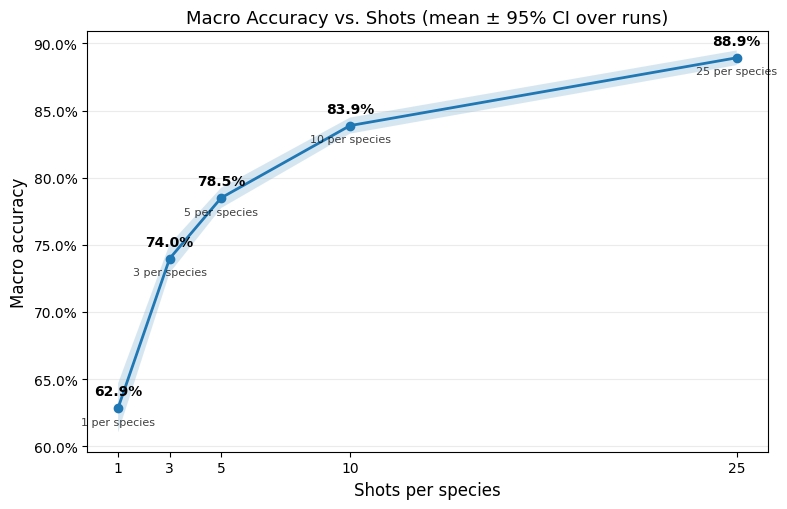

[PLOT] saved ../results/svm_bioclip/species_learning_curves_page01.png


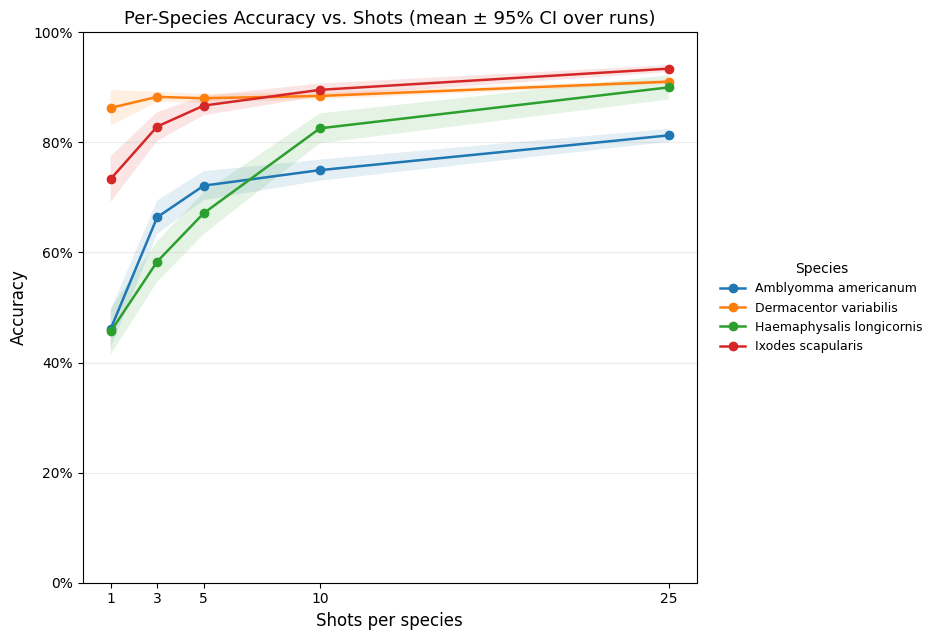

In [10]:
# === Block 8 — Visualization: Macro curve + per-species learning curves (CI, annotations, pagination) ===
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import math
import numpy as np

# ---------- 1) Macro accuracy with 95% CI ribbon + value annotations ----------
fig, ax = plt.subplots(figsize=(8.0, 5.2))

x  = agg_shots["shots"].to_numpy()
y  = agg_shots["mean_macro"].to_numpy()   # 0..1
ci = agg_shots["ci95_macro"].to_numpy()   # half-width

ax.plot(x, y, marker="o", linewidth=2.0)
ax.fill_between(x, y - ci, y + ci, alpha=0.18, linewidth=0)

# Annotate each dot: % above, and "K per species" below
for xi, yi in zip(x, y):
    ax.annotate(f"{yi*100:.1f}%", (xi, yi),
                textcoords="offset points", xytext=(0, 9),
                ha="center", fontsize=10, fontweight="semibold")
    ax.annotate(f"{int(xi)} per species", (xi, yi),
                textcoords="offset points", xytext=(0, -12),
                ha="center", fontsize=8, alpha=0.75)

ax.yaxis.set_major_formatter(PercentFormatter(1.0))
ax.set_xlabel("Shots per species", fontsize=12)
ax.set_ylabel("Macro accuracy", fontsize=12)
ax.set_title("Macro Accuracy vs. Shots (mean ± 95% CI over runs)", fontsize=13)
ax.set_xticks(x)
ax.grid(True, axis="y", alpha=0.25)
plt.tight_layout()
plt.savefig(RESULTS_ROOT / "macro_accuracy_curve.png", dpi=200)
plt.show()

# ---------- 2) Per-species learning curves (95% CI, sorted, paginated) ----------
# We’ll sort species by accuracy at the largest K to highlight easy ↔ hard taxa
K_max = int(np.max(per_species_summary["shots"]))
lastK = (per_species_summary.query("shots == @K_max")
         .sort_values("acc_mean", ascending=False)["species"].tolist())

species_order = lastK
shots_grid = np.sort(per_species_summary["shots"].unique())

# Pagination so legends don’t explode; 10–12 species per page is comfy for talks
SPEC_PER_PAGE = 12
num_pages = math.ceil(len(species_order) / SPEC_PER_PAGE)

for page in range(num_pages):
    start = page * SPEC_PER_PAGE
    end   = start + SPEC_PER_PAGE
    subset = species_order[start:end]
    subdf = per_species_summary[per_species_summary["species"].isin(subset)].copy()

    fig, ax = plt.subplots(figsize=(9.5, 6.5))
    for sp, g in subdf.groupby("species"):
        g = (g.set_index("shots")
               .reindex(shots_grid)
               .reset_index())
        y  = g["acc_mean"].to_numpy()
        ci = g["acc_ci95"].to_numpy()
        ax.plot(shots_grid, y, marker="o", linewidth=1.8, label=sp)
        # CI ribbon (nan-safe)
        lo = (y - ci); hi = (y + ci)
        ax.fill_between(shots_grid, lo, hi, alpha=0.12, linewidth=0)

    ax.yaxis.set_major_formatter(PercentFormatter(1.0))
    ax.set_xticks(shots_grid)
    ax.set_ylim(0, 1.0)
    ax.set_xlabel("Shots per species", fontsize=12)
    ax.set_ylabel("Accuracy", fontsize=12)
    ttl = "Per-Species Accuracy vs. Shots (mean ± 95% CI over runs)"
    if num_pages > 1:
        ttl += f"  —  page {page+1}/{num_pages}"
    ax.set_title(ttl, fontsize=13)
    ax.grid(True, axis="y", alpha=0.25)

    # Put legend outside; scroll-proof in slides
    leg = ax.legend(title="Species", loc="center left", bbox_to_anchor=(1.02, 0.5),
                    frameon=False, fontsize=9, title_fontsize=10)
    plt.tight_layout()
    out = RESULTS_ROOT / f"species_learning_curves_page{page+1:02d}.png"
    plt.savefig(out, dpi=200, bbox_inches="tight")
    print(f"[PLOT] saved {out}")
    plt.show()


[PLOT] saved ../results/svm_bioclip/confusion_mean_rownorm_K01.png


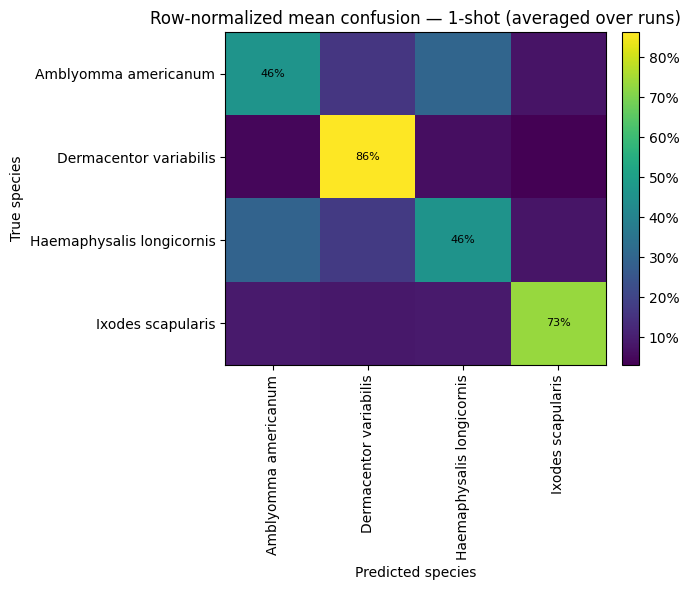

[PLOT] saved ../results/svm_bioclip/confusion_mean_rownorm_K03.png


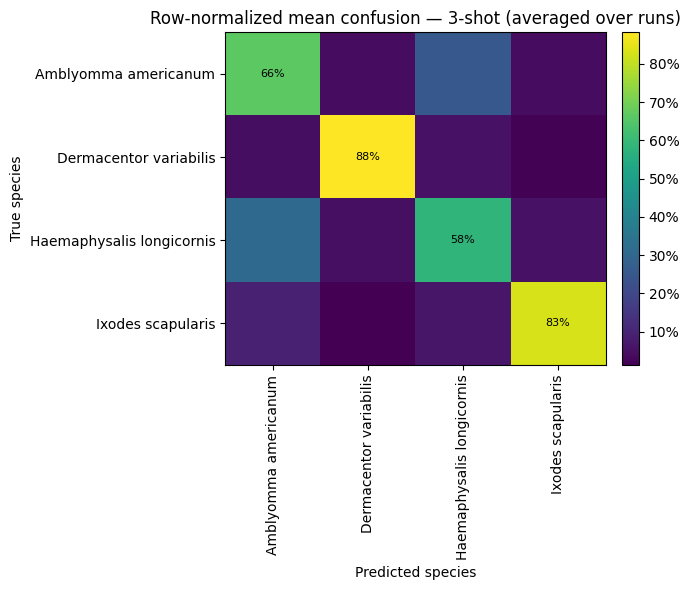

[PLOT] saved ../results/svm_bioclip/confusion_mean_rownorm_K05.png


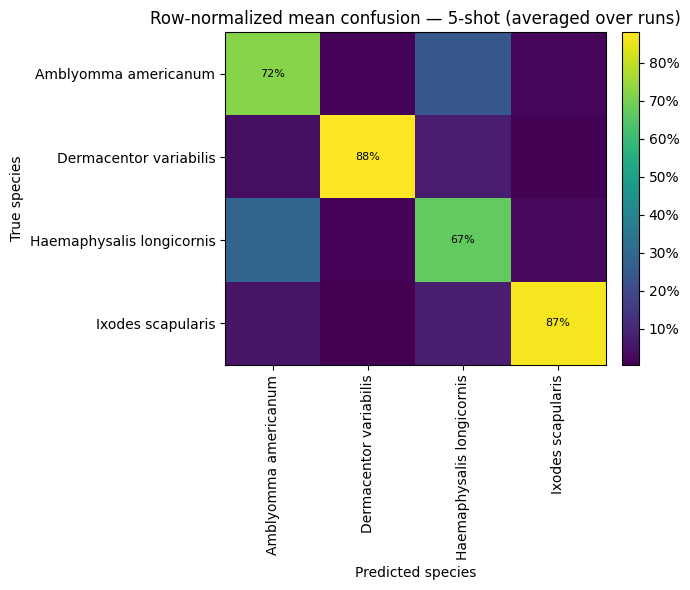

[PLOT] saved ../results/svm_bioclip/confusion_mean_rownorm_K10.png


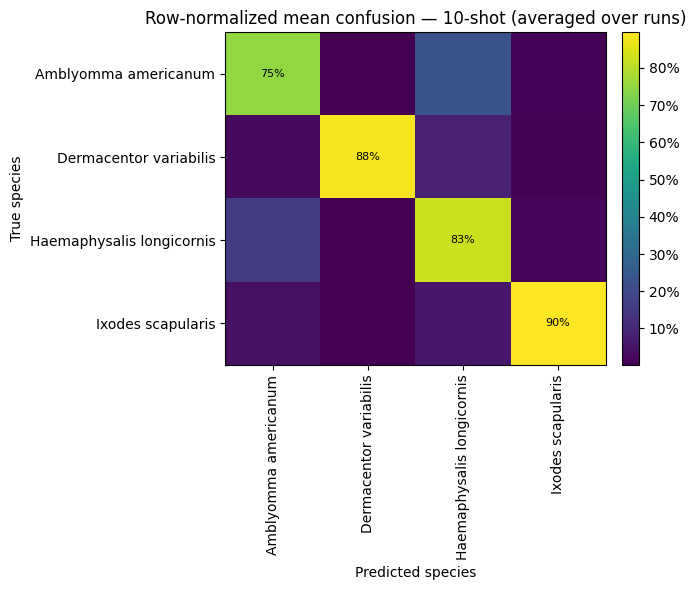

[PLOT] saved ../results/svm_bioclip/confusion_mean_rownorm_K25.png


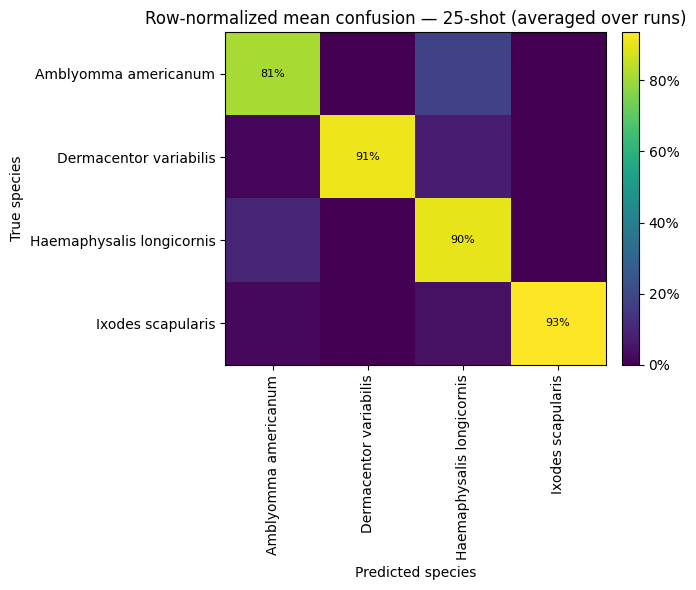

In [11]:
# === Block 9A — Row-normalized mean confusion per K (averaged over runs) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

def mean_rownorm_confusion_for_K(df, K, class_order=None):
    """
    For a given shots K:
      - builds confusion per run (rows=true species)
      - row-normalizes each run's confusion
      - averages row-normalized matrices over runs (species with no test rows in a run are skipped for that row's average)
    Returns:
      classes (list), mean_conf (n_classes x n_classes), counts_per_row (how many runs contributed per row)
    """
    dK = df[df["shots"] == K].copy()
    if class_order is None:
        classes = sorted(pd.unique(dK["species_true"]))
    else:
        # keep only classes that actually appear at K (in case some drop out)
        classes = [c for c in class_order if c in set(dK["species_true"])]
    n = len(classes)
    if n == 0:
        raise ValueError(f"No classes present at K={K}.")

    # Accumulators
    mean_conf = np.zeros((n, n), dtype=float)
    row_counts = np.zeros(n, dtype=int)  # how many runs had nonzero test for that row

    for run_id, dKr in dK.groupby("run_id"):
        # confusion counts for this run
        ct = pd.crosstab(
            pd.Series(dKr["species_true"], name="true"),
            pd.Series(dKr["species_pred"], name="pred")
        )
        # align to full grid
        ct = ct.reindex(index=classes, columns=classes, fill_value=0)
        m = ct.to_numpy().astype(float)

        # row-normalize (skip rows with zero)
        row_sums = m.sum(axis=1, keepdims=True)
        nonzero_rows = (row_sums[:, 0] > 0)
        if not np.any(nonzero_rows):
            continue
        m_norm = np.zeros_like(m)
        m_norm[nonzero_rows] = m[nonzero_rows] / row_sums[nonzero_rows]

        mean_conf[nonzero_rows] += m_norm[nonzero_rows]
        row_counts[nonzero_rows] += 1

    # finalize mean: divide each row by number of contributing runs
    for i in range(n):
        if row_counts[i] > 0:
            mean_conf[i] /= row_counts[i]

    return classes, mean_conf, row_counts

def plot_mean_confusion(K, classes, mean_conf, counts_per_row, outpath):
    n = len(classes)
    fig_h = max(6, 0.45 * n)
    fig_w = max(7, 0.6 * n)
    fig, ax = plt.subplots(figsize=(fig_w, fig_h))
    im = ax.imshow(mean_conf, aspect="auto")  # default colormap; normalized 0..1

    # axes + labels
    ax.set_xticks(range(n)); ax.set_yticks(range(n))
    ax.set_xticklabels(classes, rotation=90)
    ax.set_yticklabels(classes)
    ax.set_xlabel("Predicted species")
    ax.set_ylabel("True species")
    ax.set_title(f"Row-normalized mean confusion — {K}-shot (averaged over runs)")

    # colorbar in percentage
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.yaxis.set_major_formatter(PercentFormatter(1.0))

    # annotate diagonal (optional): show mean recall per species
    for i in range(n):
        ax.text(i, i, f"{mean_conf[i, i]*100:.0f}%",
                ha="center", va="center", fontsize=8, color="black")

    plt.tight_layout()
    outpath.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(outpath, dpi=200, bbox_inches="tight")
    print(f"[PLOT] saved {outpath}")
    plt.show()

# Choose K values you want to present (e.g., all from SHOTS)
for K in SHOTS:
    classes, M, counts = mean_rownorm_confusion_for_K(df, K, class_order=CLASS_ORDER)
    plot_mean_confusion(K, classes, M, counts, RESULTS_ROOT / f"confusion_mean_rownorm_K{K:02d}.png")


[PLOT] saved ../results/svm_bioclip/simple_per_species_recall_vertical_K10.png


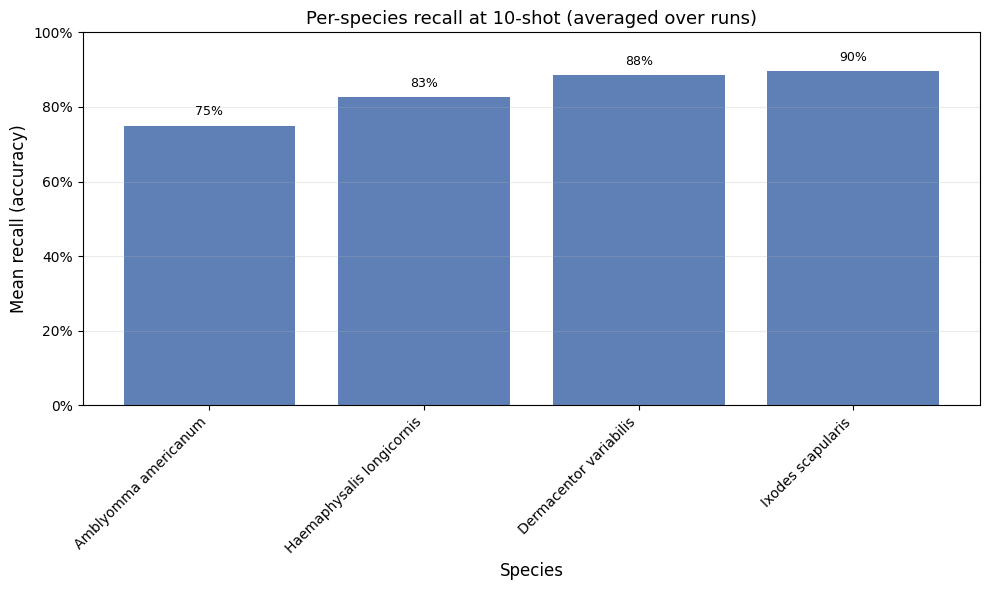

In [12]:
# === Block 9B — Simple per-species recall bar chart (vertical version) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

K_BAR = 10  # choose which shot level to show
sub = per_species_summary[per_species_summary["shots"] == K_BAR].copy()
if len(sub) == 0:
    raise ValueError(f"No per-species summary found for shots={K_BAR}. Run Block 7 first.")

# Harmonize column names
if "species_true" in sub.columns and "species" not in sub.columns:
    sub = sub.rename(columns={"species_true": "species"})

# Sort from lowest → highest accuracy
sub = sub.sort_values("acc_mean", ascending=True).reset_index(drop=True)

fig, ax = plt.subplots(figsize=(10, 6))

# --- vertical bars ---
ax.bar(sub["species"], sub["acc_mean"], color="#4C72B0", alpha=0.9)

# --- format axes ---
ax.set_ylim(0, 1.0)
ax.yaxis.set_major_formatter(PercentFormatter(1.0))
ax.set_ylabel("Mean recall (accuracy)", fontsize=12)
ax.set_xlabel("Species", fontsize=12)
ax.set_title(f"Per-species recall at {K_BAR}-shot (averaged over runs)", fontsize=13)
ax.grid(axis="y", alpha=0.25)

# Rotate labels so they don’t overlap
plt.xticks(rotation=45, ha="right")

# Annotate bars with % values above them
for i, val in enumerate(sub["acc_mean"]):
    ax.text(i, val + 0.02, f"{val*100:.0f}%", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
out = RESULTS_ROOT / f"simple_per_species_recall_vertical_K{K_BAR:02d}.png"
plt.savefig(out, dpi=200, bbox_inches="tight")
print(f"[PLOT] saved {out}")
plt.show()


## Block 10: error analysis

In [13]:
# === Block 10 — Error analysis: Parquet + shortlists for misclassified samples ===

from pathlib import Path
import pandas as pd
import numpy as np


ANALYSIS_ROOT = RESULTS_ROOT / "analysis"
ANALYSIS_ROOT.mkdir(parents=True, exist_ok=True)

# Path to your JSON metadata file (update if needed)
META_JSON = Path("../data/processed/final_data_no_ixodes.json")


# Helper functions 
def choose_most_dominant_value(series: pd.Series):
    """
    Return the most dominant (most frequent) non-null value in a Series.
    If there is a tie or no clear mode, fall back to the first non-null value.
    """
    s = series.dropna()
    if s.empty:
        return np.nan
    mode_values = s.mode()
    if len(mode_values) > 0:
        return mode_values.iloc[0]
    return s.iloc[0]

def count_incorrect(series: pd.Series) -> int:
    """Count how many entries are incorrect (assumes 0 = incorrect, 1 = correct)."""
    return int((series == 0).sum())

def count_correct(series: pd.Series) -> int:
    """Count how many entries are correct (assumes 0 = incorrect, 1 = correct)."""
    return int((series == 1).sum())

def select_top_k_samples(group: pd.DataFrame, k: int) -> pd.DataFrame:
    """
    Within a group (e.g., one species), select the top-k hardest samples,
    based on:
      1) number of incorrect predictions,
      2) incorrect rate,
      3) mean confidence overall.
    """
    return (
        group.sort_values(
            ["n_incorrect", "incorrect_rate", "mean_conf_overall"],
            ascending=[False, False, False],
        )
        .head(k)
    )

# ---------------------------------------------------------------------
# 1) Load latest MASTER predictions (Block 6 already updates this)
# ---------------------------------------------------------------------

MASTER_LATEST = RESULTS_ROOT / "master_predictions_latest.csv"
if not MASTER_LATEST.exists():
    raise FileNotFoundError(f"Could not find {MASTER_LATEST}. Run Block 6 first.")

df_pred = pd.read_csv(MASTER_LATEST)
print(f"[LOAD] MASTER = {MASTER_LATEST.name}, rows = {len(df_pred)}")

# Ensure types are consistent
df_pred["shots"] = df_pred["shots"].astype(int)
df_pred["run_id"] = df_pred["run_id"].astype(int)
df_pred["correct"] = df_pred["correct"].astype(int)
df_pred["sample_id"] = df_pred["sample_id"].astype(str)

# ---------------------------------------------------------------------
# 2) Load metadata from JSON (JSON gets updated so pulls fresh everytime)
# ---------------------------------------------------------------------

if not META_JSON.exists():
    raise FileNotFoundError(f"Metadata JSON not found at {META_JSON}. Update META_JSON path if needed.")

meta_df = pd.read_json(META_JSON)
meta_df["sample_id"] = meta_df["sample_id"].astype(str)

print(f"[LOAD] Metadata JSON = {META_JSON}, rows = {len(meta_df)}")
print("[META] Columns:", list(meta_df.columns))

# Expected fields in JSON:
# ['image_path', 'true_label', 'sample_id', 'view', 'sex', 'life_stage', 'attached']

# ---------------------------------------------------------------------
# 3) Collapse metadata to one row per sample_id
# ---------------------------------------------------------------------
# We want a per-sample summary: dominant labels + representative dorsal/ventral paths.

# Dominant scalar fields per sample
meta_sample = (
    meta_df
    .groupby("sample_id", as_index=False)
    .agg(
        true_label_dominant=("true_label", choose_most_dominant_value),
        sex_dominant=("sex", choose_most_dominant_value),
        life_stage_dominant=("life_stage", choose_most_dominant_value),
        attached_dominant=("attached", choose_most_dominant_value),
        n_images=("image_path", "size"),
    )
)

# Representative dorsal/ventral image paths
dorsal_paths = (
    meta_df[meta_df["view"] == "dorsal"]
    .groupby("sample_id")["image_path"]
    .first()
    .rename("dorsal_image_path")
)
ventral_paths = (
    meta_df[meta_df["view"] == "ventral"]
    .groupby("sample_id")["image_path"]
    .first()
    .rename("ventral_image_path")
)

meta_sample = (
    meta_sample
    .merge(dorsal_paths, on="sample_id", how="left")
    .merge(ventral_paths, on="sample_id", how="left")
)

print(f"[META] Collapsed metadata to {len(meta_sample)} unique sample_ids.")

# ---------------------------------------------------------------------
# 4) Build per-sample prediction summary from MASTER
# ---------------------------------------------------------------------
# Basic stats per sample_id
sample_stats = (
    df_pred
    .groupby("sample_id", as_index=False)
    .agg(
        n_rows=("correct", "size"),
        n_incorrect=("correct", count_incorrect),
        n_correct=("correct", count_correct),
        species_true_dominant=("species_true", choose_most_dominant_value),
        mean_conf_overall=("conf_top1", "mean"),
    )
)

sample_stats["incorrect_rate"] = sample_stats["n_incorrect"] / sample_stats["n_rows"]

# Most common wrong label per sample (if any)
wrong_rows = df_pred[df_pred["correct"] == 0].copy()

if len(wrong_rows) > 0:
    wrong_summary = (
        wrong_rows
        .groupby(["sample_id", "species_pred"], as_index=False)
        .agg(
            n_incorrect_pred=("species_pred", "size"),
            mean_conf_when_wrong=("conf_top1", "mean"),
        )
        .sort_values(
            ["sample_id", "n_incorrect_pred", "mean_conf_when_wrong"],
            ascending=[True, False, False],
        )
    )

    top_wrong_per_sample = (
        wrong_summary
        .groupby("sample_id", as_index=False)
        .head(1)
        .rename(
            columns={
                "species_pred": "most_common_pred",
                "n_incorrect_pred": "n_incorrect_to_most_common",
                "mean_conf_when_wrong": "mean_conf_to_most_common",
            }
        )
        [["sample_id", "most_common_pred", "n_incorrect_to_most_common", "mean_conf_to_most_common"]]
    )
else:
    # No misclassifications at all (unlikely, but safe)
    top_wrong_per_sample = pd.DataFrame(
        columns=["sample_id", "most_common_pred", "n_incorrect_to_most_common", "mean_conf_to_most_common"]
    )

sample_stats = sample_stats.merge(top_wrong_per_sample, on="sample_id", how="left")

# Error rate by shot level per sample (err_by_shot_K)
shot_stats = (
    df_pred
    .groupby(["sample_id", "shots"], as_index=False)
    .agg(
        n_rows_shot=("correct", "size"),
        n_incorrect_shot=("correct", count_incorrect),
    )
)

# Pivot shot-level error rates into columns
pivot_nrows = shot_stats.pivot(index="sample_id", columns="shots", values="n_rows_shot")
pivot_ninc = shot_stats.pivot(index="sample_id", columns="shots", values="n_incorrect_shot")
err_by_shot = pivot_ninc / pivot_nrows

# Rename columns like err_by_shot_1, err_by_shot_3, ...
err_by_shot.columns = [f"err_by_shot_{int(k)}" for k in err_by_shot.columns]
err_by_shot = err_by_shot.reset_index()

sample_stats = sample_stats.merge(err_by_shot, on="sample_id", how="left")

# Attach metadata to the sample stats
sample_summary = sample_stats.merge(meta_sample, on="sample_id", how="left")

print(f"[SAMPLE] sample_summary rows = {len(sample_summary)}")
print("[SAMPLE] Columns:", list(sample_summary.columns))

# ---------------------------------------------------------------------
# 5) Species-level summary and confusion summary
# ---------------------------------------------------------------------

# Confusion summary: counts and within-true rates for each (true, pred)
confusion_summary = (
    df_pred
    .groupby(["species_true", "species_pred"], as_index=False)
    .size()
    .rename(columns={"size": "count"})
)

true_totals = (
    confusion_summary
    .groupby("species_true", as_index=False)["count"]
    .sum()
    .rename(columns={"count": "true_total"})
)

confusion_summary = confusion_summary.merge(true_totals, on="species_true", how="left")
confusion_summary["rate_within_true"] = confusion_summary["count"] / confusion_summary["true_total"]

# Species-level error summary
species_summary = (
    df_pred
    .groupby("species_true", as_index=False)
    .agg(
        n_total_rows=("correct", "size"),
        n_total_incorrect=("correct", count_incorrect),
        n_total_correct=("correct", count_correct),
    )
)
species_summary["error_rate"] = species_summary["n_total_incorrect"] / species_summary["n_total_rows"]

# Most confused-with per species (ignore diagonal where true == pred)
wrong_confusion = confusion_summary[confusion_summary["species_true"] != confusion_summary["species_pred"]].copy()

if len(wrong_confusion) > 0:
    most_confused_with = (
        wrong_confusion
        .sort_values(["species_true", "count"], ascending=[True, False])
        .groupby("species_true", as_index=False)
        .head(1)
        .rename(
            columns={
                "species_pred": "most_confused_with",
                "count": "misclass_count",
                "rate_within_true": "misclass_rate_within_true",
            }
        )
        [["species_true", "most_confused_with", "misclass_count", "misclass_rate_within_true"]]
    )
else:
    most_confused_with = pd.DataFrame(
        columns=["species_true", "most_confused_with", "misclass_count", "misclass_rate_within_true"]
    )

species_summary = species_summary.merge(most_confused_with, on="species_true", how="left")

print(f"[SPECIES] species_summary rows = {len(species_summary)}")
print(f"[CONFUSION] confusion_summary rows = {len(confusion_summary)}")

# ---------------------------------------------------------------------
# 6) Stack everything into a single Parquet with a `table_name` tag
# ---------------------------------------------------------------------

sample_tbl = sample_summary.copy()
sample_tbl["table_name"] = "sample_summary"

species_tbl = species_summary.copy()
species_tbl["table_name"] = "species_summary"

conf_tbl = confusion_summary.copy()
conf_tbl["table_name"] = "confusion_summary"

ticks_analysis = pd.concat([sample_tbl, species_tbl, conf_tbl], ignore_index=True, sort=False)

parquet_path = ANALYSIS_ROOT / "ticks_analysis.parquet"
ticks_analysis.to_parquet(parquet_path, index=False)
print(f"[WRITE] Parquet written → {parquet_path}")

# ---------------------------------------------------------------------
# 7) Shortlists: global top misclassified + per-species top misclassified
# ---------------------------------------------------------------------

# Only keep samples that were misclassified at least once, and seen enough times
candidates = sample_summary[sample_summary["n_incorrect"] > 0].copy()

MIN_RUNS = 5  # you can tune this
candidates = candidates[candidates["n_rows"] >= MIN_RUNS]

# Global top K hardest samples
K_GLOBAL = 50
top_global = (
    candidates
    .sort_values(
        ["n_incorrect", "incorrect_rate", "mean_conf_overall"],
        ascending=[False, False, False]
    )
    .head(K_GLOBAL)
    .reset_index(drop=True)
)

top_global_path = ANALYSIS_ROOT / "top_misclassified_samples.csv"
top_global.to_csv(top_global_path, index=False)
print(f"[WRITE] Global top misclassified → {top_global_path} (rows = {len(top_global)})")

# Top K per species (based on dominant true species)
K_SPECIES = 10

top_per_species = (
    candidates
    .groupby("species_true_dominant", group_keys=True)
    .apply(lambda g: select_top_k_samples(g, K_SPECIES))
    .reset_index(drop=True)
)

top_per_species_path = ANALYSIS_ROOT / "top10_per_species.csv"
top_per_species.to_csv(top_per_species_path, index=False)
print(f"[WRITE] Per-species top misclassified → {top_per_species_path} (rows = {len(top_per_species)})")

# ---------------------------------------------------------------------
# 8) Quick preview in the notebook (so you can sanity-check)
# ---------------------------------------------------------------------

from IPython.display import display

print("\n[SAMPLE SUMMARY PREVIEW]")
display(sample_summary.head())

print("\n[SPECIES SUMMARY PREVIEW]")
display(species_summary.head())

print("\n[CONFUSION SUMMARY PREVIEW]")
display(confusion_summary.head())

print("\n[GLOBAL TOP MISCLASSIFIED PREVIEW]")
display(top_global.head())

print("\n[PER-SPECIES TOP MISCLASSIFIED PREVIEW]")
display(top_per_species.head())

print("\n✅ Block 10 complete: ticks_analysis.parquet + shortlists written.")


[LOAD] MASTER = master_predictions_latest.csv, rows = 268400
[LOAD] Metadata JSON = ../data/processed/final_data_no_ixodes.json, rows = 1160
[META] Columns: ['image_path', 'true_label', 'sample_id', 'view', 'sex', 'life_stage', 'attached']
[META] Collapsed metadata to 580 unique sample_ids.
[SAMPLE] sample_summary rows = 572
[SAMPLE] Columns: ['sample_id', 'n_rows', 'n_incorrect', 'n_correct', 'species_true_dominant', 'mean_conf_overall', 'incorrect_rate', 'most_common_pred', 'n_incorrect_to_most_common', 'mean_conf_to_most_common', 'err_by_shot_1', 'err_by_shot_3', 'err_by_shot_5', 'err_by_shot_10', 'err_by_shot_25', 'true_label_dominant', 'sex_dominant', 'life_stage_dominant', 'attached_dominant', 'n_images', 'dorsal_image_path', 'ventral_image_path']
[SPECIES] species_summary rows = 4
[CONFUSION] confusion_summary rows = 16
[WRITE] Parquet written → ../results/svm_bioclip/analysis/ticks_analysis.parquet
[WRITE] Global top misclassified → ../results/svm_bioclip/analysis/top_misclassi

/var/folders/tc/csl5ykwn1v36vwqf20swsn880000gn/T/ipykernel_15308/2743123547.py:322: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: select_top_k_samples(g, K_SPECIES))


,sample_id,n_rows,n_incorrect,n_correct,species_true_dominant,mean_conf_overall,incorrect_rate,most_common_pred,n_incorrect_to_most_common,mean_conf_to_most_common,...,err_by_shot_5,err_by_shot_10,err_by_shot_25,true_label_dominant,sex_dominant,life_stage_dominant,attached_dominant,n_images,dorsal_image_path,ventral_image_path
0,100-01,489,7,482,Dermacentor variabilis,0.580374,0.014315,Ixodes scapularis,3,0.250345,...,0.000000,0.000000,0.00000,Dermacentor variabilis,Female,Adult,,2,/Users/jayjivandas/Library/CloudStorage/OneDri...,/Users/jayjivandas/Library/CloudStorage/OneDri...
1,102-01,464,34,430,Ixodes scapularis,0.510443,0.073276,Haemaphysalis longicornis,13,0.280920,...,0.021277,0.000000,0.00000,Ixodes scapularis,Female,Adult,,2,/Users/jayjivandas/Library/CloudStorage/OneDri...,/Users/jayjivandas/Library/CloudStorage/OneDri...
2,104-01,467,178,289,Ixodes scapularis,0.385049,0.381156,Haemaphysalis longicornis,115,0.347385,...,0.393939,0.300000,0.22619,Ixodes scapularis,Female,Adult,,2,/Users/jayjivandas/Library/CloudStorage/OneDri...,/Users/jayjivandas/Library/CloudStorage/OneDri...
3,106-01,484,23,461,Dermacentor variabilis,0.502830,0.047521,Haemaphysalis longicornis,13,0.282298,...,0.040000,0.000000,0.00000,Dermacentor variabilis,Male,Adult,,2,/Users/jayjivandas/Library/CloudStorage/OneDri...,/Users/jayjivandas/Library/CloudStorage/OneDri...
4,107-01,480,26,454,Dermacentor variabilis,0.476293,0.054167,Haemaphysalis longicornis,17,0.309509,...,0.051020,0.020833,0.00000,Dermacentor variabilis,Male,Adult,,2,/Users/jayjivandas/Library/CloudStorage/OneDri...,/Users/jayjivandas/Library/CloudStorage/OneDri...



[SPECIES SUMMARY PREVIEW]


,species_true,n_total_rows,n_total_incorrect,n_total_correct,error_rate,most_confused_with,misclass_count,misclass_rate_within_true
0,Amblyomma americanum,40600,13306,27294,0.327734,Haemaphysalis longicornis,10003,0.246379
1,Dermacentor variabilis,149600,17401,132199,0.116317,Haemaphysalis longicornis,10313,0.068937
2,Haemaphysalis longicornis,13100,4703,8397,0.359008,Amblyomma americanum,3363,0.256718
3,Ixodes scapularis,65100,9889,55211,0.151905,Haemaphysalis longicornis,4444,0.068264



[CONFUSION SUMMARY PREVIEW]


,species_true,species_pred,count,true_total,rate_within_true
0,Amblyomma americanum,Amblyomma americanum,27294,40600,0.672266
1,Amblyomma americanum,Dermacentor variabilis,1984,40600,0.048867
2,Amblyomma americanum,Haemaphysalis longicornis,10003,40600,0.246379
3,Amblyomma americanum,Ixodes scapularis,1319,40600,0.032488
4,Dermacentor variabilis,Amblyomma americanum,5012,149600,0.033503



[GLOBAL TOP MISCLASSIFIED PREVIEW]


,sample_id,n_rows,n_incorrect,n_correct,species_true_dominant,mean_conf_overall,incorrect_rate,most_common_pred,n_incorrect_to_most_common,mean_conf_to_most_common,...,err_by_shot_5,err_by_shot_10,err_by_shot_25,true_label_dominant,sex_dominant,life_stage_dominant,attached_dominant,n_images,dorsal_image_path,ventral_image_path
0,149-01,493,476,17,Dermacentor variabilis,0.370886,0.965517,Haemaphysalis longicornis,288,0.392311,...,0.989899,0.989796,1.0,Dermacentor variabilis,Female,Adult,,2,/Users/jayjivandas/Library/CloudStorage/OneDri...,/Users/jayjivandas/Library/CloudStorage/OneDri...
1,ZOE-0096-01,486,471,15,Dermacentor variabilis,0.454568,0.969136,Haemaphysalis longicornis,370,0.496404,...,0.989899,1.000000,1.0,Dermacentor variabilis,Female,Adult,No,2,/Users/jayjivandas/Library/CloudStorage/OneDri...,/Users/jayjivandas/Library/CloudStorage/OneDri...
2,ZOE-0021-01,479,469,10,Dermacentor variabilis,0.366629,0.979123,Haemaphysalis longicornis,281,0.385279,...,0.978947,1.000000,1.0,Dermacentor variabilis,,Nymph,,2,/Users/jayjivandas/Library/CloudStorage/OneDri...,/Users/jayjivandas/Library/CloudStorage/OneDri...
3,560-01,484,468,16,Dermacentor variabilis,0.392979,0.966942,Haemaphysalis longicornis,329,0.416884,...,0.989899,1.000000,1.0,Dermacentor variabilis,Female,Adult,No,2,/Users/jayjivandas/Library/CloudStorage/OneDri...,/Users/jayjivandas/Library/CloudStorage/OneDri...
4,ZOE-0021-03,490,463,27,Dermacentor variabilis,0.371205,0.944898,Haemaphysalis longicornis,272,0.385813,...,0.989899,0.979798,1.0,Dermacentor variabilis,Female,Adult,,2,/Users/jayjivandas/Library/CloudStorage/OneDri...,/Users/jayjivandas/Library/CloudStorage/OneDri...



[PER-SPECIES TOP MISCLASSIFIED PREVIEW]


,sample_id,n_rows,n_incorrect,n_correct,species_true_dominant,mean_conf_overall,incorrect_rate,most_common_pred,n_incorrect_to_most_common,mean_conf_to_most_common,...,err_by_shot_5,err_by_shot_10,err_by_shot_25,true_label_dominant,sex_dominant,life_stage_dominant,attached_dominant,n_images,dorsal_image_path,ventral_image_path
0,428-01,451,371,80,Amblyomma americanum,0.366849,0.822616,Haemaphysalis longicornis,244,0.395998,...,0.817204,0.844444,0.945946,Amblyomma americanum,,Nymph,"Yes, less than 24 hours",2,/Users/jayjivandas/Library/CloudStorage/OneDri...,/Users/jayjivandas/Library/CloudStorage/OneDri...
1,201-01,446,365,81,Amblyomma americanum,0.418836,0.818386,Haemaphysalis longicornis,321,0.455541,...,0.840426,0.903614,0.986111,Amblyomma americanum,Female,Adult,,2,/Users/jayjivandas/Library/CloudStorage/OneDri...,/Users/jayjivandas/Library/CloudStorage/OneDri...
2,56-01,447,360,87,Amblyomma americanum,0.458798,0.805369,Haemaphysalis longicornis,349,0.490859,...,0.795699,0.901099,0.985507,Amblyomma americanum,Female,Adult,,2,/Users/jayjivandas/Library/CloudStorage/OneDri...,/Users/jayjivandas/Library/CloudStorage/OneDri...
3,31-03,448,358,90,Amblyomma americanum,0.425080,0.799107,Haemaphysalis longicornis,324,0.456392,...,0.812500,0.866667,0.984848,Amblyomma americanum,Female,Adult,,2,/Users/jayjivandas/Library/CloudStorage/OneDri...,/Users/jayjivandas/Library/CloudStorage/OneDri...
4,67-02,452,355,97,Amblyomma americanum,0.481507,0.785398,Haemaphysalis longicornis,346,0.518102,...,0.773196,0.885057,0.971831,Amblyomma americanum,Female,Adult,,2,/Users/jayjivandas/Library/CloudStorage/OneDri...,/Users/jayjivandas/Library/CloudStorage/OneDri...



✅ Block 10 complete: ticks_analysis.parquet + shortlists written.


In [ ]:
# === Block 11 — HTML Error Gallery for Misclassified Samples ===

from pathlib import Path
import pandas as pd
import html

# Use the same RESULTS_ROOT and ANALYSIS_ROOT as before
ANALYSIS_ROOT = RESULTS_ROOT / "analysis"
gallery_path = ANALYSIS_ROOT / "error_gallery.html"

# ---------------------------------------------------------------------
# 1) Load the shortlists we created in Block 10
# ---------------------------------------------------------------------

top_global_path = ANALYSIS_ROOT / "top_misclassified_samples.csv"
top_per_species_path = ANALYSIS_ROOT / "top10_per_species.csv"

if not top_global_path.exists() or not top_per_species_path.exists():
    raise FileNotFoundError("Top misclassified CSVs not found. Run Block 10 first.")

top_global = pd.read_csv(top_global_path)
top_per_species = pd.read_csv(top_per_species_path)

print(f"[LOAD] Global top misclassified: {len(top_global)} rows")
print(f"[LOAD] Per-species top misclassified: {len(top_per_species)} rows")

# ---------------------------------------------------------------------
# 2) Helper to generate HTML for one sample row
# ---------------------------------------------------------------------

def make_image_tag(path, label):
    """Return an <img> tag for a local image path, or a placeholder if missing."""
    if pd.isna(path) or not Path(path).exists():
        return f'<div class="img-missing">No {html.escape(label)} image</div>'
    # Use file:// so the browser can open local images
    src = "file://" + str(Path(path).resolve())
    return f'<img src="{html.escape(src)}" alt="{html.escape(label)}" class="tick-image">'

def sample_card(row):
    """Return HTML for a single sample card with dorsal/ventral and metadata."""
    sample_id = str(row.get("sample_id", ""))
    true_species = row.get("species_true_dominant", row.get("species_true", ""))
    most_common_pred = row.get("most_common_pred", "")
    incorrect_rate = row.get("incorrect_rate", "")
    n_incorrect = row.get("n_incorrect", "")
    n_rows = row.get("n_rows", "")
    sex = row.get("sex_dominant", "")
    life_stage = row.get("life_stage_dominant", "")
    attached = row.get("attached_dominant", "")
    dorsal_path = row.get("dorsal_image_path", "")
    ventral_path = row.get("ventral_image_path", "")

    dorsal_img = make_image_tag(dorsal_path, "dorsal")
    ventral_img = make_image_tag(ventral_path, "ventral")

    # Safety: handle NaNs nicely
    def fmt(x):
        if isinstance(x, float):
            if pd.isna(x):
                return ""
            return f"{x:.3f}"
        return "" if pd.isna(x) else str(x)

    html_block = f"""
    <div class="sample-card">
      <div class="meta">
        <div><strong>Sample ID:</strong> {html.escape(fmt(sample_id))}</div>
        <div><strong>True species:</strong> {html.escape(fmt(true_species))}</div>
        <div><strong>Most common wrong prediction:</strong> {html.escape(fmt(most_common_pred))}</div>
        <div><strong>Incorrect:</strong> {html.escape(fmt(n_incorrect))} / {html.escape(fmt(n_rows))} 
             (rate = {html.escape(fmt(incorrect_rate))})</div>
        <div><strong>Sex:</strong> {html.escape(fmt(sex))}</div>
        <div><strong>Life stage:</strong> {html.escape(fmt(life_stage))}</div>
        <div><strong>Attached (fed status proxy):</strong> {html.escape(fmt(attached))}</div>
      </div>
      <div class="images">
        <div class="image-column">
          <div class="image-label">Dorsal</div>
          {dorsal_img}
        </div>
        <div class="image-column">
          <div class="image-label">Ventral</div>
          {ventral_img}
        </div>
      </div>
    </div>
    """
    return html_block

# ---------------------------------------------------------------------
# 3) Build the HTML document
# ---------------------------------------------------------------------

sections = []

# --- Section 1: Global top misclassified ---
global_cards = "\n".join(sample_card(row) for _, row in top_global.iterrows())
sections.append(f"""
<section>
  <h2>Global Top Misclassified Samples</h2>
  <p>These are the {len(top_global)} hardest samples across all species, based on how often they are misclassified and how consistently.</p>
  {global_cards}
</section>
""")

# --- Section 2: Top misclassified per species ---
species_groups = top_per_species.groupby("species_true_dominant", dropna=False)

species_sections_html = []
for species_name, group in species_groups:
    species_label = species_name if pd.notna(species_name) else "Unknown species"
    cards = "\n".join(sample_card(row) for _, row in group.iterrows())
    species_sections_html.append(f"""
    <section class="species-section">
      <h3>Top misclassified for species: {html.escape(str(species_label))}</h3>
      {cards}
    </section>
    """)

sections.append("""
<section>
  <h2>Top Misclassified Samples Per Species</h2>
  <p>These sections show the hardest samples within each species, based on misclassification frequency and rate.</p>
  {inner}
</section>
""".format(inner="\n".join(species_sections_html)))

# --- Combine everything into a full HTML page ---
full_html = f"""
<!DOCTYPE html>
<html>
<head>
  <meta charset="utf-8">
  <title>Tick Error Analysis Gallery</title>
  <style>
    body {{
      font-family: -apple-system, BlinkMacSystemFont, "Segoe UI", sans-serif;
      margin: 20px;
      background-color: #111;
      color: #eee;
    }}
    h1, h2, h3 {{
      color: #ffcc66;
    }}
    .sample-card {{
      border: 1px solid #444;
      border-radius: 10px;
      padding: 12px;
      margin: 12px 0;
      background-color: #1b1b1b;
      display: flex;
      flex-direction: column;
      gap: 8px;
    }}
    .meta {{
      font-size: 0.9rem;
      line-height: 1.3;
    }}
    .images {{
      display: flex;
      flex-direction: row;
      gap: 16px;
      margin-top: 8px;
    }}
    .image-column {{
      flex: 1;
      text-align: center;
    }}
    .image-label {{
      margin-bottom: 4px;
      font-size: 0.85rem;
      color: #ccc;
    }}
    .tick-image {{
      max-width: 320px;
      max-height: 320px;
      border-radius: 8px;
      border: 1px solid #555;
      background-color: #000;
    }}
    .img-missing {{
      color: #888;
      font-size: 0.85rem;
      border: 1px dashed #555;
      border-radius: 8px;
      padding: 20px;
    }}
    section {{
      margin-bottom: 32px;
    }}
    .species-section {{
      margin-top: 24px;
      padding-top: 8px;
      border-top: 1px dashed #444;
    }}
  </style>
</head>
<body>
  <h1>Tick Misclassification Error Gallery</h1>
  <p>
    This gallery shows misclassified samples from the BioCLIP+SVM experiments.
    Each card shows dorsal and ventral images (if available), along with true label,
    most common wrong prediction, misclassification rate, and biological metadata
    such as sex, life stage, and attached status (fed vs not fed proxy).
  </p>
  {"".join(sections)}
</body>
</html>
"""

# ---------------------------------------------------------------------
# 4) Write HTML file
# ---------------------------------------------------------------------

gallery_path.write_text(full_html, encoding="utf-8")
print(f"\n✅ Error gallery written to: {gallery_path}")
print("Open this file in your browser (e.g., double-click it in Finder or `open` it from the terminal).")
